# Examples of ordinary differential equation discovery with EPDE framework

This notebook presents an overview of the evolutionary discovery of ODE on examples... 

In [1]:
import numpy as np
import os
import sys
from typing import Union, Callable

import matplotlib.pyplot as plt
import matplotlib as mpl

ADD SOME LINK TO ARTICLE ON EPDE PRINCIPLES

In [2]:
import sys
sys.path.append('..')
import helpers

In [3]:
import epde

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = True

SMALL_SIZE = 12
mpl.rc('font', size=SMALL_SIZE)
mpl.rc('axes', titlesize=SMALL_SIZE)


## First order ODE with trigonometric functions

Principles of equation discovery can be illustrated by a simple example of reconstruction of first-order equation:

\begin{equation}
\label{eq:ODE1}
x \sin{t} + \frac{d x}{d t} \cos{t} = 1,
\end{equation}

where the general solution for an arbitrary constant $C$ is:

\begin{equation}
\label{eq:ODE1_solution}
x = \sin{t} + C \cos{t}.
\end{equation}

To generate the data we will use an analytical particular solution, matching initial condition of $x(0) = 1.3$ (thus, $C = 1.3$) on the interval of $(0, 4 \pi)$:

\begin{equation}
\label{eq:ODE1_part_solution}
x = \sin{t} + 1.3 \cos{t}.
\end{equation}

Furthermore, we will provide an example of using a priori known derivatvies, that can be easily calculated by differentiating the solution:

\begin{equation}
\label{eq:ODE1_deriv_solution}
x' = \cos{t} - 1.3 \sin{t}.
\end{equation}

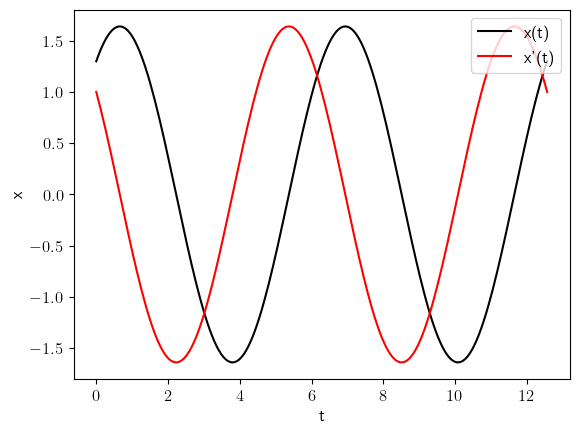

In [4]:
C = 1.3
t = np.linspace(0, 4*np.pi, 200)
x = np.sin(t) + C * np.cos(t)
x_dot = np.cos(t) - C * np.sin(t)

max_axis_idx = x.ndim - 1

plt.plot(t, x, color = 'k', label = 'x(t)')
plt.plot(t, x_dot, color = 'r', label = "x'(t)")

plt.legend(loc = 'upper right')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Next, we shall initialize the equation search object. Here we are using multiobjective optimization (here, it i denoted explicitly, despite it being the default option). Non-defalut parameter is the size of the boundary: $s_{bnd} = 20$.

Additional parameters will be as follows  population size number of optimziation epochs: ``n_epochs = 30``.

To be able to discovery the correct governing equation, the set of elementary functions (i.e. tokens) (in addition to the derivatives, that are always used) has to include the trigonometric functions. Furthermore, we will include grid as elementary block to provide diversity of the tokens.

In [5]:
bnd = 20
n_epochs = 50
popsize = 8

epde_search_obj = epde.EpdeSearch(multiobjective_mode = True, boundary = bnd, 
                                  dimensionality = max_axis_idx, coordinate_tensors = [t,])

trig_tokens = epde.TrigonometricTokens(freq = (0.95, 1.05), dimensionality=max_axis_idx)
grid_tokens = epde.GridTokens(['x_0',], dimensionality = max_axis_idx)

epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=n_epochs)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc1b510b610>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc1b510b610>
trig_token_params: VALUES = (0, 0)
OrderedDict([('power', (1, 1)), ('dim', (0, 0))])


The detection of differential equations is initiated with ``EpdeSearch.fit()`` method. Data is passed in the ``data`` argument, where the elements of the argument list are numpy.ndarrays, describing individual variables. The derivatives can be passed explicity in the argument ``derivs`` with the same logic: the argument has to be a list with numpy.ndarrays of derivatives for each variable. The dimensionality of such arrays has to be $n\_points \; \times \; deriv\_ords$, where $n\_points$ is the total number of points in the domain, and $deriv\_ords$ is the number of passed derivatives. With ``derivs = None``, the derivatives are calculated numerically.

Additional elementary functions, that we expect to have in the resulting equations, are passed in the ``additional_tokens`` argument. 

We define equation structure properties with the following settings:

- Argument ``max_deriv_order`` sets the highest order of derivatives, that can be used in equation search. 
- Number of terms, accepted into the structure before regularization is regulated by argument ``equation_terms_max_number``.
- Argument ``equation_factors_max_number`` defined number of terms in the term can be set as integer (in this case, the number of factors for the particular term is selected from a uniform distribution $U(1, equation\_factors\_max\_number)$), or by dictionary, as in our example.
- Argument ``data_fun_pow`` indicates the highest power of derivative-like token in the equation. With ``data_fun_pow = 2``, supported by sufficiently high ``equation_factors_max_number`` and ``equation_terms_max_number``, the terms like $u^2 u'$ and $(u')^2 \cdot u^2$ can appear in the equation, while terms like $u^3$ won't be allowed in structures.
- Sparsity constant range ``eq_sparsity_interval`` controls the complexities of the initially created candidate equations: the argument has to be a tuple of $(a_{left}, a_{right})$. Each candidate during the population initialization is given a value $\lambda = \exp{l}; \; l \sim U(\ln a_{left}, \ln a_{right})$. With the boundaries shifted to 0, the equation is regularized less, while with high values of $ a_{left} \; \& \; a_{right}$ the majority of terms will be filtered out.

In [6]:
factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.65, 0.35]} # 1 factor with P = 0.65, 2 with P = 0.35

epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(1,), derivs=[x_dot.reshape((-1, 1)),],
                    equation_terms_max_number=4, data_fun_pow = 1,
                    additional_tokens=[trig_tokens, grid_tokens],
                    equation_factors_max_number=factors_max_number,
                    eq_sparsity_interval=(1e-6, 1e-2))

Deriv orders after definition [[None], [0]]
initial_shape (200,) derivs_tensor.shape (200, 1)
self.tokens is ['u', 'du/dx0']
Here, derivs order is {'u': [None], 'du/dx0': [0]}
The cardinality of defined token pool is [2 2 1]
Among them, the pool contains [2 1]
Creating new equation, sparsity value [0.00013173]
New solution accepted, confirmed 1/8 solutions.
Creating new equation, sparsity value [0.00041759]
New solution accepted, confirmed 2/8 solutions.
Creating new equation, sparsity value [0.00025425]
Creating new equation, sparsity value [0.00017177]
New solution accepted, confirmed 3/8 solutions.
Creating new equation, sparsity value [2.06723287e-06]
New solution accepted, confirmed 4/8 solutions.
Creating new equation, sparsity value [0.00086434]
New solution accepted, confirmed 5/8 solutions.
Creating new equation, sparsity value [4.96260272e-05]
New solution accepted, confirmed 6/8 solutions.
Creating new equation, sparsity value [3.79898092e-05]
New solution accepted, confirme

During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 22-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 23-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 24-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During 

During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 47-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 48-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 49-th epoch.
During MO : processing 0-th weight.
During 

The discovered equations can be accessed with ``EpdeSearch.equations()`` method. If the ``only_print = True``, than the equations will be printed in their text forms. 

Otherwise, they will be return: if the followup argument ``only_str`` is ``True``, than the equations are returned only in their symbolic string-form. If ``only_str = False``, than the equation in its program implementation ``epde.structure.main_structures.SoEq`` are returned.

In [7]:
epde_search_obj.equations(only_print = True)
res = epde_search_obj.equations(False, only_str = False)



0-th non-dominated level


0.0 * x_0{power: 1.0, dim: 0.0} + 0.025217005432275823 * u{power: 1.0} + 0.0 * x_0{power: 1.0, dim: 0.0} * u{power: 1.0} + 0.6669677405245148 = du/dx0{power: 1.0} * cos{power: 1.0, freq: 1.0499000873630582, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 4}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.005657086033085299}} , with objective function values of [5.89152992 2.        ] 

0.00888228979551941 * x_0{power: 1.0, dim: 0.0} + 0.006798153402721441 * u{power: 1.0} * cos{power: 1.0, freq: 0.9974444910634812, dim: 0.0} + -1.0004120960660567 * u{power: 1.0} * sin{power: 1.0, freq: 1.0076995322921416, dim: 0.0} + 0.9973172059164307 = du/dx0{power: 1.0} * cos{power: 1.0, freq: 1.006623183604285, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 4}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], '

The particular solution of the ODE in addition to the governing equation $x \sin{(t)} + x' \cos{(t)} = 1,$ also matches the solution of equation $x' \sin{(t)}  - x \cos{(t)} = - 1.3$. With them having (in ideal case) the same fitness functions values, we can expect presence of at least one type of such results in the equation.

We can use visual analysis of the Pareto-optimal set of candidate equations, placed in the complexity-quality criteria space, to select the optimal equation. Method ``EpdeSearch.visualize_solutions()`` illustrates the first non-dominated set of solutions (i.e. Pareto frontier). With its help we can see, that equations like $x' \cdot \sin{(1.001 \; t)} = 9.997\cdot 10^{-1} x \cdot cos{(1.006 \; t)} + -1.274$ (due to stochastic nature of evolutionary optimization) matches the knee point of a Pareto frontier curve.

$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot cos^{1.0}(1.05 x_{0.0}) = 2.522\cdot 10^{-2} u + 6.67\cdot 10^{-1}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot cos^{1.0}(1.007 x_{0.0}) = 8.882\cdot 10^{-3} x_0 + 6.798\cdot 10^{-3} u \cdot cos^{1.0}(9.974\cdot 10^{-1}  x_{0.0}) + -1.0u \cdot sin^{1.0}(1.008 x_{0.0}) + 9.973\cdot 10^{-1}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot cos^{1.0}(1.002 x_{0.0}) = -9.99\cdot 10^{-1} u \cdot sin^{1.0}(1.0 x_{0.0}) + 1.008 \end{eqnarray*}$


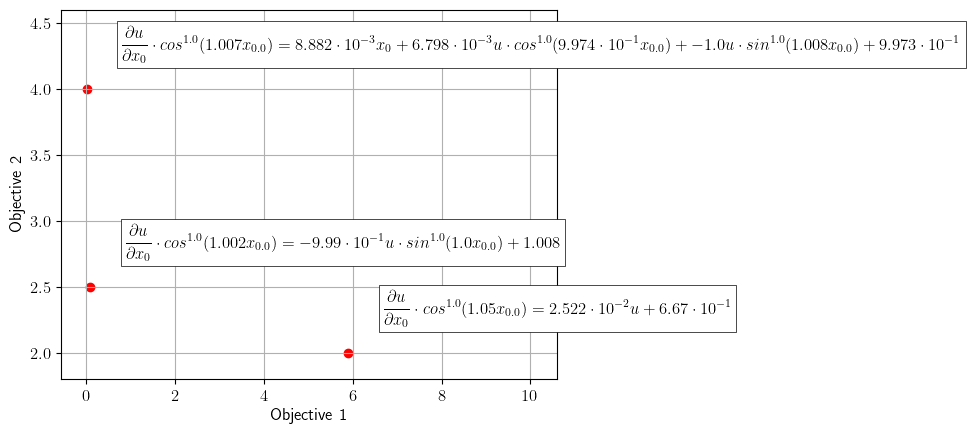

In [8]:
epde_search_obj.visualize_solutions()

## Second order non-linear ODE

A more complex example of the problem can be posed by a linear non-homogeneous equation $x'' + \sin{(2t)} x' + 4 x = 1.5 t$. To get a synthetic dataset we can solve it with Runge-Kutta fourth order method. The particular solution matches the initial problem of $x|_{t = 0} = 0.8$, $x''|_{t = 0} = 2.0$ for domain $t \in [0, 16)$.

In [9]:
def second_order_lODE_by_RK(initial : tuple, timestep : float, steps : int, g1 : Callable, 
                           g2 : Callable, g3 : Callable, g4 : Callable):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 = (g4(t) - g3(t)*res[step, 0] - g2(t)*res[step, 1]) / g1(t); y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = (g4(t) - g3(t)*x1 - g2(t)*y1) / g1(t); y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = (g4(t) - g3(t)*x2 - g2(t)*y2) / g1(t);
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = (g4(t) - g3(t)*x3 - g2(t)*y3) / g1(t)
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

In [10]:
g1 = lambda x: 1.
g2 = lambda x: np.sin(2*x)
g3 = lambda x: 4.
g4 = lambda x: 1.5*x

step = 0.05; steps_num = 320
t = np.arange(start = 0., stop = step * steps_num, step = step)
solution = second_order_lODE_by_RK(initial=(0.8, 2.), timestep=step, steps=steps_num, 
                                  g1=g1, g2=g2, g3=g3, g4=g4)

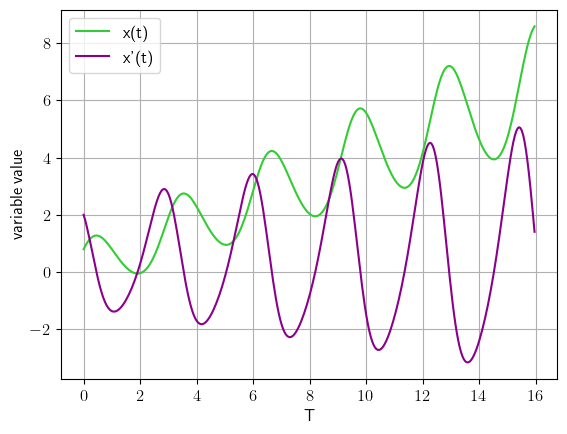

In [11]:
plt.plot(t, solution[:, 0], label = 'x(t)', color = 'limegreen')
plt.plot(t, solution[:, 1], label = "x'(t)", color = 'darkmagenta')
plt.grid(); plt.legend()
plt.xlabel('T'); plt.ylabel('variable value')
plt.show()

While it can be insightful to analyze the process with the data-driven differential equation, occasionally it will be needed to predict the future state of the system, based on the equation. In this experiment we will split the input dataset into train ($t \in [0, 8)$) and test ($t \in [8, 16)$) parts. To validate the predicitive ability, the best equation will be integrated over the domain, using internal automaitic differential equation solution methods.

In [12]:
def epde_discovery(t, x, use_ann = False):
    dimensionality = x.ndim - 1
    

    epde_search_obj = epde.EpdeSearch(use_solver = False, dimensionality = dimensionality, boundary = 30,
                                      coordinate_tensors = [t,])
    if use_ann:
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN', # use_smoothing = True poly
                                         preprocessor_kwargs={'epochs_max' : 50000})# 
    else:
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly', # use_smoothing = True poly
                                         preprocessor_kwargs={'use_smoothing' : False, 'sigma' : 1, 
                                                              'polynomial_window' : 3, 'poly_order' : 3}) 
                                                            # 'epochs_max' : 10000})
    eps = 5e-7
    popsize = 8
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=55)
    trig_tokens = epde.TrigonometricTokens(freq = (2 - eps, 2 + eps), 
                                      dimensionality = dimensionality)
    factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.65, 0.35]}

    custom_grid_tokens = epde.GridTokens(dimensionality = dimensionality)
    
    epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(2,),
                        equation_terms_max_number=6, data_fun_pow = 1, 
                        additional_tokens=[trig_tokens, custom_grid_tokens], 
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(1e-6, 1e-2))

    epde_search_obj.equations(only_print = True, num = 1)
    
    '''
    Having insight about the initial ODE structure, we are extracting the equation with complexity of 5
    
    In other cases, you should call epde_search_obj.equations(only_print = True), or epde_search_obj.
    where the algorithm presents Pareto frontier of optimal equations.
    '''

    return epde_search_obj#, sys

In [13]:
t_max = 160
t_train = t[:t_max]; t_test = t[t_max:] 
x_train = solution[:t_max, 0]; x_test = solution[t_max:, 0]

epde_search_obj = epde_discovery(t_train, x_train, True)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc2a3d8ec10>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc2a3d8ec10>
trig_token_params: VALUES = (0, 0)
OrderedDict([('power', (1, 1)), ('dim', (0, 0))])
Deriv orders after definition [[None], [0], [0, 0]]
Surface training t=0, loss=1.7990225553512573
Surface training t=1, loss=1.8131141662597656
Surface training t=2, loss=1.7578985691070557
Surface training t=3, loss=1.5566731691360474
Surface training t=4, loss=1.3224471807479858
Surface training t=5, loss=1.385497272014618
Surface training t=6, loss=1.184685230255127
Surface training t=7, loss=1.4168425798416138
Surface training t=8, loss=1.114406406879425
Surface training t=9, loss=1.1087956428527832
Surface training t=10, loss=1.0506973266601562
Surface training t=11, loss=0.9811845123767853
Surface training t=12, loss=0.9262374639511108
Surface training t=13, loss=0.9413429796695709
Surface training t=14, loss=0.920005828142

Surface training t=169, loss=0.6370554566383362
Surface training t=170, loss=0.66035595536232
Surface training t=171, loss=0.6581906378269196
Surface training t=172, loss=0.659743458032608
Surface training t=173, loss=0.6508230268955231
Surface training t=174, loss=0.6261791288852692
Surface training t=175, loss=0.6695259511470795
Surface training t=176, loss=0.6738834083080292
Surface training t=177, loss=0.6764930188655853
Surface training t=178, loss=0.6652790904045105
Surface training t=179, loss=0.6686897873878479
Surface training t=180, loss=0.6368667483329773
Surface training t=181, loss=0.6528861820697784
Surface training t=182, loss=0.6375212073326111
Surface training t=183, loss=0.6372632086277008
Surface training t=184, loss=0.615152895450592
Surface training t=185, loss=0.62000373005867
Surface training t=186, loss=0.6528993844985962
Surface training t=187, loss=0.6062589883804321
Surface training t=188, loss=0.6800661087036133
Surface training t=189, loss=0.665074408054351

Surface training t=364, loss=0.5894012153148651
Surface training t=365, loss=0.5472942143678665
Surface training t=366, loss=0.6686316728591919
Surface training t=367, loss=0.6319419741630554
Surface training t=368, loss=0.5856652855873108
Surface training t=369, loss=0.6116368472576141
Surface training t=370, loss=0.601632833480835
Surface training t=371, loss=0.5509277135133743
Surface training t=372, loss=0.5591586977243423
Surface training t=373, loss=0.5642967224121094
Surface training t=374, loss=0.6166366338729858
Surface training t=375, loss=0.58680459856987
Surface training t=376, loss=0.5854347050189972
Surface training t=377, loss=0.6366207599639893
Surface training t=378, loss=0.5813664495944977
Surface training t=379, loss=0.554141566157341
Surface training t=380, loss=0.5916029214859009
Surface training t=381, loss=0.6013985276222229
Surface training t=382, loss=0.6195979416370392
Surface training t=383, loss=0.609467625617981
Surface training t=384, loss=0.60790693759918

Surface training t=554, loss=0.5118075609207153
Surface training t=555, loss=0.5915101766586304
Surface training t=556, loss=0.5733069479465485
Surface training t=557, loss=0.5138987898826599
Surface training t=558, loss=0.5365256369113922
Surface training t=559, loss=0.5554095506668091
Surface training t=560, loss=0.5583444833755493
Surface training t=561, loss=0.5562171936035156
Surface training t=562, loss=0.5522742867469788
Surface training t=563, loss=0.58156818151474
Surface training t=564, loss=0.5294940769672394
Surface training t=565, loss=0.5782439708709717
Surface training t=566, loss=0.5582031309604645
Surface training t=567, loss=0.5546182096004486
Surface training t=568, loss=0.5511269569396973
Surface training t=569, loss=0.6009459793567657
Surface training t=570, loss=0.5331869423389435
Surface training t=571, loss=0.5536606013774872
Surface training t=572, loss=0.6154058277606964
Surface training t=573, loss=0.5473472476005554
Surface training t=574, loss=0.57968369126

Surface training t=756, loss=0.497611403465271
Surface training t=757, loss=0.586790919303894
Surface training t=758, loss=0.5125111043453217
Surface training t=759, loss=0.5030863434076309
Surface training t=760, loss=0.5211784839630127
Surface training t=761, loss=0.5653985738754272
Surface training t=762, loss=0.5326221883296967
Surface training t=763, loss=0.5196648985147476
Surface training t=764, loss=0.5091639161109924
Surface training t=765, loss=0.5632910132408142
Surface training t=766, loss=0.5240622460842133
Surface training t=767, loss=0.5991486310958862
Surface training t=768, loss=0.5553862750530243
Surface training t=769, loss=0.5675633549690247
Surface training t=770, loss=0.5607017576694489
Surface training t=771, loss=0.5423870980739594
Surface training t=772, loss=0.5841737687587738
Surface training t=773, loss=0.6074589341878891
Surface training t=774, loss=0.5910274386405945
Surface training t=775, loss=0.49783340096473694
Surface training t=776, loss=0.4971002042

Surface training t=928, loss=0.5479622483253479
Surface training t=929, loss=0.5383400022983551
Surface training t=930, loss=0.5369382202625275
Surface training t=931, loss=0.5246416926383972
Surface training t=932, loss=0.5214453637599945
Surface training t=933, loss=0.5514965653419495
Surface training t=934, loss=0.5778910517692566
Surface training t=935, loss=0.513230562210083
Surface training t=936, loss=0.5206217765808105
Surface training t=937, loss=0.5359707176685333
Surface training t=938, loss=0.5515777170658112
Surface training t=939, loss=0.5685801804065704
Surface training t=940, loss=0.5534666180610657
Surface training t=941, loss=0.5271584391593933
Surface training t=942, loss=0.5200696587562561
Surface training t=943, loss=0.5043113827705383
Surface training t=944, loss=0.5126006156206131
Surface training t=945, loss=0.49672412872314453
Surface training t=946, loss=0.5444507300853729
Surface training t=947, loss=0.48953238129615784
Surface training t=948, loss=0.55084443

Surface training t=1097, loss=0.48699067533016205
Surface training t=1098, loss=0.5373294353485107
Surface training t=1099, loss=0.5083602517843246
Surface training t=1100, loss=0.49394360184669495
Surface training t=1101, loss=0.5241824686527252
Surface training t=1102, loss=0.5438863784074783
Surface training t=1103, loss=0.5227469503879547
Surface training t=1104, loss=0.4773707240819931
Surface training t=1105, loss=0.49964794516563416
Surface training t=1106, loss=0.5306713283061981
Surface training t=1107, loss=0.5066404640674591
Surface training t=1108, loss=0.5305271446704865
Surface training t=1109, loss=0.48593829572200775
Surface training t=1110, loss=0.4951908141374588
Surface training t=1111, loss=0.5327684283256531
Surface training t=1112, loss=0.605575680732727
Surface training t=1113, loss=0.5161862969398499
Surface training t=1114, loss=0.4726985692977905
Surface training t=1115, loss=0.4895114302635193
Surface training t=1116, loss=0.5490756183862686
Surface training 

Surface training t=1300, loss=0.4463192820549011
Surface training t=1301, loss=0.524229884147644
Surface training t=1302, loss=0.4685419350862503
Surface training t=1303, loss=0.4917188137769699
Surface training t=1304, loss=0.4416518360376358
Surface training t=1305, loss=0.5196977853775024
Surface training t=1306, loss=0.42574548721313477
Surface training t=1307, loss=0.5164859145879745
Surface training t=1308, loss=0.4188542366027832
Surface training t=1309, loss=0.48282667994499207
Surface training t=1310, loss=0.45746955275535583
Surface training t=1311, loss=0.4425613731145859
Surface training t=1312, loss=0.4908311814069748
Surface training t=1313, loss=0.4674996882677078
Surface training t=1314, loss=0.4787892997264862
Surface training t=1315, loss=0.47809170186519623
Surface training t=1316, loss=0.4537012428045273
Surface training t=1317, loss=0.5423014461994171
Surface training t=1318, loss=0.5047796666622162
Surface training t=1319, loss=0.4295056611299515
Surface training 

Surface training t=1507, loss=0.3755776584148407
Surface training t=1508, loss=0.39710569381713867
Surface training t=1509, loss=0.3971175402402878
Surface training t=1510, loss=0.3585428446531296
Surface training t=1511, loss=0.41253049671649933
Surface training t=1512, loss=0.3550756275653839
Surface training t=1513, loss=0.4079718589782715
Surface training t=1514, loss=0.3936362564563751
Surface training t=1515, loss=0.41814251244068146
Surface training t=1516, loss=0.3422509729862213
Surface training t=1517, loss=0.384815514087677
Surface training t=1518, loss=0.3871956914663315
Surface training t=1519, loss=0.4029916077852249
Surface training t=1520, loss=0.4030190706253052
Surface training t=1521, loss=0.4166298657655716
Surface training t=1522, loss=0.3391095846891403
Surface training t=1523, loss=0.37862055003643036
Surface training t=1524, loss=0.33442074060440063
Surface training t=1525, loss=0.39340798556804657
Surface training t=1526, loss=0.4020911604166031
Surface trainin

Surface training t=1708, loss=0.34053289890289307
Surface training t=1709, loss=0.32697418332099915
Surface training t=1710, loss=0.44352225959300995
Surface training t=1711, loss=0.35726073384284973
Surface training t=1712, loss=0.34368081390857697
Surface training t=1713, loss=0.36310337483882904
Surface training t=1714, loss=0.3411330282688141
Surface training t=1715, loss=0.38026779890060425
Surface training t=1716, loss=0.35049737989902496
Surface training t=1717, loss=0.3249776065349579
Surface training t=1718, loss=0.4020821750164032
Surface training t=1719, loss=0.30337195098400116
Surface training t=1720, loss=0.33099164068698883
Surface training t=1721, loss=0.3485832065343857
Surface training t=1722, loss=0.38200370967388153
Surface training t=1723, loss=0.36544768512248993
Surface training t=1724, loss=0.35641907155513763
Surface training t=1725, loss=0.3683158904314041
Surface training t=1726, loss=0.3926652520895004
Surface training t=1727, loss=0.39872442185878754
Surfac

Surface training t=1908, loss=0.3514586240053177
Surface training t=1909, loss=0.2985634207725525
Surface training t=1910, loss=0.3605317175388336
Surface training t=1911, loss=0.313639834523201
Surface training t=1912, loss=0.30266711115837097
Surface training t=1913, loss=0.3684265911579132
Surface training t=1914, loss=0.28048352897167206
Surface training t=1915, loss=0.26653286814689636
Surface training t=1916, loss=0.32738369703292847
Surface training t=1917, loss=0.36385150253772736
Surface training t=1918, loss=0.32568536698818207
Surface training t=1919, loss=0.2991192489862442
Surface training t=1920, loss=0.27426037937402725
Surface training t=1921, loss=0.3804599195718765
Surface training t=1922, loss=0.36490705609321594
Surface training t=1923, loss=0.3611217141151428
Surface training t=1924, loss=0.29137181490659714
Surface training t=1925, loss=0.3744473457336426
Surface training t=1926, loss=0.31118154525756836
Surface training t=1927, loss=0.31998519599437714
Surface tr

Surface training t=2118, loss=0.3251737803220749
Surface training t=2119, loss=0.29317228496074677
Surface training t=2120, loss=0.3097432106733322
Surface training t=2121, loss=0.3593062162399292
Surface training t=2122, loss=0.2950942665338516
Surface training t=2123, loss=0.3399495333433151
Surface training t=2124, loss=0.35495397448539734
Surface training t=2125, loss=0.36020827293395996
Surface training t=2126, loss=0.30673231184482574
Surface training t=2127, loss=0.32895995676517487
Surface training t=2128, loss=0.369504451751709
Surface training t=2129, loss=0.32074330747127533
Surface training t=2130, loss=0.3450959771871567
Surface training t=2131, loss=0.38113294541835785
Surface training t=2132, loss=0.331090584397316
Surface training t=2133, loss=0.35548993945121765
Surface training t=2134, loss=0.3216164708137512
Surface training t=2135, loss=0.34569495916366577
Surface training t=2136, loss=0.3105151951313019
Surface training t=2137, loss=0.2772979140281677
Surface train

Surface training t=2311, loss=0.33763696253299713
Surface training t=2312, loss=0.33561548590660095
Surface training t=2313, loss=0.3053230792284012
Surface training t=2314, loss=0.267988458275795
Surface training t=2315, loss=0.29470811784267426
Surface training t=2316, loss=0.39958471059799194
Surface training t=2317, loss=0.288304440677166
Surface training t=2318, loss=0.27135972678661346
Surface training t=2319, loss=0.3085584342479706
Surface training t=2320, loss=0.3025655150413513
Surface training t=2321, loss=0.2837563082575798
Surface training t=2322, loss=0.33521319925785065
Surface training t=2323, loss=0.29486221075057983
Surface training t=2324, loss=0.25679516792297363
Surface training t=2325, loss=0.28506291657686234
Surface training t=2326, loss=0.32036715745925903
Surface training t=2327, loss=0.2590246871113777
Surface training t=2328, loss=0.2917168289422989
Surface training t=2329, loss=0.26692619174718857
Surface training t=2330, loss=0.2738765627145767
Surface tra

Surface training t=2495, loss=0.3348243683576584
Surface training t=2496, loss=0.29864178597927094
Surface training t=2497, loss=0.2986721396446228
Surface training t=2498, loss=0.25713758915662766
Surface training t=2499, loss=0.27660535275936127
Surface training t=2500, loss=0.26365552842617035
Surface training t=2501, loss=0.25107090920209885
Surface training t=2502, loss=0.2944274991750717
Surface training t=2503, loss=0.2707360163331032
Surface training t=2504, loss=0.2782408744096756
Surface training t=2505, loss=0.32049688696861267
Surface training t=2506, loss=0.31118637323379517
Surface training t=2507, loss=0.30793535709381104
Surface training t=2508, loss=0.28354933112859726
Surface training t=2509, loss=0.2794036790728569
Surface training t=2510, loss=0.3168288469314575
Surface training t=2511, loss=0.3107856810092926
Surface training t=2512, loss=0.290975958108902
Surface training t=2513, loss=0.29554735124111176
Surface training t=2514, loss=0.30236954987049103
Surface tr

Surface training t=2677, loss=0.3077230006456375
Surface training t=2678, loss=0.331710085272789
Surface training t=2679, loss=0.2642255797982216
Surface training t=2680, loss=0.3816778063774109
Surface training t=2681, loss=0.2758730947971344
Surface training t=2682, loss=0.3106381595134735
Surface training t=2683, loss=0.3454800546169281
Surface training t=2684, loss=0.31534285843372345
Surface training t=2685, loss=0.323286309838295
Surface training t=2686, loss=0.2625236213207245
Surface training t=2687, loss=0.345215767621994
Surface training t=2688, loss=0.2642463520169258
Surface training t=2689, loss=0.2617942690849304
Surface training t=2690, loss=0.3083130121231079
Surface training t=2691, loss=0.2698153629899025
Surface training t=2692, loss=0.26526162028312683
Surface training t=2693, loss=0.3277037441730499
Surface training t=2694, loss=0.2676865980029106
Surface training t=2695, loss=0.33657628297805786
Surface training t=2696, loss=0.31878459453582764
Surface training t=

Surface training t=2866, loss=0.3211449235677719
Surface training t=2867, loss=0.28730493783950806
Surface training t=2868, loss=0.300278976559639
Surface training t=2869, loss=0.33247728645801544
Surface training t=2870, loss=0.32463112473487854
Surface training t=2871, loss=0.2770814374089241
Surface training t=2872, loss=0.31401515007019043
Surface training t=2873, loss=0.2802678495645523
Surface training t=2874, loss=0.2800814360380173
Surface training t=2875, loss=0.31340374052524567
Surface training t=2876, loss=0.28066347539424896
Surface training t=2877, loss=0.24961864948272705
Surface training t=2878, loss=0.28589534759521484
Surface training t=2879, loss=0.3606151342391968
Surface training t=2880, loss=0.31601661443710327
Surface training t=2881, loss=0.30253078043460846
Surface training t=2882, loss=0.30625689029693604
Surface training t=2883, loss=0.2720758318901062
Surface training t=2884, loss=0.2729172110557556
Surface training t=2885, loss=0.3084390014410019
Surface tr

Surface training t=3038, loss=0.3069761395454407
Surface training t=3039, loss=0.2693880796432495
Surface training t=3040, loss=0.37748146057128906
Surface training t=3041, loss=0.342402383685112
Surface training t=3042, loss=0.28405965864658356
Surface training t=3043, loss=0.2732120528817177
Surface training t=3044, loss=0.3005674481391907
Surface training t=3045, loss=0.32076840102672577
Surface training t=3046, loss=0.2563549727201462
Surface training t=3047, loss=0.3131556212902069
Surface training t=3048, loss=0.264472134411335
Surface training t=3049, loss=0.24309735745191574
Surface training t=3050, loss=0.29267579317092896
Surface training t=3051, loss=0.313258558511734
Surface training t=3052, loss=0.291311115026474
Surface training t=3053, loss=0.2763591781258583
Surface training t=3054, loss=0.3052692860364914
Surface training t=3055, loss=0.3031222075223923
Surface training t=3056, loss=0.3131136894226074
Surface training t=3057, loss=0.2883233428001404
Surface training t=

Surface training t=3230, loss=0.30899475514888763
Surface training t=3231, loss=0.24204372614622116
Surface training t=3232, loss=0.3037969619035721
Surface training t=3233, loss=0.3152558207511902
Surface training t=3234, loss=0.29090356826782227
Surface training t=3235, loss=0.32567840814590454
Surface training t=3236, loss=0.2849165350198746
Surface training t=3237, loss=0.28215326368808746
Surface training t=3238, loss=0.28143783658742905
Surface training t=3239, loss=0.26163581758737564
Surface training t=3240, loss=0.28685256838798523
Surface training t=3241, loss=0.30837270617485046
Surface training t=3242, loss=0.31417666375637054
Surface training t=3243, loss=0.2822060286998749
Surface training t=3244, loss=0.2584894448518753
Surface training t=3245, loss=0.28848588466644287
Surface training t=3246, loss=0.30566686391830444
Surface training t=3247, loss=0.3519968092441559
Surface training t=3248, loss=0.2811438888311386
Surface training t=3249, loss=0.30949896574020386
Surface

Surface training t=3413, loss=0.2938389182090759
Surface training t=3414, loss=0.32523414492607117
Surface training t=3415, loss=0.281139612197876
Surface training t=3416, loss=0.3082125782966614
Surface training t=3417, loss=0.2118426449596882
Surface training t=3418, loss=0.2859935462474823
Surface training t=3419, loss=0.2837582975625992
Surface training t=3420, loss=0.283080592751503
Surface training t=3421, loss=0.32768790423870087
Surface training t=3422, loss=0.2748270332813263
Surface training t=3423, loss=0.3165404945611954
Surface training t=3424, loss=0.2831988036632538
Surface training t=3425, loss=0.287736639380455
Surface training t=3426, loss=0.31541331112384796
Surface training t=3427, loss=0.31141892075538635
Surface training t=3428, loss=0.2910214066505432
Surface training t=3429, loss=0.2777353376150131
Surface training t=3430, loss=0.2872319370508194
Surface training t=3431, loss=0.28295059502124786
Surface training t=3432, loss=0.29477453231811523
Surface training 

Surface training t=3598, loss=0.27667008340358734
Surface training t=3599, loss=0.29018500447273254
Surface training t=3600, loss=0.3127361834049225
Surface training t=3601, loss=0.3201218843460083
Surface training t=3602, loss=0.32230545580387115
Surface training t=3603, loss=0.2985987067222595
Surface training t=3604, loss=0.2750933766365051
Surface training t=3605, loss=0.24366946518421173
Surface training t=3606, loss=0.33193284273147583
Surface training t=3607, loss=0.28306326270103455
Surface training t=3608, loss=0.28318609297275543
Surface training t=3609, loss=0.2754274904727936
Surface training t=3610, loss=0.24588269740343094
Surface training t=3611, loss=0.31113968789577484
Surface training t=3612, loss=0.32304224371910095
Surface training t=3613, loss=0.2766723036766052
Surface training t=3614, loss=0.2998044490814209
Surface training t=3615, loss=0.30776575207710266
Surface training t=3616, loss=0.24718531966209412
Surface training t=3617, loss=0.31447990238666534
Surface

Surface training t=3770, loss=0.30939891934394836
Surface training t=3771, loss=0.30763834714889526
Surface training t=3772, loss=0.279719278216362
Surface training t=3773, loss=0.2757779210805893
Surface training t=3774, loss=0.2524944767355919
Surface training t=3775, loss=0.29296453297138214
Surface training t=3776, loss=0.3002747744321823
Surface training t=3777, loss=0.2772265076637268
Surface training t=3778, loss=0.33821822702884674
Surface training t=3779, loss=0.3483564853668213
Surface training t=3780, loss=0.3184637129306793
Surface training t=3781, loss=0.2873469591140747
Surface training t=3782, loss=0.2329183742403984
Surface training t=3783, loss=0.2734324187040329
Surface training t=3784, loss=0.34683191031217575
Surface training t=3785, loss=0.26197610795497894
Surface training t=3786, loss=0.3385683447122574
Surface training t=3787, loss=0.272401824593544
Surface training t=3788, loss=0.24380813539028168
Surface training t=3789, loss=0.2583211213350296
Surface trainin

Surface training t=3945, loss=0.3187754452228546
Surface training t=3946, loss=0.2722576856613159
Surface training t=3947, loss=0.31314100325107574
Surface training t=3948, loss=0.2668258175253868
Surface training t=3949, loss=0.33262117207050323
Surface training t=3950, loss=0.3189293444156647
Surface training t=3951, loss=0.26273880898952484
Surface training t=3952, loss=0.2909955531358719
Surface training t=3953, loss=0.3061550706624985
Surface training t=3954, loss=0.2751869261264801
Surface training t=3955, loss=0.2671491205692291
Surface training t=3956, loss=0.31231652200222015
Surface training t=3957, loss=0.3242340534925461
Surface training t=3958, loss=0.29716913402080536
Surface training t=3959, loss=0.2536557912826538
Surface training t=3960, loss=0.2768676280975342
Surface training t=3961, loss=0.32442180812358856
Surface training t=3962, loss=0.30824606120586395
Surface training t=3963, loss=0.29129478335380554
Surface training t=3964, loss=0.27420568466186523
Surface tra

Surface training t=4115, loss=0.2984057366847992
Surface training t=4116, loss=0.2727040648460388
Surface training t=4117, loss=0.22410158812999725
Surface training t=4118, loss=0.28156356513500214
Surface training t=4119, loss=0.3210989683866501
Surface training t=4120, loss=0.27542583644390106
Surface training t=4121, loss=0.28601953387260437
Surface training t=4122, loss=0.28394830226898193
Surface training t=4123, loss=0.2558678984642029
Surface training t=4124, loss=0.30493126809597015
Surface training t=4125, loss=0.2795155793428421
Surface training t=4126, loss=0.27849507331848145
Surface training t=4127, loss=0.36180219054222107
Surface training t=4128, loss=0.2587029039859772
Surface training t=4129, loss=0.33018670976161957
Surface training t=4130, loss=0.24475882202386856
Surface training t=4131, loss=0.2555679902434349
Surface training t=4132, loss=0.24111859500408173
Surface training t=4133, loss=0.2872098237276077
Surface training t=4134, loss=0.3258369117975235
Surface t

Surface training t=4285, loss=0.25503673404455185
Surface training t=4286, loss=0.3035255968570709
Surface training t=4287, loss=0.3258064538240433
Surface training t=4288, loss=0.2969043701887131
Surface training t=4289, loss=0.31148189306259155
Surface training t=4290, loss=0.32504162192344666
Surface training t=4291, loss=0.23373838514089584
Surface training t=4292, loss=0.2675646096467972
Surface training t=4293, loss=0.25764647871255875
Surface training t=4294, loss=0.30435483157634735
Surface training t=4295, loss=0.2604311406612396
Surface training t=4296, loss=0.29713280498981476
Surface training t=4297, loss=0.2631184533238411
Surface training t=4298, loss=0.2978081852197647
Surface training t=4299, loss=0.27387969195842743
Surface training t=4300, loss=0.28077809512615204
Surface training t=4301, loss=0.26450659334659576
Surface training t=4302, loss=0.282233402132988
Surface training t=4303, loss=0.2911505699157715
Surface training t=4304, loss=0.2760279029607773
Surface tra

Surface training t=4458, loss=0.3023066222667694
Surface training t=4459, loss=0.2875206023454666
Surface training t=4460, loss=0.3204481899738312
Surface training t=4461, loss=0.28991709649562836
Surface training t=4462, loss=0.28252744674682617
Surface training t=4463, loss=0.25827840715646744
Surface training t=4464, loss=0.2583259493112564
Surface training t=4465, loss=0.27840980887413025
Surface training t=4466, loss=0.2759838253259659
Surface training t=4467, loss=0.25522397458553314
Surface training t=4468, loss=0.28712978959083557
Surface training t=4469, loss=0.29410320520401
Surface training t=4470, loss=0.26055801659822464
Surface training t=4471, loss=0.3253132998943329
Surface training t=4472, loss=0.26124102622270584
Surface training t=4473, loss=0.27921001613140106
Surface training t=4474, loss=0.2984403520822525
Surface training t=4475, loss=0.23035161197185516
Surface training t=4476, loss=0.3064667880535126
Surface training t=4477, loss=0.2929108142852783
Surface trai

Surface training t=4628, loss=0.23922964185476303
Surface training t=4629, loss=0.2699940651655197
Surface training t=4630, loss=0.2763316333293915
Surface training t=4631, loss=0.30268242955207825
Surface training t=4632, loss=0.23198402673006058
Surface training t=4633, loss=0.26361190527677536
Surface training t=4634, loss=0.2508872225880623
Surface training t=4635, loss=0.30892717093229294
Surface training t=4636, loss=0.27957883477211
Surface training t=4637, loss=0.26219357550144196
Surface training t=4638, loss=0.2801026850938797
Surface training t=4639, loss=0.2945397347211838
Surface training t=4640, loss=0.27192364633083344
Surface training t=4641, loss=0.29467199742794037
Surface training t=4642, loss=0.23657195270061493
Surface training t=4643, loss=0.289421871304512
Surface training t=4644, loss=0.2897961139678955
Surface training t=4645, loss=0.25800684094429016
Surface training t=4646, loss=0.2526077851653099
Surface training t=4647, loss=0.2429158240556717
Surface train

Surface training t=4797, loss=0.25435561686754227
Surface training t=4798, loss=0.22469033300876617
Surface training t=4799, loss=0.24328237026929855
Surface training t=4800, loss=0.2965468466281891
Surface training t=4801, loss=0.24654670804738998
Surface training t=4802, loss=0.2723153233528137
Surface training t=4803, loss=0.28398893773555756
Surface training t=4804, loss=0.2398996278643608
Surface training t=4805, loss=0.2921566665172577
Surface training t=4806, loss=0.3029051646590233
Surface training t=4807, loss=0.24551550298929214
Surface training t=4808, loss=0.2876449376344681
Surface training t=4809, loss=0.24776509404182434
Surface training t=4810, loss=0.2503400593996048
Surface training t=4811, loss=0.23409493267536163
Surface training t=4812, loss=0.2987380623817444
Surface training t=4813, loss=0.2314848005771637
Surface training t=4814, loss=0.27915868163108826
Surface training t=4815, loss=0.2842487543821335
Surface training t=4816, loss=0.2894486337900162
Surface tra

Surface training t=4970, loss=0.29547715187072754
Surface training t=4971, loss=0.23132728040218353
Surface training t=4972, loss=0.27484946697950363
Surface training t=4973, loss=0.28219057619571686
Surface training t=4974, loss=0.2893569767475128
Surface training t=4975, loss=0.2806306779384613
Surface training t=4976, loss=0.24977196007966995
Surface training t=4977, loss=0.3164876848459244
Surface training t=4978, loss=0.26460471749305725
Surface training t=4979, loss=0.276095986366272
Surface training t=4980, loss=0.25891517102718353
Surface training t=4981, loss=0.3071962893009186
Surface training t=4982, loss=0.28327202796936035
Surface training t=4983, loss=0.31056591868400574
Surface training t=4984, loss=0.3032483905553818
Surface training t=4985, loss=0.2664027512073517
Surface training t=4986, loss=0.2851247191429138
Surface training t=4987, loss=0.28901511430740356
Surface training t=4988, loss=0.2650177925825119
Surface training t=4989, loss=0.2800746560096741
Surface tra

Surface training t=5142, loss=0.23656867444515228
Surface training t=5143, loss=0.2941354960203171
Surface training t=5144, loss=0.3099744990468025
Surface training t=5145, loss=0.2278175950050354
Surface training t=5146, loss=0.23434167355298996
Surface training t=5147, loss=0.26102951169013977
Surface training t=5148, loss=0.22066929191350937
Surface training t=5149, loss=0.26328716427087784
Surface training t=5150, loss=0.24487905949354172
Surface training t=5151, loss=0.29987862706184387
Surface training t=5152, loss=0.2378603145480156
Surface training t=5153, loss=0.26667720079421997
Surface training t=5154, loss=0.23031292855739594
Surface training t=5155, loss=0.27661558985710144
Surface training t=5156, loss=0.2505528926849365
Surface training t=5157, loss=0.21534383296966553
Surface training t=5158, loss=0.21514656394720078
Surface training t=5159, loss=0.22359966486692429
Surface training t=5160, loss=0.28136956691741943
Surface training t=5161, loss=0.20017749443650246
Surfa

Surface training t=5313, loss=0.24980909377336502
Surface training t=5314, loss=0.2796345502138138
Surface training t=5315, loss=0.30445705354213715
Surface training t=5316, loss=0.26691508293151855
Surface training t=5317, loss=0.2809239327907562
Surface training t=5318, loss=0.22631371021270752
Surface training t=5319, loss=0.2542077600955963
Surface training t=5320, loss=0.26238715648651123
Surface training t=5321, loss=0.20870483666658401
Surface training t=5322, loss=0.26021744310855865
Surface training t=5323, loss=0.25036997348070145
Surface training t=5324, loss=0.2353745773434639
Surface training t=5325, loss=0.24961517751216888
Surface training t=5326, loss=0.2527858316898346
Surface training t=5327, loss=0.2518702819943428
Surface training t=5328, loss=0.25051233172416687
Surface training t=5329, loss=0.2982424199581146
Surface training t=5330, loss=0.2577976733446121
Surface training t=5331, loss=0.2725785821676254
Surface training t=5332, loss=0.2856648489832878
Surface tr

Surface training t=5491, loss=0.20589207112789154
Surface training t=5492, loss=0.22527813911437988
Surface training t=5493, loss=0.20680604130029678
Surface training t=5494, loss=0.18940019607543945
Surface training t=5495, loss=0.21301378309726715
Surface training t=5496, loss=0.23742851614952087
Surface training t=5497, loss=0.2797912508249283
Surface training t=5498, loss=0.20346856117248535
Surface training t=5499, loss=0.24039634317159653
Surface training t=5500, loss=0.2111036777496338
Surface training t=5501, loss=0.23272616416215897
Surface training t=5502, loss=0.26990893483161926
Surface training t=5503, loss=0.23005133867263794
Surface training t=5504, loss=0.2151542231440544
Surface training t=5505, loss=0.26564544439315796
Surface training t=5506, loss=0.23201368004083633
Surface training t=5507, loss=0.24761667102575302
Surface training t=5508, loss=0.22985995560884476
Surface training t=5509, loss=0.24250461161136627
Surface training t=5510, loss=0.23308951407670975
Sur

Surface training t=5690, loss=0.1748909167945385
Surface training t=5691, loss=0.17511258274316788
Surface training t=5692, loss=0.2311124950647354
Surface training t=5693, loss=0.20559563487768173
Surface training t=5694, loss=0.18919511139392853
Surface training t=5695, loss=0.19650880992412567
Surface training t=5696, loss=0.22568842768669128
Surface training t=5697, loss=0.22757863253355026
Surface training t=5698, loss=0.2203717976808548
Surface training t=5699, loss=0.17849769443273544
Surface training t=5700, loss=0.21664920449256897
Surface training t=5701, loss=0.19978364557027817
Surface training t=5702, loss=0.19887124001979828
Surface training t=5703, loss=0.2219744399189949
Surface training t=5704, loss=0.22153615951538086
Surface training t=5705, loss=0.2015853002667427
Surface training t=5706, loss=0.1985175833106041
Surface training t=5707, loss=0.17998698353767395
Surface training t=5708, loss=0.1845497488975525
Surface training t=5709, loss=0.20629353821277618
Surface

Surface training t=5883, loss=0.16981283575296402
Surface training t=5884, loss=0.18145961314439774
Surface training t=5885, loss=0.2068048119544983
Surface training t=5886, loss=0.1925317496061325
Surface training t=5887, loss=0.1623925119638443
Surface training t=5888, loss=0.19041044265031815
Surface training t=5889, loss=0.19795560091733932
Surface training t=5890, loss=0.2198139652609825
Surface training t=5891, loss=0.17660941183567047
Surface training t=5892, loss=0.1959541290998459
Surface training t=5893, loss=0.2136962041258812
Surface training t=5894, loss=0.1957157701253891
Surface training t=5895, loss=0.2186487391591072
Surface training t=5896, loss=0.19295217096805573
Surface training t=5897, loss=0.17881735414266586
Surface training t=5898, loss=0.18969155848026276
Surface training t=5899, loss=0.2015654295682907
Surface training t=5900, loss=0.19897881895303726
Surface training t=5901, loss=0.17108265310525894
Surface training t=5902, loss=0.19744102656841278
Surface t

Surface training t=6071, loss=0.14800138771533966
Surface training t=6072, loss=0.14740774035453796
Surface training t=6073, loss=0.16439101845026016
Surface training t=6074, loss=0.14914023131132126
Surface training t=6075, loss=0.15860705822706223
Surface training t=6076, loss=0.1324852779507637
Surface training t=6077, loss=0.13567779958248138
Surface training t=6078, loss=0.14436611533164978
Surface training t=6079, loss=0.15946576744318008
Surface training t=6080, loss=0.15890637040138245
Surface training t=6081, loss=0.16108494997024536
Surface training t=6082, loss=0.1600620374083519
Surface training t=6083, loss=0.1681976541876793
Surface training t=6084, loss=0.14429921656847
Surface training t=6085, loss=0.15843313932418823
Surface training t=6086, loss=0.16127371788024902
Surface training t=6087, loss=0.13373839482665062
Surface training t=6088, loss=0.15406254678964615
Surface training t=6089, loss=0.15819676220417023
Surface training t=6090, loss=0.14473120868206024
Surfac

Surface training t=6244, loss=0.11551591753959656
Surface training t=6245, loss=0.10911810770630836
Surface training t=6246, loss=0.0971345528960228
Surface training t=6247, loss=0.1266201063990593
Surface training t=6248, loss=0.1145688146352768
Surface training t=6249, loss=0.09895702451467514
Surface training t=6250, loss=0.10073695704340935
Surface training t=6251, loss=0.09940418228507042
Surface training t=6252, loss=0.094903364777565
Surface training t=6253, loss=0.10101139917969704
Surface training t=6254, loss=0.09964968264102936
Surface training t=6255, loss=0.08946939185261726
Surface training t=6256, loss=0.09700026363134384
Surface training t=6257, loss=0.11726191639900208
Surface training t=6258, loss=0.11860540509223938
Surface training t=6259, loss=0.10676810890436172
Surface training t=6260, loss=0.08242722600698471
Surface training t=6261, loss=0.09403026103973389
Surface training t=6262, loss=0.10360972955822945
Surface training t=6263, loss=0.09665567427873611
Surfa

Surface training t=6436, loss=0.09161785989999771
Surface training t=6437, loss=0.06572453677654266
Surface training t=6438, loss=0.07936779409646988
Surface training t=6439, loss=0.06777060031890869
Surface training t=6440, loss=0.06553016230463982
Surface training t=6441, loss=0.06416741013526917
Surface training t=6442, loss=0.05879737623035908
Surface training t=6443, loss=0.06248676776885986
Surface training t=6444, loss=0.05150662362575531
Surface training t=6445, loss=0.07140916958451271
Surface training t=6446, loss=0.057781510055065155
Surface training t=6447, loss=0.057395655661821365
Surface training t=6448, loss=0.054911430925130844
Surface training t=6449, loss=0.059701405465602875
Surface training t=6450, loss=0.051184266805648804
Surface training t=6451, loss=0.0578561145812273
Surface training t=6452, loss=0.04520450904965401
Surface training t=6453, loss=0.05425082705914974
Surface training t=6454, loss=0.060723522678017616
Surface training t=6455, loss=0.0638836957514

Surface training t=6621, loss=0.05071192421019077
Surface training t=6622, loss=0.049710292369127274
Surface training t=6623, loss=0.06293308734893799
Surface training t=6624, loss=0.06184845604002476
Surface training t=6625, loss=0.0816627275198698
Surface training t=6626, loss=0.053598133847117424
Surface training t=6627, loss=0.057686734944581985
Surface training t=6628, loss=0.04852961003780365
Surface training t=6629, loss=0.05413733795285225
Surface training t=6630, loss=0.04625058174133301
Surface training t=6631, loss=0.058587824925780296
Surface training t=6632, loss=0.0566122941672802
Surface training t=6633, loss=0.04941548407077789
Surface training t=6634, loss=0.04746539704501629
Surface training t=6635, loss=0.04303741827607155
Surface training t=6636, loss=0.04795796610414982
Surface training t=6637, loss=0.04488595202565193
Surface training t=6638, loss=0.04370053857564926
Surface training t=6639, loss=0.05003375746309757
Surface training t=6640, loss=0.0498017966747283

Surface training t=6817, loss=0.049526676535606384
Surface training t=6818, loss=0.05061887018382549
Surface training t=6819, loss=0.057691726833581924
Surface training t=6820, loss=0.054774876683950424
Surface training t=6821, loss=0.039795346558094025
Surface training t=6822, loss=0.04326806962490082
Surface training t=6823, loss=0.046626366674900055
Surface training t=6824, loss=0.04974407143890858
Surface training t=6825, loss=0.045765385031700134
Surface training t=6826, loss=0.03545151278376579
Surface training t=6827, loss=0.040686141699552536
Surface training t=6828, loss=0.04111388139426708
Surface training t=6829, loss=0.042115313932299614
Surface training t=6830, loss=0.03952084295451641
Surface training t=6831, loss=0.050254710018634796
Surface training t=6832, loss=0.050337621942162514
Surface training t=6833, loss=0.04643138684332371
Surface training t=6834, loss=0.03837776556611061
Surface training t=6835, loss=0.047958966344594955
Surface training t=6836, loss=0.0456751

Surface training t=6989, loss=0.04664035513997078
Surface training t=6990, loss=0.04231812432408333
Surface training t=6991, loss=0.040979184210300446
Surface training t=6992, loss=0.03606775403022766
Surface training t=6993, loss=0.04378270171582699
Surface training t=6994, loss=0.04198382794857025
Surface training t=6995, loss=0.04052140936255455
Surface training t=6996, loss=0.03651666082441807
Surface training t=6997, loss=0.042661821469664574
Surface training t=6998, loss=0.04434135742485523
Surface training t=6999, loss=0.0338289774954319
Surface training t=7000, loss=0.03350032866001129
Surface training t=7001, loss=0.030106551945209503
Surface training t=7002, loss=0.037390921264886856
Surface training t=7003, loss=0.043553777039051056
Surface training t=7004, loss=0.04866521805524826
Surface training t=7005, loss=0.05969940312206745
Surface training t=7006, loss=0.051405493170022964
Surface training t=7007, loss=0.05391479469835758
Surface training t=7008, loss=0.0455828569829

Surface training t=7156, loss=0.03812994249165058
Surface training t=7157, loss=0.05864703841507435
Surface training t=7158, loss=0.05822227895259857
Surface training t=7159, loss=0.052989380434155464
Surface training t=7160, loss=0.05598573386669159
Surface training t=7161, loss=0.04856277257204056
Surface training t=7162, loss=0.042648336850106716
Surface training t=7163, loss=0.048805808648467064
Surface training t=7164, loss=0.039715602062642574
Surface training t=7165, loss=0.04112702049314976
Surface training t=7166, loss=0.047033339738845825
Surface training t=7167, loss=0.032483896240592
Surface training t=7168, loss=0.03624388948082924
Surface training t=7169, loss=0.06490248069167137
Surface training t=7170, loss=0.05070890672504902
Surface training t=7171, loss=0.044157497584819794
Surface training t=7172, loss=0.03628603368997574
Surface training t=7173, loss=0.04081079550087452
Surface training t=7174, loss=0.05809949338436127
Surface training t=7175, loss=0.04506232589483

Surface training t=7353, loss=0.028914096765220165
Surface training t=7354, loss=0.025997734628617764
Surface training t=7355, loss=0.029077941551804543
Surface training t=7356, loss=0.03556934371590614
Surface training t=7357, loss=0.035289421677589417
Surface training t=7358, loss=0.02796236239373684
Surface training t=7359, loss=0.02995140850543976
Surface training t=7360, loss=0.025109472684562206
Surface training t=7361, loss=0.027039194479584694
Surface training t=7362, loss=0.0313057005405426
Surface training t=7363, loss=0.027562149800360203
Surface training t=7364, loss=0.03601265139877796
Surface training t=7365, loss=0.03002067282795906
Surface training t=7366, loss=0.02651730179786682
Surface training t=7367, loss=0.03076741099357605
Surface training t=7368, loss=0.030511658638715744
Surface training t=7369, loss=0.02652541734278202
Surface training t=7370, loss=0.036368584260344505
Surface training t=7371, loss=0.03279598895460367
Surface training t=7372, loss=0.0333078801

Surface training t=7537, loss=0.035330429673194885
Surface training t=7538, loss=0.033454157412052155
Surface training t=7539, loss=0.031195303425192833
Surface training t=7540, loss=0.03080151043832302
Surface training t=7541, loss=0.03031277935951948
Surface training t=7542, loss=0.032351499423384666
Surface training t=7543, loss=0.02988469786942005
Surface training t=7544, loss=0.032423495315015316
Surface training t=7545, loss=0.030663618817925453
Surface training t=7546, loss=0.02717564906924963
Surface training t=7547, loss=0.021488594822585583
Surface training t=7548, loss=0.0281726261600852
Surface training t=7549, loss=0.021352926269173622
Surface training t=7550, loss=0.025934995152056217
Surface training t=7551, loss=0.02710418775677681
Surface training t=7552, loss=0.027909310534596443
Surface training t=7553, loss=0.0253911092877388
Surface training t=7554, loss=0.02669618371874094
Surface training t=7555, loss=0.027440840378403664
Surface training t=7556, loss=0.030627635

Surface training t=7702, loss=0.02456844225525856
Surface training t=7703, loss=0.027563237585127354
Surface training t=7704, loss=0.02766199503093958
Surface training t=7705, loss=0.02850982453674078
Surface training t=7706, loss=0.026817291975021362
Surface training t=7707, loss=0.02614019066095352
Surface training t=7708, loss=0.030883971601724625
Surface training t=7709, loss=0.026286527514457703
Surface training t=7710, loss=0.021142669022083282
Surface training t=7711, loss=0.030836500227451324
Surface training t=7712, loss=0.02926691249012947
Surface training t=7713, loss=0.02880625892430544
Surface training t=7714, loss=0.025695642456412315
Surface training t=7715, loss=0.025814098306000233
Surface training t=7716, loss=0.04475984908640385
Surface training t=7717, loss=0.03613635152578354
Surface training t=7718, loss=0.03119599260389805
Surface training t=7719, loss=0.03702903911471367
Surface training t=7720, loss=0.04250742681324482
Surface training t=7721, loss=0.0288040870

Surface training t=7872, loss=0.028616417199373245
Surface training t=7873, loss=0.023440268822014332
Surface training t=7874, loss=0.02344999834895134
Surface training t=7875, loss=0.025654276832938194
Surface training t=7876, loss=0.0242508752271533
Surface training t=7877, loss=0.028819376602768898
Surface training t=7878, loss=0.0258219288662076
Surface training t=7879, loss=0.022219328209757805
Surface training t=7880, loss=0.02276644017547369
Surface training t=7881, loss=0.021248091012239456
Surface training t=7882, loss=0.020393251441419125
Surface training t=7883, loss=0.0193394273519516
Surface training t=7884, loss=0.02008596621453762
Surface training t=7885, loss=0.022367131896317005
Surface training t=7886, loss=0.021008911542594433
Surface training t=7887, loss=0.02484712563455105
Surface training t=7888, loss=0.03825966268777847
Surface training t=7889, loss=0.028987226076424122
Surface training t=7890, loss=0.029756836593151093
Surface training t=7891, loss=0.0232220171

Surface training t=8044, loss=0.02896967902779579
Surface training t=8045, loss=0.024829210713505745
Surface training t=8046, loss=0.026970610953867435
Surface training t=8047, loss=0.023610188625752926
Surface training t=8048, loss=0.025901460088789463
Surface training t=8049, loss=0.021807579323649406
Surface training t=8050, loss=0.02335297502577305
Surface training t=8051, loss=0.024146645329892635
Surface training t=8052, loss=0.04313691519200802
Surface training t=8053, loss=0.03265698812901974
Surface training t=8054, loss=0.05421123281121254
Surface training t=8055, loss=0.040797267109155655
Surface training t=8056, loss=0.04845949448645115
Surface training t=8057, loss=0.04436241462826729
Surface training t=8058, loss=0.041134532541036606
Surface training t=8059, loss=0.03696971293538809
Surface training t=8060, loss=0.03913871757686138
Surface training t=8061, loss=0.04715743660926819
Surface training t=8062, loss=0.030601991340517998
Surface training t=8063, loss=0.030030102

Surface training t=8218, loss=0.022999651730060577
Surface training t=8219, loss=0.019290789030492306
Surface training t=8220, loss=0.01795092597603798
Surface training t=8221, loss=0.019126114435493946
Surface training t=8222, loss=0.019033893011510372
Surface training t=8223, loss=0.016720375511795282
Surface training t=8224, loss=0.024190950207412243
Surface training t=8225, loss=0.029287314042448997
Surface training t=8226, loss=0.023837418295443058
Surface training t=8227, loss=0.020796998403966427
Surface training t=8228, loss=0.025996148586273193
Surface training t=8229, loss=0.03472044877707958
Surface training t=8230, loss=0.026838164776563644
Surface training t=8231, loss=0.028982446528971195
Surface training t=8232, loss=0.03521237336099148
Surface training t=8233, loss=0.030758339911699295
Surface training t=8234, loss=0.030504517257213593
Surface training t=8235, loss=0.026612287387251854
Surface training t=8236, loss=0.025242378003895283
Surface training t=8237, loss=0.02

Surface training t=8391, loss=0.0187592301517725
Surface training t=8392, loss=0.019348494708538055
Surface training t=8393, loss=0.01684211613610387
Surface training t=8394, loss=0.015541509725153446
Surface training t=8395, loss=0.022425826638936996
Surface training t=8396, loss=0.02565308753401041
Surface training t=8397, loss=0.017379263415932655
Surface training t=8398, loss=0.020216516219079494
Surface training t=8399, loss=0.02505834773182869
Surface training t=8400, loss=0.01791015826165676
Surface training t=8401, loss=0.021820757538080215
Surface training t=8402, loss=0.023305672220885754
Surface training t=8403, loss=0.03197340480983257
Surface training t=8404, loss=0.027334555983543396
Surface training t=8405, loss=0.02608928084373474
Surface training t=8406, loss=0.024051140993833542
Surface training t=8407, loss=0.016004406847059727
Surface training t=8408, loss=0.02740403078496456
Surface training t=8409, loss=0.025187810882925987
Surface training t=8410, loss=0.02961954

Surface training t=8568, loss=0.02375082205981016
Surface training t=8569, loss=0.01912327017635107
Surface training t=8570, loss=0.018468085676431656
Surface training t=8571, loss=0.019210882019251585
Surface training t=8572, loss=0.018426586873829365
Surface training t=8573, loss=0.017306786961853504
Surface training t=8574, loss=0.020253793336451054
Surface training t=8575, loss=0.019778224639594555
Surface training t=8576, loss=0.025876889005303383
Surface training t=8577, loss=0.029103158973157406
Surface training t=8578, loss=0.020065863616764545
Surface training t=8579, loss=0.03061703033745289
Surface training t=8580, loss=0.018298356793820858
Surface training t=8581, loss=0.021529068239033222
Surface training t=8582, loss=0.02178401965647936
Surface training t=8583, loss=0.01695441361516714
Surface training t=8584, loss=0.019384209997951984
Surface training t=8585, loss=0.018357462249696255
Surface training t=8586, loss=0.021411308087408543
Surface training t=8587, loss=0.0169

Surface training t=8740, loss=0.022331385873258114
Surface training t=8741, loss=0.02751789800822735
Surface training t=8742, loss=0.03568190336227417
Surface training t=8743, loss=0.025625595822930336
Surface training t=8744, loss=0.0358852818608284
Surface training t=8745, loss=0.025223687291145325
Surface training t=8746, loss=0.02343052066862583
Surface training t=8747, loss=0.03207744564861059
Surface training t=8748, loss=0.026073024608194828
Surface training t=8749, loss=0.029779125936329365
Surface training t=8750, loss=0.022873301059007645
Surface training t=8751, loss=0.038158392533659935
Surface training t=8752, loss=0.025435994379222393
Surface training t=8753, loss=0.026421766728162766
Surface training t=8754, loss=0.03499307297170162
Surface training t=8755, loss=0.0285336310043931
Surface training t=8756, loss=0.034254470840096474
Surface training t=8757, loss=0.029867117293179035
Surface training t=8758, loss=0.020838361233472824
Surface training t=8759, loss=0.03657609

Surface training t=8916, loss=0.05891288444399834
Surface training t=8917, loss=0.04581679217517376
Surface training t=8918, loss=0.039607640355825424
Surface training t=8919, loss=0.03941727988421917
Surface training t=8920, loss=0.04037152975797653
Surface training t=8921, loss=0.034284370951354504
Surface training t=8922, loss=0.03181846626102924
Surface training t=8923, loss=0.03518800437450409
Surface training t=8924, loss=0.029335636645555496
Surface training t=8925, loss=0.028916969895362854
Surface training t=8926, loss=0.03016361966729164
Surface training t=8927, loss=0.02752910740673542
Surface training t=8928, loss=0.02223614789545536
Surface training t=8929, loss=0.01964979711920023
Surface training t=8930, loss=0.018322834745049477
Surface training t=8931, loss=0.01834278367459774
Surface training t=8932, loss=0.01640469115227461
Surface training t=8933, loss=0.015022698789834976
Surface training t=8934, loss=0.014827003702521324
Surface training t=8935, loss=0.01553537929

Surface training t=9103, loss=0.03088117204606533
Surface training t=9104, loss=0.03447056468576193
Surface training t=9105, loss=0.03569216188043356
Surface training t=9106, loss=0.03874234762042761
Surface training t=9107, loss=0.04029036499559879
Surface training t=9108, loss=0.03010161779820919
Surface training t=9109, loss=0.020297052338719368
Surface training t=9110, loss=0.019195102155208588
Surface training t=9111, loss=0.026668480597436428
Surface training t=9112, loss=0.020371819380670786
Surface training t=9113, loss=0.018672008998692036
Surface training t=9114, loss=0.01539023406803608
Surface training t=9115, loss=0.013971098698675632
Surface training t=9116, loss=0.019692271947860718
Surface training t=9117, loss=0.016739082522690296
Surface training t=9118, loss=0.018794728443026543
Surface training t=9119, loss=0.03569156117737293
Surface training t=9120, loss=0.03296922892332077
Surface training t=9121, loss=0.026742669753730297
Surface training t=9122, loss=0.02342450

Surface training t=9283, loss=0.01696349633857608
Surface training t=9284, loss=0.02175518497824669
Surface training t=9285, loss=0.023173625580966473
Surface training t=9286, loss=0.017107957042753696
Surface training t=9287, loss=0.0351166557520628
Surface training t=9288, loss=0.030206510797142982
Surface training t=9289, loss=0.027504044584929943
Surface training t=9290, loss=0.07648044638335705
Surface training t=9291, loss=0.04505123756825924
Surface training t=9292, loss=0.069590013474226
Surface training t=9293, loss=0.055394042283296585
Surface training t=9294, loss=0.048898275941610336
Surface training t=9295, loss=0.06648139655590057
Surface training t=9296, loss=0.04107538051903248
Surface training t=9297, loss=0.04636634513735771
Surface training t=9298, loss=0.043606603518128395
Surface training t=9299, loss=0.03703904338181019
Surface training t=9300, loss=0.03200657572597265
Surface training t=9301, loss=0.03432418592274189
Surface training t=9302, loss=0.02074121963232

Surface training t=9460, loss=0.022968217730522156
Surface training t=9461, loss=0.021482620388269424
Surface training t=9462, loss=0.022915955632925034
Surface training t=9463, loss=0.026836834847927094
Surface training t=9464, loss=0.025912439450621605
Surface training t=9465, loss=0.029853373765945435
Surface training t=9466, loss=0.02392622735351324
Surface training t=9467, loss=0.030545970425009727
Surface training t=9468, loss=0.034621468745172024
Surface training t=9469, loss=0.027797012589871883
Surface training t=9470, loss=0.025363923981785774
Surface training t=9471, loss=0.02610159106552601
Surface training t=9472, loss=0.026824669912457466
Surface training t=9473, loss=0.031617349945008755
Surface training t=9474, loss=0.023912062868475914
Surface training t=9475, loss=0.01959665585309267
Surface training t=9476, loss=0.019661168567836285
Surface training t=9477, loss=0.025467190891504288
Surface training t=9478, loss=0.019311978481709957
Surface training t=9479, loss=0.02

Surface training t=9632, loss=0.024592075496912003
Surface training t=9633, loss=0.0533861368894577
Surface training t=9634, loss=0.03287524916231632
Surface training t=9635, loss=0.03884807042777538
Surface training t=9636, loss=0.03769296407699585
Surface training t=9637, loss=0.022910282481461763
Surface training t=9638, loss=0.03146801516413689
Surface training t=9639, loss=0.023924759589135647
Surface training t=9640, loss=0.029307757504284382
Surface training t=9641, loss=0.031110159121453762
Surface training t=9642, loss=0.04328026622533798
Surface training t=9643, loss=0.0384971909224987
Surface training t=9644, loss=0.02830238826572895
Surface training t=9645, loss=0.025274144485592842
Surface training t=9646, loss=0.02633999101817608
Surface training t=9647, loss=0.021922755986452103
Surface training t=9648, loss=0.016465090215206146
Surface training t=9649, loss=0.02091419044882059
Surface training t=9650, loss=0.02124488726258278
Surface training t=9651, loss=0.019414433278

Surface training t=9821, loss=0.050260597839951515
Surface training t=9822, loss=0.02747744508087635
Surface training t=9823, loss=0.03552832920104265
Surface training t=9824, loss=0.04441480338573456
Surface training t=9825, loss=0.04928378202021122
Surface training t=9826, loss=0.03360729664564133
Surface training t=9827, loss=0.046132154762744904
Surface training t=9828, loss=0.03875736705958843
Surface training t=9829, loss=0.03607941698282957
Surface training t=9830, loss=0.03499099239706993
Surface training t=9831, loss=0.05125528201460838
Surface training t=9832, loss=0.03228942444548011
Surface training t=9833, loss=0.029729013331234455
Surface training t=9834, loss=0.027527229860424995
Surface training t=9835, loss=0.026249833405017853
Surface training t=9836, loss=0.02891051210463047
Surface training t=9837, loss=0.03174964990466833
Surface training t=9838, loss=0.02190648950636387
Surface training t=9839, loss=0.023222737945616245
Surface training t=9840, loss=0.012893635313

Surface training t=10005, loss=0.04101587459445
Surface training t=10006, loss=0.025807703845202923
Surface training t=10007, loss=0.030422745272517204
Surface training t=10008, loss=0.02196482475847006
Surface training t=10009, loss=0.025848476216197014
Surface training t=10010, loss=0.021611121483147144
Surface training t=10011, loss=0.01768858451396227
Surface training t=10012, loss=0.02284884825348854
Surface training t=10013, loss=0.03729506582021713
Surface training t=10014, loss=0.03344958461821079
Surface training t=10015, loss=0.04200410842895508
Surface training t=10016, loss=0.03598928265273571
Surface training t=10017, loss=0.0437962356954813
Surface training t=10018, loss=0.025367528200149536
Surface training t=10019, loss=0.02525036223232746
Surface training t=10020, loss=0.017554537393152714
Surface training t=10021, loss=0.019990457221865654
Surface training t=10022, loss=0.022933639585971832
Surface training t=10023, loss=0.028554219752550125
Surface training t=10024, 

Surface training t=10194, loss=0.024277676828205585
Surface training t=10195, loss=0.04460384137928486
Surface training t=10196, loss=0.03505491465330124
Surface training t=10197, loss=0.039903806522488594
Surface training t=10198, loss=0.02597438683733344
Surface training t=10199, loss=0.01790415635332465
Surface training t=10200, loss=0.03736346215009689
Surface training t=10201, loss=0.02371556358411908
Surface training t=10202, loss=0.030376289039850235
Surface training t=10203, loss=0.026029091328382492
Surface training t=10204, loss=0.027124769054353237
Surface training t=10205, loss=0.03911237791180611
Surface training t=10206, loss=0.03671745024621487
Surface training t=10207, loss=0.030042739119380713
Surface training t=10208, loss=0.026914379559457302
Surface training t=10209, loss=0.026747357100248337
Surface training t=10210, loss=0.02146277716383338
Surface training t=10211, loss=0.017672033049166203
Surface training t=10212, loss=0.02003229083493352
Surface training t=102

Surface training t=10368, loss=0.02210868615657091
Surface training t=10369, loss=0.021233292296528816
Surface training t=10370, loss=0.019344311207532883
Surface training t=10371, loss=0.017314037308096886
Surface training t=10372, loss=0.02170460019260645
Surface training t=10373, loss=0.017768354155123234
Surface training t=10374, loss=0.023621984757483006
Surface training t=10375, loss=0.021651500836014748
Surface training t=10376, loss=0.017536777071654797
Surface training t=10377, loss=0.02037858869880438
Surface training t=10378, loss=0.014756945427507162
Surface training t=10379, loss=0.015858523547649384
Surface training t=10380, loss=0.023339424282312393
Surface training t=10381, loss=0.014103288762271404
Surface training t=10382, loss=0.013410878833383322
Surface training t=10383, loss=0.01882955990731716
Surface training t=10384, loss=0.015319250524044037
Surface training t=10385, loss=0.02173564489930868
Surface training t=10386, loss=0.031212186440825462
Surface training 

Surface training t=10542, loss=0.024871512316167355
Surface training t=10543, loss=0.02608271688222885
Surface training t=10544, loss=0.024186966009438038
Surface training t=10545, loss=0.017281189560890198
Surface training t=10546, loss=0.017508489079773426
Surface training t=10547, loss=0.028647325932979584
Surface training t=10548, loss=0.02077520452439785
Surface training t=10549, loss=0.03305486589670181
Surface training t=10550, loss=0.028704268857836723
Surface training t=10551, loss=0.045576710253953934
Surface training t=10552, loss=0.024868247099220753
Surface training t=10553, loss=0.02531437762081623
Surface training t=10554, loss=0.0230803107842803
Surface training t=10555, loss=0.020702019333839417
Surface training t=10556, loss=0.02113272435963154
Surface training t=10557, loss=0.030193808488547802
Surface training t=10558, loss=0.01962919533252716
Surface training t=10559, loss=0.01705855131149292
Surface training t=10560, loss=0.021327463909983635
Surface training t=10

Surface training t=10722, loss=0.01551876775920391
Surface training t=10723, loss=0.015159780159592628
Surface training t=10724, loss=0.017485541757196188
Surface training t=10725, loss=0.02266046777367592
Surface training t=10726, loss=0.01841945666819811
Surface training t=10727, loss=0.019426537677645683
Surface training t=10728, loss=0.02110771182924509
Surface training t=10729, loss=0.01628537569195032
Surface training t=10730, loss=0.012493281625211239
Surface training t=10731, loss=0.013397909700870514
Surface training t=10732, loss=0.019032461568713188
Surface training t=10733, loss=0.014711336232721806
Surface training t=10734, loss=0.02579486556351185
Surface training t=10735, loss=0.024568910710513592
Surface training t=10736, loss=0.023104636929929256
Surface training t=10737, loss=0.035594865679740906
Surface training t=10738, loss=0.017282539047300816
Surface training t=10739, loss=0.020046073012053967
Surface training t=10740, loss=0.030266731046140194
Surface training t

Surface training t=10892, loss=0.04151454195380211
Surface training t=10893, loss=0.020358992740511894
Surface training t=10894, loss=0.01877144491299987
Surface training t=10895, loss=0.016858761198818684
Surface training t=10896, loss=0.01591570395976305
Surface training t=10897, loss=0.01595141924917698
Surface training t=10898, loss=0.01354239135980606
Surface training t=10899, loss=0.014260290190577507
Surface training t=10900, loss=0.016113661229610443
Surface training t=10901, loss=0.011475900653749704
Surface training t=10902, loss=0.018513974733650684
Surface training t=10903, loss=0.01952238194644451
Surface training t=10904, loss=0.01576904347166419
Surface training t=10905, loss=0.025895170867443085
Surface training t=10906, loss=0.04353203531354666
Surface training t=10907, loss=0.028317698277533054
Surface training t=10908, loss=0.02283586375415325
Surface training t=10909, loss=0.03535381890833378
Surface training t=10910, loss=0.03513911459594965
Surface training t=1091

Surface training t=11071, loss=0.009922716300934553
Surface training t=11072, loss=0.015190411359071732
Surface training t=11073, loss=0.02564858552068472
Surface training t=11074, loss=0.020785881206393242
Surface training t=11075, loss=0.026311136782169342
Surface training t=11076, loss=0.020325367338955402
Surface training t=11077, loss=0.017580095678567886
Surface training t=11078, loss=0.01257447898387909
Surface training t=11079, loss=0.015971238259226084
Surface training t=11080, loss=0.01510047446936369
Surface training t=11081, loss=0.011766806244850159
Surface training t=11082, loss=0.01234982255846262
Surface training t=11083, loss=0.011882803402841091
Surface training t=11084, loss=0.012507454957813025
Surface training t=11085, loss=0.011505541391670704
Surface training t=11086, loss=0.013930677436292171
Surface training t=11087, loss=0.007654829416424036
Surface training t=11088, loss=0.01079628150910139
Surface training t=11089, loss=0.011748171877115965
Surface training 

Surface training t=11237, loss=0.013858361169695854
Surface training t=11238, loss=0.011311763897538185
Surface training t=11239, loss=0.011049984954297543
Surface training t=11240, loss=0.009284340310841799
Surface training t=11241, loss=0.01014566421508789
Surface training t=11242, loss=0.009944463148713112
Surface training t=11243, loss=0.008587904274463654
Surface training t=11244, loss=0.0081693718675524
Surface training t=11245, loss=0.012246049474924803
Surface training t=11246, loss=0.00882534310221672
Surface training t=11247, loss=0.0120013109408319
Surface training t=11248, loss=0.009043033700436354
Surface training t=11249, loss=0.014888309873640537
Surface training t=11250, loss=0.014484811574220657
Surface training t=11251, loss=0.027249149978160858
Surface training t=11252, loss=0.029676241800189018
Surface training t=11253, loss=0.028141338378190994
Surface training t=11254, loss=0.029863040894269943
Surface training t=11255, loss=0.027142370119690895
Surface training t

Surface training t=11442, loss=0.0209834729321301
Surface training t=11443, loss=0.022384416311979294
Surface training t=11444, loss=0.02302443142980337
Surface training t=11445, loss=0.013780290260910988
Surface training t=11446, loss=0.012559631373733282
Surface training t=11447, loss=0.017536353785544634
Surface training t=11448, loss=0.014775270130485296
Surface training t=11449, loss=0.018501647282391787
Surface training t=11450, loss=0.038064152002334595
Surface training t=11451, loss=0.01960958819836378
Surface training t=11452, loss=0.019580435939133167
Surface training t=11453, loss=0.01728261262178421
Surface training t=11454, loss=0.0189133333042264
Surface training t=11455, loss=0.01348370872437954
Surface training t=11456, loss=0.01703894417732954
Surface training t=11457, loss=0.027812283486127853
Surface training t=11458, loss=0.0416497141122818
Surface training t=11459, loss=0.028897850774228573
Surface training t=11460, loss=0.0374552421271801
Surface training t=11461,

Surface training t=11633, loss=0.01616123178973794
Surface training t=11634, loss=0.012434642296284437
Surface training t=11635, loss=0.015085750725120306
Surface training t=11636, loss=0.014328958932310343
Surface training t=11637, loss=0.03491543419659138
Surface training t=11638, loss=0.018255071714520454
Surface training t=11639, loss=0.030730451457202435
Surface training t=11640, loss=0.019795344676822424
Surface training t=11641, loss=0.02254848461598158
Surface training t=11642, loss=0.0271614333614707
Surface training t=11643, loss=0.014455948024988174
Surface training t=11644, loss=0.02177751436829567
Surface training t=11645, loss=0.01574397226795554
Surface training t=11646, loss=0.018353126011788845
Surface training t=11647, loss=0.019074974115937948
Surface training t=11648, loss=0.032180873677134514
Surface training t=11649, loss=0.03083864599466324
Surface training t=11650, loss=0.023432359099388123
Surface training t=11651, loss=0.028239384293556213
Surface training t=1

Surface training t=11809, loss=0.04003438726067543
Surface training t=11810, loss=0.026445431634783745
Surface training t=11811, loss=0.04346623457968235
Surface training t=11812, loss=0.0336545929312706
Surface training t=11813, loss=0.024370419792830944
Surface training t=11814, loss=0.026836578268557787
Surface training t=11815, loss=0.03772573731839657
Surface training t=11816, loss=0.020721455104649067
Surface training t=11817, loss=0.028206143528223038
Surface training t=11818, loss=0.03549035545438528
Surface training t=11819, loss=0.04793226532638073
Surface training t=11820, loss=0.032127177342772484
Surface training t=11821, loss=0.027090927585959435
Surface training t=11822, loss=0.02526259608566761
Surface training t=11823, loss=0.023460214026272297
Surface training t=11824, loss=0.015602834522724152
Surface training t=11825, loss=0.019621659070253372
Surface training t=11826, loss=0.014356447849422693
Surface training t=11827, loss=0.012585715390741825
Surface training t=1

Surface training t=11984, loss=0.020732366014271975
Surface training t=11985, loss=0.04757610708475113
Surface training t=11986, loss=0.03296677116304636
Surface training t=11987, loss=0.04785405658185482
Surface training t=11988, loss=0.02492060884833336
Surface training t=11989, loss=0.033643461763858795
Surface training t=11990, loss=0.047631748020648956
Surface training t=11991, loss=0.029307490214705467
Surface training t=11992, loss=0.030546226538717747
Surface training t=11993, loss=0.019879987463355064
Surface training t=11994, loss=0.024502300657331944
Surface training t=11995, loss=0.04510573297739029
Surface training t=11996, loss=0.028282348066568375
Surface training t=11997, loss=0.05107951909303665
Surface training t=11998, loss=0.03697333298623562
Surface training t=11999, loss=0.03658090904355049
Surface training t=12000, loss=0.0248282914981246
Surface training t=12001, loss=0.02254782896488905
Surface training t=12002, loss=0.020654709078371525
Surface training t=1200

Surface training t=12154, loss=0.02530511189252138
Surface training t=12155, loss=0.019123666919767857
Surface training t=12156, loss=0.01820904202759266
Surface training t=12157, loss=0.0230344096198678
Surface training t=12158, loss=0.01886132638901472
Surface training t=12159, loss=0.019768625497817993
Surface training t=12160, loss=0.03252336010336876
Surface training t=12161, loss=0.020833232905715704
Surface training t=12162, loss=0.02540774829685688
Surface training t=12163, loss=0.028765576891601086
Surface training t=12164, loss=0.03997902572154999
Surface training t=12165, loss=0.024209636263549328
Surface training t=12166, loss=0.03192265052348375
Surface training t=12167, loss=0.02879401296377182
Surface training t=12168, loss=0.041290322318673134
Surface training t=12169, loss=0.02685400377959013
Surface training t=12170, loss=0.04380078427493572
Surface training t=12171, loss=0.02823024522513151
Surface training t=12172, loss=0.04834306798875332
Surface training t=12173, 

Surface training t=12324, loss=0.04824013262987137
Surface training t=12325, loss=0.03476901166141033
Surface training t=12326, loss=0.028983790427446365
Surface training t=12327, loss=0.02682546339929104
Surface training t=12328, loss=0.023175453767180443
Surface training t=12329, loss=0.01923180464655161
Surface training t=12330, loss=0.016536515671759844
Surface training t=12331, loss=0.014847004786133766
Surface training t=12332, loss=0.01978619024157524
Surface training t=12333, loss=0.021214419975876808
Surface training t=12334, loss=0.021039875224232674
Surface training t=12335, loss=0.017443210817873478
Surface training t=12336, loss=0.02427815180271864
Surface training t=12337, loss=0.021812220104038715
Surface training t=12338, loss=0.019349583890289068
Surface training t=12339, loss=0.03518633730709553
Surface training t=12340, loss=0.04011120554059744
Surface training t=12341, loss=0.0315334303304553
Surface training t=12342, loss=0.04594961553812027
Surface training t=1234

Surface training t=12498, loss=0.018748979549854994
Surface training t=12499, loss=0.013063374906778336
Surface training t=12500, loss=0.02072315802797675
Surface training t=12501, loss=0.016965489368885756
Surface training t=12502, loss=0.0377704706043005
Surface training t=12503, loss=0.018083238508552313
Surface training t=12504, loss=0.021371017675846815
Surface training t=12505, loss=0.023866113275289536
Surface training t=12506, loss=0.018818827345967293
Surface training t=12507, loss=0.014104499481618404
Surface training t=12508, loss=0.03318530321121216
Surface training t=12509, loss=0.022824915125966072
Surface training t=12510, loss=0.023894685320556164
Surface training t=12511, loss=0.03403037413954735
Surface training t=12512, loss=0.02975567989051342
Surface training t=12513, loss=0.03045216016471386
Surface training t=12514, loss=0.021039210725575686
Surface training t=12515, loss=0.026059383526444435
Surface training t=12516, loss=0.02322211768478155
Surface training t=1

Surface training t=12698, loss=0.02815727237612009
Surface training t=12699, loss=0.022264747880399227
Surface training t=12700, loss=0.03378269635140896
Surface training t=12701, loss=0.02804049849510193
Surface training t=12702, loss=0.025318318977952003
Surface training t=12703, loss=0.020274790935218334
Surface training t=12704, loss=0.02066916786134243
Surface training t=12705, loss=0.013405288103967905
Surface training t=12706, loss=0.013708395417779684
Surface training t=12707, loss=0.012099533341825008
Surface training t=12708, loss=0.01906813681125641
Surface training t=12709, loss=0.014070785138756037
Surface training t=12710, loss=0.019322958774864674
Surface training t=12711, loss=0.01825629733502865
Surface training t=12712, loss=0.01601702207699418
Surface training t=12713, loss=0.013529648538678885
Surface training t=12714, loss=0.017260266467928886
Surface training t=12715, loss=0.017770828679203987
Surface training t=12716, loss=0.012687554582953453
Surface training t=

Surface training t=12860, loss=0.012877368833869696
Surface training t=12861, loss=0.00815653521567583
Surface training t=12862, loss=0.010825707344338298
Surface training t=12863, loss=0.00965960556641221
Surface training t=12864, loss=0.012044806964695454
Surface training t=12865, loss=0.013302845414727926
Surface training t=12866, loss=0.007811479736119509
Surface training t=12867, loss=0.012125380337238312
Surface training t=12868, loss=0.008006864227354527
Surface training t=12869, loss=0.008673339150846004
Surface training t=12870, loss=0.011910574976354837
Surface training t=12871, loss=0.01650150027126074
Surface training t=12872, loss=0.014416234567761421
Surface training t=12873, loss=0.013535431120544672
Surface training t=12874, loss=0.013831055257469416
Surface training t=12875, loss=0.01772284647449851
Surface training t=12876, loss=0.021321892738342285
Surface training t=12877, loss=0.015852421522140503
Surface training t=12878, loss=0.023059647530317307
Surface training

Surface training t=13023, loss=0.020058132708072662
Surface training t=13024, loss=0.015678108669817448
Surface training t=13025, loss=0.012919277884066105
Surface training t=13026, loss=0.011981598567217588
Surface training t=13027, loss=0.01674850517883897
Surface training t=13028, loss=0.015908182598650455
Surface training t=13029, loss=0.014985628426074982
Surface training t=13030, loss=0.012900252360850573
Surface training t=13031, loss=0.019199896603822708
Surface training t=13032, loss=0.023689741268754005
Surface training t=13033, loss=0.016498879063874483
Surface training t=13034, loss=0.016277879010885954
Surface training t=13035, loss=0.023012468591332436
Surface training t=13036, loss=0.017447119113057852
Surface training t=13037, loss=0.018331820145249367
Surface training t=13038, loss=0.028626272454857826
Surface training t=13039, loss=0.01823282055556774
Surface training t=13040, loss=0.020777744241058826
Surface training t=13041, loss=0.01434059115126729
Surface trainin

Surface training t=13214, loss=0.017533747479319572
Surface training t=13215, loss=0.014636167325079441
Surface training t=13216, loss=0.012428663205355406
Surface training t=13217, loss=0.011373683577403426
Surface training t=13218, loss=0.010847051395103335
Surface training t=13219, loss=0.010285943280905485
Surface training t=13220, loss=0.010361927561461926
Surface training t=13221, loss=0.010665864683687687
Surface training t=13222, loss=0.01898252870887518
Surface training t=13223, loss=0.016066829208284616
Surface training t=13224, loss=0.018141097854822874
Surface training t=13225, loss=0.019527405966073275
Surface training t=13226, loss=0.02102986630052328
Surface training t=13227, loss=0.025239350274205208
Surface training t=13228, loss=0.018010929226875305
Surface training t=13229, loss=0.01942341309040785
Surface training t=13230, loss=0.021930212154984474
Surface training t=13231, loss=0.014927152078598738
Surface training t=13232, loss=0.02697772067040205
Surface training

Surface training t=13378, loss=0.02697007078677416
Surface training t=13379, loss=0.02313126064836979
Surface training t=13380, loss=0.01838313601911068
Surface training t=13381, loss=0.015620884485542774
Surface training t=13382, loss=0.013883675914257765
Surface training t=13383, loss=0.01498305331915617
Surface training t=13384, loss=0.01798320095986128
Surface training t=13385, loss=0.01836772169917822
Surface training t=13386, loss=0.015011182520538568
Surface training t=13387, loss=0.011189450044184923
Surface training t=13388, loss=0.012585862539708614
Surface training t=13389, loss=0.008196454960852861
Surface training t=13390, loss=0.00843858066946268
Surface training t=13391, loss=0.018417239654809237
Surface training t=13392, loss=0.019418812356889248
Surface training t=13393, loss=0.020840413868427277
Surface training t=13394, loss=0.011727345641702414
Surface training t=13395, loss=0.014627625700086355
Surface training t=13396, loss=0.011189660523086786
Surface training t=

Surface training t=13575, loss=0.020206724293529987
Surface training t=13576, loss=0.02042234782129526
Surface training t=13577, loss=0.023753080517053604
Surface training t=13578, loss=0.024879361502826214
Surface training t=13579, loss=0.028470161370933056
Surface training t=13580, loss=0.021260114386677742
Surface training t=13581, loss=0.021234581246972084
Surface training t=13582, loss=0.022223097272217274
Surface training t=13583, loss=0.014791390858590603
Surface training t=13584, loss=0.022119314409792423
Surface training t=13585, loss=0.018511924892663956
Surface training t=13586, loss=0.01709602912887931
Surface training t=13587, loss=0.014783435501158237
Surface training t=13588, loss=0.01426366064697504
Surface training t=13589, loss=0.0166002307087183
Surface training t=13590, loss=0.015428844839334488
Surface training t=13591, loss=0.015096667222678661
Surface training t=13592, loss=0.019652877002954483
Surface training t=13593, loss=0.019446815364062786
Surface training 

Surface training t=13739, loss=0.022915569134056568
Surface training t=13740, loss=0.03011150099337101
Surface training t=13741, loss=0.019734753295779228
Surface training t=13742, loss=0.018911580089479685
Surface training t=13743, loss=0.015565828885883093
Surface training t=13744, loss=0.01717376383021474
Surface training t=13745, loss=0.01936318352818489
Surface training t=13746, loss=0.014383467845618725
Surface training t=13747, loss=0.010904699563980103
Surface training t=13748, loss=0.014674892649054527
Surface training t=13749, loss=0.01379447290673852
Surface training t=13750, loss=0.014021644834429026
Surface training t=13751, loss=0.012488474603742361
Surface training t=13752, loss=0.010256435722112656
Surface training t=13753, loss=0.012491433415561914
Surface training t=13754, loss=0.012468982487916946
Surface training t=13755, loss=0.013521665707230568
Surface training t=13756, loss=0.024750614538788795
Surface training t=13757, loss=0.021240809001028538
Surface training

Surface training t=13906, loss=0.020439921878278255
Surface training t=13907, loss=0.01910389307886362
Surface training t=13908, loss=0.014172097202390432
Surface training t=13909, loss=0.016632982064038515
Surface training t=13910, loss=0.022780125960707664
Surface training t=13911, loss=0.015229231445118785
Surface training t=13912, loss=0.02805044688284397
Surface training t=13913, loss=0.018622262869030237
Surface training t=13914, loss=0.016821391880512238
Surface training t=13915, loss=0.019733931869268417
Surface training t=13916, loss=0.01883429568260908
Surface training t=13917, loss=0.016471876297146082
Surface training t=13918, loss=0.015312021132558584
Surface training t=13919, loss=0.015103650745004416
Surface training t=13920, loss=0.01563790673390031
Surface training t=13921, loss=0.01642722450196743
Surface training t=13922, loss=0.013758431654423475
Surface training t=13923, loss=0.008817128837108612
Surface training t=13924, loss=0.009036959148943424
Surface training 

Surface training t=14068, loss=0.019785836338996887
Surface training t=14069, loss=0.017159881070256233
Surface training t=14070, loss=0.024369378574192524
Surface training t=14071, loss=0.017173577565699816
Surface training t=14072, loss=0.01331369113177061
Surface training t=14073, loss=0.018261555582284927
Surface training t=14074, loss=0.014213653281331062
Surface training t=14075, loss=0.016684564296156168
Surface training t=14076, loss=0.01997870486229658
Surface training t=14077, loss=0.02295327838510275
Surface training t=14078, loss=0.016314116306602955
Surface training t=14079, loss=0.015974972397089005
Surface training t=14080, loss=0.012413599994033575
Surface training t=14081, loss=0.012074241414666176
Surface training t=14082, loss=0.02112427167594433
Surface training t=14083, loss=0.0189849017187953
Surface training t=14084, loss=0.032313368283212185
Surface training t=14085, loss=0.023728733882308006
Surface training t=14086, loss=0.0334632471203804
Surface training t=1

Surface training t=14254, loss=0.01672310009598732
Surface training t=14255, loss=0.013026341795921326
Surface training t=14256, loss=0.016737339086830616
Surface training t=14257, loss=0.014921232592314482
Surface training t=14258, loss=0.018400874454528093
Surface training t=14259, loss=0.028396598994731903
Surface training t=14260, loss=0.025212894193828106
Surface training t=14261, loss=0.01801964547485113
Surface training t=14262, loss=0.019268871750682592
Surface training t=14263, loss=0.02894162107259035
Surface training t=14264, loss=0.022797738201916218
Surface training t=14265, loss=0.025713177397847176
Surface training t=14266, loss=0.02102083247154951
Surface training t=14267, loss=0.016879272647202015
Surface training t=14268, loss=0.03423321805894375
Surface training t=14269, loss=0.026451808400452137
Surface training t=14270, loss=0.026302567683160305
Surface training t=14271, loss=0.04698744788765907
Surface training t=14272, loss=0.029232014901936054
Surface training t

Surface training t=14428, loss=0.021364745683968067
Surface training t=14429, loss=0.026423697359859943
Surface training t=14430, loss=0.023798015899956226
Surface training t=14431, loss=0.027005787007510662
Surface training t=14432, loss=0.01845376193523407
Surface training t=14433, loss=0.032471880316734314
Surface training t=14434, loss=0.02032086905092001
Surface training t=14435, loss=0.025222210213541985
Surface training t=14436, loss=0.027732854709029198
Surface training t=14437, loss=0.019015450961887836
Surface training t=14438, loss=0.02667151391506195
Surface training t=14439, loss=0.015502026304602623
Surface training t=14440, loss=0.01713981293141842
Surface training t=14441, loss=0.02918158657848835
Surface training t=14442, loss=0.018377132713794708
Surface training t=14443, loss=0.028546481393277645
Surface training t=14444, loss=0.02008999977260828
Surface training t=14445, loss=0.021121737081557512
Surface training t=14446, loss=0.023301170207560062
Surface training t

Surface training t=14592, loss=0.02556472271680832
Surface training t=14593, loss=0.02432874497026205
Surface training t=14594, loss=0.022428104653954506
Surface training t=14595, loss=0.019938021898269653
Surface training t=14596, loss=0.012292863801121712
Surface training t=14597, loss=0.012070506811141968
Surface training t=14598, loss=0.007927565602585673
Surface training t=14599, loss=0.011248741764575243
Surface training t=14600, loss=0.009076268877834082
Surface training t=14601, loss=0.01026835571974516
Surface training t=14602, loss=0.012631063349545002
Surface training t=14603, loss=0.01419620867818594
Surface training t=14604, loss=0.015125301666557789
Surface training t=14605, loss=0.015218204585835338
Surface training t=14606, loss=0.02201325073838234
Surface training t=14607, loss=0.01476958766579628
Surface training t=14608, loss=0.018207089975476265
Surface training t=14609, loss=0.0124357626773417
Surface training t=14610, loss=0.01248737401328981
Surface training t=14

Surface training t=14757, loss=0.02138514816761017
Surface training t=14758, loss=0.03062179870903492
Surface training t=14759, loss=0.02307965513318777
Surface training t=14760, loss=0.020025581121444702
Surface training t=14761, loss=0.020941175520420074
Surface training t=14762, loss=0.02828684914857149
Surface training t=14763, loss=0.01854154234752059
Surface training t=14764, loss=0.018147493712604046
Surface training t=14765, loss=0.021115807816386223
Surface training t=14766, loss=0.02392338216304779
Surface training t=14767, loss=0.01577439345419407
Surface training t=14768, loss=0.0112306484952569
Surface training t=14769, loss=0.009857032913714647
Surface training t=14770, loss=0.007830638671293855
Surface training t=14771, loss=0.008799490053206682
Surface training t=14772, loss=0.011842632200568914
Surface training t=14773, loss=0.020495885983109474
Surface training t=14774, loss=0.026137896813452244
Surface training t=14775, loss=0.01878705993294716
Surface training t=147

Surface training t=14935, loss=0.02230700571089983
Surface training t=14936, loss=0.02462183777242899
Surface training t=14937, loss=0.024779757484793663
Surface training t=14938, loss=0.016158766113221645
Surface training t=14939, loss=0.014292774721980095
Surface training t=14940, loss=0.015030581969767809
Surface training t=14941, loss=0.012420255225151777
Surface training t=14942, loss=0.01215207064524293
Surface training t=14943, loss=0.011997239664196968
Surface training t=14944, loss=0.009797422215342522
Surface training t=14945, loss=0.01687837950885296
Surface training t=14946, loss=0.012888448312878609
Surface training t=14947, loss=0.034890783950686455
Surface training t=14948, loss=0.01856774417683482
Surface training t=14949, loss=0.020657941233366728
Surface training t=14950, loss=0.019317366648465395
Surface training t=14951, loss=0.02202929276973009
Surface training t=14952, loss=0.02863824274390936
Surface training t=14953, loss=0.023021627217531204
Surface training t=

Surface training t=15106, loss=0.010190940462052822
Surface training t=15107, loss=0.011684779077768326
Surface training t=15108, loss=0.012613445986062288
Surface training t=15109, loss=0.013005045242607594
Surface training t=15110, loss=0.019924351945519447
Surface training t=15111, loss=0.0150159215554595
Surface training t=15112, loss=0.021819785237312317
Surface training t=15113, loss=0.022707602009177208
Surface training t=15114, loss=0.018369106575846672
Surface training t=15115, loss=0.025402242317795753
Surface training t=15116, loss=0.02086214628070593
Surface training t=15117, loss=0.03320893831551075
Surface training t=15118, loss=0.018109288066625595
Surface training t=15119, loss=0.026808226481080055
Surface training t=15120, loss=0.018064260482788086
Surface training t=15121, loss=0.017368124797940254
Surface training t=15122, loss=0.026659265160560608
Surface training t=15123, loss=0.017392024397850037
Surface training t=15124, loss=0.01612419169396162
Surface training 

Surface training t=15276, loss=0.016485518775880337
Surface training t=15277, loss=0.02097957953810692
Surface training t=15278, loss=0.01469576545059681
Surface training t=15279, loss=0.0241965027526021
Surface training t=15280, loss=0.018114141188561916
Surface training t=15281, loss=0.013651800341904163
Surface training t=15282, loss=0.015170088969171047
Surface training t=15283, loss=0.017131349071860313
Surface training t=15284, loss=0.0202493229880929
Surface training t=15285, loss=0.016190027352422476
Surface training t=15286, loss=0.01698366180062294
Surface training t=15287, loss=0.01675218716263771
Surface training t=15288, loss=0.01919209398329258
Surface training t=15289, loss=0.02300187572836876
Surface training t=15290, loss=0.023502704687416553
Surface training t=15291, loss=0.030561340041458607
Surface training t=15292, loss=0.02458337601274252
Surface training t=15293, loss=0.027288056910037994
Surface training t=15294, loss=0.022935443092137575
Surface training t=1529

Surface training t=15446, loss=0.018300277180969715
Surface training t=15447, loss=0.015580645762383938
Surface training t=15448, loss=0.015301183797419071
Surface training t=15449, loss=0.016405638307332993
Surface training t=15450, loss=0.02236334513872862
Surface training t=15451, loss=0.020701933652162552
Surface training t=15452, loss=0.024584228172898293
Surface training t=15453, loss=0.0199203179217875
Surface training t=15454, loss=0.013733394909650087
Surface training t=15455, loss=0.020623138174414635
Surface training t=15456, loss=0.018445341382175684
Surface training t=15457, loss=0.03115316852927208
Surface training t=15458, loss=0.015374836046248674
Surface training t=15459, loss=0.01594099821522832
Surface training t=15460, loss=0.02515709586441517
Surface training t=15461, loss=0.013297648634761572
Surface training t=15462, loss=0.01236228784546256
Surface training t=15463, loss=0.01904406026005745
Surface training t=15464, loss=0.016057858243584633
Surface training t=1

Surface training t=15611, loss=0.011457661632448435
Surface training t=15612, loss=0.00947714108042419
Surface training t=15613, loss=0.01246582344174385
Surface training t=15614, loss=0.024109063670039177
Surface training t=15615, loss=0.018369079567492008
Surface training t=15616, loss=0.027022724971175194
Surface training t=15617, loss=0.018136512022465467
Surface training t=15618, loss=0.019657724536955357
Surface training t=15619, loss=0.016166402958333492
Surface training t=15620, loss=0.00948091666214168
Surface training t=15621, loss=0.009981787297874689
Surface training t=15622, loss=0.011762635316699743
Surface training t=15623, loss=0.010528579354286194
Surface training t=15624, loss=0.0068351649679243565
Surface training t=15625, loss=0.011907115578651428
Surface training t=15626, loss=0.011346855200827122
Surface training t=15627, loss=0.015192761551588774
Surface training t=15628, loss=0.020481201820075512
Surface training t=15629, loss=0.018197369761765003
Surface traini

Surface training t=15785, loss=0.015418287832289934
Surface training t=15786, loss=0.0109643479809165
Surface training t=15787, loss=0.009887976571917534
Surface training t=15788, loss=0.011821836698800325
Surface training t=15789, loss=0.01600270066410303
Surface training t=15790, loss=0.015222260728478432
Surface training t=15791, loss=0.012754591181874275
Surface training t=15792, loss=0.01349698705598712
Surface training t=15793, loss=0.009757374413311481
Surface training t=15794, loss=0.015652503818273544
Surface training t=15795, loss=0.011152250226587057
Surface training t=15796, loss=0.007461893605068326
Surface training t=15797, loss=0.008559965994209051
Surface training t=15798, loss=0.008767654886469245
Surface training t=15799, loss=0.008077290374785662
Surface training t=15800, loss=0.007480220636352897
Surface training t=15801, loss=0.016173942014575005
Surface training t=15802, loss=0.012503319885581732
Surface training t=15803, loss=0.012723961379379034
Surface training

Surface training t=15976, loss=0.01248919777572155
Surface training t=15977, loss=0.012456498108804226
Surface training t=15978, loss=0.014592605642974377
Surface training t=15979, loss=0.01822443213313818
Surface training t=15980, loss=0.01128238020464778
Surface training t=15981, loss=0.012503680307418108
Surface training t=15982, loss=0.01108090067282319
Surface training t=15983, loss=0.017446260899305344
Surface training t=15984, loss=0.013669196516275406
Surface training t=15985, loss=0.015094895381480455
Surface training t=15986, loss=0.020826147869229317
Surface training t=15987, loss=0.021969635039567947
Surface training t=15988, loss=0.01621007500216365
Surface training t=15989, loss=0.022744769230484962
Surface training t=15990, loss=0.016786573454737663
Surface training t=15991, loss=0.021826655603945255
Surface training t=15992, loss=0.019203631207346916
Surface training t=15993, loss=0.013058305718004704
Surface training t=15994, loss=0.01407265616580844
Surface training t

Surface training t=16183, loss=0.018726123496890068
Surface training t=16184, loss=0.01925898902118206
Surface training t=16185, loss=0.02435620129108429
Surface training t=16186, loss=0.01772182807326317
Surface training t=16187, loss=0.01679851859807968
Surface training t=16188, loss=0.013889218680560589
Surface training t=16189, loss=0.02861892804503441
Surface training t=16190, loss=0.015047952067106962
Surface training t=16191, loss=0.014379842206835747
Surface training t=16192, loss=0.015857590828090906
Surface training t=16193, loss=0.011465003248304129
Surface training t=16194, loss=0.012052338104695082
Surface training t=16195, loss=0.011835618875920773
Surface training t=16196, loss=0.010433034040033817
Surface training t=16197, loss=0.013931505847722292
Surface training t=16198, loss=0.016645229421555996
Surface training t=16199, loss=0.01743497559800744
Surface training t=16200, loss=0.01616773661226034
Surface training t=16201, loss=0.017222559545189142
Surface training t=

Surface training t=16366, loss=0.02211940661072731
Surface training t=16367, loss=0.01810619980096817
Surface training t=16368, loss=0.021411444060504436
Surface training t=16369, loss=0.020897693000733852
Surface training t=16370, loss=0.02576841041445732
Surface training t=16371, loss=0.02098306454718113
Surface training t=16372, loss=0.036618903279304504
Surface training t=16373, loss=0.028678832575678825
Surface training t=16374, loss=0.03805280663073063
Surface training t=16375, loss=0.021377351135015488
Surface training t=16376, loss=0.026672798208892345
Surface training t=16377, loss=0.015227211639285088
Surface training t=16378, loss=0.026988869532942772
Surface training t=16379, loss=0.01981208799406886
Surface training t=16380, loss=0.022849121131002903
Surface training t=16381, loss=0.01903848722577095
Surface training t=16382, loss=0.03139152657240629
Surface training t=16383, loss=0.026303877122700214
Surface training t=16384, loss=0.020477128215134144
Surface training t=1

Surface training t=16534, loss=0.017219575121998787
Surface training t=16535, loss=0.024987864308059216
Surface training t=16536, loss=0.014617825392633677
Surface training t=16537, loss=0.020002663135528564
Surface training t=16538, loss=0.014870420563966036
Surface training t=16539, loss=0.011511355638504028
Surface training t=16540, loss=0.014743463601917028
Surface training t=16541, loss=0.014155369251966476
Surface training t=16542, loss=0.019469757564365864
Surface training t=16543, loss=0.02050327230244875
Surface training t=16544, loss=0.014411561191082
Surface training t=16545, loss=0.022414022125303745
Surface training t=16546, loss=0.022313766181468964
Surface training t=16547, loss=0.026616143062710762
Surface training t=16548, loss=0.016828867606818676
Surface training t=16549, loss=0.021733182482421398
Surface training t=16550, loss=0.029277268797159195
Surface training t=16551, loss=0.023258374072611332
Surface training t=16552, loss=0.01991731859743595
Surface training 

Surface training t=16703, loss=0.012763336300849915
Surface training t=16704, loss=0.012375315185636282
Surface training t=16705, loss=0.010384080931544304
Surface training t=16706, loss=0.007663938216865063
Surface training t=16707, loss=0.008486940525472164
Surface training t=16708, loss=0.012818385846912861
Surface training t=16709, loss=0.009512986987829208
Surface training t=16710, loss=0.015744592528790236
Surface training t=16711, loss=0.0198477515950799
Surface training t=16712, loss=0.02149321511387825
Surface training t=16713, loss=0.017272689379751682
Surface training t=16714, loss=0.024692833423614502
Surface training t=16715, loss=0.013005465269088745
Surface training t=16716, loss=0.016956439707428217
Surface training t=16717, loss=0.019384168088436127
Surface training t=16718, loss=0.013118761125952005
Surface training t=16719, loss=0.019742676056921482
Surface training t=16720, loss=0.014688597992062569
Surface training t=16721, loss=0.015048124827444553
Surface trainin

Surface training t=16876, loss=0.015459713526070118
Surface training t=16877, loss=0.02321209479123354
Surface training t=16878, loss=0.025029471144080162
Surface training t=16879, loss=0.028941488824784756
Surface training t=16880, loss=0.02402379270642996
Surface training t=16881, loss=0.02709406055510044
Surface training t=16882, loss=0.018260586075484753
Surface training t=16883, loss=0.01927670557051897
Surface training t=16884, loss=0.016153838485479355
Surface training t=16885, loss=0.03646926209330559
Surface training t=16886, loss=0.02439615037292242
Surface training t=16887, loss=0.025900469161570072
Surface training t=16888, loss=0.039175063371658325
Surface training t=16889, loss=0.029234767891466618
Surface training t=16890, loss=0.043031927198171616
Surface training t=16891, loss=0.01843830104917288
Surface training t=16892, loss=0.021357893012464046
Surface training t=16893, loss=0.017891343217343092
Surface training t=16894, loss=0.025598565116524696
Surface training t=

Surface training t=17072, loss=0.007488335249945521
Surface training t=17073, loss=0.009039714001119137
Surface training t=17074, loss=0.010632311459630728
Surface training t=17075, loss=0.011342237703502178
Surface training t=17076, loss=0.014849415514618158
Surface training t=17077, loss=0.024942325428128242
Surface training t=17078, loss=0.014214369468390942
Surface training t=17079, loss=0.013737549539655447
Surface training t=17080, loss=0.015602542087435722
Surface training t=17081, loss=0.01566760241985321
Surface training t=17082, loss=0.01460576755926013
Surface training t=17083, loss=0.01143617695197463
Surface training t=17084, loss=0.010599754750728607
Surface training t=17085, loss=0.011879951227456331
Surface training t=17086, loss=0.00859172735363245
Surface training t=17087, loss=0.008629581658169627
Surface training t=17088, loss=0.012068991549313068
Surface training t=17089, loss=0.01357566099613905
Surface training t=17090, loss=0.020389332436025143
Surface training 

Surface training t=17238, loss=0.014015745371580124
Surface training t=17239, loss=0.013134903740137815
Surface training t=17240, loss=0.014841419644653797
Surface training t=17241, loss=0.011958709917962551
Surface training t=17242, loss=0.0093918452039361
Surface training t=17243, loss=0.01012823125347495
Surface training t=17244, loss=0.011792656034231186
Surface training t=17245, loss=0.010542418342083693
Surface training t=17246, loss=0.010735946241766214
Surface training t=17247, loss=0.008618306834250689
Surface training t=17248, loss=0.009489871328696609
Surface training t=17249, loss=0.011519139632582664
Surface training t=17250, loss=0.009910590015351772
Surface training t=17251, loss=0.008453378453850746
Surface training t=17252, loss=0.011633824091404676
Surface training t=17253, loss=0.012415401637554169
Surface training t=17254, loss=0.011003594845533371
Surface training t=17255, loss=0.011785092297941446
Surface training t=17256, loss=0.009380552684888244
Surface trainin

Surface training t=17412, loss=0.018430870957672596
Surface training t=17413, loss=0.015678399708122015
Surface training t=17414, loss=0.015300930012017488
Surface training t=17415, loss=0.016890764236450195
Surface training t=17416, loss=0.012182493694126606
Surface training t=17417, loss=0.009147705975919962
Surface training t=17418, loss=0.011331566609442234
Surface training t=17419, loss=0.0067443575244396925
Surface training t=17420, loss=0.006335864309221506
Surface training t=17421, loss=0.01650989381596446
Surface training t=17422, loss=0.012170622125267982
Surface training t=17423, loss=0.012706892564892769
Surface training t=17424, loss=0.010211275890469551
Surface training t=17425, loss=0.008954619523137808
Surface training t=17426, loss=0.014780634082853794
Surface training t=17427, loss=0.014976887963712215
Surface training t=17428, loss=0.009922258788719773
Surface training t=17429, loss=0.010443967767059803
Surface training t=17430, loss=0.011493259575217962
Surface trai

Surface training t=17579, loss=0.028953212313354015
Surface training t=17580, loss=0.018480083905160427
Surface training t=17581, loss=0.01827444275841117
Surface training t=17582, loss=0.022410154342651367
Surface training t=17583, loss=0.013760862406343222
Surface training t=17584, loss=0.01797456480562687
Surface training t=17585, loss=0.017044065985828638
Surface training t=17586, loss=0.014569708611816168
Surface training t=17587, loss=0.017191645689308643
Surface training t=17588, loss=0.018200259190052748
Surface training t=17589, loss=0.013588299043476582
Surface training t=17590, loss=0.014860866591334343
Surface training t=17591, loss=0.01009282423183322
Surface training t=17592, loss=0.010143696796149015
Surface training t=17593, loss=0.012334595900028944
Surface training t=17594, loss=0.011605889070779085
Surface training t=17595, loss=0.012788055930286646
Surface training t=17596, loss=0.012290756218135357
Surface training t=17597, loss=0.009568982291966677
Surface trainin

Surface training t=17757, loss=0.007568948203697801
Surface training t=17758, loss=0.010177511256188154
Surface training t=17759, loss=0.008245801087468863
Surface training t=17760, loss=0.00924186734482646
Surface training t=17761, loss=0.005757860140874982
Surface training t=17762, loss=0.009772848337888718
Surface training t=17763, loss=0.007533264812082052
Surface training t=17764, loss=0.010046031791716814
Surface training t=17765, loss=0.00680737872608006
Surface training t=17766, loss=0.0107074617408216
Surface training t=17767, loss=0.008146538864821196
Surface training t=17768, loss=0.010679230559617281
Surface training t=17769, loss=0.009365694597363472
Surface training t=17770, loss=0.009602237027138472
Surface training t=17771, loss=0.008622095920145512
Surface training t=17772, loss=0.008130407193675637
Surface training t=17773, loss=0.00905610527843237
Surface training t=17774, loss=0.014864477794617414
Surface training t=17775, loss=0.015717487782239914
Surface training 

Surface training t=17957, loss=0.021377996541559696
Surface training t=17958, loss=0.016325333155691624
Surface training t=17959, loss=0.016742540523409843
Surface training t=17960, loss=0.023270851001143456
Surface training t=17961, loss=0.010281090624630451
Surface training t=17962, loss=0.014692762866616249
Surface training t=17963, loss=0.010909016244113445
Surface training t=17964, loss=0.01314119528979063
Surface training t=17965, loss=0.015317605342715979
Surface training t=17966, loss=0.014642046298831701
Surface training t=17967, loss=0.01667684782296419
Surface training t=17968, loss=0.011033705435693264
Surface training t=17969, loss=0.011912753339856863
Surface training t=17970, loss=0.01494791405275464
Surface training t=17971, loss=0.01461879163980484
Surface training t=17972, loss=0.01639754418283701
Surface training t=17973, loss=0.014631735160946846
Surface training t=17974, loss=0.020873378962278366
Surface training t=17975, loss=0.021789449267089367
Surface training 

Surface training t=18132, loss=0.009958567563444376
Surface training t=18133, loss=0.00839384039863944
Surface training t=18134, loss=0.014637664891779423
Surface training t=18135, loss=0.010919077321887016
Surface training t=18136, loss=0.01185769634321332
Surface training t=18137, loss=0.01965775527060032
Surface training t=18138, loss=0.024080662056803703
Surface training t=18139, loss=0.014523617923259735
Surface training t=18140, loss=0.01634811330586672
Surface training t=18141, loss=0.02621778380125761
Surface training t=18142, loss=0.015043660998344421
Surface training t=18143, loss=0.027808982878923416
Surface training t=18144, loss=0.01525151077657938
Surface training t=18145, loss=0.023263162933290005
Surface training t=18146, loss=0.015685252379626036
Surface training t=18147, loss=0.02030630176886916
Surface training t=18148, loss=0.01566483313217759
Surface training t=18149, loss=0.014158477075397968
Surface training t=18150, loss=0.02316271234303713
Surface training t=18

Surface training t=18311, loss=0.03477805946022272
Surface training t=18312, loss=0.017908069770783186
Surface training t=18313, loss=0.018771053291857243
Surface training t=18314, loss=0.02236410789191723
Surface training t=18315, loss=0.020468508824706078
Surface training t=18316, loss=0.015780821908265352
Surface training t=18317, loss=0.02049999963492155
Surface training t=18318, loss=0.021912640891969204
Surface training t=18319, loss=0.018885575234889984
Surface training t=18320, loss=0.020585712045431137
Surface training t=18321, loss=0.01629846729338169
Surface training t=18322, loss=0.013209928292781115
Surface training t=18323, loss=0.019113650545477867
Surface training t=18324, loss=0.014940780121833086
Surface training t=18325, loss=0.015001183841377497
Surface training t=18326, loss=0.01484654564410448
Surface training t=18327, loss=0.011655265931040049
Surface training t=18328, loss=0.01033228449523449
Surface training t=18329, loss=0.01551069039851427
Surface training t=

Surface training t=18487, loss=0.014514381997287273
Surface training t=18488, loss=0.013804048765450716
Surface training t=18489, loss=0.011905069462954998
Surface training t=18490, loss=0.010218148119747639
Surface training t=18491, loss=0.01004824135452509
Surface training t=18492, loss=0.0071946855168789625
Surface training t=18493, loss=0.011450360529124737
Surface training t=18494, loss=0.01653068419545889
Surface training t=18495, loss=0.014435984194278717
Surface training t=18496, loss=0.017161520663648844
Surface training t=18497, loss=0.009750855155289173
Surface training t=18498, loss=0.009954509092494845
Surface training t=18499, loss=0.008727014064788818
Surface training t=18500, loss=0.00873887212947011
Surface training t=18501, loss=0.009389151819050312
Surface training t=18502, loss=0.015006436966359615
Surface training t=18503, loss=0.013151160441339016
Surface training t=18504, loss=0.010075544007122517
Surface training t=18505, loss=0.010178726632148027
Surface traini

Surface training t=18684, loss=0.022055606357753277
Surface training t=18685, loss=0.017535514663904905
Surface training t=18686, loss=0.023551263846457005
Surface training t=18687, loss=0.01607054891064763
Surface training t=18688, loss=0.013149806298315525
Surface training t=18689, loss=0.01661099260672927
Surface training t=18690, loss=0.010549625847488642
Surface training t=18691, loss=0.0124253761023283
Surface training t=18692, loss=0.01953945681452751
Surface training t=18693, loss=0.016172041185200214
Surface training t=18694, loss=0.012460458092391491
Surface training t=18695, loss=0.017091382760554552
Surface training t=18696, loss=0.013149050064384937
Surface training t=18697, loss=0.010757909622043371
Surface training t=18698, loss=0.02220816072076559
Surface training t=18699, loss=0.019652641844004393
Surface training t=18700, loss=0.017400086857378483
Surface training t=18701, loss=0.02040047012269497
Surface training t=18702, loss=0.013509748503565788
Surface training t=

Surface training t=18846, loss=0.015129785053431988
Surface training t=18847, loss=0.014612414874136448
Surface training t=18848, loss=0.02547010313719511
Surface training t=18849, loss=0.0196909261867404
Surface training t=18850, loss=0.02092232182621956
Surface training t=18851, loss=0.01560754282400012
Surface training t=18852, loss=0.02092364989221096
Surface training t=18853, loss=0.01446327194571495
Surface training t=18854, loss=0.011883067898452282
Surface training t=18855, loss=0.016577664762735367
Surface training t=18856, loss=0.010787817183881998
Surface training t=18857, loss=0.010191324632614851
Surface training t=18858, loss=0.012266479898244143
Surface training t=18859, loss=0.013453226070851088
Surface training t=18860, loss=0.010102740488946438
Surface training t=18861, loss=0.009744248818606138
Surface training t=18862, loss=0.01017760531976819
Surface training t=18863, loss=0.016218729317188263
Surface training t=18864, loss=0.020132879726588726
Surface training t=1

Surface training t=19018, loss=0.011777602601796389
Surface training t=19019, loss=0.013767942786216736
Surface training t=19020, loss=0.012188976164907217
Surface training t=19021, loss=0.013638758566230536
Surface training t=19022, loss=0.015697603579610586
Surface training t=19023, loss=0.01220560958608985
Surface training t=19024, loss=0.019046025350689888
Surface training t=19025, loss=0.013494693674147129
Surface training t=19026, loss=0.013632380869239569
Surface training t=19027, loss=0.011690974701195955
Surface training t=19028, loss=0.009904261911287904
Surface training t=19029, loss=0.008829181315377355
Surface training t=19030, loss=0.007427931763231754
Surface training t=19031, loss=0.013425653800368309
Surface training t=19032, loss=0.012275285087525845
Surface training t=19033, loss=0.012400726322084665
Surface training t=19034, loss=0.012514469213783741
Surface training t=19035, loss=0.015154223889112473
Surface training t=19036, loss=0.012390075717121363
Surface train

Surface training t=19218, loss=0.012148780282586813
Surface training t=19219, loss=0.008935056626796722
Surface training t=19220, loss=0.007441285299137235
Surface training t=19221, loss=0.007986565353348851
Surface training t=19222, loss=0.011590976268053055
Surface training t=19223, loss=0.010658085811883211
Surface training t=19224, loss=0.01032766280695796
Surface training t=19225, loss=0.012165333610028028
Surface training t=19226, loss=0.009837050223723054
Surface training t=19227, loss=0.008965419139713049
Surface training t=19228, loss=0.010302785318344831
Surface training t=19229, loss=0.02089507132768631
Surface training t=19230, loss=0.013087561819702387
Surface training t=19231, loss=0.01576373167335987
Surface training t=19232, loss=0.011911763343960047
Surface training t=19233, loss=0.008981210645288229
Surface training t=19234, loss=0.010604724753648043
Surface training t=19235, loss=0.00938492245040834
Surface training t=19236, loss=0.01574947452172637
Surface training 

Surface training t=19430, loss=0.012860020622611046
Surface training t=19431, loss=0.009097956586629152
Surface training t=19432, loss=0.008872904349118471
Surface training t=19433, loss=0.007220396772027016
Surface training t=19434, loss=0.008347159950062633
Surface training t=19435, loss=0.009275843389332294
Surface training t=19436, loss=0.011104901321232319
Surface training t=19437, loss=0.012855611275881529
Surface training t=19438, loss=0.014466277789324522
Surface training t=19439, loss=0.011705787386745214
Surface training t=19440, loss=0.009830174501985312
Surface training t=19441, loss=0.01147147361189127
Surface training t=19442, loss=0.014962814748287201
Surface training t=19443, loss=0.01313431328162551
Surface training t=19444, loss=0.014702246058732271
Surface training t=19445, loss=0.015355356503278017
Surface training t=19446, loss=0.010768911801278591
Surface training t=19447, loss=0.006815872387960553
Surface training t=19448, loss=0.0079514947719872
Surface training

Surface training t=19597, loss=0.016326278913766146
Surface training t=19598, loss=0.01687733270227909
Surface training t=19599, loss=0.013498487416654825
Surface training t=19600, loss=0.018094758968800306
Surface training t=19601, loss=0.011259072925895452
Surface training t=19602, loss=0.011455280240625143
Surface training t=19603, loss=0.016893886029720306
Surface training t=19604, loss=0.013597430661320686
Surface training t=19605, loss=0.012734901160001755
Surface training t=19606, loss=0.01922611938789487
Surface training t=19607, loss=0.015271170064806938
Surface training t=19608, loss=0.015365751460194588
Surface training t=19609, loss=0.014118805527687073
Surface training t=19610, loss=0.013818426057696342
Surface training t=19611, loss=0.013014120981097221
Surface training t=19612, loss=0.010221489239484072
Surface training t=19613, loss=0.010489487554877996
Surface training t=19614, loss=0.019390905275940895
Surface training t=19615, loss=0.017520677763968706
Surface traini

Surface training t=19768, loss=0.01714140083640814
Surface training t=19769, loss=0.017156971618533134
Surface training t=19770, loss=0.014947412302717566
Surface training t=19771, loss=0.016648853663355112
Surface training t=19772, loss=0.013161213137209415
Surface training t=19773, loss=0.013477658852934837
Surface training t=19774, loss=0.015153476037085056
Surface training t=19775, loss=0.02136885840445757
Surface training t=19776, loss=0.02017250470817089
Surface training t=19777, loss=0.013738665264099836
Surface training t=19778, loss=0.011175261344760656
Surface training t=19779, loss=0.012013853527605534
Surface training t=19780, loss=0.012801437173038721
Surface training t=19781, loss=0.012190967798233032
Surface training t=19782, loss=0.008275802480056882
Surface training t=19783, loss=0.008086269488558173
Surface training t=19784, loss=0.009842280764132738
Surface training t=19785, loss=0.012045803479850292
Surface training t=19786, loss=0.008963162545114756
Surface trainin

Surface training t=19937, loss=0.017795781139284372
Surface training t=19938, loss=0.017116609029471874
Surface training t=19939, loss=0.027206800878047943
Surface training t=19940, loss=0.02179075311869383
Surface training t=19941, loss=0.017118653282523155
Surface training t=19942, loss=0.015407637692987919
Surface training t=19943, loss=0.03153648413717747
Surface training t=19944, loss=0.01495344378054142
Surface training t=19945, loss=0.021036021411418915
Surface training t=19946, loss=0.019397995434701443
Surface training t=19947, loss=0.012995034921914339
Surface training t=19948, loss=0.015633396338671446
Surface training t=19949, loss=0.017942357808351517
Surface training t=19950, loss=0.014454088639467955
Surface training t=19951, loss=0.02598045952618122
Surface training t=19952, loss=0.01876496011391282
Surface training t=19953, loss=0.0198218310251832
Surface training t=19954, loss=0.020242056343704462
Surface training t=19955, loss=0.012919312808662653
Surface training t=

Surface training t=20105, loss=0.016551105305552483
Surface training t=20106, loss=0.022939423099160194
Surface training t=20107, loss=0.01837547216564417
Surface training t=20108, loss=0.02339448593556881
Surface training t=20109, loss=0.01560548972338438
Surface training t=20110, loss=0.02380317449569702
Surface training t=20111, loss=0.016914965584874153
Surface training t=20112, loss=0.012752772308886051
Surface training t=20113, loss=0.013447373174130917
Surface training t=20114, loss=0.019732999615371227
Surface training t=20115, loss=0.015273475088179111
Surface training t=20116, loss=0.012523317243903875
Surface training t=20117, loss=0.013280310668051243
Surface training t=20118, loss=0.011420482769608498
Surface training t=20119, loss=0.013853318057954311
Surface training t=20120, loss=0.014718806371092796
Surface training t=20121, loss=0.013745236909016967
Surface training t=20122, loss=0.016373662278056145
Surface training t=20123, loss=0.01585004571825266
Surface training 

Surface training t=20293, loss=0.010841508395969868
Surface training t=20294, loss=0.011296433629468083
Surface training t=20295, loss=0.011899945326149464
Surface training t=20296, loss=0.013233815785497427
Surface training t=20297, loss=0.010020053014159203
Surface training t=20298, loss=0.010178204858675599
Surface training t=20299, loss=0.009752340847626328
Surface training t=20300, loss=0.007743470836430788
Surface training t=20301, loss=0.009381690062582493
Surface training t=20302, loss=0.009127263445407152
Surface training t=20303, loss=0.0067948889918625355
Surface training t=20304, loss=0.007990613579750061
Surface training t=20305, loss=0.007755945436656475
Surface training t=20306, loss=0.00930129736661911
Surface training t=20307, loss=0.008909635478630662
Surface training t=20308, loss=0.011896107345819473
Surface training t=20309, loss=0.010162921156734228
Surface training t=20310, loss=0.009637313429266214
Surface training t=20311, loss=0.01032747095450759
Surface train

Surface training t=20489, loss=0.012701120227575302
Surface training t=20490, loss=0.020416470244526863
Surface training t=20491, loss=0.018424922600388527
Surface training t=20492, loss=0.013782870955765247
Surface training t=20493, loss=0.019068749621510506
Surface training t=20494, loss=0.017477411776781082
Surface training t=20495, loss=0.02012491784989834
Surface training t=20496, loss=0.016110356897115707
Surface training t=20497, loss=0.013261940330266953
Surface training t=20498, loss=0.019052846357226372
Surface training t=20499, loss=0.015039294492453337
Surface training t=20500, loss=0.012123582884669304
Surface training t=20501, loss=0.01866285689175129
Surface training t=20502, loss=0.010857758112251759
Surface training t=20503, loss=0.01414214726537466
Surface training t=20504, loss=0.013670266140252352
Surface training t=20505, loss=0.01712927734479308
Surface training t=20506, loss=0.018330850638449192
Surface training t=20507, loss=0.014841718599200249
Surface training

Surface training t=20669, loss=0.018845029640942812
Surface training t=20670, loss=0.014070254284888506
Surface training t=20671, loss=0.01286343764513731
Surface training t=20672, loss=0.012716907542198896
Surface training t=20673, loss=0.012199790216982365
Surface training t=20674, loss=0.009465241804718971
Surface training t=20675, loss=0.010486276354640722
Surface training t=20676, loss=0.009836947545409203
Surface training t=20677, loss=0.009563103318214417
Surface training t=20678, loss=0.009162336122244596
Surface training t=20679, loss=0.009850807720795274
Surface training t=20680, loss=0.007684856886044145
Surface training t=20681, loss=0.008913158904761076
Surface training t=20682, loss=0.006350183393806219
Surface training t=20683, loss=0.007560182828456163
Surface training t=20684, loss=0.006054404890164733
Surface training t=20685, loss=0.010403528809547424
Surface training t=20686, loss=0.013756980653852224
Surface training t=20687, loss=0.01240277849137783
Surface traini

Surface training t=20862, loss=0.010599070228636265
Surface training t=20863, loss=0.011167351622134447
Surface training t=20864, loss=0.010366221889853477
Surface training t=20865, loss=0.010256960056722164
Surface training t=20866, loss=0.010649754665791988
Surface training t=20867, loss=0.009742068825289607
Surface training t=20868, loss=0.014417256694287062
Surface training t=20869, loss=0.011491118930280209
Surface training t=20870, loss=0.016737046651542187
Surface training t=20871, loss=0.01196399237960577
Surface training t=20872, loss=0.014444847125560045
Surface training t=20873, loss=0.013785109389573336
Surface training t=20874, loss=0.013716745655983686
Surface training t=20875, loss=0.009748132433742285
Surface training t=20876, loss=0.01228982862085104
Surface training t=20877, loss=0.009927039034664631
Surface training t=20878, loss=0.012074403930455446
Surface training t=20879, loss=0.011732828337699175
Surface training t=20880, loss=0.018616845831274986
Surface traini

Surface training t=21037, loss=0.018655341118574142
Surface training t=21038, loss=0.023263100534677505
Surface training t=21039, loss=0.016768042463809252
Surface training t=21040, loss=0.015619207173585892
Surface training t=21041, loss=0.0199773283675313
Surface training t=21042, loss=0.016832315362989902
Surface training t=21043, loss=0.013024428393691778
Surface training t=21044, loss=0.015671108849346638
Surface training t=21045, loss=0.012870333157479763
Surface training t=21046, loss=0.013598994351923466
Surface training t=21047, loss=0.017120169010013342
Surface training t=21048, loss=0.014680305030196905
Surface training t=21049, loss=0.010331938043236732
Surface training t=21050, loss=0.009817484300583601
Surface training t=21051, loss=0.012630385346710682
Surface training t=21052, loss=0.017691921442747116
Surface training t=21053, loss=0.01148590398952365
Surface training t=21054, loss=0.011875884141772985
Surface training t=21055, loss=0.01485115010291338
Surface training

Surface training t=21216, loss=0.009838385973125696
Surface training t=21217, loss=0.014353622682392597
Surface training t=21218, loss=0.01680697686970234
Surface training t=21219, loss=0.018580347299575806
Surface training t=21220, loss=0.01651861984282732
Surface training t=21221, loss=0.018062029033899307
Surface training t=21222, loss=0.023321066983044147
Surface training t=21223, loss=0.014340746682137251
Surface training t=21224, loss=0.016043714247643948
Surface training t=21225, loss=0.011125301942229271
Surface training t=21226, loss=0.014600452035665512
Surface training t=21227, loss=0.013110966887325048
Surface training t=21228, loss=0.014444773085415363
Surface training t=21229, loss=0.01577846286818385
Surface training t=21230, loss=0.008896613027900457
Surface training t=21231, loss=0.014630190562456846
Surface training t=21232, loss=0.007977366913110018
Surface training t=21233, loss=0.01112870592623949
Surface training t=21234, loss=0.009416401851922274
Surface training

Surface training t=21394, loss=0.016174139454960823
Surface training t=21395, loss=0.016304939053952694
Surface training t=21396, loss=0.014832400251179934
Surface training t=21397, loss=0.018461119383573532
Surface training t=21398, loss=0.015602420084178448
Surface training t=21399, loss=0.014704956207424402
Surface training t=21400, loss=0.012156045529991388
Surface training t=21401, loss=0.013368701096624136
Surface training t=21402, loss=0.025242642499506474
Surface training t=21403, loss=0.02032591961324215
Surface training t=21404, loss=0.016987396404147148
Surface training t=21405, loss=0.017639178782701492
Surface training t=21406, loss=0.012904061935842037
Surface training t=21407, loss=0.014335411135107279
Surface training t=21408, loss=0.015349464025348425
Surface training t=21409, loss=0.011537622194737196
Surface training t=21410, loss=0.007907121209427714
Surface training t=21411, loss=0.008674539858475327
Surface training t=21412, loss=0.01060793036594987
Surface traini

Surface training t=21585, loss=0.011195110157132149
Surface training t=21586, loss=0.010352015495300293
Surface training t=21587, loss=0.00866280822083354
Surface training t=21588, loss=0.008179398253560066
Surface training t=21589, loss=0.007375926245003939
Surface training t=21590, loss=0.008046747418120503
Surface training t=21591, loss=0.011882415041327477
Surface training t=21592, loss=0.009399441769346595
Surface training t=21593, loss=0.008082262240350246
Surface training t=21594, loss=0.016814924776554108
Surface training t=21595, loss=0.013863589614629745
Surface training t=21596, loss=0.01761608337983489
Surface training t=21597, loss=0.014792696107178926
Surface training t=21598, loss=0.019250474870204926
Surface training t=21599, loss=0.03152658883482218
Surface training t=21600, loss=0.018016730435192585
Surface training t=21601, loss=0.020725333597511053
Surface training t=21602, loss=0.01682224776595831
Surface training t=21603, loss=0.013366277795284986
Surface training

Surface training t=21785, loss=0.011197519954293966
Surface training t=21786, loss=0.01093758875504136
Surface training t=21787, loss=0.012118060607463121
Surface training t=21788, loss=0.011486690025776625
Surface training t=21789, loss=0.008996422169730067
Surface training t=21790, loss=0.008449387969449162
Surface training t=21791, loss=0.014298517256975174
Surface training t=21792, loss=0.009844716638326645
Surface training t=21793, loss=0.011152549181133509
Surface training t=21794, loss=0.00872739590704441
Surface training t=21795, loss=0.011220639105886221
Surface training t=21796, loss=0.016149007715284824
Surface training t=21797, loss=0.01601530471816659
Surface training t=21798, loss=0.010542349889874458
Surface training t=21799, loss=0.014643940143287182
Surface training t=21800, loss=0.014439286664128304
Surface training t=21801, loss=0.016271022148430347
Surface training t=21802, loss=0.018837057054042816
Surface training t=21803, loss=0.011158645153045654
Surface trainin

Surface training t=21987, loss=0.01988401636481285
Surface training t=21988, loss=0.012951183132827282
Surface training t=21989, loss=0.016229850705713034
Surface training t=21990, loss=0.017065120860934258
Surface training t=21991, loss=0.010320523986592889
Surface training t=21992, loss=0.013573065400123596
Surface training t=21993, loss=0.013716333080083132
Surface training t=21994, loss=0.011669868603348732
Surface training t=21995, loss=0.013024536892771721
Surface training t=21996, loss=0.009053175337612629
Surface training t=21997, loss=0.015329914167523384
Surface training t=21998, loss=0.009908022359013557
Surface training t=21999, loss=0.01102446299046278
Surface training t=22000, loss=0.014778933953493834
Surface training t=22001, loss=0.01545682642608881
Surface training t=22002, loss=0.013039513491094112
Surface training t=22003, loss=0.01354445330798626
Surface training t=22004, loss=0.013619234785437584
Surface training t=22005, loss=0.018948356620967388
Surface training

Surface training t=22151, loss=0.01514085242524743
Surface training t=22152, loss=0.020336900372058153
Surface training t=22153, loss=0.0148930330760777
Surface training t=22154, loss=0.013189485762268305
Surface training t=22155, loss=0.015847808681428432
Surface training t=22156, loss=0.011965432204306126
Surface training t=22157, loss=0.014453512616455555
Surface training t=22158, loss=0.0172449117526412
Surface training t=22159, loss=0.018154143821448088
Surface training t=22160, loss=0.019382412545382977
Surface training t=22161, loss=0.02407265454530716
Surface training t=22162, loss=0.01621291134506464
Surface training t=22163, loss=0.023492217995226383
Surface training t=22164, loss=0.015788789838552475
Surface training t=22165, loss=0.013764470349997282
Surface training t=22166, loss=0.029179352335631847
Surface training t=22167, loss=0.020372276194393635
Surface training t=22168, loss=0.02505021169781685
Surface training t=22169, loss=0.016313612926751375
Surface training t=2

Surface training t=22343, loss=0.01916231121867895
Surface training t=22344, loss=0.02284899540245533
Surface training t=22345, loss=0.017739771865308285
Surface training t=22346, loss=0.010547373676672578
Surface training t=22347, loss=0.009008438792079687
Surface training t=22348, loss=0.01929656323045492
Surface training t=22349, loss=0.01839220803231001
Surface training t=22350, loss=0.011323036160320044
Surface training t=22351, loss=0.010649587027728558
Surface training t=22352, loss=0.009668560698628426
Surface training t=22353, loss=0.009001531405374408
Surface training t=22354, loss=0.010534805711358786
Surface training t=22355, loss=0.012773032300174236
Surface training t=22356, loss=0.010124044958502054
Surface training t=22357, loss=0.010143827646970749
Surface training t=22358, loss=0.00997303519397974
Surface training t=22359, loss=0.01017529470846057
Surface training t=22360, loss=0.010283000767230988
Surface training t=22361, loss=0.006479837233200669
Surface training t

Surface training t=22538, loss=0.014635173603892326
Surface training t=22539, loss=0.020330787636339664
Surface training t=22540, loss=0.014088683295994997
Surface training t=22541, loss=0.015063967555761337
Surface training t=22542, loss=0.012227320112287998
Surface training t=22543, loss=0.01581800216808915
Surface training t=22544, loss=0.016215105541050434
Surface training t=22545, loss=0.013529501855373383
Surface training t=22546, loss=0.022421471774578094
Surface training t=22547, loss=0.012777857482433319
Surface training t=22548, loss=0.019233055412769318
Surface training t=22549, loss=0.010384929366409779
Surface training t=22550, loss=0.010817088652402163
Surface training t=22551, loss=0.008318570908159018
Surface training t=22552, loss=0.007724075578153133
Surface training t=22553, loss=0.006704119965434074
Surface training t=22554, loss=0.007572005735710263
Surface training t=22555, loss=0.005972837097942829
Surface training t=22556, loss=0.00772926677018404
Surface traini

Surface training t=22698, loss=0.012899689842015505
Surface training t=22699, loss=0.011074922513216734
Surface training t=22700, loss=0.013338238932192326
Surface training t=22701, loss=0.013857861515134573
Surface training t=22702, loss=0.01430330378934741
Surface training t=22703, loss=0.012994971126317978
Surface training t=22704, loss=0.014285485725849867
Surface training t=22705, loss=0.018644833005964756
Surface training t=22706, loss=0.01857571955770254
Surface training t=22707, loss=0.015521906316280365
Surface training t=22708, loss=0.03356859274208546
Surface training t=22709, loss=0.024735156446695328
Surface training t=22710, loss=0.016448901034891605
Surface training t=22711, loss=0.027387389913201332
Surface training t=22712, loss=0.02293691597878933
Surface training t=22713, loss=0.01426159543916583
Surface training t=22714, loss=0.02005490381270647
Surface training t=22715, loss=0.014600682072341442
Surface training t=22716, loss=0.013906339183449745
Surface training t

Surface training t=22908, loss=0.01901186164468527
Surface training t=22909, loss=0.02007521316409111
Surface training t=22910, loss=0.019224002957344055
Surface training t=22911, loss=0.017227374017238617
Surface training t=22912, loss=0.013049956411123276
Surface training t=22913, loss=0.013334302697330713
Surface training t=22914, loss=0.021133719012141228
Surface training t=22915, loss=0.013891936745494604
Surface training t=22916, loss=0.01795168314129114
Surface training t=22917, loss=0.01701685367152095
Surface training t=22918, loss=0.020480284933000803
Surface training t=22919, loss=0.017453270964324474
Surface training t=22920, loss=0.014948026277124882
Surface training t=22921, loss=0.020226620137691498
Surface training t=22922, loss=0.013485874980688095
Surface training t=22923, loss=0.010819023475050926
Surface training t=22924, loss=0.01206737570464611
Surface training t=22925, loss=0.009541084058582783
Surface training t=22926, loss=0.011889953631907701
Surface training 

Surface training t=23073, loss=0.009375951718539
Surface training t=23074, loss=0.0077461497858166695
Surface training t=23075, loss=0.007628140039741993
Surface training t=23076, loss=0.007328783627599478
Surface training t=23077, loss=0.005992672638967633
Surface training t=23078, loss=0.011764090973883867
Surface training t=23079, loss=0.014639428816735744
Surface training t=23080, loss=0.022332454100251198
Surface training t=23081, loss=0.012259060982614756
Surface training t=23082, loss=0.008035785285755992
Surface training t=23083, loss=0.00855354662053287
Surface training t=23084, loss=0.01023874431848526
Surface training t=23085, loss=0.01163555309176445
Surface training t=23086, loss=0.011462218593806028
Surface training t=23087, loss=0.009833828080445528
Surface training t=23088, loss=0.009692152496427298
Surface training t=23089, loss=0.01084284856915474
Surface training t=23090, loss=0.013534217607229948
Surface training t=23091, loss=0.008223497308790684
Surface training t

Surface training t=23270, loss=0.015440469607710838
Surface training t=23271, loss=0.014177060686051846
Surface training t=23272, loss=0.013314083684235811
Surface training t=23273, loss=0.012304868083447218
Surface training t=23274, loss=0.012790185399353504
Surface training t=23275, loss=0.02453912142664194
Surface training t=23276, loss=0.018112759105861187
Surface training t=23277, loss=0.016359874978661537
Surface training t=23278, loss=0.013227698393166065
Surface training t=23279, loss=0.010909148957580328
Surface training t=23280, loss=0.01255651656538248
Surface training t=23281, loss=0.015905647538602352
Surface training t=23282, loss=0.018818981014192104
Surface training t=23283, loss=0.014163807965815067
Surface training t=23284, loss=0.014319201000034809
Surface training t=23285, loss=0.018447870388627052
Surface training t=23286, loss=0.019170211628079414
Surface training t=23287, loss=0.01441376656293869
Surface training t=23288, loss=0.010268446523696184
Surface trainin

Surface training t=23441, loss=0.013912617228925228
Surface training t=23442, loss=0.014546010177582502
Surface training t=23443, loss=0.014855536632239819
Surface training t=23444, loss=0.012908737640827894
Surface training t=23445, loss=0.012985275126993656
Surface training t=23446, loss=0.011532694566994905
Surface training t=23447, loss=0.009226185735315084
Surface training t=23448, loss=0.010661573614925146
Surface training t=23449, loss=0.01508041750639677
Surface training t=23450, loss=0.011186990421265364
Surface training t=23451, loss=0.011437866371124983
Surface training t=23452, loss=0.01309147011488676
Surface training t=23453, loss=0.010345780290663242
Surface training t=23454, loss=0.011074944399297237
Surface training t=23455, loss=0.01298348419368267
Surface training t=23456, loss=0.012967053800821304
Surface training t=23457, loss=0.011394310742616653
Surface training t=23458, loss=0.011241943575441837
Surface training t=23459, loss=0.011144722811877728
Surface trainin

Surface training t=23641, loss=0.012268484570086002
Surface training t=23642, loss=0.011528151575475931
Surface training t=23643, loss=0.011261544656008482
Surface training t=23644, loss=0.010321479756385088
Surface training t=23645, loss=0.009614589158445597
Surface training t=23646, loss=0.01052703894674778
Surface training t=23647, loss=0.014231503009796143
Surface training t=23648, loss=0.013908447232097387
Surface training t=23649, loss=0.02578103542327881
Surface training t=23650, loss=0.01906172465533018
Surface training t=23651, loss=0.01750393072143197
Surface training t=23652, loss=0.01265268074348569
Surface training t=23653, loss=0.014750130474567413
Surface training t=23654, loss=0.010420305654406548
Surface training t=23655, loss=0.011379008181393147
Surface training t=23656, loss=0.010228569619357586
Surface training t=23657, loss=0.010497466661036015
Surface training t=23658, loss=0.01658717868849635
Surface training t=23659, loss=0.015096413902938366
Surface training t

Surface training t=23848, loss=0.02658642642199993
Surface training t=23849, loss=0.02967519313097
Surface training t=23850, loss=0.016372140729799867
Surface training t=23851, loss=0.026721698231995106
Surface training t=23852, loss=0.016221164725720882
Surface training t=23853, loss=0.01967575866729021
Surface training t=23854, loss=0.015083014965057373
Surface training t=23855, loss=0.019408580847084522
Surface training t=23856, loss=0.013661535922437906
Surface training t=23857, loss=0.01833478920161724
Surface training t=23858, loss=0.016458009369671345
Surface training t=23859, loss=0.010294275358319283
Surface training t=23860, loss=0.021106913685798645
Surface training t=23861, loss=0.013280920684337616
Surface training t=23862, loss=0.01597651746124029
Surface training t=23863, loss=0.01601851684972644
Surface training t=23864, loss=0.013087233994156122
Surface training t=23865, loss=0.0157831865362823
Surface training t=23866, loss=0.010513255838304758
Surface training t=2386

Surface training t=24045, loss=0.01611577533185482
Surface training t=24046, loss=0.015398365445435047
Surface training t=24047, loss=0.01919353473931551
Surface training t=24048, loss=0.011712718289345503
Surface training t=24049, loss=0.01444141985848546
Surface training t=24050, loss=0.0135588557459414
Surface training t=24051, loss=0.012654385063797235
Surface training t=24052, loss=0.01303917309269309
Surface training t=24053, loss=0.008041990455240011
Surface training t=24054, loss=0.0076407394371926785
Surface training t=24055, loss=0.011173265986144543
Surface training t=24056, loss=0.00862550688907504
Surface training t=24057, loss=0.010406240588054061
Surface training t=24058, loss=0.01352647878229618
Surface training t=24059, loss=0.013157098088413477
Surface training t=24060, loss=0.013022280763834715
Surface training t=24061, loss=0.012174439616501331
Surface training t=24062, loss=0.01547288428992033
Surface training t=24063, loss=0.009588917717337608
Surface training t=2

Surface training t=24231, loss=0.016324729193001986
Surface training t=24232, loss=0.02252777200192213
Surface training t=24233, loss=0.015571026131510735
Surface training t=24234, loss=0.01904413476586342
Surface training t=24235, loss=0.02409509103745222
Surface training t=24236, loss=0.024399127811193466
Surface training t=24237, loss=0.01612471602857113
Surface training t=24238, loss=0.016251604072749615
Surface training t=24239, loss=0.021830780431628227
Surface training t=24240, loss=0.020008708350360394
Surface training t=24241, loss=0.025458169169723988
Surface training t=24242, loss=0.03094292525202036
Surface training t=24243, loss=0.02067877072840929
Surface training t=24244, loss=0.022291015833616257
Surface training t=24245, loss=0.02028810605406761
Surface training t=24246, loss=0.013725153636187315
Surface training t=24247, loss=0.017768509685993195
Surface training t=24248, loss=0.017074458301067352
Surface training t=24249, loss=0.010694622527807951
Surface training t=

Surface training t=24421, loss=0.012024631258100271
Surface training t=24422, loss=0.00866501103155315
Surface training t=24423, loss=0.007577275857329369
Surface training t=24424, loss=0.0057420802768319845
Surface training t=24425, loss=0.010233133099973202
Surface training t=24426, loss=0.01185731403529644
Surface training t=24427, loss=0.01152277342043817
Surface training t=24428, loss=0.009482164401561022
Surface training t=24429, loss=0.011797040235251188
Surface training t=24430, loss=0.01880922820419073
Surface training t=24431, loss=0.01587752066552639
Surface training t=24432, loss=0.014273318462073803
Surface training t=24433, loss=0.015647930093109608
Surface training t=24434, loss=0.014490958768874407
Surface training t=24435, loss=0.012187180109322071
Surface training t=24436, loss=0.015194268897175789
Surface training t=24437, loss=0.011032605543732643
Surface training t=24438, loss=0.010228634346276522
Surface training t=24439, loss=0.010000247042626143
Surface training

Surface training t=24617, loss=0.009092832915484905
Surface training t=24618, loss=0.011274844408035278
Surface training t=24619, loss=0.01246224856004119
Surface training t=24620, loss=0.011474040802568197
Surface training t=24621, loss=0.009007330518215895
Surface training t=24622, loss=0.012051926460117102
Surface training t=24623, loss=0.008173566311597824
Surface training t=24624, loss=0.009511703159660101
Surface training t=24625, loss=0.009250310016795993
Surface training t=24626, loss=0.009428605204448104
Surface training t=24627, loss=0.01249233866110444
Surface training t=24628, loss=0.01457170257344842
Surface training t=24629, loss=0.014212182257324457
Surface training t=24630, loss=0.012971667107194662
Surface training t=24631, loss=0.012019586749374866
Surface training t=24632, loss=0.00922707375138998
Surface training t=24633, loss=0.008710033725947142
Surface training t=24634, loss=0.009724082425236702
Surface training t=24635, loss=0.010605691000819206
Surface training

Surface training t=24799, loss=0.012829836923629045
Surface training t=24800, loss=0.009847386740148067
Surface training t=24801, loss=0.011894513852894306
Surface training t=24802, loss=0.012947221286594868
Surface training t=24803, loss=0.016282877884805202
Surface training t=24804, loss=0.012060752604156733
Surface training t=24805, loss=0.014401264488697052
Surface training t=24806, loss=0.0135704237036407
Surface training t=24807, loss=0.010047764517366886
Surface training t=24808, loss=0.011058880016207695
Surface training t=24809, loss=0.012848443817347288
Surface training t=24810, loss=0.01670102495700121
Surface training t=24811, loss=0.01456047361716628
Surface training t=24812, loss=0.017204998061060905
Surface training t=24813, loss=0.012877318076789379
Surface training t=24814, loss=0.014578437432646751
Surface training t=24815, loss=0.018955065868794918
Surface training t=24816, loss=0.01642805803567171
Surface training t=24817, loss=0.019235136453062296
Surface training 

Surface training t=24996, loss=0.015247572679072618
Surface training t=24997, loss=0.016322007402777672
Surface training t=24998, loss=0.02414557244628668
Surface training t=24999, loss=0.01698849629610777
Surface training t=25000, loss=0.01358852768316865
Surface training t=25001, loss=0.012481604237109423
Surface training t=25002, loss=0.019578465726226568
Surface training t=25003, loss=0.0203107837587595
Surface training t=25004, loss=0.019621030427515507
Surface training t=25005, loss=0.02095204358920455
Surface training t=25006, loss=0.023879537358880043
Surface training t=25007, loss=0.01687832409515977
Surface training t=25008, loss=0.016305556520819664
Surface training t=25009, loss=0.03491555247455835
Surface training t=25010, loss=0.017981451004743576
Surface training t=25011, loss=0.03772488795220852
Surface training t=25012, loss=0.015570204239338636
Surface training t=25013, loss=0.03599998354911804
Surface training t=25014, loss=0.018841023556888103
Surface training t=250

Surface training t=25192, loss=0.009701450355350971
Surface training t=25193, loss=0.012015118729323149
Surface training t=25194, loss=0.010404618456959724
Surface training t=25195, loss=0.014575865119695663
Surface training t=25196, loss=0.009538383688777685
Surface training t=25197, loss=0.013291648821905255
Surface training t=25198, loss=0.023373429663479328
Surface training t=25199, loss=0.014309165067970753
Surface training t=25200, loss=0.011595457792282104
Surface training t=25201, loss=0.013107768725603819
Surface training t=25202, loss=0.008957436308264732
Surface training t=25203, loss=0.008428947068750858
Surface training t=25204, loss=0.012309844139963388
Surface training t=25205, loss=0.01415720209479332
Surface training t=25206, loss=0.010478841606527567
Surface training t=25207, loss=0.010348089504987001
Surface training t=25208, loss=0.015942046884447336
Surface training t=25209, loss=0.009893523994833231
Surface training t=25210, loss=0.01214208034798503
Surface traini

Surface training t=25396, loss=0.015349732246249914
Surface training t=25397, loss=0.011149474885314703
Surface training t=25398, loss=0.016348833218216896
Surface training t=25399, loss=0.014262320939451456
Surface training t=25400, loss=0.013258721213787794
Surface training t=25401, loss=0.019282308407127857
Surface training t=25402, loss=0.017053425312042236
Surface training t=25403, loss=0.025668133050203323
Surface training t=25404, loss=0.01833821041509509
Surface training t=25405, loss=0.024204039946198463
Surface training t=25406, loss=0.01351494062691927
Surface training t=25407, loss=0.020074780099093914
Surface training t=25408, loss=0.013686880934983492
Surface training t=25409, loss=0.01214346056804061
Surface training t=25410, loss=0.011349986307322979
Surface training t=25411, loss=0.011200674809515476
Surface training t=25412, loss=0.01102524483576417
Surface training t=25413, loss=0.007553059607744217
Surface training t=25414, loss=0.007871333276852965
Surface training

Surface training t=25581, loss=0.01191664021462202
Surface training t=25582, loss=0.009217717219144106
Surface training t=25583, loss=0.013545134104788303
Surface training t=25584, loss=0.01343730092048645
Surface training t=25585, loss=0.009276379365473986
Surface training t=25586, loss=0.007915203226730227
Surface training t=25587, loss=0.009838113561272621
Surface training t=25588, loss=0.009458300657570362
Surface training t=25589, loss=0.011404241435229778
Surface training t=25590, loss=0.011669874656945467
Surface training t=25591, loss=0.014759480021893978
Surface training t=25592, loss=0.011428283993154764
Surface training t=25593, loss=0.012175441719591618
Surface training t=25594, loss=0.021097722463309765
Surface training t=25595, loss=0.01306605851277709
Surface training t=25596, loss=0.023772629909217358
Surface training t=25597, loss=0.01471750857308507
Surface training t=25598, loss=0.01856656465679407
Surface training t=25599, loss=0.01810954511165619
Surface training t

Surface training t=25767, loss=0.011168007273226976
Surface training t=25768, loss=0.008990062400698662
Surface training t=25769, loss=0.009244885761290789
Surface training t=25770, loss=0.00957627035677433
Surface training t=25771, loss=0.010250141844153404
Surface training t=25772, loss=0.013531909324228764
Surface training t=25773, loss=0.017846298404037952
Surface training t=25774, loss=0.02020246349275112
Surface training t=25775, loss=0.015546383336186409
Surface training t=25776, loss=0.012620417634025216
Surface training t=25777, loss=0.01081667235121131
Surface training t=25778, loss=0.011683265212923288
Surface training t=25779, loss=0.01101373229175806
Surface training t=25780, loss=0.010114022064954042
Surface training t=25781, loss=0.005027545848861337
Surface training t=25782, loss=0.008027696749195457
Surface training t=25783, loss=0.005394159583374858
Surface training t=25784, loss=0.008336884435266256
Surface training t=25785, loss=0.007290060166269541
Surface training

Surface training t=25954, loss=0.012831718195229769
Surface training t=25955, loss=0.019537971355021
Surface training t=25956, loss=0.022945120930671692
Surface training t=25957, loss=0.015593605116009712
Surface training t=25958, loss=0.01717630261555314
Surface training t=25959, loss=0.02214971464127302
Surface training t=25960, loss=0.018585694022476673
Surface training t=25961, loss=0.027429157868027687
Surface training t=25962, loss=0.020971902180463076
Surface training t=25963, loss=0.015773666091263294
Surface training t=25964, loss=0.011310362257063389
Surface training t=25965, loss=0.007716247113421559
Surface training t=25966, loss=0.012699884828180075
Surface training t=25967, loss=0.01293058693408966
Surface training t=25968, loss=0.014388133771717548
Surface training t=25969, loss=0.009090324863791466
Surface training t=25970, loss=0.00942168477922678
Surface training t=25971, loss=0.011310674715787172
Surface training t=25972, loss=0.008738761767745018
Surface training t=

Surface training t=26120, loss=0.0119886533357203
Surface training t=26121, loss=0.011998782400041819
Surface training t=26122, loss=0.013355383183807135
Surface training t=26123, loss=0.011364349629729986
Surface training t=26124, loss=0.015029394533485174
Surface training t=26125, loss=0.009900910314172506
Surface training t=26126, loss=0.011073098052293062
Surface training t=26127, loss=0.012205731123685837
Surface training t=26128, loss=0.009761705063283443
Surface training t=26129, loss=0.007815400138497353
Surface training t=26130, loss=0.008001885376870632
Surface training t=26131, loss=0.007079781731590629
Surface training t=26132, loss=0.007015256443992257
Surface training t=26133, loss=0.010600693058222532
Surface training t=26134, loss=0.00786090618930757
Surface training t=26135, loss=0.009622296784073114
Surface training t=26136, loss=0.0067527147475630045
Surface training t=26137, loss=0.005640752846375108
Surface training t=26138, loss=0.009058556985110044
Surface traini

Surface training t=26300, loss=0.01832577772438526
Surface training t=26301, loss=0.013635482639074326
Surface training t=26302, loss=0.015649056993424892
Surface training t=26303, loss=0.01954914117231965
Surface training t=26304, loss=0.015724357683211565
Surface training t=26305, loss=0.01712748035788536
Surface training t=26306, loss=0.011704178061336279
Surface training t=26307, loss=0.008929004892706871
Surface training t=26308, loss=0.013371913228183985
Surface training t=26309, loss=0.010945613496005535
Surface training t=26310, loss=0.014461877755820751
Surface training t=26311, loss=0.012182052014395595
Surface training t=26312, loss=0.014902221504598856
Surface training t=26313, loss=0.011141781695187092
Surface training t=26314, loss=0.011243779677897692
Surface training t=26315, loss=0.015974142588675022
Surface training t=26316, loss=0.009972274769097567
Surface training t=26317, loss=0.012477523181587458
Surface training t=26318, loss=0.009900934062898159
Surface trainin

Surface training t=26486, loss=0.013378184754401445
Surface training t=26487, loss=0.007832116447389126
Surface training t=26488, loss=0.005000393372029066
Surface training t=26489, loss=0.007753281621262431
Surface training t=26490, loss=0.00809116498567164
Surface training t=26491, loss=0.010710561648011208
Surface training t=26492, loss=0.014052292332053185
Surface training t=26493, loss=0.012008490273728967
Surface training t=26494, loss=0.01207686448469758
Surface training t=26495, loss=0.015152637381106615
Surface training t=26496, loss=0.013206182513386011
Surface training t=26497, loss=0.011099172756075859
Surface training t=26498, loss=0.009195927763357759
Surface training t=26499, loss=0.010884732939302921
Surface training t=26500, loss=0.012736406177282333
Surface training t=26501, loss=0.01023298455402255
Surface training t=26502, loss=0.009665454272180796
Surface training t=26503, loss=0.010962733067572117
Surface training t=26504, loss=0.012681519612669945
Surface trainin

Surface training t=26673, loss=0.006718827411532402
Surface training t=26674, loss=0.011853337287902832
Surface training t=26675, loss=0.012196469586342573
Surface training t=26676, loss=0.009819624945521355
Surface training t=26677, loss=0.0095454640686512
Surface training t=26678, loss=0.007666757563129067
Surface training t=26679, loss=0.008721659891307354
Surface training t=26680, loss=0.008999085519462824
Surface training t=26681, loss=0.010990437120199203
Surface training t=26682, loss=0.009592527989298105
Surface training t=26683, loss=0.008704850915819407
Surface training t=26684, loss=0.007202076492831111
Surface training t=26685, loss=0.0075698059517890215
Surface training t=26686, loss=0.009614161681383848
Surface training t=26687, loss=0.01164185767993331
Surface training t=26688, loss=0.010575652588158846
Surface training t=26689, loss=0.00848227390088141
Surface training t=26690, loss=0.017444476019591093
Surface training t=26691, loss=0.009256214369088411
Surface trainin

Surface training t=26871, loss=0.01386190578341484
Surface training t=26872, loss=0.014516216702759266
Surface training t=26873, loss=0.010840061586350203
Surface training t=26874, loss=0.021447948180139065
Surface training t=26875, loss=0.014418714679777622
Surface training t=26876, loss=0.02792883664369583
Surface training t=26877, loss=0.017915659584105015
Surface training t=26878, loss=0.020506057888269424
Surface training t=26879, loss=0.011162006296217442
Surface training t=26880, loss=0.019529364071786404
Surface training t=26881, loss=0.01405559154227376
Surface training t=26882, loss=0.011915612034499645
Surface training t=26883, loss=0.01117783272638917
Surface training t=26884, loss=0.006663384847342968
Surface training t=26885, loss=0.0081761684268713
Surface training t=26886, loss=0.011366317514330149
Surface training t=26887, loss=0.011550553375855088
Surface training t=26888, loss=0.01195325655862689
Surface training t=26889, loss=0.013704106211662292
Surface training t=

Surface training t=27055, loss=0.01280877785757184
Surface training t=27056, loss=0.013507014606148005
Surface training t=27057, loss=0.011305507272481918
Surface training t=27058, loss=0.008821855764836073
Surface training t=27059, loss=0.010134886484593153
Surface training t=27060, loss=0.00934896944090724
Surface training t=27061, loss=0.012360142078250647
Surface training t=27062, loss=0.007978673093020916
Surface training t=27063, loss=0.011206920258700848
Surface training t=27064, loss=0.010366297326982021
Surface training t=27065, loss=0.012913371436297894
Surface training t=27066, loss=0.01158677926287055
Surface training t=27067, loss=0.00863949628546834
Surface training t=27068, loss=0.006055253790691495
Surface training t=27069, loss=0.0075595981907099485
Surface training t=27070, loss=0.006607419112697244
Surface training t=27071, loss=0.007827717810869217
Surface training t=27072, loss=0.006072544725611806
Surface training t=27073, loss=0.006811065133661032
Surface trainin

Surface training t=27237, loss=0.00514613650739193
Surface training t=27238, loss=0.007110609672963619
Surface training t=27239, loss=0.007952756714075804
Surface training t=27240, loss=0.011940748430788517
Surface training t=27241, loss=0.010639755986630917
Surface training t=27242, loss=0.011182043701410294
Surface training t=27243, loss=0.00962214358150959
Surface training t=27244, loss=0.006821684539318085
Surface training t=27245, loss=0.006678391946479678
Surface training t=27246, loss=0.00873984070494771
Surface training t=27247, loss=0.008025690214708447
Surface training t=27248, loss=0.011437133885920048
Surface training t=27249, loss=0.008780148345977068
Surface training t=27250, loss=0.007073271553963423
Surface training t=27251, loss=0.007709539495408535
Surface training t=27252, loss=0.0059259801637381315
Surface training t=27253, loss=0.004927788162603974
Surface training t=27254, loss=0.008370391093194485
Surface training t=27255, loss=0.006156112300232053
Surface traini

Surface training t=27437, loss=0.007634006906300783
Surface training t=27438, loss=0.011788890231400728
Surface training t=27439, loss=0.015653231646865606
Surface training t=27440, loss=0.013237451203167439
Surface training t=27441, loss=0.012933714780956507
Surface training t=27442, loss=0.013631601817905903
Surface training t=27443, loss=0.013067797757685184
Surface training t=27444, loss=0.013055152958258986
Surface training t=27445, loss=0.014107950031757355
Surface training t=27446, loss=0.013245333917438984
Surface training t=27447, loss=0.00848389882594347
Surface training t=27448, loss=0.011691618245095015
Surface training t=27449, loss=0.010947602801024914
Surface training t=27450, loss=0.009474663529545069
Surface training t=27451, loss=0.01155183557420969
Surface training t=27452, loss=0.006533358013257384
Surface training t=27453, loss=0.012076138984411955
Surface training t=27454, loss=0.0081385369412601
Surface training t=27455, loss=0.008003417635336518
Surface training

Surface training t=27632, loss=0.014909939374774694
Surface training t=27633, loss=0.01366343954578042
Surface training t=27634, loss=0.008719973964616656
Surface training t=27635, loss=0.011398409958928823
Surface training t=27636, loss=0.007067566737532616
Surface training t=27637, loss=0.010083876550197601
Surface training t=27638, loss=0.01028318703174591
Surface training t=27639, loss=0.008627265691757202
Surface training t=27640, loss=0.010881864465773106
Surface training t=27641, loss=0.009256311226636171
Surface training t=27642, loss=0.008050780976191163
Surface training t=27643, loss=0.009570683352649212
Surface training t=27644, loss=0.00855496758595109
Surface training t=27645, loss=0.0063177288975566626
Surface training t=27646, loss=0.007677331566810608
Surface training t=27647, loss=0.011754906736314297
Surface training t=27648, loss=0.012479247990995646
Surface training t=27649, loss=0.01217037090100348
Surface training t=27650, loss=0.009299843339249492
Surface trainin

Surface training t=27833, loss=0.012472317088395357
Surface training t=27834, loss=0.01210447819903493
Surface training t=27835, loss=0.013614920899271965
Surface training t=27836, loss=0.013470979873090982
Surface training t=27837, loss=0.011491145472973585
Surface training t=27838, loss=0.014362048357725143
Surface training t=27839, loss=0.010786552214995027
Surface training t=27840, loss=0.0143201919272542
Surface training t=27841, loss=0.009230334311723709
Surface training t=27842, loss=0.015228623058646917
Surface training t=27843, loss=0.008729442022740841
Surface training t=27844, loss=0.009575627278536558
Surface training t=27845, loss=0.024243971332907677
Surface training t=27846, loss=0.01716208178550005
Surface training t=27847, loss=0.013504194095730782
Surface training t=27848, loss=0.028739498928189278
Surface training t=27849, loss=0.02052093856036663
Surface training t=27850, loss=0.030824430286884308
Surface training t=27851, loss=0.02377151045948267
Surface training t

Surface training t=28035, loss=0.009273409377783537
Surface training t=28036, loss=0.011071158573031425
Surface training t=28037, loss=0.008846498560160398
Surface training t=28038, loss=0.008424484170973301
Surface training t=28039, loss=0.007733875419944525
Surface training t=28040, loss=0.012706403620541096
Surface training t=28041, loss=0.011666764970868826
Surface training t=28042, loss=0.012139785569161177
Surface training t=28043, loss=0.011176826898008585
Surface training t=28044, loss=0.011770057491958141
Surface training t=28045, loss=0.01376704452559352
Surface training t=28046, loss=0.009538071230053902
Surface training t=28047, loss=0.01915236096829176
Surface training t=28048, loss=0.015608427580446005
Surface training t=28049, loss=0.013352108420804143
Surface training t=28050, loss=0.012198781128972769
Surface training t=28051, loss=0.011999137233942747
Surface training t=28052, loss=0.011992407031357288
Surface training t=28053, loss=0.014298480935394764
Surface traini

Surface training t=28227, loss=0.010450494010001421
Surface training t=28228, loss=0.017552987672388554
Surface training t=28229, loss=0.012501621153205633
Surface training t=28230, loss=0.013507438357919455
Surface training t=28231, loss=0.011824442073702812
Surface training t=28232, loss=0.010134619195014238
Surface training t=28233, loss=0.00837282883003354
Surface training t=28234, loss=0.01867141854017973
Surface training t=28235, loss=0.016176035162061453
Surface training t=28236, loss=0.015758628956973553
Surface training t=28237, loss=0.026897761039435863
Surface training t=28238, loss=0.0165441338904202
Surface training t=28239, loss=0.021934752352535725
Surface training t=28240, loss=0.01881288457661867
Surface training t=28241, loss=0.014613451436161995
Surface training t=28242, loss=0.011929954867810011
Surface training t=28243, loss=0.009337542345747352
Surface training t=28244, loss=0.008999881334602833
Surface training t=28245, loss=0.00966992019675672
Surface training t

Surface training t=28426, loss=0.009103205054998398
Surface training t=28427, loss=0.011041605845093727
Surface training t=28428, loss=0.016835160553455353
Surface training t=28429, loss=0.019331498071551323
Surface training t=28430, loss=0.013580519240349531
Surface training t=28431, loss=0.013496197760105133
Surface training t=28432, loss=0.013451814651489258
Surface training t=28433, loss=0.01587072852998972
Surface training t=28434, loss=0.01248461939394474
Surface training t=28435, loss=0.012950979173183441
Surface training t=28436, loss=0.009260603226721287
Surface training t=28437, loss=0.008051939308643341
Surface training t=28438, loss=0.009304205887019634
Surface training t=28439, loss=0.00783053319901228
Surface training t=28440, loss=0.006402251776307821
Surface training t=28441, loss=0.004436168121173978
Surface training t=28442, loss=0.007436523679643869
Surface training t=28443, loss=0.01106387423351407
Surface training t=28444, loss=0.009026566054672003
Surface training

Surface training t=28630, loss=0.006883476162329316
Surface training t=28631, loss=0.01139273727312684
Surface training t=28632, loss=0.011611558962613344
Surface training t=28633, loss=0.01239386573433876
Surface training t=28634, loss=0.010637084487825632
Surface training t=28635, loss=0.013544866349548101
Surface training t=28636, loss=0.0097833052277565
Surface training t=28637, loss=0.015558193437755108
Surface training t=28638, loss=0.013303172308951616
Surface training t=28639, loss=0.013324741274118423
Surface training t=28640, loss=0.011829706840217113
Surface training t=28641, loss=0.01789896283298731
Surface training t=28642, loss=0.016891481820493937
Surface training t=28643, loss=0.014810941182076931
Surface training t=28644, loss=0.02592967450618744
Surface training t=28645, loss=0.022261240519583225
Surface training t=28646, loss=0.024949769489467144
Surface training t=28647, loss=0.02084109280258417
Surface training t=28648, loss=0.01660146750509739
Surface training t=2

Surface training t=28829, loss=0.0070989844389259815
Surface training t=28830, loss=0.012531833723187447
Surface training t=28831, loss=0.01139475661329925
Surface training t=28832, loss=0.009174143429845572
Surface training t=28833, loss=0.015480219386518002
Surface training t=28834, loss=0.01008808589540422
Surface training t=28835, loss=0.008225279161706567
Surface training t=28836, loss=0.006444779457524419
Surface training t=28837, loss=0.008705839281901717
Surface training t=28838, loss=0.00637663877569139
Surface training t=28839, loss=0.00958406925201416
Surface training t=28840, loss=0.012162876315414906
Surface training t=28841, loss=0.012545109260827303
Surface training t=28842, loss=0.01656981697306037
Surface training t=28843, loss=0.012323465663939714
Surface training t=28844, loss=0.01157134398818016
Surface training t=28845, loss=0.00739356828853488
Surface training t=28846, loss=0.005184577312320471
Surface training t=28847, loss=0.006610772106796503
Surface training t

Surface training t=29026, loss=0.01297838520258665
Surface training t=29027, loss=0.010626652278006077
Surface training t=29028, loss=0.010405839886516333
Surface training t=29029, loss=0.0111372503452003
Surface training t=29030, loss=0.009557357989251614
Surface training t=29031, loss=0.010649580042809248
Surface training t=29032, loss=0.015233759768307209
Surface training t=29033, loss=0.008486879989504814
Surface training t=29034, loss=0.00807937397621572
Surface training t=29035, loss=0.01011757692322135
Surface training t=29036, loss=0.015323166735470295
Surface training t=29037, loss=0.010671748779714108
Surface training t=29038, loss=0.008585093775764108
Surface training t=29039, loss=0.015598414465785027
Surface training t=29040, loss=0.010316481348127127
Surface training t=29041, loss=0.016138822305947542
Surface training t=29042, loss=0.014430891256779432
Surface training t=29043, loss=0.01075009349733591
Surface training t=29044, loss=0.011663781013339758
Surface training t

Surface training t=29222, loss=0.015489782206714153
Surface training t=29223, loss=0.009169867262244225
Surface training t=29224, loss=0.008682160638272762
Surface training t=29225, loss=0.010041039902716875
Surface training t=29226, loss=0.01403558487072587
Surface training t=29227, loss=0.009057654067873955
Surface training t=29228, loss=0.008268885780125856
Surface training t=29229, loss=0.009749985998496413
Surface training t=29230, loss=0.015899673104286194
Surface training t=29231, loss=0.011810814961791039
Surface training t=29232, loss=0.011822770116850734
Surface training t=29233, loss=0.020791358314454556
Surface training t=29234, loss=0.013707257807254791
Surface training t=29235, loss=0.025640228763222694
Surface training t=29236, loss=0.020288338884711266
Surface training t=29237, loss=0.02159090619534254
Surface training t=29238, loss=0.012910492718219757
Surface training t=29239, loss=0.022729462943971157
Surface training t=29240, loss=0.01195530779659748
Surface trainin

Surface training t=29411, loss=0.02212059311568737
Surface training t=29412, loss=0.01485218619927764
Surface training t=29413, loss=0.01699770661070943
Surface training t=29414, loss=0.02132649254053831
Surface training t=29415, loss=0.009872763883322477
Surface training t=29416, loss=0.02264583855867386
Surface training t=29417, loss=0.0182670084759593
Surface training t=29418, loss=0.013222192879766226
Surface training t=29419, loss=0.01751936785876751
Surface training t=29420, loss=0.011446832213550806
Surface training t=29421, loss=0.011842345353215933
Surface training t=29422, loss=0.008414180018007755
Surface training t=29423, loss=0.011276156641542912
Surface training t=29424, loss=0.006861661793664098
Surface training t=29425, loss=0.010787989478558302
Surface training t=29426, loss=0.009722608141601086
Surface training t=29427, loss=0.010701507329940796
Surface training t=29428, loss=0.006875667022541165
Surface training t=29429, loss=0.008846946759149432
Surface training t=2

Surface training t=29613, loss=0.015688213519752026
Surface training t=29614, loss=0.010771552566438913
Surface training t=29615, loss=0.013811344746500254
Surface training t=29616, loss=0.016986492555588484
Surface training t=29617, loss=0.009902046993374825
Surface training t=29618, loss=0.010039513930678368
Surface training t=29619, loss=0.008719135541468859
Surface training t=29620, loss=0.01809163112193346
Surface training t=29621, loss=0.009384745731949806
Surface training t=29622, loss=0.011048286221921444
Surface training t=29623, loss=0.013845647219568491
Surface training t=29624, loss=0.021444889716804028
Surface training t=29625, loss=0.01345197856426239
Surface training t=29626, loss=0.011833533644676208
Surface training t=29627, loss=0.014900697395205498
Surface training t=29628, loss=0.008055495098233223
Surface training t=29629, loss=0.009295807220041752
Surface training t=29630, loss=0.010880482848733664
Surface training t=29631, loss=0.011268786620348692
Surface traini

Surface training t=29777, loss=0.007392512168735266
Surface training t=29778, loss=0.010557785164564848
Surface training t=29779, loss=0.008918292820453644
Surface training t=29780, loss=0.009138708002865314
Surface training t=29781, loss=0.011228661518543959
Surface training t=29782, loss=0.006681883940473199
Surface training t=29783, loss=0.01550021767616272
Surface training t=29784, loss=0.010231687221676111
Surface training t=29785, loss=0.011618107091635466
Surface training t=29786, loss=0.009346057660877705
Surface training t=29787, loss=0.008261009585112333
Surface training t=29788, loss=0.008246148470789194
Surface training t=29789, loss=0.006300541339442134
Surface training t=29790, loss=0.00559126294683665
Surface training t=29791, loss=0.007906679064035416
Surface training t=29792, loss=0.011413420550525188
Surface training t=29793, loss=0.00834693550132215
Surface training t=29794, loss=0.011948981322348118
Surface training t=29795, loss=0.009562020190060139
Surface trainin

Surface training t=29936, loss=0.006802727235481143
Surface training t=29937, loss=0.006903709145262837
Surface training t=29938, loss=0.010229093953967094
Surface training t=29939, loss=0.007970744278281927
Surface training t=29940, loss=0.005627612583339214
Surface training t=29941, loss=0.009325858671218157
Surface training t=29942, loss=0.0061339219100773335
Surface training t=29943, loss=0.007586265681311488
Surface training t=29944, loss=0.0072901188395917416
Surface training t=29945, loss=0.006782685872167349
Surface training t=29946, loss=0.0099713746458292
Surface training t=29947, loss=0.00807345355860889
Surface training t=29948, loss=0.012935197912156582
Surface training t=29949, loss=0.010820441413670778
Surface training t=29950, loss=0.014183065388351679
Surface training t=29951, loss=0.015242214314639568
Surface training t=29952, loss=0.015590355731546879
Surface training t=29953, loss=0.012052712496370077
Surface training t=29954, loss=0.01617858000099659
Surface traini

Surface training t=30095, loss=0.006202399032190442
Surface training t=30096, loss=0.00851706531830132
Surface training t=30097, loss=0.009776080958545208
Surface training t=30098, loss=0.009016512427479029
Surface training t=30099, loss=0.010561953531578183
Surface training t=30100, loss=0.015179844573140144
Surface training t=30101, loss=0.01098779495805502
Surface training t=30102, loss=0.013244463596493006
Surface training t=30103, loss=0.01082595158368349
Surface training t=30104, loss=0.010225914418697357
Surface training t=30105, loss=0.015866069123148918
Surface training t=30106, loss=0.011652308516204357
Surface training t=30107, loss=0.00903970468789339
Surface training t=30108, loss=0.008743139915168285
Surface training t=30109, loss=0.01091449148952961
Surface training t=30110, loss=0.012982004787772894
Surface training t=30111, loss=0.014240857679396868
Surface training t=30112, loss=0.014166980516165495
Surface training t=30113, loss=0.009794290643185377
Surface training 

Surface training t=30259, loss=0.00851454772055149
Surface training t=30260, loss=0.009809811832383275
Surface training t=30261, loss=0.012653139419853687
Surface training t=30262, loss=0.013295235112309456
Surface training t=30263, loss=0.009473584592342377
Surface training t=30264, loss=0.012280918657779694
Surface training t=30265, loss=0.016528960317373276
Surface training t=30266, loss=0.009852583520114422
Surface training t=30267, loss=0.015950200613588095
Surface training t=30268, loss=0.01818386698141694
Surface training t=30269, loss=0.016636467538774014
Surface training t=30270, loss=0.023979666642844677
Surface training t=30271, loss=0.014903161209076643
Surface training t=30272, loss=0.015038742683827877
Surface training t=30273, loss=0.018784809857606888
Surface training t=30274, loss=0.018013398628681898
Surface training t=30275, loss=0.012212601955980062
Surface training t=30276, loss=0.01640305807814002
Surface training t=30277, loss=0.017055551521480083
Surface trainin

Surface training t=30427, loss=0.015167220495641232
Surface training t=30428, loss=0.01836603321135044
Surface training t=30429, loss=0.012335129547864199
Surface training t=30430, loss=0.01224870840087533
Surface training t=30431, loss=0.012874266132712364
Surface training t=30432, loss=0.011903542093932629
Surface training t=30433, loss=0.013232820201665163
Surface training t=30434, loss=0.013328204397112131
Surface training t=30435, loss=0.01055015530437231
Surface training t=30436, loss=0.010370392818003893
Surface training t=30437, loss=0.006085118977352977
Surface training t=30438, loss=0.01027443865314126
Surface training t=30439, loss=0.00850487477146089
Surface training t=30440, loss=0.008371648844331503
Surface training t=30441, loss=0.006094126729294658
Surface training t=30442, loss=0.007628375897184014
Surface training t=30443, loss=0.008653328288346529
Surface training t=30444, loss=0.008804533863440156
Surface training t=30445, loss=0.010596462059766054
Surface training 

Surface training t=30596, loss=0.012199822813272476
Surface training t=30597, loss=0.0127871073782444
Surface training t=30598, loss=0.01444554515182972
Surface training t=30599, loss=0.009910937398672104
Surface training t=30600, loss=0.009780187159776688
Surface training t=30601, loss=0.013040480203926563
Surface training t=30602, loss=0.014442512765526772
Surface training t=30603, loss=0.013011883944272995
Surface training t=30604, loss=0.009827283211052418
Surface training t=30605, loss=0.0133200166746974
Surface training t=30606, loss=0.012585428543388844
Surface training t=30607, loss=0.016063005663454533
Surface training t=30608, loss=0.013026650995016098
Surface training t=30609, loss=0.012264587916433811
Surface training t=30610, loss=0.009772737510502338
Surface training t=30611, loss=0.019247712567448616
Surface training t=30612, loss=0.012705588713288307
Surface training t=30613, loss=0.02747284062206745
Surface training t=30614, loss=0.01590735511854291
Surface training t=

Surface training t=30796, loss=0.006685982458293438
Surface training t=30797, loss=0.007811080664396286
Surface training t=30798, loss=0.009589031804352999
Surface training t=30799, loss=0.008796174544841051
Surface training t=30800, loss=0.0128078144043684
Surface training t=30801, loss=0.010222385870292783
Surface training t=30802, loss=0.00803745910525322
Surface training t=30803, loss=0.01202510204166174
Surface training t=30804, loss=0.010559493210166693
Surface training t=30805, loss=0.01967636216431856
Surface training t=30806, loss=0.012108504306524992
Surface training t=30807, loss=0.010152475209906697
Surface training t=30808, loss=0.011744932271540165
Surface training t=30809, loss=0.011205184739083052
Surface training t=30810, loss=0.010584837291389704
Surface training t=30811, loss=0.011245320085436106
Surface training t=30812, loss=0.007833279436454177
Surface training t=30813, loss=0.007657024776563048
Surface training t=30814, loss=0.006969774607568979
Surface training 

Surface training t=30990, loss=0.011209641583263874
Surface training t=30991, loss=0.004965801723301411
Surface training t=30992, loss=0.007492294535040855
Surface training t=30993, loss=0.006642235675826669
Surface training t=30994, loss=0.008061354048550129
Surface training t=30995, loss=0.00519700744189322
Surface training t=30996, loss=0.0060472143813967705
Surface training t=30997, loss=0.0075862843077629805
Surface training t=30998, loss=0.011469722725450993
Surface training t=30999, loss=0.010602658381685615
Surface training t=31000, loss=0.009555389173328876
Surface training t=31001, loss=0.006838285364210606
Surface training t=31002, loss=0.010282753966748714
Surface training t=31003, loss=0.007262991974130273
Surface training t=31004, loss=0.007888002321124077
Surface training t=31005, loss=0.008786025457084179
Surface training t=31006, loss=0.012620196212083101
Surface training t=31007, loss=0.008787185419350863
Surface training t=31008, loss=0.005698491586372256
Surface tra

Surface training t=31182, loss=0.011095877271145582
Surface training t=31183, loss=0.009743966162204742
Surface training t=31184, loss=0.006633404176682234
Surface training t=31185, loss=0.0067655364982783794
Surface training t=31186, loss=0.00729132373817265
Surface training t=31187, loss=0.01040814071893692
Surface training t=31188, loss=0.013798017986118793
Surface training t=31189, loss=0.010050350800156593
Surface training t=31190, loss=0.011361948680132627
Surface training t=31191, loss=0.008608349598944187
Surface training t=31192, loss=0.0073385091964155436
Surface training t=31193, loss=0.007020334247499704
Surface training t=31194, loss=0.014902316965162754
Surface training t=31195, loss=0.010539131006225944
Surface training t=31196, loss=0.007382173789665103
Surface training t=31197, loss=0.009156765416264534
Surface training t=31198, loss=0.006233925232663751
Surface training t=31199, loss=0.008491067215800285
Surface training t=31200, loss=0.010026655625551939
Surface trai

Surface training t=31376, loss=0.015258153900504112
Surface training t=31377, loss=0.02017428446561098
Surface training t=31378, loss=0.015589192975312471
Surface training t=31379, loss=0.022813132032752037
Surface training t=31380, loss=0.01932205818593502
Surface training t=31381, loss=0.014832100830972195
Surface training t=31382, loss=0.022308724001049995
Surface training t=31383, loss=0.013791417703032494
Surface training t=31384, loss=0.015023469924926758
Surface training t=31385, loss=0.010830914601683617
Surface training t=31386, loss=0.011608548928052187
Surface training t=31387, loss=0.016671634279191494
Surface training t=31388, loss=0.011102796532213688
Surface training t=31389, loss=0.010853637475520372
Surface training t=31390, loss=0.010757972486317158
Surface training t=31391, loss=0.008628302719444036
Surface training t=31392, loss=0.009564540814608335
Surface training t=31393, loss=0.01881464384496212
Surface training t=31394, loss=0.012034389190375805
Surface trainin

Surface training t=31569, loss=0.019420702010393143
Surface training t=31570, loss=0.01685812883079052
Surface training t=31571, loss=0.016930315643548965
Surface training t=31572, loss=0.0130567098967731
Surface training t=31573, loss=0.015465999022126198
Surface training t=31574, loss=0.01243192795664072
Surface training t=31575, loss=0.009407305158674717
Surface training t=31576, loss=0.008211043430492282
Surface training t=31577, loss=0.009658822789788246
Surface training t=31578, loss=0.007803147193044424
Surface training t=31579, loss=0.006990679539740086
Surface training t=31580, loss=0.008010979741811752
Surface training t=31581, loss=0.009222748223692179
Surface training t=31582, loss=0.008086596382781863
Surface training t=31583, loss=0.004674677504226565
Surface training t=31584, loss=0.006598535925149918
Surface training t=31585, loss=0.005133172497153282
Surface training t=31586, loss=0.006250443169847131
Surface training t=31587, loss=0.006360020721331239
Surface training

Surface training t=31763, loss=0.020540563389658928
Surface training t=31764, loss=0.011794742662459612
Surface training t=31765, loss=0.011936481110751629
Surface training t=31766, loss=0.018861845135688782
Surface training t=31767, loss=0.015835571568459272
Surface training t=31768, loss=0.0114915631711483
Surface training t=31769, loss=0.013911159709095955
Surface training t=31770, loss=0.011920248158276081
Surface training t=31771, loss=0.014211892150342464
Surface training t=31772, loss=0.012076328508555889
Surface training t=31773, loss=0.014851501677185297
Surface training t=31774, loss=0.011872444301843643
Surface training t=31775, loss=0.012480433564633131
Surface training t=31776, loss=0.010936231352388859
Surface training t=31777, loss=0.012661428190767765
Surface training t=31778, loss=0.010188383515924215
Surface training t=31779, loss=0.00845989165827632
Surface training t=31780, loss=0.011771288700401783
Surface training t=31781, loss=0.007753544487059116
Surface trainin

Surface training t=31958, loss=0.01075637573376298
Surface training t=31959, loss=0.012028381694108248
Surface training t=31960, loss=0.0074921471532434225
Surface training t=31961, loss=0.01320307282730937
Surface training t=31962, loss=0.011346840299665928
Surface training t=31963, loss=0.012645860202610493
Surface training t=31964, loss=0.011617690324783325
Surface training t=31965, loss=0.00897898175753653
Surface training t=31966, loss=0.009519975632429123
Surface training t=31967, loss=0.004755246336571872
Surface training t=31968, loss=0.00628928211517632
Surface training t=31969, loss=0.0059935543686151505
Surface training t=31970, loss=0.009243165608495474
Surface training t=31971, loss=0.009763083420693874
Surface training t=31972, loss=0.009799627121537924
Surface training t=31973, loss=0.007632872322574258
Surface training t=31974, loss=0.010342212859541178
Surface training t=31975, loss=0.010087892413139343
Surface training t=31976, loss=0.01017505070194602
Surface trainin

Surface training t=32150, loss=0.00807013618759811
Surface training t=32151, loss=0.0062579140067100525
Surface training t=32152, loss=0.012223314493894577
Surface training t=32153, loss=0.010795632842928171
Surface training t=32154, loss=0.011534842662513256
Surface training t=32155, loss=0.020557747688144445
Surface training t=32156, loss=0.012001199647784233
Surface training t=32157, loss=0.016620565205812454
Surface training t=32158, loss=0.01029229979030788
Surface training t=32159, loss=0.010273309890180826
Surface training t=32160, loss=0.010872454848140478
Surface training t=32161, loss=0.009374905843287706
Surface training t=32162, loss=0.007536447606980801
Surface training t=32163, loss=0.010199363343417645
Surface training t=32164, loss=0.007954305037856102
Surface training t=32165, loss=0.011557312216609716
Surface training t=32166, loss=0.013387163169682026
Surface training t=32167, loss=0.011229051742702723
Surface training t=32168, loss=0.009630726184695959
Surface train

Surface training t=32350, loss=0.012510202825069427
Surface training t=32351, loss=0.01155712828040123
Surface training t=32352, loss=0.008949015755206347
Surface training t=32353, loss=0.010914356913417578
Surface training t=32354, loss=0.007574354764074087
Surface training t=32355, loss=0.007781593594700098
Surface training t=32356, loss=0.006595754064619541
Surface training t=32357, loss=0.004687408450990915
Surface training t=32358, loss=0.004903350840322673
Surface training t=32359, loss=0.00543548259884119
Surface training t=32360, loss=0.004901442211121321
Surface training t=32361, loss=0.005991935962811112
Surface training t=32362, loss=0.004082850995473564
Surface training t=32363, loss=0.00438651442527771
Surface training t=32364, loss=0.004046509391628206
Surface training t=32365, loss=0.006720069097355008
Surface training t=32366, loss=0.01512420317158103
Surface training t=32367, loss=0.01370320189744234
Surface training t=32368, loss=0.013663937337696552
Surface training 

Surface training t=32542, loss=0.01243356242775917
Surface training t=32543, loss=0.011814768426120281
Surface training t=32544, loss=0.011727881617844105
Surface training t=32545, loss=0.010535973589867353
Surface training t=32546, loss=0.013360006734728813
Surface training t=32547, loss=0.007589053362607956
Surface training t=32548, loss=0.009833241812884808
Surface training t=32549, loss=0.009263357147574425
Surface training t=32550, loss=0.0079181173350662
Surface training t=32551, loss=0.008868563454598188
Surface training t=32552, loss=0.006712530041113496
Surface training t=32553, loss=0.007911678403615952
Surface training t=32554, loss=0.008021044079214334
Surface training t=32555, loss=0.007802177453413606
Surface training t=32556, loss=0.010563433170318604
Surface training t=32557, loss=0.010625915136188269
Surface training t=32558, loss=0.008728321176022291
Surface training t=32559, loss=0.013367690611630678
Surface training t=32560, loss=0.011244459543377161
Surface trainin

Surface training t=32737, loss=0.008216880727559328
Surface training t=32738, loss=0.009323140606284142
Surface training t=32739, loss=0.013645597733557224
Surface training t=32740, loss=0.009746838361024857
Surface training t=32741, loss=0.00941703887656331
Surface training t=32742, loss=0.004612739197909832
Surface training t=32743, loss=0.01311127794906497
Surface training t=32744, loss=0.012953031808137894
Surface training t=32745, loss=0.007111126556992531
Surface training t=32746, loss=0.00914424890652299
Surface training t=32747, loss=0.008224123623222113
Surface training t=32748, loss=0.007477473933249712
Surface training t=32749, loss=0.00891389511525631
Surface training t=32750, loss=0.0055743055418133736
Surface training t=32751, loss=0.006208510370925069
Surface training t=32752, loss=0.009314902126789093
Surface training t=32753, loss=0.008234761655330658
Surface training t=32754, loss=0.007299711462110281
Surface training t=32755, loss=0.008539335802197456
Surface trainin

Surface training t=32939, loss=0.00727315666154027
Surface training t=32940, loss=0.006961713777855039
Surface training t=32941, loss=0.008146499516442418
Surface training t=32942, loss=0.010614553932100534
Surface training t=32943, loss=0.008661956992000341
Surface training t=32944, loss=0.011446977034211159
Surface training t=32945, loss=0.01384703116491437
Surface training t=32946, loss=0.015528563410043716
Surface training t=32947, loss=0.011269830167293549
Surface training t=32948, loss=0.008304519578814507
Surface training t=32949, loss=0.009421267546713352
Surface training t=32950, loss=0.005760087864473462
Surface training t=32951, loss=0.007667136378586292
Surface training t=32952, loss=0.007980749476701021
Surface training t=32953, loss=0.010127679444849491
Surface training t=32954, loss=0.009984415024518967
Surface training t=32955, loss=0.014395438600331545
Surface training t=32956, loss=0.01061571529135108
Surface training t=32957, loss=0.011502912733703852
Surface trainin

Surface training t=33137, loss=0.006514779292047024
Surface training t=33138, loss=0.008785918354988098
Surface training t=33139, loss=0.008541086688637733
Surface training t=33140, loss=0.00937929144129157
Surface training t=33141, loss=0.007738059386610985
Surface training t=33142, loss=0.007970076519995928
Surface training t=33143, loss=0.007898258045315742
Surface training t=33144, loss=0.009543031454086304
Surface training t=33145, loss=0.009559864178299904
Surface training t=33146, loss=0.008810461265966296
Surface training t=33147, loss=0.007477056933566928
Surface training t=33148, loss=0.01105818198993802
Surface training t=33149, loss=0.007039151154458523
Surface training t=33150, loss=0.009108347352594137
Surface training t=33151, loss=0.00595767074264586
Surface training t=33152, loss=0.007981189526617527
Surface training t=33153, loss=0.008616168051958084
Surface training t=33154, loss=0.014691974967718124
Surface training t=33155, loss=0.01685436489060521
Surface training

Surface training t=33302, loss=0.011258171871304512
Surface training t=33303, loss=0.010499652940779924
Surface training t=33304, loss=0.006820893846452236
Surface training t=33305, loss=0.00807641469873488
Surface training t=33306, loss=0.005058008478954434
Surface training t=33307, loss=0.00973325315862894
Surface training t=33308, loss=0.011677649803459644
Surface training t=33309, loss=0.010517256334424019
Surface training t=33310, loss=0.008062556385993958
Surface training t=33311, loss=0.007511171977967024
Surface training t=33312, loss=0.007963016396388412
Surface training t=33313, loss=0.011781353037804365
Surface training t=33314, loss=0.008506364421918988
Surface training t=33315, loss=0.00774805061519146
Surface training t=33316, loss=0.010721330065280199
Surface training t=33317, loss=0.009552467614412308
Surface training t=33318, loss=0.008376618148759007
Surface training t=33319, loss=0.008188716834411025
Surface training t=33320, loss=0.010871176607906818
Surface trainin

Surface training t=33466, loss=0.01682868506759405
Surface training t=33467, loss=0.010871113510802388
Surface training t=33468, loss=0.01587915001437068
Surface training t=33469, loss=0.01571575552225113
Surface training t=33470, loss=0.011435611639171839
Surface training t=33471, loss=0.012793477158993483
Surface training t=33472, loss=0.017194831743836403
Surface training t=33473, loss=0.01342152152210474
Surface training t=33474, loss=0.013001971412450075
Surface training t=33475, loss=0.023126396350562572
Surface training t=33476, loss=0.012260055169463158
Surface training t=33477, loss=0.011071496177464724
Surface training t=33478, loss=0.01925293356180191
Surface training t=33479, loss=0.014667852316051722
Surface training t=33480, loss=0.012005824130028486
Surface training t=33481, loss=0.010625872295349836
Surface training t=33482, loss=0.007578264456242323
Surface training t=33483, loss=0.010245660785585642
Surface training t=33484, loss=0.009654224384576082
Surface training 

Surface training t=33636, loss=0.016908866353332996
Surface training t=33637, loss=0.013544955290853977
Surface training t=33638, loss=0.017785588279366493
Surface training t=33639, loss=0.011931871995329857
Surface training t=33640, loss=0.012857166584581137
Surface training t=33641, loss=0.009285896550863981
Surface training t=33642, loss=0.007262327242642641
Surface training t=33643, loss=0.006809202488511801
Surface training t=33644, loss=0.009298851247876883
Surface training t=33645, loss=0.009313266724348068
Surface training t=33646, loss=0.0060826370026916265
Surface training t=33647, loss=0.011071084532886744
Surface training t=33648, loss=0.0060289723332971334
Surface training t=33649, loss=0.008173861540853977
Surface training t=33650, loss=0.004869977245107293
Surface training t=33651, loss=0.00862631481140852
Surface training t=33652, loss=0.007749491138383746
Surface training t=33653, loss=0.0054090735502541065
Surface training t=33654, loss=0.0065603957045823336
Surface t

Surface training t=33829, loss=0.009779073996469378
Surface training t=33830, loss=0.008900361135601997
Surface training t=33831, loss=0.012553054373711348
Surface training t=33832, loss=0.012364948634058237
Surface training t=33833, loss=0.017829902470111847
Surface training t=33834, loss=0.011932966765016317
Surface training t=33835, loss=0.015627164393663406
Surface training t=33836, loss=0.012224431149661541
Surface training t=33837, loss=0.01171461259946227
Surface training t=33838, loss=0.008337685372680426
Surface training t=33839, loss=0.01109254639595747
Surface training t=33840, loss=0.007376458961516619
Surface training t=33841, loss=0.007044312544167042
Surface training t=33842, loss=0.010346190072596073
Surface training t=33843, loss=0.007403727620840073
Surface training t=33844, loss=0.008922722190618515
Surface training t=33845, loss=0.008135012118145823
Surface training t=33846, loss=0.010938692837953568
Surface training t=33847, loss=0.009154721163213253
Surface traini

Surface training t=34033, loss=0.006429980741813779
Surface training t=34034, loss=0.0060710422694683075
Surface training t=34035, loss=0.005230753915384412
Surface training t=34036, loss=0.005781417014077306
Surface training t=34037, loss=0.004279277287423611
Surface training t=34038, loss=0.004878589417785406
Surface training t=34039, loss=0.004045987501740456
Surface training t=34040, loss=0.007624449674040079
Surface training t=34041, loss=0.008035905193537474
Surface training t=34042, loss=0.00736876274459064
Surface training t=34043, loss=0.0076745611149817705
Surface training t=34044, loss=0.006219330010935664
Surface training t=34045, loss=0.00731320702470839
Surface training t=34046, loss=0.0072956017684191465
Surface training t=34047, loss=0.008807316422462463
Surface training t=34048, loss=0.010464522056281567
Surface training t=34049, loss=0.008580205729231238
Surface training t=34050, loss=0.011482350062578917
Surface training t=34051, loss=0.009258202277123928
Surface tra

Surface training t=34235, loss=0.01016164943575859
Surface training t=34236, loss=0.010723439045250416
Surface training t=34237, loss=0.0094398926012218
Surface training t=34238, loss=0.011880709324032068
Surface training t=34239, loss=0.009091253392398357
Surface training t=34240, loss=0.008671573363244534
Surface training t=34241, loss=0.007202200824394822
Surface training t=34242, loss=0.012044763658195734
Surface training t=34243, loss=0.007904026424512267
Surface training t=34244, loss=0.014122106600552797
Surface training t=34245, loss=0.01087923557497561
Surface training t=34246, loss=0.011739498469978571
Surface training t=34247, loss=0.009039820171892643
Surface training t=34248, loss=0.013369914144277573
Surface training t=34249, loss=0.008813653141260147
Surface training t=34250, loss=0.011646528262645006
Surface training t=34251, loss=0.011809316463768482
Surface training t=34252, loss=0.009536509867757559
Surface training t=34253, loss=0.011154624167829752
Surface training

Surface training t=34437, loss=0.01671112049371004
Surface training t=34438, loss=0.014560121111571789
Surface training t=34439, loss=0.008723376784473658
Surface training t=34440, loss=0.007134423591196537
Surface training t=34441, loss=0.011550897732377052
Surface training t=34442, loss=0.010737719479948282
Surface training t=34443, loss=0.014064522925764322
Surface training t=34444, loss=0.008511672727763653
Surface training t=34445, loss=0.011557663790881634
Surface training t=34446, loss=0.010367154609411955
Surface training t=34447, loss=0.009258178528398275
Surface training t=34448, loss=0.007339985808357596
Surface training t=34449, loss=0.010290093719959259
Surface training t=34450, loss=0.009007107932120562
Surface training t=34451, loss=0.007591646863147616
Surface training t=34452, loss=0.013995662331581116
Surface training t=34453, loss=0.007359514711424708
Surface training t=34454, loss=0.01143115060403943
Surface training t=34455, loss=0.007201378466561437
Surface traini

Surface training t=34618, loss=0.012561776209622622
Surface training t=34619, loss=0.01018582470715046
Surface training t=34620, loss=0.009140150155872107
Surface training t=34621, loss=0.014538115821778774
Surface training t=34622, loss=0.012492036446928978
Surface training t=34623, loss=0.014754246920347214
Surface training t=34624, loss=0.010796855203807354
Surface training t=34625, loss=0.015104934573173523
Surface training t=34626, loss=0.015338344033807516
Surface training t=34627, loss=0.016168893314898014
Surface training t=34628, loss=0.018652290105819702
Surface training t=34629, loss=0.012607462238520384
Surface training t=34630, loss=0.017112646251916885
Surface training t=34631, loss=0.01125328615307808
Surface training t=34632, loss=0.009507135953754187
Surface training t=34633, loss=0.00554245337843895
Surface training t=34634, loss=0.005587091436609626
Surface training t=34635, loss=0.008015008643269539
Surface training t=34636, loss=0.00491095264442265
Surface training

Surface training t=34812, loss=0.009884214960038662
Surface training t=34813, loss=0.008213418768718839
Surface training t=34814, loss=0.007666483987122774
Surface training t=34815, loss=0.011787489987909794
Surface training t=34816, loss=0.01393065694719553
Surface training t=34817, loss=0.008657026337459683
Surface training t=34818, loss=0.007514411583542824
Surface training t=34819, loss=0.005356376990675926
Surface training t=34820, loss=0.010929802898317575
Surface training t=34821, loss=0.006408043205738068
Surface training t=34822, loss=0.008157547796145082
Surface training t=34823, loss=0.006495422683656216
Surface training t=34824, loss=0.011040785349905491
Surface training t=34825, loss=0.00687273358926177
Surface training t=34826, loss=0.008397065568715334
Surface training t=34827, loss=0.006747143808752298
Surface training t=34828, loss=0.009043443948030472
Surface training t=34829, loss=0.007183755747973919
Surface training t=34830, loss=0.006608891300857067
Surface traini

Surface training t=34999, loss=0.007689093705266714
Surface training t=35000, loss=0.008039942942559719
Surface training t=35001, loss=0.00811891769990325
Surface training t=35002, loss=0.008158852346241474
Surface training t=35003, loss=0.011596853844821453
Surface training t=35004, loss=0.009296533185988665
Surface training t=35005, loss=0.008729774504899979
Surface training t=35006, loss=0.009422453586012125
Surface training t=35007, loss=0.008301198482513428
Surface training t=35008, loss=0.015180482994765043
Surface training t=35009, loss=0.013257769867777824
Surface training t=35010, loss=0.01250512059777975
Surface training t=35011, loss=0.014099329244345427
Surface training t=35012, loss=0.01063109701499343
Surface training t=35013, loss=0.01221116492524743
Surface training t=35014, loss=0.013848968781530857
Surface training t=35015, loss=0.009978079237043858
Surface training t=35016, loss=0.013635582756251097
Surface training t=35017, loss=0.007978576235473156
Surface training

Surface training t=35196, loss=0.014706608839333057
Surface training t=35197, loss=0.015497322659939528
Surface training t=35198, loss=0.016488846857100725
Surface training t=35199, loss=0.010595575906336308
Surface training t=35200, loss=0.014743811450898647
Surface training t=35201, loss=0.014937669970095158
Surface training t=35202, loss=0.010731357149779797
Surface training t=35203, loss=0.009819499216973782
Surface training t=35204, loss=0.009336793329566717
Surface training t=35205, loss=0.010003677569329739
Surface training t=35206, loss=0.012331018690019846
Surface training t=35207, loss=0.016280348412692547
Surface training t=35208, loss=0.011009646579623222
Surface training t=35209, loss=0.013606470078229904
Surface training t=35210, loss=0.00970629882067442
Surface training t=35211, loss=0.0069472360191866755
Surface training t=35212, loss=0.009215196128934622
Surface training t=35213, loss=0.007749510696157813
Surface training t=35214, loss=0.011293599847704172
Surface trai

Surface training t=35376, loss=0.005398585693910718
Surface training t=35377, loss=0.00582880899310112
Surface training t=35378, loss=0.004264730610884726
Surface training t=35379, loss=0.007106941659003496
Surface training t=35380, loss=0.006631708471104503
Surface training t=35381, loss=0.0055965641513466835
Surface training t=35382, loss=0.004920081701129675
Surface training t=35383, loss=0.012293651234358549
Surface training t=35384, loss=0.007973493076860905
Surface training t=35385, loss=0.009192358702421188
Surface training t=35386, loss=0.016483448911458254
Surface training t=35387, loss=0.014149411581456661
Surface training t=35388, loss=0.022869858890771866
Surface training t=35389, loss=0.01540934992954135
Surface training t=35390, loss=0.020724368281662464
Surface training t=35391, loss=0.027279851958155632
Surface training t=35392, loss=0.017905214801430702
Surface training t=35393, loss=0.02390711009502411
Surface training t=35394, loss=0.01679736189544201
Surface trainin

Surface training t=35560, loss=0.008492168504744768
Surface training t=35561, loss=0.0075711957179009914
Surface training t=35562, loss=0.00957676162943244
Surface training t=35563, loss=0.009895165916532278
Surface training t=35564, loss=0.008984195534139872
Surface training t=35565, loss=0.01385150570422411
Surface training t=35566, loss=0.008452782174572349
Surface training t=35567, loss=0.006509673781692982
Surface training t=35568, loss=0.007484552450478077
Surface training t=35569, loss=0.007917109178379178
Surface training t=35570, loss=0.01470110472291708
Surface training t=35571, loss=0.012132152682170272
Surface training t=35572, loss=0.015366415027529001
Surface training t=35573, loss=0.015606776345521212
Surface training t=35574, loss=0.012961998581886292
Surface training t=35575, loss=0.014455398079007864
Surface training t=35576, loss=0.010678408201783895
Surface training t=35577, loss=0.016444178763777018
Surface training t=35578, loss=0.01528841583058238
Surface trainin

Surface training t=35746, loss=0.006897985003888607
Surface training t=35747, loss=0.0117444833740592
Surface training t=35748, loss=0.007767315488308668
Surface training t=35749, loss=0.010713250376284122
Surface training t=35750, loss=0.008915235288441181
Surface training t=35751, loss=0.007790752220898867
Surface training t=35752, loss=0.008823531679809093
Surface training t=35753, loss=0.0048354496248066425
Surface training t=35754, loss=0.007431237027049065
Surface training t=35755, loss=0.006597498431801796
Surface training t=35756, loss=0.006186946760863066
Surface training t=35757, loss=0.007738393964245915
Surface training t=35758, loss=0.00647527608089149
Surface training t=35759, loss=0.008248260710388422
Surface training t=35760, loss=0.008102756459265947
Surface training t=35761, loss=0.012066776398569345
Surface training t=35762, loss=0.01102082571014762
Surface training t=35763, loss=0.011896844487637281
Surface training t=35764, loss=0.012696958146989346
Surface trainin

Surface training t=35957, loss=0.008553007151931524
Surface training t=35958, loss=0.007260663202032447
Surface training t=35959, loss=0.008479017997160554
Surface training t=35960, loss=0.013304583262652159
Surface training t=35961, loss=0.008642360102385283
Surface training t=35962, loss=0.007955721579492092
Surface training t=35963, loss=0.014414608478546143
Surface training t=35964, loss=0.010862679220736027
Surface training t=35965, loss=0.009156081359833479
Surface training t=35966, loss=0.01899486593902111
Surface training t=35967, loss=0.010369403753429651
Surface training t=35968, loss=0.012532859109342098
Surface training t=35969, loss=0.014696736820042133
Surface training t=35970, loss=0.01044461689889431
Surface training t=35971, loss=0.01213561836630106
Surface training t=35972, loss=0.01112031377851963
Surface training t=35973, loss=0.014074790757149458
Surface training t=35974, loss=0.008638968225568533
Surface training t=35975, loss=0.016188799403607845
Surface training

Surface training t=36160, loss=0.006756670773029327
Surface training t=36161, loss=0.007342751603573561
Surface training t=36162, loss=0.0059170047752559185
Surface training t=36163, loss=0.008008082397282124
Surface training t=36164, loss=0.010170910507440567
Surface training t=36165, loss=0.00940513121895492
Surface training t=36166, loss=0.006174760404974222
Surface training t=36167, loss=0.007363640237599611
Surface training t=36168, loss=0.010211824439466
Surface training t=36169, loss=0.008979208301752806
Surface training t=36170, loss=0.014739299658685923
Surface training t=36171, loss=0.012996295699849725
Surface training t=36172, loss=0.012222267221659422
Surface training t=36173, loss=0.016207871958613396
Surface training t=36174, loss=0.019231953658163548
Surface training t=36175, loss=0.013261134270578623
Surface training t=36176, loss=0.014161126222461462
Surface training t=36177, loss=0.024137558415532112
Surface training t=36178, loss=0.014034120365977287
Surface trainin

Surface training t=36356, loss=0.010867233853787184
Surface training t=36357, loss=0.009351574815809727
Surface training t=36358, loss=0.00946973473764956
Surface training t=36359, loss=0.010482072131708264
Surface training t=36360, loss=0.01732834056019783
Surface training t=36361, loss=0.015489474404603243
Surface training t=36362, loss=0.019190111197531223
Surface training t=36363, loss=0.020433466881513596
Surface training t=36364, loss=0.018236437812447548
Surface training t=36365, loss=0.013255652040243149
Surface training t=36366, loss=0.025828387588262558
Surface training t=36367, loss=0.013996301218867302
Surface training t=36368, loss=0.011470147175714374
Surface training t=36369, loss=0.01361192436888814
Surface training t=36370, loss=0.012306483928114176
Surface training t=36371, loss=0.008821652503684163
Surface training t=36372, loss=0.006402289727702737
Surface training t=36373, loss=0.009006729815155268
Surface training t=36374, loss=0.00771729089319706
Surface training

Surface training t=36553, loss=0.011217006016522646
Surface training t=36554, loss=0.00818495312705636
Surface training t=36555, loss=0.009844472398981452
Surface training t=36556, loss=0.012824795208871365
Surface training t=36557, loss=0.010784720070660114
Surface training t=36558, loss=0.008890307741239667
Surface training t=36559, loss=0.008533867541700602
Surface training t=36560, loss=0.006331297801807523
Surface training t=36561, loss=0.00719449482858181
Surface training t=36562, loss=0.006600040011107922
Surface training t=36563, loss=0.0065130931325256824
Surface training t=36564, loss=0.0072407962288707495
Surface training t=36565, loss=0.006065503228455782
Surface training t=36566, loss=0.007569081149995327
Surface training t=36567, loss=0.012992105912417173
Surface training t=36568, loss=0.010870031081140041
Surface training t=36569, loss=0.013999805320054293
Surface training t=36570, loss=0.011005622334778309
Surface training t=36571, loss=0.009647592203691602
Surface trai

Surface training t=36752, loss=0.006747545441612601
Surface training t=36753, loss=0.005436713108792901
Surface training t=36754, loss=0.006879233755171299
Surface training t=36755, loss=0.008316488936543465
Surface training t=36756, loss=0.007863727631047368
Surface training t=36757, loss=0.005800300044938922
Surface training t=36758, loss=0.00663957092911005
Surface training t=36759, loss=0.006569762015715241
Surface training t=36760, loss=0.010319408029317856
Surface training t=36761, loss=0.009037028066813946
Surface training t=36762, loss=0.010676047764718533
Surface training t=36763, loss=0.011119612492620945
Surface training t=36764, loss=0.0073725159745663404
Surface training t=36765, loss=0.012282818090170622
Surface training t=36766, loss=0.012651348952203989
Surface training t=36767, loss=0.014781809411942959
Surface training t=36768, loss=0.011687027057632804
Surface training t=36769, loss=0.015564764849841595
Surface training t=36770, loss=0.013135029934346676
Surface trai

Surface training t=36951, loss=0.014637582004070282
Surface training t=36952, loss=0.01230582594871521
Surface training t=36953, loss=0.0114601063542068
Surface training t=36954, loss=0.015379654243588448
Surface training t=36955, loss=0.009694697335362434
Surface training t=36956, loss=0.011905019637197256
Surface training t=36957, loss=0.009997579269111156
Surface training t=36958, loss=0.014634930994361639
Surface training t=36959, loss=0.011144730262458324
Surface training t=36960, loss=0.011955901980400085
Surface training t=36961, loss=0.00977245345711708
Surface training t=36962, loss=0.011976009234786034
Surface training t=36963, loss=0.008154462557286024
Surface training t=36964, loss=0.011422574520111084
Surface training t=36965, loss=0.007966428529471159
Surface training t=36966, loss=0.011504288762807846
Surface training t=36967, loss=0.013297012075781822
Surface training t=36968, loss=0.008359622675925493
Surface training t=36969, loss=0.009011278860270977
Surface training

Surface training t=37153, loss=0.004874562378972769
Surface training t=37154, loss=0.00615312485024333
Surface training t=37155, loss=0.0063087851740419865
Surface training t=37156, loss=0.007221574895083904
Surface training t=37157, loss=0.012011926621198654
Surface training t=37158, loss=0.00983915338292718
Surface training t=37159, loss=0.012420932296663523
Surface training t=37160, loss=0.011765827424824238
Surface training t=37161, loss=0.01033681072294712
Surface training t=37162, loss=0.007567165186628699
Surface training t=37163, loss=0.007678390480577946
Surface training t=37164, loss=0.006430121138691902
Surface training t=37165, loss=0.006735960952937603
Surface training t=37166, loss=0.005438410211354494
Surface training t=37167, loss=0.00823565712198615
Surface training t=37168, loss=0.007403750438243151
Surface training t=37169, loss=0.009025553707033396
Surface training t=37170, loss=0.01122085889801383
Surface training t=37171, loss=0.009576497366651893
Surface training

Surface training t=37356, loss=0.010036191903054714
Surface training t=37357, loss=0.015455758664757013
Surface training t=37358, loss=0.008912432938814163
Surface training t=37359, loss=0.00947098876349628
Surface training t=37360, loss=0.009285580832511187
Surface training t=37361, loss=0.006355859339237213
Surface training t=37362, loss=0.006162839708849788
Surface training t=37363, loss=0.007310091517865658
Surface training t=37364, loss=0.006519207032397389
Surface training t=37365, loss=0.005585640203207731
Surface training t=37366, loss=0.004515757784247398
Surface training t=37367, loss=0.004274157574400306
Surface training t=37368, loss=0.0072254345286637545
Surface training t=37369, loss=0.008101181592792273
Surface training t=37370, loss=0.006098872749134898
Surface training t=37371, loss=0.00864478969015181
Surface training t=37372, loss=0.009341100230813026
Surface training t=37373, loss=0.007446418050676584
Surface training t=37374, loss=0.007094405358657241
Surface train

Surface training t=37522, loss=0.007283111801370978
Surface training t=37523, loss=0.005151024786755443
Surface training t=37524, loss=0.0062385909259319305
Surface training t=37525, loss=0.006416219053789973
Surface training t=37526, loss=0.007308723637834191
Surface training t=37527, loss=0.010496576316654682
Surface training t=37528, loss=0.010812804102897644
Surface training t=37529, loss=0.006369124166667461
Surface training t=37530, loss=0.008774918038398027
Surface training t=37531, loss=0.009141726419329643
Surface training t=37532, loss=0.0075844957027584314
Surface training t=37533, loss=0.008047721348702908
Surface training t=37534, loss=0.010920911561697721
Surface training t=37535, loss=0.008504644501954317
Surface training t=37536, loss=0.010041172616183758
Surface training t=37537, loss=0.011856847442686558
Surface training t=37538, loss=0.009652027860283852
Surface training t=37539, loss=0.019522082060575485
Surface training t=37540, loss=0.010774534661322832
Surface tr

Surface training t=37732, loss=0.010722069069743156
Surface training t=37733, loss=0.011694232933223248
Surface training t=37734, loss=0.01388333085924387
Surface training t=37735, loss=0.013536231592297554
Surface training t=37736, loss=0.011521439300850034
Surface training t=37737, loss=0.01722912210971117
Surface training t=37738, loss=0.014983163680881262
Surface training t=37739, loss=0.01289649261161685
Surface training t=37740, loss=0.012950839474797249
Surface training t=37741, loss=0.021924388594925404
Surface training t=37742, loss=0.011213097022846341
Surface training t=37743, loss=0.014605178497731686
Surface training t=37744, loss=0.00823476118966937
Surface training t=37745, loss=0.007450902136042714
Surface training t=37746, loss=0.005983951734378934
Surface training t=37747, loss=0.007743631023913622
Surface training t=37748, loss=0.007551427464932203
Surface training t=37749, loss=0.00799777009524405
Surface training t=37750, loss=0.008050773525610566
Surface training 

Surface training t=37896, loss=0.00809642393141985
Surface training t=37897, loss=0.008536845911294222
Surface training t=37898, loss=0.011373473331332207
Surface training t=37899, loss=0.012463271617889404
Surface training t=37900, loss=0.010254500433802605
Surface training t=37901, loss=0.010462665930390358
Surface training t=37902, loss=0.006984699284657836
Surface training t=37903, loss=0.007447868352755904
Surface training t=37904, loss=0.010556748602539301
Surface training t=37905, loss=0.011077864561229944
Surface training t=37906, loss=0.013678967487066984
Surface training t=37907, loss=0.008947510970756412
Surface training t=37908, loss=0.01460262294858694
Surface training t=37909, loss=0.01027736533433199
Surface training t=37910, loss=0.011993211694061756
Surface training t=37911, loss=0.009556382661685348
Surface training t=37912, loss=0.010627406649291515
Surface training t=37913, loss=0.008584032766520977
Surface training t=37914, loss=0.00849232473410666
Surface training

Surface training t=38063, loss=0.009712200611829758
Surface training t=38064, loss=0.009382111020386219
Surface training t=38065, loss=0.006483395816758275
Surface training t=38066, loss=0.006064173998311162
Surface training t=38067, loss=0.009081891737878323
Surface training t=38068, loss=0.00784872961230576
Surface training t=38069, loss=0.007671649102121592
Surface training t=38070, loss=0.005107196047902107
Surface training t=38071, loss=0.0075092019978910685
Surface training t=38072, loss=0.008097836514934897
Surface training t=38073, loss=0.00672651338391006
Surface training t=38074, loss=0.0038821165217086673
Surface training t=38075, loss=0.0040327481692656875
Surface training t=38076, loss=0.006919575855135918
Surface training t=38077, loss=0.005731472047045827
Surface training t=38078, loss=0.009615624789148569
Surface training t=38079, loss=0.008620236068964005
Surface training t=38080, loss=0.011631001252681017
Surface training t=38081, loss=0.010217743925750256
Surface tra

Surface training t=38221, loss=0.011105883866548538
Surface training t=38222, loss=0.01301739364862442
Surface training t=38223, loss=0.006358236540108919
Surface training t=38224, loss=0.007545053027570248
Surface training t=38225, loss=0.006665708031505346
Surface training t=38226, loss=0.005853666225448251
Surface training t=38227, loss=0.00710367108695209
Surface training t=38228, loss=0.013981668278574944
Surface training t=38229, loss=0.007580175995826721
Surface training t=38230, loss=0.011278712190687656
Surface training t=38231, loss=0.01362565252929926
Surface training t=38232, loss=0.012417358346283436
Surface training t=38233, loss=0.00910904654301703
Surface training t=38234, loss=0.010515246074646711
Surface training t=38235, loss=0.014011557213962078
Surface training t=38236, loss=0.008012789068743587
Surface training t=38237, loss=0.010154633782804012
Surface training t=38238, loss=0.010494795627892017
Surface training t=38239, loss=0.011108495760709047
Surface training

Surface training t=38432, loss=0.010509478859603405
Surface training t=38433, loss=0.010098752798512578
Surface training t=38434, loss=0.010997098870575428
Surface training t=38435, loss=0.007130582816898823
Surface training t=38436, loss=0.006590991048142314
Surface training t=38437, loss=0.0048703886568546295
Surface training t=38438, loss=0.00624174764379859
Surface training t=38439, loss=0.003554994589649141
Surface training t=38440, loss=0.012195616029202938
Surface training t=38441, loss=0.010615050327032804
Surface training t=38442, loss=0.010492971166968346
Surface training t=38443, loss=0.010836297646164894
Surface training t=38444, loss=0.007442825473845005
Surface training t=38445, loss=0.013424602802842855
Surface training t=38446, loss=0.012039251159876585
Surface training t=38447, loss=0.00909621175378561
Surface training t=38448, loss=0.016101168002933264
Surface training t=38449, loss=0.010051204124465585
Surface training t=38450, loss=0.019540349021553993
Surface train

Surface training t=38603, loss=0.013866254594177008
Surface training t=38604, loss=0.01165700238198042
Surface training t=38605, loss=0.012098381295800209
Surface training t=38606, loss=0.009038470685482025
Surface training t=38607, loss=0.009687960613518953
Surface training t=38608, loss=0.007248488487675786
Surface training t=38609, loss=0.01048616087064147
Surface training t=38610, loss=0.010129329515621066
Surface training t=38611, loss=0.012758546508848667
Surface training t=38612, loss=0.008977398741990328
Surface training t=38613, loss=0.011134703643620014
Surface training t=38614, loss=0.0072525860741734505
Surface training t=38615, loss=0.007458813488483429
Surface training t=38616, loss=0.009728769306093454
Surface training t=38617, loss=0.0070281431544572115
Surface training t=38618, loss=0.008969925343990326
Surface training t=38619, loss=0.010166005231440067
Surface training t=38620, loss=0.006590298842638731
Surface training t=38621, loss=0.009084074757993221
Surface trai

Surface training t=38763, loss=0.0058232715819031
Surface training t=38764, loss=0.010239317547529936
Surface training t=38765, loss=0.009691648185253143
Surface training t=38766, loss=0.006719823461025953
Surface training t=38767, loss=0.009685195051133633
Surface training t=38768, loss=0.008985122665762901
Surface training t=38769, loss=0.005656230030581355
Surface training t=38770, loss=0.007967348909005523
Surface training t=38771, loss=0.006556373788043857
Surface training t=38772, loss=0.011176067870110273
Surface training t=38773, loss=0.0127265271730721
Surface training t=38774, loss=0.008343275636434555
Surface training t=38775, loss=0.006640647770836949
Surface training t=38776, loss=0.008128471672534943
Surface training t=38777, loss=0.005787999136373401
Surface training t=38778, loss=0.006832905113697052
Surface training t=38779, loss=0.0051911924965679646
Surface training t=38780, loss=0.0046022163005545735
Surface training t=38781, loss=0.006099937949329615
Surface traini

Surface training t=38952, loss=0.010794008150696754
Surface training t=38953, loss=0.008147682063281536
Surface training t=38954, loss=0.007075304631143808
Surface training t=38955, loss=0.009539064485579729
Surface training t=38956, loss=0.007269812282174826
Surface training t=38957, loss=0.010362675879150629
Surface training t=38958, loss=0.010127372574061155
Surface training t=38959, loss=0.020820743404328823
Surface training t=38960, loss=0.01750265248119831
Surface training t=38961, loss=0.012659658212214708
Surface training t=38962, loss=0.011660675518214703
Surface training t=38963, loss=0.009971010033041239
Surface training t=38964, loss=0.010222862474620342
Surface training t=38965, loss=0.009645277168601751
Surface training t=38966, loss=0.010995564050972462
Surface training t=38967, loss=0.00886772433295846
Surface training t=38968, loss=0.01194939948618412
Surface training t=38969, loss=0.008007565280422568
Surface training t=38970, loss=0.01119422959163785
Surface training

Surface training t=39132, loss=0.014559286646544933
Surface training t=39133, loss=0.014085937291383743
Surface training t=39134, loss=0.008972933515906334
Surface training t=39135, loss=0.013541647233068943
Surface training t=39136, loss=0.012485431507229805
Surface training t=39137, loss=0.00947262393310666
Surface training t=39138, loss=0.010984139051288366
Surface training t=39139, loss=0.009316483978182077
Surface training t=39140, loss=0.008118790807202458
Surface training t=39141, loss=0.011893670074641705
Surface training t=39142, loss=0.017910501919686794
Surface training t=39143, loss=0.012626505922526121
Surface training t=39144, loss=0.013965267688035965
Surface training t=39145, loss=0.01066662184894085
Surface training t=39146, loss=0.007524952525272965
Surface training t=39147, loss=0.010369191877543926
Surface training t=39148, loss=0.006241369526833296
Surface training t=39149, loss=0.007383323274552822
Surface training t=39150, loss=0.007436304120346904
Surface traini

Surface training t=39291, loss=0.00921972468495369
Surface training t=39292, loss=0.012413129676133394
Surface training t=39293, loss=0.0089630710426718
Surface training t=39294, loss=0.005912384018301964
Surface training t=39295, loss=0.00926676020026207
Surface training t=39296, loss=0.00723519129678607
Surface training t=39297, loss=0.009956895839422941
Surface training t=39298, loss=0.015333699062466621
Surface training t=39299, loss=0.015491985715925694
Surface training t=39300, loss=0.01760021224617958
Surface training t=39301, loss=0.01625711377710104
Surface training t=39302, loss=0.012424480635672808
Surface training t=39303, loss=0.010888805147260427
Surface training t=39304, loss=0.008795825764536858
Surface training t=39305, loss=0.005201609106734395
Surface training t=39306, loss=0.006486531579867005
Surface training t=39307, loss=0.007757995510473847
Surface training t=39308, loss=0.006653974298387766
Surface training t=39309, loss=0.007691481616348028
Surface training t=

Surface training t=39496, loss=0.007824238622561097
Surface training t=39497, loss=0.009365323698148131
Surface training t=39498, loss=0.011167606804519892
Surface training t=39499, loss=0.010405462700873613
Surface training t=39500, loss=0.008380045183002949
Surface training t=39501, loss=0.006434800336137414
Surface training t=39502, loss=0.00601024110801518
Surface training t=39503, loss=0.005562935955822468
Surface training t=39504, loss=0.0037970106350257993
Surface training t=39505, loss=0.0046559046022593975
Surface training t=39506, loss=0.0032003684900701046
Surface training t=39507, loss=0.00710974121466279
Surface training t=39508, loss=0.016957185231149197
Surface training t=39509, loss=0.012546365149319172
Surface training t=39510, loss=0.009912941604852676
Surface training t=39511, loss=0.013018795289099216
Surface training t=39512, loss=0.007234489545226097
Surface training t=39513, loss=0.007247835397720337
Surface training t=39514, loss=0.009360025636851788
Surface tra

Surface training t=39683, loss=0.011626227758824825
Surface training t=39684, loss=0.006496363319456577
Surface training t=39685, loss=0.01049400307238102
Surface training t=39686, loss=0.007160250563174486
Surface training t=39687, loss=0.01564218755811453
Surface training t=39688, loss=0.009983583819121122
Surface training t=39689, loss=0.01038103736937046
Surface training t=39690, loss=0.011837923899292946
Surface training t=39691, loss=0.007891872432082891
Surface training t=39692, loss=0.007120784837752581
Surface training t=39693, loss=0.007320016156882048
Surface training t=39694, loss=0.006440192693844438
Surface training t=39695, loss=0.006934632547199726
Surface training t=39696, loss=0.0081798923201859
Surface training t=39697, loss=0.009433448780328035
Surface training t=39698, loss=0.006432186579331756
Surface training t=39699, loss=0.005859545432031155
Surface training t=39700, loss=0.009747013449668884
Surface training t=39701, loss=0.007404297823086381
Surface training 

Surface training t=39881, loss=0.010163748171180487
Surface training t=39882, loss=0.014650316443294287
Surface training t=39883, loss=0.011281686369329691
Surface training t=39884, loss=0.010171267203986645
Surface training t=39885, loss=0.009939618408679962
Surface training t=39886, loss=0.009157054359093308
Surface training t=39887, loss=0.009998428169637918
Surface training t=39888, loss=0.009161699563264847
Surface training t=39889, loss=0.0076882485300302505
Surface training t=39890, loss=0.006856478052213788
Surface training t=39891, loss=0.005995335639454424
Surface training t=39892, loss=0.007493941113352776
Surface training t=39893, loss=0.006957022473216057
Surface training t=39894, loss=0.007423742208629847
Surface training t=39895, loss=0.006315993145108223
Surface training t=39896, loss=0.0060023192781955
Surface training t=39897, loss=0.005573518108576536
Surface training t=39898, loss=0.004248814191669226
Surface training t=39899, loss=0.0077849626541137695
Surface trai

Surface training t=40086, loss=0.00921866437420249
Surface training t=40087, loss=0.012767140753567219
Surface training t=40088, loss=0.008540573995560408
Surface training t=40089, loss=0.007543561514467001
Surface training t=40090, loss=0.010410001035779715
Surface training t=40091, loss=0.012617172207683325
Surface training t=40092, loss=0.009044069331139326
Surface training t=40093, loss=0.014295765198767185
Surface training t=40094, loss=0.012194888666272163
Surface training t=40095, loss=0.014366266783326864
Surface training t=40096, loss=0.010856444481760263
Surface training t=40097, loss=0.009609309257939458
Surface training t=40098, loss=0.008657802827656269
Surface training t=40099, loss=0.011161766946315765
Surface training t=40100, loss=0.009805351961404085
Surface training t=40101, loss=0.007683458272367716
Surface training t=40102, loss=0.005603378871455789
Surface training t=40103, loss=0.005778819788247347
Surface training t=40104, loss=0.01610585581511259
Surface traini

Surface training t=40294, loss=0.009378102142363787
Surface training t=40295, loss=0.0061230899300426245
Surface training t=40296, loss=0.006152329500764608
Surface training t=40297, loss=0.005487821763381362
Surface training t=40298, loss=0.003386051277630031
Surface training t=40299, loss=0.004584656562656164
Surface training t=40300, loss=0.004152223700657487
Surface training t=40301, loss=0.00480114237871021
Surface training t=40302, loss=0.004969631554558873
Surface training t=40303, loss=0.005373436026275158
Surface training t=40304, loss=0.005311097600497305
Surface training t=40305, loss=0.006309129996225238
Surface training t=40306, loss=0.004874412668868899
Surface training t=40307, loss=0.009740329580381513
Surface training t=40308, loss=0.005645399913191795
Surface training t=40309, loss=0.006463296711444855
Surface training t=40310, loss=0.006001144414767623
Surface training t=40311, loss=0.0061916878912597895
Surface training t=40312, loss=0.009655714500695467
Surface tra

Surface training t=40502, loss=0.013784747570753098
Surface training t=40503, loss=0.009621461387723684
Surface training t=40504, loss=0.009863896761089563
Surface training t=40505, loss=0.014070992358028889
Surface training t=40506, loss=0.010436379350721836
Surface training t=40507, loss=0.01226942939683795
Surface training t=40508, loss=0.006902216002345085
Surface training t=40509, loss=0.008790964726358652
Surface training t=40510, loss=0.015236775856465101
Surface training t=40511, loss=0.0110923838801682
Surface training t=40512, loss=0.012260101269930601
Surface training t=40513, loss=0.019556607585400343
Surface training t=40514, loss=0.013628524728119373
Surface training t=40515, loss=0.016817799769341946
Surface training t=40516, loss=0.014379063155502081
Surface training t=40517, loss=0.018026091158390045
Surface training t=40518, loss=0.008714880794286728
Surface training t=40519, loss=0.013291045557707548
Surface training t=40520, loss=0.010066235437989235
Surface trainin

Surface training t=40706, loss=0.010523374192416668
Surface training t=40707, loss=0.008681042119860649
Surface training t=40708, loss=0.008838561363518238
Surface training t=40709, loss=0.006248298799619079
Surface training t=40710, loss=0.00838075508363545
Surface training t=40711, loss=0.008902410510927439
Surface training t=40712, loss=0.006230889121070504
Surface training t=40713, loss=0.006393970223143697
Surface training t=40714, loss=0.0070680538192391396
Surface training t=40715, loss=0.007418669760227203
Surface training t=40716, loss=0.01179325906559825
Surface training t=40717, loss=0.009830091148614883
Surface training t=40718, loss=0.01037604222074151
Surface training t=40719, loss=0.0097860477399081
Surface training t=40720, loss=0.0090292077511549
Surface training t=40721, loss=0.01037226477637887
Surface training t=40722, loss=0.007376223104074597
Surface training t=40723, loss=0.009175760671496391
Surface training t=40724, loss=0.00792230200022459
Surface training t=4

Surface training t=40909, loss=0.005298486910760403
Surface training t=40910, loss=0.005993338534608483
Surface training t=40911, loss=0.004272158956155181
Surface training t=40912, loss=0.004735800437629223
Surface training t=40913, loss=0.011441052425652742
Surface training t=40914, loss=0.01729711890220642
Surface training t=40915, loss=0.01088517950847745
Surface training t=40916, loss=0.013713716063648462
Surface training t=40917, loss=0.013131396844983101
Surface training t=40918, loss=0.014126184396445751
Surface training t=40919, loss=0.011421398725360632
Surface training t=40920, loss=0.01784508489072323
Surface training t=40921, loss=0.014836123213171959
Surface training t=40922, loss=0.012136576231569052
Surface training t=40923, loss=0.012131011113524437
Surface training t=40924, loss=0.011450122110545635
Surface training t=40925, loss=0.00818415661342442
Surface training t=40926, loss=0.009780720807611942
Surface training t=40927, loss=0.01060732826590538
Surface training 

Surface training t=41110, loss=0.012820092961192131
Surface training t=41111, loss=0.010333262383937836
Surface training t=41112, loss=0.012124691158533096
Surface training t=41113, loss=0.016977245453745127
Surface training t=41114, loss=0.010144052561372519
Surface training t=41115, loss=0.010405451525002718
Surface training t=41116, loss=0.013990544248372316
Surface training t=41117, loss=0.020248145796358585
Surface training t=41118, loss=0.0108380988240242
Surface training t=41119, loss=0.017663707956671715
Surface training t=41120, loss=0.010485926643013954
Surface training t=41121, loss=0.015469373669475317
Surface training t=41122, loss=0.0072254829574376345
Surface training t=41123, loss=0.014550122432410717
Surface training t=41124, loss=0.012359630316495895
Surface training t=41125, loss=0.014605239033699036
Surface training t=41126, loss=0.011923318728804588
Surface training t=41127, loss=0.010751918889582157
Surface training t=41128, loss=0.013868674170225859
Surface train

Surface training t=41318, loss=0.011513302568346262
Surface training t=41319, loss=0.010740284342318773
Surface training t=41320, loss=0.01004780805669725
Surface training t=41321, loss=0.008180561941117048
Surface training t=41322, loss=0.011303884908556938
Surface training t=41323, loss=0.01002850430086255
Surface training t=41324, loss=0.00960170617327094
Surface training t=41325, loss=0.014374692924320698
Surface training t=41326, loss=0.010515970177948475
Surface training t=41327, loss=0.01674850657582283
Surface training t=41328, loss=0.01138349436223507
Surface training t=41329, loss=0.014613378793001175
Surface training t=41330, loss=0.01936161518096924
Surface training t=41331, loss=0.015948073472827673
Surface training t=41332, loss=0.016002511139959097
Surface training t=41333, loss=0.01704163197427988
Surface training t=41334, loss=0.01660168543457985
Surface training t=41335, loss=0.012956465128809214
Surface training t=41336, loss=0.011956424452364445
Surface training t=4

Surface training t=41503, loss=0.011604135390371084
Surface training t=41504, loss=0.007346285041421652
Surface training t=41505, loss=0.007961180061101913
Surface training t=41506, loss=0.011693366803228855
Surface training t=41507, loss=0.009924183832481503
Surface training t=41508, loss=0.008825455792248249
Surface training t=41509, loss=0.007878233678638935
Surface training t=41510, loss=0.008446152787655592
Surface training t=41511, loss=0.008635576581582427
Surface training t=41512, loss=0.00707455980591476
Surface training t=41513, loss=0.00858975644223392
Surface training t=41514, loss=0.015774810686707497
Surface training t=41515, loss=0.009594191331416368
Surface training t=41516, loss=0.008567807730287313
Surface training t=41517, loss=0.011596237774938345
Surface training t=41518, loss=0.011457190848886967
Surface training t=41519, loss=0.015823551919311285
Surface training t=41520, loss=0.012754276860505342
Surface training t=41521, loss=0.008256633765995502
Surface traini

Surface training t=41693, loss=0.012163849547505379
Surface training t=41694, loss=0.00860456982627511
Surface training t=41695, loss=0.008821954717859626
Surface training t=41696, loss=0.006897360552102327
Surface training t=41697, loss=0.008085125591605902
Surface training t=41698, loss=0.007606882136315107
Surface training t=41699, loss=0.014711666852235794
Surface training t=41700, loss=0.008500160183757544
Surface training t=41701, loss=0.013317389413714409
Surface training t=41702, loss=0.009202309884130955
Surface training t=41703, loss=0.009677991271018982
Surface training t=41704, loss=0.013245594222098589
Surface training t=41705, loss=0.011093338020145893
Surface training t=41706, loss=0.008604157716035843
Surface training t=41707, loss=0.011330751702189445
Surface training t=41708, loss=0.010653325356543064
Surface training t=41709, loss=0.008805471938103437
Surface training t=41710, loss=0.012921221554279327
Surface training t=41711, loss=0.0073681354988366365
Surface trai

Surface training t=41882, loss=0.010202020406723022
Surface training t=41883, loss=0.010259275790303946
Surface training t=41884, loss=0.008235301822423935
Surface training t=41885, loss=0.007108652964234352
Surface training t=41886, loss=0.010508297011256218
Surface training t=41887, loss=0.008347120368853211
Surface training t=41888, loss=0.012640710920095444
Surface training t=41889, loss=0.00872507644817233
Surface training t=41890, loss=0.009912358596920967
Surface training t=41891, loss=0.00837667565792799
Surface training t=41892, loss=0.018826762214303017
Surface training t=41893, loss=0.015962579287588596
Surface training t=41894, loss=0.010085111483931541
Surface training t=41895, loss=0.014555426314473152
Surface training t=41896, loss=0.011372888926416636
Surface training t=41897, loss=0.006682599429041147
Surface training t=41898, loss=0.005076396046206355
Surface training t=41899, loss=0.008628090377897024
Surface training t=41900, loss=0.007630803156644106
Surface traini

Surface training t=42044, loss=0.014106887858361006
Surface training t=42045, loss=0.010809882543981075
Surface training t=42046, loss=0.010781796649098396
Surface training t=42047, loss=0.012295091059058905
Surface training t=42048, loss=0.014366415329277515
Surface training t=42049, loss=0.008913734229281545
Surface training t=42050, loss=0.010716881603002548
Surface training t=42051, loss=0.01757956389337778
Surface training t=42052, loss=0.016781045123934746
Surface training t=42053, loss=0.00899947714060545
Surface training t=42054, loss=0.017758846282958984
Surface training t=42055, loss=0.008512926753610373
Surface training t=42056, loss=0.01716390810906887
Surface training t=42057, loss=0.018268287181854248
Surface training t=42058, loss=0.01265358692035079
Surface training t=42059, loss=0.01568577764555812
Surface training t=42060, loss=0.015868892427533865
Surface training t=42061, loss=0.010607335716485977
Surface training t=42062, loss=0.01834786217659712
Surface training t

Surface training t=42204, loss=0.011728864163160324
Surface training t=42205, loss=0.010717594530433416
Surface training t=42206, loss=0.012338221073150635
Surface training t=42207, loss=0.010565015953034163
Surface training t=42208, loss=0.011193395126610994
Surface training t=42209, loss=0.007063122931867838
Surface training t=42210, loss=0.005809444235637784
Surface training t=42211, loss=0.009419327601790428
Surface training t=42212, loss=0.008077722508460283
Surface training t=42213, loss=0.00928198779001832
Surface training t=42214, loss=0.006271664053201675
Surface training t=42215, loss=0.008385609369724989
Surface training t=42216, loss=0.009180096443742514
Surface training t=42217, loss=0.00873978016898036
Surface training t=42218, loss=0.006394299445673823
Surface training t=42219, loss=0.00869064126163721
Surface training t=42220, loss=0.010958824306726456
Surface training t=42221, loss=0.007386289071291685
Surface training t=42222, loss=0.009111919905990362
Surface trainin

Surface training t=42378, loss=0.011063041165471077
Surface training t=42379, loss=0.008415089920163155
Surface training t=42380, loss=0.01711390633136034
Surface training t=42381, loss=0.01274816133081913
Surface training t=42382, loss=0.017613508738577366
Surface training t=42383, loss=0.01411565812304616
Surface training t=42384, loss=0.014394829981029034
Surface training t=42385, loss=0.011578490026295185
Surface training t=42386, loss=0.014127464964985847
Surface training t=42387, loss=0.008952742908149958
Surface training t=42388, loss=0.010524817742407322
Surface training t=42389, loss=0.009922312572598457
Surface training t=42390, loss=0.008552694227546453
Surface training t=42391, loss=0.007687276694923639
Surface training t=42392, loss=0.010611728765070438
Surface training t=42393, loss=0.007980392314493656
Surface training t=42394, loss=0.007589953951537609
Surface training t=42395, loss=0.006201601587235928
Surface training t=42396, loss=0.005843321559950709
Surface trainin

Surface training t=42559, loss=0.00956956623122096
Surface training t=42560, loss=0.0075853257440030575
Surface training t=42561, loss=0.00925945583730936
Surface training t=42562, loss=0.0057263183407485485
Surface training t=42563, loss=0.008243953343480825
Surface training t=42564, loss=0.008210952626541257
Surface training t=42565, loss=0.005626886151731014
Surface training t=42566, loss=0.006455319235101342
Surface training t=42567, loss=0.00990681629627943
Surface training t=42568, loss=0.007497359998524189
Surface training t=42569, loss=0.0073933969251811504
Surface training t=42570, loss=0.007413783576339483
Surface training t=42571, loss=0.008267895551398396
Surface training t=42572, loss=0.006837646476924419
Surface training t=42573, loss=0.009626871207728982
Surface training t=42574, loss=0.007407312281429768
Surface training t=42575, loss=0.008328610099852085
Surface training t=42576, loss=0.011168580502271652
Surface training t=42577, loss=0.007235848344862461
Surface trai

Surface training t=42737, loss=0.008762639481574297
Surface training t=42738, loss=0.012009537778794765
Surface training t=42739, loss=0.01063937321305275
Surface training t=42740, loss=0.01343744108453393
Surface training t=42741, loss=0.011155176907777786
Surface training t=42742, loss=0.011392435990273952
Surface training t=42743, loss=0.013423196505755186
Surface training t=42744, loss=0.02153792232275009
Surface training t=42745, loss=0.00975056434981525
Surface training t=42746, loss=0.01572916191071272
Surface training t=42747, loss=0.01211351715028286
Surface training t=42748, loss=0.01011739345267415
Surface training t=42749, loss=0.011049735359847546
Surface training t=42750, loss=0.011266157031059265
Surface training t=42751, loss=0.009725536685436964
Surface training t=42752, loss=0.012186555657535791
Surface training t=42753, loss=0.01581122726202011
Surface training t=42754, loss=0.016340394970029593
Surface training t=42755, loss=0.009112340398132801
Surface training t=4

Surface training t=42921, loss=0.010103048291057348
Surface training t=42922, loss=0.01047294051386416
Surface training t=42923, loss=0.012132660020142794
Surface training t=42924, loss=0.014757724944502115
Surface training t=42925, loss=0.013388000428676605
Surface training t=42926, loss=0.010019540088251233
Surface training t=42927, loss=0.017438312061131
Surface training t=42928, loss=0.01348333340138197
Surface training t=42929, loss=0.008891155943274498
Surface training t=42930, loss=0.008598941843956709
Surface training t=42931, loss=0.009509031660854816
Surface training t=42932, loss=0.009177313651889563
Surface training t=42933, loss=0.010240355040878057
Surface training t=42934, loss=0.009984502103179693
Surface training t=42935, loss=0.011017030337825418
Surface training t=42936, loss=0.010749898385256529
Surface training t=42937, loss=0.010164175648242235
Surface training t=42938, loss=0.01455016853287816
Surface training t=42939, loss=0.012744701001793146
Surface training t

Surface training t=43104, loss=0.008443420752882957
Surface training t=43105, loss=0.009905041893944144
Surface training t=43106, loss=0.00773027422837913
Surface training t=43107, loss=0.008200382813811302
Surface training t=43108, loss=0.015003167558461428
Surface training t=43109, loss=0.00666797487065196
Surface training t=43110, loss=0.01029197545722127
Surface training t=43111, loss=0.00743889226578176
Surface training t=43112, loss=0.006373425712808967
Surface training t=43113, loss=0.007510785711929202
Surface training t=43114, loss=0.006720122881233692
Surface training t=43115, loss=0.0102707683108747
Surface training t=43116, loss=0.006514815613627434
Surface training t=43117, loss=0.008663457818329334
Surface training t=43118, loss=0.006954820128157735
Surface training t=43119, loss=0.008697339333593845
Surface training t=43120, loss=0.007527058478444815
Surface training t=43121, loss=0.009056380949914455
Surface training t=43122, loss=0.010217141825705767
Surface training t

Surface training t=43292, loss=0.008186108199879527
Surface training t=43293, loss=0.015303767286241055
Surface training t=43294, loss=0.009784531313925982
Surface training t=43295, loss=0.00837793480604887
Surface training t=43296, loss=0.007163822650909424
Surface training t=43297, loss=0.005581899546086788
Surface training t=43298, loss=0.0060010545421391726
Surface training t=43299, loss=0.0061458616983145475
Surface training t=43300, loss=0.007427905220538378
Surface training t=43301, loss=0.009499605279415846
Surface training t=43302, loss=0.004483700264245272
Surface training t=43303, loss=0.005359696922823787
Surface training t=43304, loss=0.014544602949172258
Surface training t=43305, loss=0.008665087632834911
Surface training t=43306, loss=0.012282818090170622
Surface training t=43307, loss=0.009021251229569316
Surface training t=43308, loss=0.01142500014975667
Surface training t=43309, loss=0.011817052494734526
Surface training t=43310, loss=0.010228059254586697
Surface trai

Surface training t=43466, loss=0.008693060837686062
Surface training t=43467, loss=0.010595304425805807
Surface training t=43468, loss=0.009929309133440256
Surface training t=43469, loss=0.007462763926014304
Surface training t=43470, loss=0.010147490538656712
Surface training t=43471, loss=0.007381844567134976
Surface training t=43472, loss=0.014093943405896425
Surface training t=43473, loss=0.007817607140168548
Surface training t=43474, loss=0.008138404227793217
Surface training t=43475, loss=0.009404829703271389
Surface training t=43476, loss=0.008944092318415642
Surface training t=43477, loss=0.007499258033931255
Surface training t=43478, loss=0.01087404740974307
Surface training t=43479, loss=0.010594609659165144
Surface training t=43480, loss=0.006374770775437355
Surface training t=43481, loss=0.012981774285435677
Surface training t=43482, loss=0.01079253340139985
Surface training t=43483, loss=0.00873687257990241
Surface training t=43484, loss=0.007731059566140175
Surface trainin

Surface training t=43675, loss=0.009638341143727303
Surface training t=43676, loss=0.009450073819607496
Surface training t=43677, loss=0.007876607589423656
Surface training t=43678, loss=0.007157030515372753
Surface training t=43679, loss=0.00796194700524211
Surface training t=43680, loss=0.006963836960494518
Surface training t=43681, loss=0.010932832024991512
Surface training t=43682, loss=0.007044533267617226
Surface training t=43683, loss=0.007803591201081872
Surface training t=43684, loss=0.00971963256597519
Surface training t=43685, loss=0.00550606194883585
Surface training t=43686, loss=0.005291915265843272
Surface training t=43687, loss=0.005710709607228637
Surface training t=43688, loss=0.004932717885822058
Surface training t=43689, loss=0.005266557214781642
Surface training t=43690, loss=0.007134396117180586
Surface training t=43691, loss=0.007624919526278973
Surface training t=43692, loss=0.005999964429065585
Surface training t=43693, loss=0.007291774731129408
Surface trainin

Surface training t=43870, loss=0.009026363026350737
Surface training t=43871, loss=0.008784990524873137
Surface training t=43872, loss=0.011815379373729229
Surface training t=43873, loss=0.010621214751154184
Surface training t=43874, loss=0.01167221087962389
Surface training t=43875, loss=0.007926510414108634
Surface training t=43876, loss=0.006543001625686884
Surface training t=43877, loss=0.008228379301726818
Surface training t=43878, loss=0.00955216959118843
Surface training t=43879, loss=0.005348806385882199
Surface training t=43880, loss=0.011796686332672834
Surface training t=43881, loss=0.007877869997173548
Surface training t=43882, loss=0.009742822032421827
Surface training t=43883, loss=0.007086786674335599
Surface training t=43884, loss=0.007421980379149318
Surface training t=43885, loss=0.007287408225238323
Surface training t=43886, loss=0.009760311339050531
Surface training t=43887, loss=0.006825244054198265
Surface training t=43888, loss=0.012138067279011011
Surface traini

Surface training t=44068, loss=0.006634823163039982
Surface training t=44069, loss=0.013575108256191015
Surface training t=44070, loss=0.009031330235302448
Surface training t=44071, loss=0.01415577158331871
Surface training t=44072, loss=0.0060579737182706594
Surface training t=44073, loss=0.01006600446999073
Surface training t=44074, loss=0.007444723043590784
Surface training t=44075, loss=0.012857886496931314
Surface training t=44076, loss=0.008421427104622126
Surface training t=44077, loss=0.011963553726673126
Surface training t=44078, loss=0.008738747797906399
Surface training t=44079, loss=0.008095798548310995
Surface training t=44080, loss=0.013268470764160156
Surface training t=44081, loss=0.013013263233006
Surface training t=44082, loss=0.0105318664573133
Surface training t=44083, loss=0.008594854036346078
Surface training t=44084, loss=0.011128874495625496
Surface training t=44085, loss=0.007788892136886716
Surface training t=44086, loss=0.009763943962752819
Surface training t

Surface training t=44266, loss=0.010036345105618238
Surface training t=44267, loss=0.010146405547857285
Surface training t=44268, loss=0.00803439412266016
Surface training t=44269, loss=0.009704068303108215
Surface training t=44270, loss=0.007884563179686666
Surface training t=44271, loss=0.009946863632649183
Surface training t=44272, loss=0.009480990469455719
Surface training t=44273, loss=0.009440903551876545
Surface training t=44274, loss=0.0068125175312161446
Surface training t=44275, loss=0.011860004626214504
Surface training t=44276, loss=0.01075818669050932
Surface training t=44277, loss=0.008735500043258071
Surface training t=44278, loss=0.011360029689967632
Surface training t=44279, loss=0.009229904040694237
Surface training t=44280, loss=0.0060881394892930984
Surface training t=44281, loss=0.007392380153760314
Surface training t=44282, loss=0.008038082625716925
Surface training t=44283, loss=0.007688360754400492
Surface training t=44284, loss=0.0060841545928269625
Surface tra

Surface training t=44463, loss=0.010085058398544788
Surface training t=44464, loss=0.010740520898252726
Surface training t=44465, loss=0.008349401643499732
Surface training t=44466, loss=0.005087118595838547
Surface training t=44467, loss=0.006041020154953003
Surface training t=44468, loss=0.0072472423780709505
Surface training t=44469, loss=0.008389166090637445
Surface training t=44470, loss=0.005329713691025972
Surface training t=44471, loss=0.005508544621989131
Surface training t=44472, loss=0.004797641187906265
Surface training t=44473, loss=0.005144190508872271
Surface training t=44474, loss=0.010583073366433382
Surface training t=44475, loss=0.007163942325860262
Surface training t=44476, loss=0.014868666883558035
Surface training t=44477, loss=0.01053335564211011
Surface training t=44478, loss=0.01080924877896905
Surface training t=44479, loss=0.009766933508217335
Surface training t=44480, loss=0.010743995662778616
Surface training t=44481, loss=0.010230338666588068
Surface train

Surface training t=44668, loss=0.009438185952603817
Surface training t=44669, loss=0.011828112415969372
Surface training t=44670, loss=0.009203460533171892
Surface training t=44671, loss=0.014645686838775873
Surface training t=44672, loss=0.008568705758079886
Surface training t=44673, loss=0.011791524477303028
Surface training t=44674, loss=0.009138158289715648
Surface training t=44675, loss=0.010176286567002535
Surface training t=44676, loss=0.009639276657253504
Surface training t=44677, loss=0.007910390850156546
Surface training t=44678, loss=0.012881291098892689
Surface training t=44679, loss=0.011500963941216469
Surface training t=44680, loss=0.013155357912182808
Surface training t=44681, loss=0.007736060069873929
Surface training t=44682, loss=0.011684211902320385
Surface training t=44683, loss=0.0077355902176350355
Surface training t=44684, loss=0.008594390470534563
Surface training t=44685, loss=0.006986503954976797
Surface training t=44686, loss=0.006028315052390099
Surface tra

Surface training t=44868, loss=0.010776201728731394
Surface training t=44869, loss=0.010984666645526886
Surface training t=44870, loss=0.007989432662725449
Surface training t=44871, loss=0.010582378134131432
Surface training t=44872, loss=0.013005324639379978
Surface training t=44873, loss=0.009301525540649891
Surface training t=44874, loss=0.009205253329128027
Surface training t=44875, loss=0.007631956599652767
Surface training t=44876, loss=0.009001213125884533
Surface training t=44877, loss=0.009019463323056698
Surface training t=44878, loss=0.007378781214356422
Surface training t=44879, loss=0.0056100578512996435
Surface training t=44880, loss=0.003941880073398352
Surface training t=44881, loss=0.004878214560449123
Surface training t=44882, loss=0.004256367916241288
Surface training t=44883, loss=0.004508658079430461
Surface training t=44884, loss=0.00440988561604172
Surface training t=44885, loss=0.004754684632644057
Surface training t=44886, loss=0.005590087966993451
Surface trai

Surface training t=45032, loss=0.010945620946586132
Surface training t=45033, loss=0.011867227498441935
Surface training t=45034, loss=0.011142023839056492
Surface training t=45035, loss=0.010005549993366003
Surface training t=45036, loss=0.013380981981754303
Surface training t=45037, loss=0.014594431035220623
Surface training t=45038, loss=0.0121110575273633
Surface training t=45039, loss=0.007112947292625904
Surface training t=45040, loss=0.009158024797216058
Surface training t=45041, loss=0.014000559225678444
Surface training t=45042, loss=0.013005769811570644
Surface training t=45043, loss=0.011383192148059607
Surface training t=45044, loss=0.018147679045796394
Surface training t=45045, loss=0.01262997929006815
Surface training t=45046, loss=0.019684151746332645
Surface training t=45047, loss=0.01268996438011527
Surface training t=45048, loss=0.009433743543922901
Surface training t=45049, loss=0.007093815598636866
Surface training t=45050, loss=0.007063813041895628
Surface training

Surface training t=45234, loss=0.006518529262393713
Surface training t=45235, loss=0.01270492933690548
Surface training t=45236, loss=0.007570087909698486
Surface training t=45237, loss=0.010139872319996357
Surface training t=45238, loss=0.00784545810893178
Surface training t=45239, loss=0.007081315852701664
Surface training t=45240, loss=0.012796273455023766
Surface training t=45241, loss=0.008108034962788224
Surface training t=45242, loss=0.008146792184561491
Surface training t=45243, loss=0.0063264823984354734
Surface training t=45244, loss=0.009398050140589476
Surface training t=45245, loss=0.00616826955229044
Surface training t=45246, loss=0.011477436404675245
Surface training t=45247, loss=0.006551685044541955
Surface training t=45248, loss=0.01283074589446187
Surface training t=45249, loss=0.00752168707549572
Surface training t=45250, loss=0.0070198578760027885
Surface training t=45251, loss=0.005953955231234431
Surface training t=45252, loss=0.005692200735211372
Surface trainin

Surface training t=45394, loss=0.007096093613654375
Surface training t=45395, loss=0.0064891071524471045
Surface training t=45396, loss=0.007518712431192398
Surface training t=45397, loss=0.0061298825312405825
Surface training t=45398, loss=0.013009760063141584
Surface training t=45399, loss=0.007260737707838416
Surface training t=45400, loss=0.010951305273920298
Surface training t=45401, loss=0.005974926403723657
Surface training t=45402, loss=0.006590272067114711
Surface training t=45403, loss=0.007023271406069398
Surface training t=45404, loss=0.005696231033653021
Surface training t=45405, loss=0.011445226147770882
Surface training t=45406, loss=0.007768853334710002
Surface training t=45407, loss=0.012767872773110867
Surface training t=45408, loss=0.009878010489046574
Surface training t=45409, loss=0.009084414690732956
Surface training t=45410, loss=0.009978793561458588
Surface training t=45411, loss=0.010587140917778015
Surface training t=45412, loss=0.00921573955565691
Surface tra

Surface training t=45600, loss=0.006090387934818864
Surface training t=45601, loss=0.00837137270718813
Surface training t=45602, loss=0.006944152992218733
Surface training t=45603, loss=0.0063287082593888044
Surface training t=45604, loss=0.00947975111193955
Surface training t=45605, loss=0.006242281058803201
Surface training t=45606, loss=0.010208902414888144
Surface training t=45607, loss=0.006615867372602224
Surface training t=45608, loss=0.005856948904693127
Surface training t=45609, loss=0.0053791680838912725
Surface training t=45610, loss=0.006972002796828747
Surface training t=45611, loss=0.005792914656922221
Surface training t=45612, loss=0.0048803354147821665
Surface training t=45613, loss=0.005894175730645657
Surface training t=45614, loss=0.007505496731027961
Surface training t=45615, loss=0.007596218958497047
Surface training t=45616, loss=0.008222048170864582
Surface training t=45617, loss=0.006449601612985134
Surface training t=45618, loss=0.0060724851209670305
Surface tr

Surface training t=45807, loss=0.011213632300496101
Surface training t=45808, loss=0.014585746452212334
Surface training t=45809, loss=0.010840083006769419
Surface training t=45810, loss=0.012406459543853998
Surface training t=45811, loss=0.007953193038702011
Surface training t=45812, loss=0.013534169644117355
Surface training t=45813, loss=0.01078310701996088
Surface training t=45814, loss=0.014892292208969593
Surface training t=45815, loss=0.012072168756276369
Surface training t=45816, loss=0.010266250697895885
Surface training t=45817, loss=0.011764617171138525
Surface training t=45818, loss=0.007702008821070194
Surface training t=45819, loss=0.009931368753314018
Surface training t=45820, loss=0.006046737311407924
Surface training t=45821, loss=0.005760753992944956
Surface training t=45822, loss=0.005781104788184166
Surface training t=45823, loss=0.004506691126152873
Surface training t=45824, loss=0.004471010062843561
Surface training t=45825, loss=0.00870481925085187
Surface traini

Surface training t=46002, loss=0.008550021797418594
Surface training t=46003, loss=0.007570705842226744
Surface training t=46004, loss=0.0061255767941474915
Surface training t=46005, loss=0.007016652729362249
Surface training t=46006, loss=0.004324440844357014
Surface training t=46007, loss=0.004289637552574277
Surface training t=46008, loss=0.004734114510938525
Surface training t=46009, loss=0.004205363569781184
Surface training t=46010, loss=0.004999521654099226
Surface training t=46011, loss=0.005878909956663847
Surface training t=46012, loss=0.006002468289807439
Surface training t=46013, loss=0.003898070310242474
Surface training t=46014, loss=0.005933452397584915
Surface training t=46015, loss=0.004125888925045729
Surface training t=46016, loss=0.006450335728004575
Surface training t=46017, loss=0.005213788943365216
Surface training t=46018, loss=0.008741214172914624
Surface training t=46019, loss=0.008329445961862803
Surface training t=46020, loss=0.0080189760774374
Surface train

Surface training t=46163, loss=0.010888899210840464
Surface training t=46164, loss=0.009769344236701727
Surface training t=46165, loss=0.012218326795846224
Surface training t=46166, loss=0.007509400136768818
Surface training t=46167, loss=0.010539805982261896
Surface training t=46168, loss=0.008274649269878864
Surface training t=46169, loss=0.013538132421672344
Surface training t=46170, loss=0.012894765473902225
Surface training t=46171, loss=0.010037294123321772
Surface training t=46172, loss=0.011265296023339033
Surface training t=46173, loss=0.010328929405659437
Surface training t=46174, loss=0.009651157539337873
Surface training t=46175, loss=0.01098194275982678
Surface training t=46176, loss=0.012749392073601484
Surface training t=46177, loss=0.01125903194770217
Surface training t=46178, loss=0.01360901864245534
Surface training t=46179, loss=0.009368802886456251
Surface training t=46180, loss=0.013467296026647091
Surface training t=46181, loss=0.01047104550525546
Surface training

Surface training t=46322, loss=0.008383457781746984
Surface training t=46323, loss=0.00892641395330429
Surface training t=46324, loss=0.009249587543308735
Surface training t=46325, loss=0.009163499809801579
Surface training t=46326, loss=0.009610600303858519
Surface training t=46327, loss=0.006793980021029711
Surface training t=46328, loss=0.008561737835407257
Surface training t=46329, loss=0.006379794096574187
Surface training t=46330, loss=0.005691795842722058
Surface training t=46331, loss=0.004091764101758599
Surface training t=46332, loss=0.006489729043096304
Surface training t=46333, loss=0.007531682960689068
Surface training t=46334, loss=0.00809738109819591
Surface training t=46335, loss=0.007653495762497187
Surface training t=46336, loss=0.0074050212278962135
Surface training t=46337, loss=0.005222860490903258
Surface training t=46338, loss=0.005679390160366893
Surface training t=46339, loss=0.006902070017531514
Surface training t=46340, loss=0.009923289995640516
Surface train

Surface training t=46489, loss=0.013708312530070543
Surface training t=46490, loss=0.010008118348196149
Surface training t=46491, loss=0.014379078056663275
Surface training t=46492, loss=0.013594975695014
Surface training t=46493, loss=0.009642153978347778
Surface training t=46494, loss=0.009841655846685171
Surface training t=46495, loss=0.015125596895813942
Surface training t=46496, loss=0.008855154272168875
Surface training t=46497, loss=0.012384126894176006
Surface training t=46498, loss=0.00984810246154666
Surface training t=46499, loss=0.009549423353746533
Surface training t=46500, loss=0.01117449626326561
Surface training t=46501, loss=0.0075388585682958364
Surface training t=46502, loss=0.006676189834252
Surface training t=46503, loss=0.004955911310389638
Surface training t=46504, loss=0.005923146614804864
Surface training t=46505, loss=0.0100479144603014
Surface training t=46506, loss=0.0073011405766010284
Surface training t=46507, loss=0.010119643993675709
Surface training t=4

Surface training t=46654, loss=0.016542322002351284
Surface training t=46655, loss=0.014095647260546684
Surface training t=46656, loss=0.011629887390881777
Surface training t=46657, loss=0.00781220430508256
Surface training t=46658, loss=0.01326301321387291
Surface training t=46659, loss=0.009872434195131063
Surface training t=46660, loss=0.009362060111016035
Surface training t=46661, loss=0.006410295143723488
Surface training t=46662, loss=0.007278798148036003
Surface training t=46663, loss=0.00450737273786217
Surface training t=46664, loss=0.005087638506665826
Surface training t=46665, loss=0.006053135730326176
Surface training t=46666, loss=0.006603904999792576
Surface training t=46667, loss=0.009502526605501771
Surface training t=46668, loss=0.010312275495380163
Surface training t=46669, loss=0.008822998497635126
Surface training t=46670, loss=0.008382442174479365
Surface training t=46671, loss=0.008101882878690958
Surface training t=46672, loss=0.009614560753107071
Surface trainin

Surface training t=46814, loss=0.004931993782520294
Surface training t=46815, loss=0.005152346566319466
Surface training t=46816, loss=0.005839599762111902
Surface training t=46817, loss=0.0036498080007731915
Surface training t=46818, loss=0.004276578896678984
Surface training t=46819, loss=0.0041704640025272965
Surface training t=46820, loss=0.00489411223679781
Surface training t=46821, loss=0.005090834107249975
Surface training t=46822, loss=0.006718976190313697
Surface training t=46823, loss=0.005448964424431324
Surface training t=46824, loss=0.0055130040273070335
Surface training t=46825, loss=0.007510103285312653
Surface training t=46826, loss=0.006128658540546894
Surface training t=46827, loss=0.006508164573460817
Surface training t=46828, loss=0.00959122646600008
Surface training t=46829, loss=0.009486394468694925
Surface training t=46830, loss=0.00694598164409399
Surface training t=46831, loss=0.006341720465570688
Surface training t=46832, loss=0.005826556822285056
Surface trai

Surface training t=46986, loss=0.009232657961547375
Surface training t=46987, loss=0.010190860833972692
Surface training t=46988, loss=0.008402329869568348
Surface training t=46989, loss=0.008601652458310127
Surface training t=46990, loss=0.006485122721642256
Surface training t=46991, loss=0.00828457809984684
Surface training t=46992, loss=0.007088825106620789
Surface training t=46993, loss=0.010216618422418833
Surface training t=46994, loss=0.005427787778899074
Surface training t=46995, loss=0.004704362829215825
Surface training t=46996, loss=0.00810402911156416
Surface training t=46997, loss=0.0054640083108097315
Surface training t=46998, loss=0.006797966081649065
Surface training t=46999, loss=0.005270608235150576
Surface training t=47000, loss=0.006202461197972298
Surface training t=47001, loss=0.01144808903336525
Surface training t=47002, loss=0.011854998301714659
Surface training t=47003, loss=0.01938570663332939
Surface training t=47004, loss=0.014355748891830444
Surface trainin

Surface training t=47151, loss=0.005370625527575612
Surface training t=47152, loss=0.00886195246130228
Surface training t=47153, loss=0.008880690205842257
Surface training t=47154, loss=0.006090276874601841
Surface training t=47155, loss=0.00650265789590776
Surface training t=47156, loss=0.007421370130032301
Surface training t=47157, loss=0.006464675068855286
Surface training t=47158, loss=0.009156856685876846
Surface training t=47159, loss=0.009721004171296954
Surface training t=47160, loss=0.008164607686921954
Surface training t=47161, loss=0.00719773443415761
Surface training t=47162, loss=0.010364831425249577
Surface training t=47163, loss=0.007814439479261637
Surface training t=47164, loss=0.011596702504903078
Surface training t=47165, loss=0.007602941244840622
Surface training t=47166, loss=0.011943993158638477
Surface training t=47167, loss=0.007293230853974819
Surface training t=47168, loss=0.010283403564244509
Surface training t=47169, loss=0.006241524592041969
Surface trainin

Surface training t=47360, loss=0.007015615701675415
Surface training t=47361, loss=0.007093167398124933
Surface training t=47362, loss=0.009590736590325832
Surface training t=47363, loss=0.0080467090010643
Surface training t=47364, loss=0.011158731300383806
Surface training t=47365, loss=0.00864289398305118
Surface training t=47366, loss=0.01174186822026968
Surface training t=47367, loss=0.017128633335232735
Surface training t=47368, loss=0.010460890829563141
Surface training t=47369, loss=0.016993370838463306
Surface training t=47370, loss=0.019551600329577923
Surface training t=47371, loss=0.009087509475648403
Surface training t=47372, loss=0.014404415152966976
Surface training t=47373, loss=0.007622772362083197
Surface training t=47374, loss=0.01057837437838316
Surface training t=47375, loss=0.00693409307859838
Surface training t=47376, loss=0.007403152994811535
Surface training t=47377, loss=0.007480977801606059
Surface training t=47378, loss=0.007341284304857254
Surface training t

Surface training t=47567, loss=0.008171527879312634
Surface training t=47568, loss=0.005833580391481519
Surface training t=47569, loss=0.011566339526325464
Surface training t=47570, loss=0.008592733880504966
Surface training t=47571, loss=0.010307158809155226
Surface training t=47572, loss=0.007740162778645754
Surface training t=47573, loss=0.016588888131082058
Surface training t=47574, loss=0.016033269464969635
Surface training t=47575, loss=0.01219596085138619
Surface training t=47576, loss=0.013994666282087564
Surface training t=47577, loss=0.012280642054975033
Surface training t=47578, loss=0.012860730290412903
Surface training t=47579, loss=0.008150755427777767
Surface training t=47580, loss=0.009169126395136118
Surface training t=47581, loss=0.00944472011178732
Surface training t=47582, loss=0.01044898247346282
Surface training t=47583, loss=0.01165011990815401
Surface training t=47584, loss=0.010526261292397976
Surface training t=47585, loss=0.009183814749121666
Surface training

Surface training t=47769, loss=0.006289144512265921
Surface training t=47770, loss=0.006140741053968668
Surface training t=47771, loss=0.009765832219272852
Surface training t=47772, loss=0.010000475216656923
Surface training t=47773, loss=0.01520341681316495
Surface training t=47774, loss=0.011677922680974007
Surface training t=47775, loss=0.008745709899812937
Surface training t=47776, loss=0.009751179721206427
Surface training t=47777, loss=0.009835361503064632
Surface training t=47778, loss=0.013938067480921745
Surface training t=47779, loss=0.01724369591102004
Surface training t=47780, loss=0.024692842736840248
Surface training t=47781, loss=0.018790746573358774
Surface training t=47782, loss=0.02052590250968933
Surface training t=47783, loss=0.019895333796739578
Surface training t=47784, loss=0.01257939450442791
Surface training t=47785, loss=0.02645148430019617
Surface training t=47786, loss=0.028069685213267803
Surface training t=47787, loss=0.013102610129863024
Surface training 

Surface training t=47929, loss=0.009842902654781938
Surface training t=47930, loss=0.009063041536137462
Surface training t=47931, loss=0.01049658702686429
Surface training t=47932, loss=0.007248283829540014
Surface training t=47933, loss=0.013714239466935396
Surface training t=47934, loss=0.010291393380612135
Surface training t=47935, loss=0.014199838973581791
Surface training t=47936, loss=0.00865663937292993
Surface training t=47937, loss=0.008980761282145977
Surface training t=47938, loss=0.007172619225457311
Surface training t=47939, loss=0.008375609060749412
Surface training t=47940, loss=0.00582872680388391
Surface training t=47941, loss=0.00883718254044652
Surface training t=47942, loss=0.008316332940012217
Surface training t=47943, loss=0.005871750880032778
Surface training t=47944, loss=0.005939848488196731
Surface training t=47945, loss=0.006884350907057524
Surface training t=47946, loss=0.004901105538010597
Surface training t=47947, loss=0.00620589847676456
Surface training 

Surface training t=48093, loss=0.011168407741934061
Surface training t=48094, loss=0.009936525952070951
Surface training t=48095, loss=0.009361349511891603
Surface training t=48096, loss=0.01013815263286233
Surface training t=48097, loss=0.007993814535439014
Surface training t=48098, loss=0.006769180065020919
Surface training t=48099, loss=0.007740340661257505
Surface training t=48100, loss=0.005270820343866944
Surface training t=48101, loss=0.00555145856924355
Surface training t=48102, loss=0.0040517947636544704
Surface training t=48103, loss=0.005328936269506812
Surface training t=48104, loss=0.004109145142138004
Surface training t=48105, loss=0.0047557721845805645
Surface training t=48106, loss=0.00539212697185576
Surface training t=48107, loss=0.007419169880449772
Surface training t=48108, loss=0.008325061295181513
Surface training t=48109, loss=0.011230599135160446
Surface training t=48110, loss=0.00946318032220006
Surface training t=48111, loss=0.01121158292517066
Surface trainin

Surface training t=48283, loss=0.012366324197500944
Surface training t=48284, loss=0.006508159218356013
Surface training t=48285, loss=0.0073823819402605295
Surface training t=48286, loss=0.006509577389806509
Surface training t=48287, loss=0.0046614466700702906
Surface training t=48288, loss=0.010348808951675892
Surface training t=48289, loss=0.00735094677656889
Surface training t=48290, loss=0.012143347412347794
Surface training t=48291, loss=0.008729778230190277
Surface training t=48292, loss=0.011445126263424754
Surface training t=48293, loss=0.011236346792429686
Surface training t=48294, loss=0.010293472558259964
Surface training t=48295, loss=0.015236479695886374
Surface training t=48296, loss=0.010402826592326164
Surface training t=48297, loss=0.007916984613984823
Surface training t=48298, loss=0.007676034001633525
Surface training t=48299, loss=0.0071461936458945274
Surface training t=48300, loss=0.004143488127738237
Surface training t=48301, loss=0.005543476669117808
Surface tr

Surface training t=48481, loss=0.006235718494281173
Surface training t=48482, loss=0.007916601840406656
Surface training t=48483, loss=0.011018386110663414
Surface training t=48484, loss=0.010952709708362818
Surface training t=48485, loss=0.008653424214571714
Surface training t=48486, loss=0.008990112692117691
Surface training t=48487, loss=0.006712453439831734
Surface training t=48488, loss=0.008446903433650732
Surface training t=48489, loss=0.006365664303302765
Surface training t=48490, loss=0.008700381964445114
Surface training t=48491, loss=0.006630618125200272
Surface training t=48492, loss=0.006916144862771034
Surface training t=48493, loss=0.00785796926356852
Surface training t=48494, loss=0.005180825479328632
Surface training t=48495, loss=0.004905829671770334
Surface training t=48496, loss=0.007056465372443199
Surface training t=48497, loss=0.008060059510171413
Surface training t=48498, loss=0.006628571776673198
Surface training t=48499, loss=0.008537558605894446
Surface train

Surface training t=48643, loss=0.009584346786141396
Surface training t=48644, loss=0.007533873664215207
Surface training t=48645, loss=0.013281155377626419
Surface training t=48646, loss=0.007551596499979496
Surface training t=48647, loss=0.008348672185093164
Surface training t=48648, loss=0.008892395533621311
Surface training t=48649, loss=0.011347983498126268
Surface training t=48650, loss=0.012908624485135078
Surface training t=48651, loss=0.007601952645927668
Surface training t=48652, loss=0.008891550358384848
Surface training t=48653, loss=0.008308039512485266
Surface training t=48654, loss=0.009371630847454071
Surface training t=48655, loss=0.006615759106352925
Surface training t=48656, loss=0.009681387804448605
Surface training t=48657, loss=0.005166614195331931
Surface training t=48658, loss=0.005903921788558364
Surface training t=48659, loss=0.0062382889445871115
Surface training t=48660, loss=0.0058487108908593655
Surface training t=48661, loss=0.006151768611744046
Surface tr

Surface training t=48802, loss=0.00740250782109797
Surface training t=48803, loss=0.00993967242538929
Surface training t=48804, loss=0.007107618264853954
Surface training t=48805, loss=0.006700625875964761
Surface training t=48806, loss=0.007166715571656823
Surface training t=48807, loss=0.008109248010441661
Surface training t=48808, loss=0.00848105875775218
Surface training t=48809, loss=0.007025838363915682
Surface training t=48810, loss=0.005589636275544763
Surface training t=48811, loss=0.0061798435635864735
Surface training t=48812, loss=0.0053969393484294415
Surface training t=48813, loss=0.0063431416638195515
Surface training t=48814, loss=0.011116155423223972
Surface training t=48815, loss=0.0065011747647076845
Surface training t=48816, loss=0.008146503940224648
Surface training t=48817, loss=0.006510888691991568
Surface training t=48818, loss=0.006282338174059987
Surface training t=48819, loss=0.00578009570017457
Surface training t=48820, loss=0.007264537736773491
Surface trai

Surface training t=49008, loss=0.009817826328799129
Surface training t=49009, loss=0.013362074736505747
Surface training t=49010, loss=0.011670590378344059
Surface training t=49011, loss=0.01312862429767847
Surface training t=49012, loss=0.010127013549208641
Surface training t=49013, loss=0.009596718475222588
Surface training t=49014, loss=0.007664699573069811
Surface training t=49015, loss=0.004196300636976957
Surface training t=49016, loss=0.004448441555723548
Surface training t=49017, loss=0.00584548432379961
Surface training t=49018, loss=0.005122894188389182
Surface training t=49019, loss=0.004385903477668762
Surface training t=49020, loss=0.005387427750974894
Surface training t=49021, loss=0.008139480138197541
Surface training t=49022, loss=0.006029444979503751
Surface training t=49023, loss=0.008558022091165185
Surface training t=49024, loss=0.006925220601260662
Surface training t=49025, loss=0.01310332864522934
Surface training t=49026, loss=0.007011133478954434
Surface trainin

Surface training t=49175, loss=0.007157635409384966
Surface training t=49176, loss=0.01217214111238718
Surface training t=49177, loss=0.006372085772454739
Surface training t=49178, loss=0.009427844081074
Surface training t=49179, loss=0.008936394471675158
Surface training t=49180, loss=0.007887133862823248
Surface training t=49181, loss=0.007155073806643486
Surface training t=49182, loss=0.004735652823001146
Surface training t=49183, loss=0.005069121951237321
Surface training t=49184, loss=0.005864115431904793
Surface training t=49185, loss=0.004190604086034
Surface training t=49186, loss=0.009108967613428831
Surface training t=49187, loss=0.012482060119509697
Surface training t=49188, loss=0.008442394435405731
Surface training t=49189, loss=0.00989827187731862
Surface training t=49190, loss=0.009108083322644234
Surface training t=49191, loss=0.007301993202418089
Surface training t=49192, loss=0.00453512417152524
Surface training t=49193, loss=0.005694221938028932
Surface training t=49

Surface training t=49347, loss=0.0069231155794113874
Surface training t=49348, loss=0.006350313778966665
Surface training t=49349, loss=0.008210869506001472
Surface training t=49350, loss=0.006732853129506111
Surface training t=49351, loss=0.007201329106464982
Surface training t=49352, loss=0.007118813693523407
Surface training t=49353, loss=0.008573214523494244
Surface training t=49354, loss=0.007691195933148265
Surface training t=49355, loss=0.007304134080186486
Surface training t=49356, loss=0.016216251999139786
Surface training t=49357, loss=0.00994870625436306
Surface training t=49358, loss=0.01125631621107459
Surface training t=49359, loss=0.007390249986201525
Surface training t=49360, loss=0.008572934661060572
Surface training t=49361, loss=0.00693599134683609
Surface training t=49362, loss=0.011573899071663618
Surface training t=49363, loss=0.008779967669397593
Surface training t=49364, loss=0.014995673205703497
Surface training t=49365, loss=0.009139686357229948
Surface traini

Surface training t=49519, loss=0.011093837674707174
Surface training t=49520, loss=0.007246749242767692
Surface training t=49521, loss=0.006094830576330423
Surface training t=49522, loss=0.006788577884435654
Surface training t=49523, loss=0.006089874776080251
Surface training t=49524, loss=0.005532556911930442
Surface training t=49525, loss=0.0045868451707065105
Surface training t=49526, loss=0.006697341334074736
Surface training t=49527, loss=0.005196186481043696
Surface training t=49528, loss=0.00722555979155004
Surface training t=49529, loss=0.0067608593963086605
Surface training t=49530, loss=0.00680504972115159
Surface training t=49531, loss=0.01080283522605896
Surface training t=49532, loss=0.006360392551869154
Surface training t=49533, loss=0.0066690389066934586
Surface training t=49534, loss=0.00972010986879468
Surface training t=49535, loss=0.008415140677243471
Surface training t=49536, loss=0.007583803962916136
Surface training t=49537, loss=0.007316533476114273
Surface train

Surface training t=49685, loss=0.010692319832742214
Surface training t=49686, loss=0.007820782717317343
Surface training t=49687, loss=0.012607951182872057
Surface training t=49688, loss=0.01245539914816618
Surface training t=49689, loss=0.007492916192859411
Surface training t=49690, loss=0.008341266307979822
Surface training t=49691, loss=0.013238626066595316
Surface training t=49692, loss=0.010081857908517122
Surface training t=49693, loss=0.010469318833202124
Surface training t=49694, loss=0.006756665650755167
Surface training t=49695, loss=0.009222505846992135
Surface training t=49696, loss=0.009073766181245446
Surface training t=49697, loss=0.013558374252170324
Surface training t=49698, loss=0.00820837332867086
Surface training t=49699, loss=0.010643536690622568
Surface training t=49700, loss=0.009767330717295408
Surface training t=49701, loss=0.013284062035381794
Surface training t=49702, loss=0.015051529742777348
Surface training t=49703, loss=0.013632509857416153
Surface traini

Surface training t=49850, loss=0.007044194266200066
Surface training t=49851, loss=0.005761366570368409
Surface training t=49852, loss=0.004961746511980891
Surface training t=49853, loss=0.004760136012919247
Surface training t=49854, loss=0.005074119661003351
Surface training t=49855, loss=0.004442731849849224
Surface training t=49856, loss=0.007087633945047855
Surface training t=49857, loss=0.00610014982521534
Surface training t=49858, loss=0.007466013077646494
Surface training t=49859, loss=0.006664820946753025
Surface training t=49860, loss=0.0065917514730244875
Surface training t=49861, loss=0.005689163459464908
Surface training t=49862, loss=0.013440860901027918
Surface training t=49863, loss=0.008928284514695406
Surface training t=49864, loss=0.006485442165285349
Surface training t=49865, loss=0.008959661237895489
Surface training t=49866, loss=0.00897582690231502
Surface training t=49867, loss=0.004991173977032304
Surface training t=49868, loss=0.004916488309390843
Surface train

Creating new equation, sparsity value [3.81221639e-05]
New solution accepted, confirmed 7/8 solutions.
Creating new equation, sparsity value [6.87391911e-06]
New solution accepted, confirmed 8/8 solutions.
best_obj 2
Multiobjective optimization : 0-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 1-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 2-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO

During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 25-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 26-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 27-th epoch.
During MO : processing 0-th weight.
During 

During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 50-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 51-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 52-th epoch.
During MO : processing 0-th weight.
During 

$\begin{eqnarray*} t \cdot \frac{\partial u}{\partial x_0} = 4.228\frac{\partial u}{\partial x_0} + 1.319t + 1.36\cdot 10^{-1} u + -5.302 \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} = 6.334\cdot 10^{-1} u + -4.037\cdot 10^{-1} t + -5.265\cdot 10^{-1} t \cdot sin^{1.0}(2.0 x_{0.0}) + 2.596\cdot 10^{-1} t \cdot cos^{1.0}(2.0 x_{0.0}) + 9.225\cdot 10^{-1}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(2.0 x_{0.0}) = 5.079\cdot 10^{-3} u \cdot \frac{\partial u}{\partial x_0} + -3.825u + 1.421t + -9.623\cdot 10^{-1} \frac{\partial ^2u}{\partial x_0^2} + 1.983\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(2.0 x_{0.0}) = -5.199\cdot 10^{-3} t \cdot u + -3.792u + 1.429t + -9.606\cdot 10^{-1} \frac{\partial ^2u}{\partial x_0^2} + -1.882\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(2.0 x_{0.0}) = 1.42t + -3.81u + -9.601\cdot 10^{-1

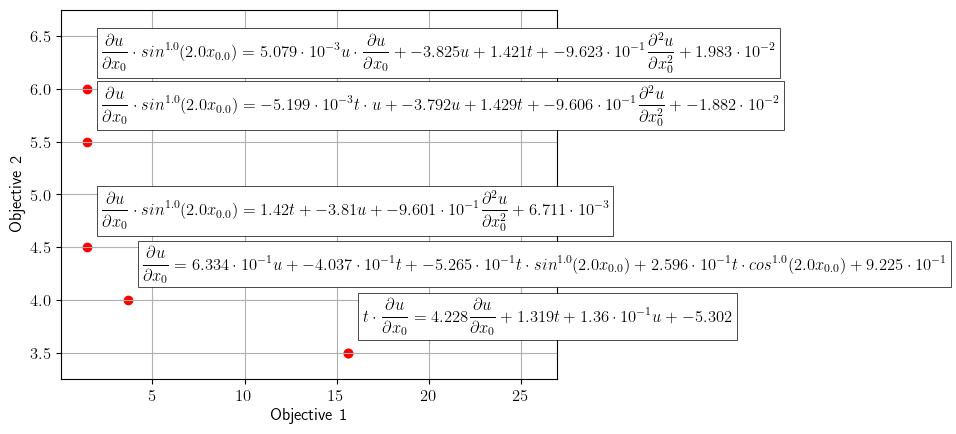

In [15]:
epde_search_obj.visualize_solutions()

In [22]:
sys = epde_search_obj.get_equations_by_complexity(4.5)[0]

In [23]:
sys.text_form

"1.4204126826949306 * t{power: 1.0, dim: 0.0} + 0.0 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * d^2u/dx0^2{power: 1.0} + -3.8103747941604804 * u{power: 1.0} + -0.9600740223219044 * d^2u/dx0^2{power: 1.0} + 0.00671063488241086 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 2.000000030594236, dim: 0.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0017062410553210074}}"

While there are multiple equations on the Pareto frontier, we can establish two candidates for the knee-points (for brevity they are denoted by their complexities: 4 and 4.5). The further increase in complexity does not provide significant error decrease, thus is not necessary. We shall analyze the process representation quality on the test dataset by solving initial value problem.

The equation with complexity of 4.5 is second-order, thus to solve it we need the function value and the solution derivatve

In [84]:
import torch
from epde.interface.solver_integration import BoundaryConditions, BOPElement

eq_1 = epde_search_obj.get_equations_by_complexity(4.5)[0]
print(eq_1.text_form)

1.4204126826949306 * t{power: 1.0, dim: 0.0} + 0.0 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * d^2u/dx0^2{power: 1.0} + -3.8103747941604804 * u{power: 1.0} + -0.9600740223219044 * d^2u/dx0^2{power: 1.0} + 0.00671063488241086 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 2.000000030594236, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0017062410553210074}}


In [85]:
def get_ode_bop(key, var, term, grid_loc, value):
    bop = BOPElement(axis = 0, key = key, term = term, power = 1, var = var)
    bop_grd_np = np.array([[grid_loc,]])
    bop.set_grid(torch.from_numpy(bop_grd_np).type(torch.FloatTensor))
    bop.values = torch.from_numpy(np.array([[value,]])).float()
    return bop

bop_u = get_ode_bop('u', 0, [None], t_test[0], x_test[0])
# Set derivative with central finite difference 
bop_du = get_ode_bop('dudt', 0, [0,], t_test[0], (x_test[1] - x_train[-1])/(2*(t_test[1] - t_test[0])))   

In [86]:
pred_u = epde_search_obj.predict(system=eq_1, boundary_conditions = [bop_u(), bop_du()],
                                 grid = [t_test,], strategy='autograd')
pred_u = pred_u.reshape(-1)

Using explicitly sent system of equations.
dimensionality is 1
grid.shape is (160,)
Shape of the grid for solver torch.Size([160, 1])
Grid is  <class 'torch.Tensor'> torch.Size([160, 1])
torch.Size([1])
[2023-10-27 13:24:08.221781] initial (min) loss is 385.9641418457031
[2023-10-27 13:24:08.338629] Print every 1000 step
Step = 0 loss = 385.964142 normalized loss line= 0.000000x+1.000000. There was 1 stop dings already.
[2023-10-27 13:25:01.714935] No improvement in 100 steps
Step = 957 loss = 0.002815 normalized loss line= -0.053090x+7.699608. There was 1 stop dings already.
[2023-10-27 13:25:04.156476] Print every 1000 step
Step = 1000 loss = 0.002023 normalized loss line= -0.073878x+10.714408. There was 2 stop dings already.
[2023-10-27 13:25:15.958920] No improvement in 100 steps
Step = 1230 loss = 0.000143 normalized loss line= 1.693049x+9.726075. There was 2 stop dings already.
[2023-10-27 13:25:21.613421] No improvement in 100 steps
Step = 1330 loss = 0.000181 normalized loss li

To evaluate the quality of obtained equation, we will check the MAPE error and visualize the solution oftest domain.

MAPE on the test dataset is 0.009812461385864783


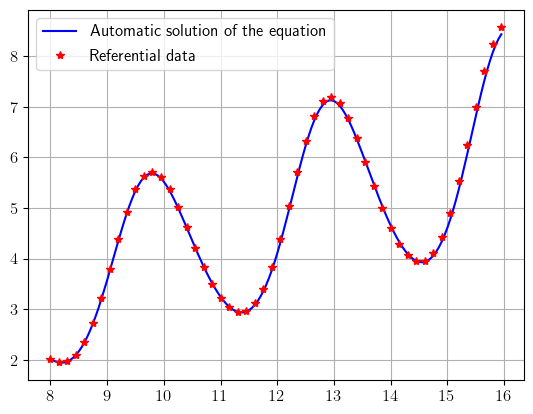

In [88]:
print(f'MAPE on the test dataset is {np.mean(np.abs((pred_u - x_test)/x_test))}')

plt.plot(t_test, pred_u, color = 'b', label = 'Automatic solution of the equation')
plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.xlabel('Time'); plt.ylabel('Predicted value') 
plt.grid()
plt.legend()
plt.show()

In [89]:
eq2 = epde_search_obj.get_equations_by_complexity(4)[0]
eq2.text_form

"0.0 * d^2u/dx0^2{power: 1.0} + 0.6334141886464264 * u{power: 1.0} + -0.4036802767762263 * t{power: 1.0, dim: 0.0} + -0.5265121291057969 * t{power: 1.0, dim: 0.0} * sin{power: 1.0, freq: 2.000000359965463, dim: 0.0} + 0.2596251993636941 * t{power: 1.0, dim: 0.0} * cos{power: 1.0, freq: 1.9999999936069808, dim: 0.0} + 0.9225210424019804 = du/dx0{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.005910228093653957}}"

This equation has the first order, thus only a single initial condition $u|_{t = t_{val, 0}}$ is needed, and we get it from the data.

In [90]:
bop_u = get_ode_bop('u', 0, [None], t_test[0], x_test[0])
pred_u = epde_search_obj.predict(system=eq2, 
                                 boundary_conditions = [bop_u(),],# bop_du()],
                                 grid = [t_test,], strategy='autograd')
pred_u = pred_u.reshape(-1)

Using explicitly sent system of equations.
dimensionality is 1
grid.shape is (160,)
Shape of the grid for solver torch.Size([160, 1])
Grid is  <class 'torch.Tensor'> torch.Size([160, 1])
torch.Size([1])
[2023-10-27 13:26:06.629574] initial (min) loss is 314.85504150390625
[2023-10-27 13:26:06.673411] Print every 1000 step
Step = 0 loss = 314.855042 normalized loss line= -0.000000x+1.000000. There was 1 stop dings already.
[2023-10-27 13:26:13.090162] No improvement in 100 steps
Step = 175 loss = 0.681533 normalized loss line= -0.670408x+46.723266. There was 1 stop dings already.
[2023-10-27 13:26:16.941645] No improvement in 100 steps
Step = 275 loss = 0.661911 normalized loss line= 0.000372x+1.001404. There was 2 stop dings already.
[2023-10-27 13:26:21.296751] No improvement in 100 steps
Step = 389 loss = 0.673448 normalized loss line= -0.000640x+1.035446. There was 3 stop dings already.
[2023-10-27 13:26:35.747094] No improvement in 100 steps
Step = 799 loss = 0.036245 normalized lo

MAPE on the test dataset is 0.40879904876947004


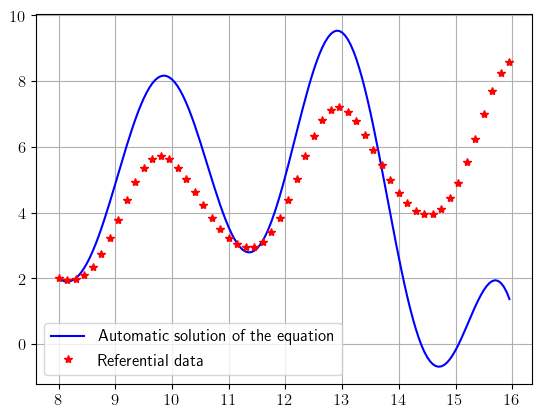

In [91]:
print(f'MAPE on the test dataset is {np.mean(np.abs((pred_u - x_test)/x_test))}')

plt.plot(t_test, pred_u, color = 'b', label = 'Automatic solution of the equation')
plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.grid()
plt.legend()
plt.show()

In the result we can see, that the equation $1.42 t - 3.81 u -0.96 u'' + 0.007 = u' \sin{(2.0 t)}$ can decently describe the process, while the alternative equation is not representative enough.

## Van der Pol oscillator

The problem of non-linear ordinary differential equations discovery can be demonstrated with the Van der Pol oscillator. Initially introduced to describe the relaxation-oscillation cycle produced by the electromagnetic field, the model has found applications in other spheres of science, such as biology or seismology. Its state is governed by equation $u'' + \mathcal{E}(u^2 - 1)u' + u = 0$, where $\mathcal{E}$ is a positive constant (in the example we will use $\mathcal{E} = 0.2$). To prepare synthetic dataset we will again use Runge-Kutta method:

In [98]:
def VdP_by_RK(initial: tuple, timestep: float, steps: int, epsilon: float):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 =  - epsilon*(res[step, 0]**2 - 1)*res[step, 1] - res[step, 0]; y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = - epsilon*(x1**2 - 1)*y1 - x1; y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = - epsilon*(x2**2 - 1)*y2 - x2
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = - epsilon*(x3**2 - 1)*y3 - x3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

def prepare_VdP_data(initial = (np.sqrt(3)/2., 1./2.), step = 0.05, steps_num = 640, epsilon = 0.2):
    t = np.arange(start = 0., stop = step * steps_num, step = step)
    solution = VdP_by_RK(initial=initial, timestep=step, steps=steps_num, 
                                      epsilon=epsilon)
    return t, solution

In [126]:
def epde_discovery_as_ode(t, x, use_ann:bool = False):
    dimensionality = x.ndim - 1
    epde_search_obj = epde.EpdeSearch(use_solver = False, dimensionality = dimensionality, boundary = 50,
                                           coordinate_tensors = [t,])
    if use_ann:
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN',
                                         preprocessor_kwargs={'epochs_max' : 35000})
    else:
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly',
                                         preprocessor_kwargs={'use_smoothing' : True, 'sigma' : 1, 
                                                              'polynomial_window' : 3, 'poly_order' : 3})
    popsize = 12
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=100)
    
    factors_max_number = {'factors_num' : [1, 2, 3], 'probas' : [0.4, 0.3, 0.3]}
    
    epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(2,),
                        equation_terms_max_number=6, data_fun_pow = 2,
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(1e-12, 1e1))
    
    epde_search_obj.equations(only_print = True, num = 1)
    
    return epde_search_obj

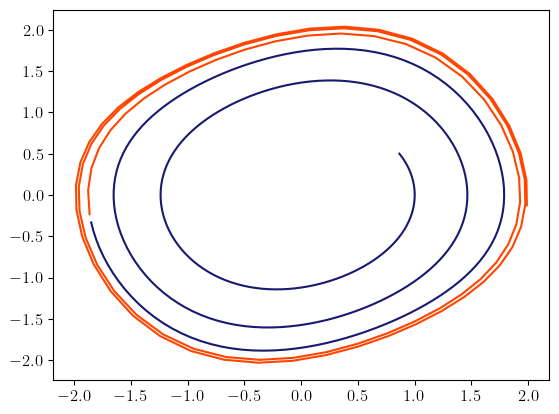

In [127]:
t, x_stacked = prepare_VdP_data()
t_max = 320
x, y = x_stacked[:, 0], x_stacked[:, 1]
t_train, t_test = t[:t_max], t[:t_max]
x_train, x_test = x[:t_max], x[t_max:]
y_train, y_test = y[:t_max], y[t_max:]
plt.plot(x_train, y_train, color = 'midnightblue')
plt.plot(x_test[::3], y_test[::3], color = 'orangered')
plt.show()

In [129]:
epde_search_obj = epde_discovery_as_ode(t_train, x_train, True)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc1da55e7f0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fc1da55e7f0>
Deriv orders after definition [[None], [0], [0, 0]]
Surface training t=0, loss=0.9886471033096313
Surface training t=1, loss=0.9427707195281982
Surface training t=2, loss=0.9672328531742096
Surface training t=3, loss=0.9703816771507263
Surface training t=4, loss=0.9534877836704254
Surface training t=5, loss=0.8831912577152252
Surface training t=6, loss=0.9205136001110077
Surface training t=7, loss=0.9216731786727905
Surface training t=8, loss=0.8929721117019653
Surface training t=9, loss=0.9314711689949036
Surface training t=10, loss=0.9022430181503296
Surface training t=11, loss=0.9095550775527954
Surface training t=12, loss=0.9485109448432922
Surface training t=13, loss=0.8985200524330139
Surface training t=14, loss=0.8988443613052368
Surface training t=15, loss=0.9079181849956512
Surface training t=16, loss=0.

Surface training t=183, loss=0.8311417400836945
Surface training t=184, loss=0.8251111507415771
Surface training t=185, loss=0.8179400861263275
Surface training t=186, loss=0.750582754611969
Surface training t=187, loss=0.822142630815506
Surface training t=188, loss=0.8134550452232361
Surface training t=189, loss=0.7724684178829193
Surface training t=190, loss=0.7809622287750244
Surface training t=191, loss=0.775101512670517
Surface training t=192, loss=0.8266279101371765
Surface training t=193, loss=0.825160562992096
Surface training t=194, loss=0.7346524298191071
Surface training t=195, loss=0.805948406457901
Surface training t=196, loss=0.8062301874160767
Surface training t=197, loss=0.8098877668380737
Surface training t=198, loss=0.7856581807136536
Surface training t=199, loss=0.8060660362243652
Surface training t=200, loss=0.831815093755722
Surface training t=201, loss=0.817896157503128
Surface training t=202, loss=0.8262318670749664
Surface training t=203, loss=0.8007483184337616

Surface training t=369, loss=0.7493490278720856
Surface training t=370, loss=0.728399395942688
Surface training t=371, loss=0.7533872723579407
Surface training t=372, loss=0.7769631445407867
Surface training t=373, loss=0.7208417057991028
Surface training t=374, loss=0.7503263652324677
Surface training t=375, loss=0.773250162601471
Surface training t=376, loss=0.6970821917057037
Surface training t=377, loss=0.7650207579135895
Surface training t=378, loss=0.7724440693855286
Surface training t=379, loss=0.7594838440418243
Surface training t=380, loss=0.7592717409133911
Surface training t=381, loss=0.7685916125774384
Surface training t=382, loss=0.7049773037433624
Surface training t=383, loss=0.721996009349823
Surface training t=384, loss=0.7028826177120209
Surface training t=385, loss=0.7391636669635773
Surface training t=386, loss=0.7510725557804108
Surface training t=387, loss=0.7712835669517517
Surface training t=388, loss=0.7432951629161835
Surface training t=389, loss=0.750451982021

Surface training t=557, loss=0.7335785627365112
Surface training t=558, loss=0.7996465563774109
Surface training t=559, loss=0.7331822216510773
Surface training t=560, loss=0.7303139567375183
Surface training t=561, loss=0.753900557756424
Surface training t=562, loss=0.7240837812423706
Surface training t=563, loss=0.7379560172557831
Surface training t=564, loss=0.7360164523124695
Surface training t=565, loss=0.706916332244873
Surface training t=566, loss=0.7648134827613831
Surface training t=567, loss=0.6997851133346558
Surface training t=568, loss=0.6866654753684998
Surface training t=569, loss=0.7547954320907593
Surface training t=570, loss=0.6889091730117798
Surface training t=571, loss=0.7452556788921356
Surface training t=572, loss=0.7430039644241333
Surface training t=573, loss=0.7243649363517761
Surface training t=574, loss=0.7281731069087982
Surface training t=575, loss=0.6830784380435944
Surface training t=576, loss=0.7264013886451721
Surface training t=577, loss=0.71924614906

Surface training t=749, loss=0.7543063461780548
Surface training t=750, loss=0.7194603085517883
Surface training t=751, loss=0.7463642358779907
Surface training t=752, loss=0.7197608053684235
Surface training t=753, loss=0.6490496098995209
Surface training t=754, loss=0.718960702419281
Surface training t=755, loss=0.6767506003379822
Surface training t=756, loss=0.7567952573299408
Surface training t=757, loss=0.6940947473049164
Surface training t=758, loss=0.7004585564136505
Surface training t=759, loss=0.731511265039444
Surface training t=760, loss=0.719746470451355
Surface training t=761, loss=0.7286590337753296
Surface training t=762, loss=0.6941852271556854
Surface training t=763, loss=0.713170737028122
Surface training t=764, loss=0.6698143482208252
Surface training t=765, loss=0.7449012100696564
Surface training t=766, loss=0.6817027926445007
Surface training t=767, loss=0.7364096641540527
Surface training t=768, loss=0.7369137108325958
Surface training t=769, loss=0.7455627322196

Surface training t=942, loss=0.6883070468902588
Surface training t=943, loss=0.7097288966178894
Surface training t=944, loss=0.6895450353622437
Surface training t=945, loss=0.6643058657646179
Surface training t=946, loss=0.7045563459396362
Surface training t=947, loss=0.7344096302986145
Surface training t=948, loss=0.7063700556755066
Surface training t=949, loss=0.7125669717788696
Surface training t=950, loss=0.6978897750377655
Surface training t=951, loss=0.7154608368873596
Surface training t=952, loss=0.6837054193019867
Surface training t=953, loss=0.736769437789917
Surface training t=954, loss=0.702972948551178
Surface training t=955, loss=0.6433483064174652
Surface training t=956, loss=0.6924918293952942
Surface training t=957, loss=0.7022729218006134
Surface training t=958, loss=0.6861046850681305
Surface training t=959, loss=0.6925418674945831
Surface training t=960, loss=0.7304800748825073
Surface training t=961, loss=0.6652023792266846
Surface training t=962, loss=0.65015295147

Surface training t=1122, loss=0.7075830101966858
Surface training t=1123, loss=0.6628279685974121
Surface training t=1124, loss=0.6975196897983551
Surface training t=1125, loss=0.7008666396141052
Surface training t=1126, loss=0.6622483730316162
Surface training t=1127, loss=0.7012901306152344
Surface training t=1128, loss=0.7001358866691589
Surface training t=1129, loss=0.694210022687912
Surface training t=1130, loss=0.6750964522361755
Surface training t=1131, loss=0.7082045078277588
Surface training t=1132, loss=0.6631987690925598
Surface training t=1133, loss=0.655221700668335
Surface training t=1134, loss=0.6902758777141571
Surface training t=1135, loss=0.6910734474658966
Surface training t=1136, loss=0.6668674051761627
Surface training t=1137, loss=0.7298831939697266
Surface training t=1138, loss=0.7263806760311127
Surface training t=1139, loss=0.651524007320404
Surface training t=1140, loss=0.7008337676525116
Surface training t=1141, loss=0.6203329265117645
Surface training t=1142

Surface training t=1300, loss=0.6603861153125763
Surface training t=1301, loss=0.6215182542800903
Surface training t=1302, loss=0.6846041083335876
Surface training t=1303, loss=0.625732958316803
Surface training t=1304, loss=0.7239500284194946
Surface training t=1305, loss=0.6646137833595276
Surface training t=1306, loss=0.6074694097042084
Surface training t=1307, loss=0.6691764295101166
Surface training t=1308, loss=0.6534204483032227
Surface training t=1309, loss=0.6594311594963074
Surface training t=1310, loss=0.5915285497903824
Surface training t=1311, loss=0.6616460978984833
Surface training t=1312, loss=0.6456650197505951
Surface training t=1313, loss=0.685455858707428
Surface training t=1314, loss=0.6400328278541565
Surface training t=1315, loss=0.6523101031780243
Surface training t=1316, loss=0.6646439731121063
Surface training t=1317, loss=0.6451307237148285
Surface training t=1318, loss=0.6849786341190338
Surface training t=1319, loss=0.6363668143749237
Surface training t=132

Surface training t=1487, loss=0.5689104199409485
Surface training t=1488, loss=0.5585772395133972
Surface training t=1489, loss=0.5979010462760925
Surface training t=1490, loss=0.6223300993442535
Surface training t=1491, loss=0.6123720705509186
Surface training t=1492, loss=0.5621511340141296
Surface training t=1493, loss=0.6119587123394012
Surface training t=1494, loss=0.6314526796340942
Surface training t=1495, loss=0.5961701273918152
Surface training t=1496, loss=0.6131268441677094
Surface training t=1497, loss=0.578490674495697
Surface training t=1498, loss=0.6054146587848663
Surface training t=1499, loss=0.5906876027584076
Surface training t=1500, loss=0.6114715337753296
Surface training t=1501, loss=0.5967662036418915
Surface training t=1502, loss=0.6745475828647614
Surface training t=1503, loss=0.6350761651992798
Surface training t=1504, loss=0.5549453496932983
Surface training t=1505, loss=0.5673704743385315
Surface training t=1506, loss=0.6004814207553864
Surface training t=15

Surface training t=1675, loss=0.546603798866272
Surface training t=1676, loss=0.5410367250442505
Surface training t=1677, loss=0.580089271068573
Surface training t=1678, loss=0.5583784282207489
Surface training t=1679, loss=0.5700943171977997
Surface training t=1680, loss=0.5673936307430267
Surface training t=1681, loss=0.5926579535007477
Surface training t=1682, loss=0.5694858133792877
Surface training t=1683, loss=0.5569345951080322
Surface training t=1684, loss=0.5718838572502136
Surface training t=1685, loss=0.5598309934139252
Surface training t=1686, loss=0.5310629606246948
Surface training t=1687, loss=0.5134412497282028
Surface training t=1688, loss=0.5408430099487305
Surface training t=1689, loss=0.4971855580806732
Surface training t=1690, loss=0.5153980553150177
Surface training t=1691, loss=0.5599159002304077
Surface training t=1692, loss=0.5497987568378448
Surface training t=1693, loss=0.5258941054344177
Surface training t=1694, loss=0.5803600549697876
Surface training t=169

Surface training t=1874, loss=0.5379021018743515
Surface training t=1875, loss=0.4973258078098297
Surface training t=1876, loss=0.5177575051784515
Surface training t=1877, loss=0.531436949968338
Surface training t=1878, loss=0.49741213023662567
Surface training t=1879, loss=0.5623323917388916
Surface training t=1880, loss=0.5434858798980713
Surface training t=1881, loss=0.49501122534275055
Surface training t=1882, loss=0.4742158502340317
Surface training t=1883, loss=0.5006833970546722
Surface training t=1884, loss=0.4963088482618332
Surface training t=1885, loss=0.49148157238960266
Surface training t=1886, loss=0.49665313959121704
Surface training t=1887, loss=0.47965218126773834
Surface training t=1888, loss=0.4791076332330704
Surface training t=1889, loss=0.47329235076904297
Surface training t=1890, loss=0.47605228424072266
Surface training t=1891, loss=0.5830558985471725
Surface training t=1892, loss=0.49355660378932953
Surface training t=1893, loss=0.4998473972082138
Surface train

Surface training t=2075, loss=0.46488356590270996
Surface training t=2076, loss=0.5423241406679153
Surface training t=2077, loss=0.5007453411817551
Surface training t=2078, loss=0.4987400025129318
Surface training t=2079, loss=0.4745458662509918
Surface training t=2080, loss=0.4694027155637741
Surface training t=2081, loss=0.4929600656032562
Surface training t=2082, loss=0.46064721047878265
Surface training t=2083, loss=0.4592372477054596
Surface training t=2084, loss=0.4927379935979843
Surface training t=2085, loss=0.48948240280151367
Surface training t=2086, loss=0.4784228354692459
Surface training t=2087, loss=0.5000792443752289
Surface training t=2088, loss=0.43505507707595825
Surface training t=2089, loss=0.42575179040431976
Surface training t=2090, loss=0.4874122589826584
Surface training t=2091, loss=0.4729376435279846
Surface training t=2092, loss=0.5162804424762726
Surface training t=2093, loss=0.45672507584095
Surface training t=2094, loss=0.45309972763061523
Surface training

Surface training t=2277, loss=0.5093806087970734
Surface training t=2278, loss=0.4217377305030823
Surface training t=2279, loss=0.45689284801483154
Surface training t=2280, loss=0.450832262635231
Surface training t=2281, loss=0.4928884506225586
Surface training t=2282, loss=0.46605396270751953
Surface training t=2283, loss=0.44463157653808594
Surface training t=2284, loss=0.43005968630313873
Surface training t=2285, loss=0.4916885495185852
Surface training t=2286, loss=0.4701341986656189
Surface training t=2287, loss=0.47022195160388947
Surface training t=2288, loss=0.4440317451953888
Surface training t=2289, loss=0.43848271667957306
Surface training t=2290, loss=0.44702258706092834
Surface training t=2291, loss=0.51389579474926
Surface training t=2292, loss=0.4566081017255783
Surface training t=2293, loss=0.48316872119903564
Surface training t=2294, loss=0.45359261333942413
Surface training t=2295, loss=0.46988068521022797
Surface training t=2296, loss=0.47830232977867126
Surface trai

Surface training t=2477, loss=0.4280197471380234
Surface training t=2478, loss=0.4886616915464401
Surface training t=2479, loss=0.44441643357276917
Surface training t=2480, loss=0.4214712530374527
Surface training t=2481, loss=0.4630506932735443
Surface training t=2482, loss=0.48081274330616
Surface training t=2483, loss=0.44096820056438446
Surface training t=2484, loss=0.49130500853061676
Surface training t=2485, loss=0.4279588311910629
Surface training t=2486, loss=0.46644924581050873
Surface training t=2487, loss=0.4289615750312805
Surface training t=2488, loss=0.48505645990371704
Surface training t=2489, loss=0.4006112962961197
Surface training t=2490, loss=0.45519615709781647
Surface training t=2491, loss=0.4473772495985031
Surface training t=2492, loss=0.4332427978515625
Surface training t=2493, loss=0.4443042278289795
Surface training t=2494, loss=0.44020161032676697
Surface training t=2495, loss=0.4436393976211548
Surface training t=2496, loss=0.5029331296682358
Surface trainin

Surface training t=2675, loss=0.40685024857521057
Surface training t=2676, loss=0.4492455869913101
Surface training t=2677, loss=0.45587649941444397
Surface training t=2678, loss=0.4870077818632126
Surface training t=2679, loss=0.4429570734500885
Surface training t=2680, loss=0.40543481707572937
Surface training t=2681, loss=0.4968390315771103
Surface training t=2682, loss=0.4439271092414856
Surface training t=2683, loss=0.410059317946434
Surface training t=2684, loss=0.4116511791944504
Surface training t=2685, loss=0.47885146737098694
Surface training t=2686, loss=0.4134751111268997
Surface training t=2687, loss=0.44608037173748016
Surface training t=2688, loss=0.434186726808548
Surface training t=2689, loss=0.4574678838253021
Surface training t=2690, loss=0.4294685274362564
Surface training t=2691, loss=0.5232710242271423
Surface training t=2692, loss=0.4624559134244919
Surface training t=2693, loss=0.4327257573604584
Surface training t=2694, loss=0.44765983521938324
Surface training

Surface training t=2877, loss=0.48279042541980743
Surface training t=2878, loss=0.4419693797826767
Surface training t=2879, loss=0.4657391756772995
Surface training t=2880, loss=0.43593497574329376
Surface training t=2881, loss=0.42491425573825836
Surface training t=2882, loss=0.46391403675079346
Surface training t=2883, loss=0.4265882819890976
Surface training t=2884, loss=0.4214331656694412
Surface training t=2885, loss=0.4486294090747833
Surface training t=2886, loss=0.4373985081911087
Surface training t=2887, loss=0.41185885667800903
Surface training t=2888, loss=0.39825139939785004
Surface training t=2889, loss=0.4791064113378525
Surface training t=2890, loss=0.44182732701301575
Surface training t=2891, loss=0.46555787324905396
Surface training t=2892, loss=0.44631753861904144
Surface training t=2893, loss=0.4982694685459137
Surface training t=2894, loss=0.4083549827337265
Surface training t=2895, loss=0.44999605417251587
Surface training t=2896, loss=0.4513818323612213
Surface tr

Surface training t=3079, loss=0.42405180633068085
Surface training t=3080, loss=0.4115127772092819
Surface training t=3081, loss=0.38243745267391205
Surface training t=3082, loss=0.44410568475723267
Surface training t=3083, loss=0.42696329951286316
Surface training t=3084, loss=0.4374200403690338
Surface training t=3085, loss=0.43699538707733154
Surface training t=3086, loss=0.38679561018943787
Surface training t=3087, loss=0.47015997767448425
Surface training t=3088, loss=0.43570704758167267
Surface training t=3089, loss=0.42498932778835297
Surface training t=3090, loss=0.4007487893104553
Surface training t=3091, loss=0.4019118845462799
Surface training t=3092, loss=0.44524966180324554
Surface training t=3093, loss=0.384991392493248
Surface training t=3094, loss=0.4535289704799652
Surface training t=3095, loss=0.4595429003238678
Surface training t=3096, loss=0.3837016224861145
Surface training t=3097, loss=0.43622009456157684
Surface training t=3098, loss=0.41728827357292175
Surface t

Surface training t=3286, loss=0.4345614016056061
Surface training t=3287, loss=0.4541679620742798
Surface training t=3288, loss=0.4129186272621155
Surface training t=3289, loss=0.38835692405700684
Surface training t=3290, loss=0.438097208738327
Surface training t=3291, loss=0.46631211042404175
Surface training t=3292, loss=0.4509003013372421
Surface training t=3293, loss=0.4177183210849762
Surface training t=3294, loss=0.43794526159763336
Surface training t=3295, loss=0.3999045193195343
Surface training t=3296, loss=0.46429985761642456
Surface training t=3297, loss=0.4278258979320526
Surface training t=3298, loss=0.4046638607978821
Surface training t=3299, loss=0.3725349009037018
Surface training t=3300, loss=0.4927196353673935
Surface training t=3301, loss=0.4291251301765442
Surface training t=3302, loss=0.40412183105945587
Surface training t=3303, loss=0.442422479391098
Surface training t=3304, loss=0.38035283982753754
Surface training t=3305, loss=0.3921457976102829
Surface training

Surface training t=3487, loss=0.40228308737277985
Surface training t=3488, loss=0.41720297932624817
Surface training t=3489, loss=0.3733544796705246
Surface training t=3490, loss=0.3727937191724777
Surface training t=3491, loss=0.4424431622028351
Surface training t=3492, loss=0.40957750380039215
Surface training t=3493, loss=0.4078883230686188
Surface training t=3494, loss=0.40270504355430603
Surface training t=3495, loss=0.41943252086639404
Surface training t=3496, loss=0.3980149030685425
Surface training t=3497, loss=0.47766514122486115
Surface training t=3498, loss=0.39800719916820526
Surface training t=3499, loss=0.38983073830604553
Surface training t=3500, loss=0.4042108952999115
Surface training t=3501, loss=0.4414053410291672
Surface training t=3502, loss=0.41442902386188507
Surface training t=3503, loss=0.3841669261455536
Surface training t=3504, loss=0.3712655305862427
Surface training t=3505, loss=0.42662693560123444
Surface training t=3506, loss=0.40665242075920105
Surface t

Surface training t=3686, loss=0.4614860564470291
Surface training t=3687, loss=0.4128866344690323
Surface training t=3688, loss=0.4465310871601105
Surface training t=3689, loss=0.35154400765895844
Surface training t=3690, loss=0.418986976146698
Surface training t=3691, loss=0.40213197469711304
Surface training t=3692, loss=0.39991454780101776
Surface training t=3693, loss=0.4119623899459839
Surface training t=3694, loss=0.3798840641975403
Surface training t=3695, loss=0.35434170067310333
Surface training t=3696, loss=0.40182188153266907
Surface training t=3697, loss=0.3714784234762192
Surface training t=3698, loss=0.34777551889419556
Surface training t=3699, loss=0.36471064388751984
Surface training t=3700, loss=0.38661518692970276
Surface training t=3701, loss=0.36750657856464386
Surface training t=3702, loss=0.43145619332790375
Surface training t=3703, loss=0.41595734655857086
Surface training t=3704, loss=0.41410768032073975
Surface training t=3705, loss=0.3772621303796768
Surface t

Surface training t=3891, loss=0.382595494389534
Surface training t=3892, loss=0.3566640615463257
Surface training t=3893, loss=0.3998414874076843
Surface training t=3894, loss=0.42439933121204376
Surface training t=3895, loss=0.4387615919113159
Surface training t=3896, loss=0.3908649682998657
Surface training t=3897, loss=0.3950778990983963
Surface training t=3898, loss=0.4337518513202667
Surface training t=3899, loss=0.365881010890007
Surface training t=3900, loss=0.3963879197835922
Surface training t=3901, loss=0.3779745548963547
Surface training t=3902, loss=0.4579348564147949
Surface training t=3903, loss=0.37012559175491333
Surface training t=3904, loss=0.3796849548816681
Surface training t=3905, loss=0.39015568792819977
Surface training t=3906, loss=0.43914443254470825
Surface training t=3907, loss=0.4375288188457489
Surface training t=3908, loss=0.4303712546825409
Surface training t=3909, loss=0.3774087727069855
Surface training t=3910, loss=0.37381233274936676
Surface training 

Surface training t=4095, loss=0.41994403302669525
Surface training t=4096, loss=0.39601004123687744
Surface training t=4097, loss=0.3545200079679489
Surface training t=4098, loss=0.4010414034128189
Surface training t=4099, loss=0.4276617467403412
Surface training t=4100, loss=0.36783313751220703
Surface training t=4101, loss=0.4488302767276764
Surface training t=4102, loss=0.35793887078762054
Surface training t=4103, loss=0.43075820803642273
Surface training t=4104, loss=0.43811123073101044
Surface training t=4105, loss=0.4268387407064438
Surface training t=4106, loss=0.349450945854187
Surface training t=4107, loss=0.43594884872436523
Surface training t=4108, loss=0.4391603618860245
Surface training t=4109, loss=0.4291580021381378
Surface training t=4110, loss=0.4475468695163727
Surface training t=4111, loss=0.47509847581386566
Surface training t=4112, loss=0.41697831451892853
Surface training t=4113, loss=0.3822086751461029
Surface training t=4114, loss=0.39252781867980957
Surface tra

Surface training t=4302, loss=0.37416818737983704
Surface training t=4303, loss=0.38134732842445374
Surface training t=4304, loss=0.3781530112028122
Surface training t=4305, loss=0.3643421232700348
Surface training t=4306, loss=0.3680584281682968
Surface training t=4307, loss=0.3986388146877289
Surface training t=4308, loss=0.38962027430534363
Surface training t=4309, loss=0.3907150626182556
Surface training t=4310, loss=0.3817341476678848
Surface training t=4311, loss=0.3531882166862488
Surface training t=4312, loss=0.3760717958211899
Surface training t=4313, loss=0.40734662115573883
Surface training t=4314, loss=0.3628798723220825
Surface training t=4315, loss=0.4091508239507675
Surface training t=4316, loss=0.34178614616394043
Surface training t=4317, loss=0.40241488814353943
Surface training t=4318, loss=0.398468941450119
Surface training t=4319, loss=0.36917728185653687
Surface training t=4320, loss=0.3768483102321625
Surface training t=4321, loss=0.4205663800239563
Surface traini

Surface training t=4508, loss=0.35294489562511444
Surface training t=4509, loss=0.30525777488946915
Surface training t=4510, loss=0.39752982556819916
Surface training t=4511, loss=0.34861883521080017
Surface training t=4512, loss=0.39940160512924194
Surface training t=4513, loss=0.336132749915123
Surface training t=4514, loss=0.36138124763965607
Surface training t=4515, loss=0.3972701132297516
Surface training t=4516, loss=0.32293180376291275
Surface training t=4517, loss=0.3962497413158417
Surface training t=4518, loss=0.382998526096344
Surface training t=4519, loss=0.3656099736690521
Surface training t=4520, loss=0.33271750807762146
Surface training t=4521, loss=0.3487425446510315
Surface training t=4522, loss=0.3864799439907074
Surface training t=4523, loss=0.35701726377010345
Surface training t=4524, loss=0.32848595082759857
Surface training t=4525, loss=0.3744707256555557
Surface training t=4526, loss=0.34485067427158356
Surface training t=4527, loss=0.39946161210536957
Surface tr

Surface training t=4706, loss=0.36817994713783264
Surface training t=4707, loss=0.2991291359066963
Surface training t=4708, loss=0.36672520637512207
Surface training t=4709, loss=0.34427401423454285
Surface training t=4710, loss=0.36321890354156494
Surface training t=4711, loss=0.35722239315509796
Surface training t=4712, loss=0.3541698157787323
Surface training t=4713, loss=0.33795951306819916
Surface training t=4714, loss=0.32648633420467377
Surface training t=4715, loss=0.35048262774944305
Surface training t=4716, loss=0.36070995032787323
Surface training t=4717, loss=0.32955893874168396
Surface training t=4718, loss=0.3447103053331375
Surface training t=4719, loss=0.38561876118183136
Surface training t=4720, loss=0.32803651690483093
Surface training t=4721, loss=0.31871648132801056
Surface training t=4722, loss=0.35296526551246643
Surface training t=4723, loss=0.35386501252651215
Surface training t=4724, loss=0.34947003424167633
Surface training t=4725, loss=0.3464714288711548
Surf

Surface training t=4907, loss=0.3308414816856384
Surface training t=4908, loss=0.31015458703041077
Surface training t=4909, loss=0.30463728308677673
Surface training t=4910, loss=0.32008279860019684
Surface training t=4911, loss=0.2951040714979172
Surface training t=4912, loss=0.33702829480171204
Surface training t=4913, loss=0.35228487849235535
Surface training t=4914, loss=0.3253467530012131
Surface training t=4915, loss=0.31549473106861115
Surface training t=4916, loss=0.3241606503725052
Surface training t=4917, loss=0.3779056668281555
Surface training t=4918, loss=0.3728039711713791
Surface training t=4919, loss=0.3220500349998474
Surface training t=4920, loss=0.30301307141780853
Surface training t=4921, loss=0.340562641620636
Surface training t=4922, loss=0.3344928175210953
Surface training t=4923, loss=0.32043473422527313
Surface training t=4924, loss=0.34644582867622375
Surface training t=4925, loss=0.3452429920434952
Surface training t=4926, loss=0.3113253712654114
Surface trai

Surface training t=5127, loss=0.31235918402671814
Surface training t=5128, loss=0.2967495620250702
Surface training t=5129, loss=0.3284297585487366
Surface training t=5130, loss=0.32267408072948456
Surface training t=5131, loss=0.3147778809070587
Surface training t=5132, loss=0.3006099611520767
Surface training t=5133, loss=0.3322066217660904
Surface training t=5134, loss=0.3064575344324112
Surface training t=5135, loss=0.32586970925331116
Surface training t=5136, loss=0.3398517370223999
Surface training t=5137, loss=0.3024972528219223
Surface training t=5138, loss=0.3421929031610489
Surface training t=5139, loss=0.37816308438777924
Surface training t=5140, loss=0.33107152581214905
Surface training t=5141, loss=0.3079499751329422
Surface training t=5142, loss=0.33051906526088715
Surface training t=5143, loss=0.31433480978012085
Surface training t=5144, loss=0.37207408249378204
Surface training t=5145, loss=0.3656528890132904
Surface training t=5146, loss=0.28585386276245117
Surface tra

Surface training t=5336, loss=0.3154228627681732
Surface training t=5337, loss=0.3168509304523468
Surface training t=5338, loss=0.28224068880081177
Surface training t=5339, loss=0.2504410520195961
Surface training t=5340, loss=0.32608552277088165
Surface training t=5341, loss=0.30940762162208557
Surface training t=5342, loss=0.27408795058727264
Surface training t=5343, loss=0.3019694983959198
Surface training t=5344, loss=0.2762930616736412
Surface training t=5345, loss=0.31256940960884094
Surface training t=5346, loss=0.3233474940061569
Surface training t=5347, loss=0.2736572101712227
Surface training t=5348, loss=0.3227270543575287
Surface training t=5349, loss=0.3103865683078766
Surface training t=5350, loss=0.3080551028251648
Surface training t=5351, loss=0.26782675832509995
Surface training t=5352, loss=0.30565614998340607
Surface training t=5353, loss=0.26875555515289307
Surface training t=5354, loss=0.31428076326847076
Surface training t=5355, loss=0.27720676362514496
Surface tr

Surface training t=5542, loss=0.27138882875442505
Surface training t=5543, loss=0.2844187170267105
Surface training t=5544, loss=0.31356102228164673
Surface training t=5545, loss=0.292723685503006
Surface training t=5546, loss=0.25311287492513657
Surface training t=5547, loss=0.27689386904239655
Surface training t=5548, loss=0.232448011636734
Surface training t=5549, loss=0.2797639071941376
Surface training t=5550, loss=0.28144100308418274
Surface training t=5551, loss=0.2877567410469055
Surface training t=5552, loss=0.2668849527835846
Surface training t=5553, loss=0.2677518427371979
Surface training t=5554, loss=0.2960076481103897
Surface training t=5555, loss=0.26236240565776825
Surface training t=5556, loss=0.294985368847847
Surface training t=5557, loss=0.2961774542927742
Surface training t=5558, loss=0.24526813626289368
Surface training t=5559, loss=0.25140950083732605
Surface training t=5560, loss=0.2658272981643677
Surface training t=5561, loss=0.2498021125793457
Surface trainin

Surface training t=5756, loss=0.28181685507297516
Surface training t=5757, loss=0.26344049721956253
Surface training t=5758, loss=0.29710108041763306
Surface training t=5759, loss=0.26785653829574585
Surface training t=5760, loss=0.2803667336702347
Surface training t=5761, loss=0.2631390243768692
Surface training t=5762, loss=0.24363144487142563
Surface training t=5763, loss=0.2489042654633522
Surface training t=5764, loss=0.23085515946149826
Surface training t=5765, loss=0.25608067214488983
Surface training t=5766, loss=0.22413869947195053
Surface training t=5767, loss=0.25395335257053375
Surface training t=5768, loss=0.22599677741527557
Surface training t=5769, loss=0.24030011147260666
Surface training t=5770, loss=0.24892005324363708
Surface training t=5771, loss=0.23929309844970703
Surface training t=5772, loss=0.2633812129497528
Surface training t=5773, loss=0.24674811959266663
Surface training t=5774, loss=0.26250315457582474
Surface training t=5775, loss=0.29356078058481216
Surf

Surface training t=5965, loss=0.18715417385101318
Surface training t=5966, loss=0.18970079720020294
Surface training t=5967, loss=0.20867151021957397
Surface training t=5968, loss=0.19249319285154343
Surface training t=5969, loss=0.18866565078496933
Surface training t=5970, loss=0.18043142557144165
Surface training t=5971, loss=0.1899040788412094
Surface training t=5972, loss=0.19732214510440826
Surface training t=5973, loss=0.20987335592508316
Surface training t=5974, loss=0.1936940923333168
Surface training t=5975, loss=0.18381508439779282
Surface training t=5976, loss=0.20701026171445847
Surface training t=5977, loss=0.18307068198919296
Surface training t=5978, loss=0.1885962411761284
Surface training t=5979, loss=0.1919693499803543
Surface training t=5980, loss=0.18375688791275024
Surface training t=5981, loss=0.1890314668416977
Surface training t=5982, loss=0.20804809033870697
Surface training t=5983, loss=0.19155900925397873
Surface training t=5984, loss=0.15697254985570908
Surfa

Surface training t=6165, loss=0.14169222116470337
Surface training t=6166, loss=0.13859302550554276
Surface training t=6167, loss=0.1399461254477501
Surface training t=6168, loss=0.13400553166866302
Surface training t=6169, loss=0.12007201462984085
Surface training t=6170, loss=0.12699957191944122
Surface training t=6171, loss=0.13865924626588821
Surface training t=6172, loss=0.13573505729436874
Surface training t=6173, loss=0.1321863755583763
Surface training t=6174, loss=0.12254073843359947
Surface training t=6175, loss=0.1411471739411354
Surface training t=6176, loss=0.15004030615091324
Surface training t=6177, loss=0.14053325355052948
Surface training t=6178, loss=0.11494629085063934
Surface training t=6179, loss=0.1549944281578064
Surface training t=6180, loss=0.17885801196098328
Surface training t=6181, loss=0.16520866751670837
Surface training t=6182, loss=0.19184453040361404
Surface training t=6183, loss=0.1764288693666458
Surface training t=6184, loss=0.1491750255227089
Surfac

Surface training t=6367, loss=0.0787622518837452
Surface training t=6368, loss=0.06521524488925934
Surface training t=6369, loss=0.07176929339766502
Surface training t=6370, loss=0.07974477857351303
Surface training t=6371, loss=0.07878698408603668
Surface training t=6372, loss=0.09860457479953766
Surface training t=6373, loss=0.10441012680530548
Surface training t=6374, loss=0.11296579614281654
Surface training t=6375, loss=0.12415020167827606
Surface training t=6376, loss=0.09233628585934639
Surface training t=6377, loss=0.10202889889478683
Surface training t=6378, loss=0.09441499039530754
Surface training t=6379, loss=0.08965088799595833
Surface training t=6380, loss=0.09817822650074959
Surface training t=6381, loss=0.08105646818876266
Surface training t=6382, loss=0.07835578918457031
Surface training t=6383, loss=0.09217649698257446
Surface training t=6384, loss=0.10457371547818184
Surface training t=6385, loss=0.08166946284472942
Surface training t=6386, loss=0.08332228660583496
S

Surface training t=6535, loss=0.08263273909687996
Surface training t=6536, loss=0.07509677484631538
Surface training t=6537, loss=0.06775899045169353
Surface training t=6538, loss=0.05697708763182163
Surface training t=6539, loss=0.062465643510222435
Surface training t=6540, loss=0.06831344403326511
Surface training t=6541, loss=0.0691518783569336
Surface training t=6542, loss=0.07015266828238964
Surface training t=6543, loss=0.07522526755928993
Surface training t=6544, loss=0.05927532911300659
Surface training t=6545, loss=0.09363263100385666
Surface training t=6546, loss=0.06246895156800747
Surface training t=6547, loss=0.06279245391488075
Surface training t=6548, loss=0.08215402066707611
Surface training t=6549, loss=0.0809592455625534
Surface training t=6550, loss=0.06643397733569145
Surface training t=6551, loss=0.055719420313835144
Surface training t=6552, loss=0.08855758607387543
Surface training t=6553, loss=0.06214790791273117
Surface training t=6554, loss=0.06904836371541023


Surface training t=6750, loss=0.05680453963577747
Surface training t=6751, loss=0.05918400548398495
Surface training t=6752, loss=0.06044897437095642
Surface training t=6753, loss=0.05117589421570301
Surface training t=6754, loss=0.04509519226849079
Surface training t=6755, loss=0.0514133982360363
Surface training t=6756, loss=0.06894635036587715
Surface training t=6757, loss=0.0689119566231966
Surface training t=6758, loss=0.06560586765408516
Surface training t=6759, loss=0.05514034256339073
Surface training t=6760, loss=0.05582304298877716
Surface training t=6761, loss=0.04877492040395737
Surface training t=6762, loss=0.0577834527939558
Surface training t=6763, loss=0.047458846122026443
Surface training t=6764, loss=0.04555273987352848
Surface training t=6765, loss=0.046605708077549934
Surface training t=6766, loss=0.04774414375424385
Surface training t=6767, loss=0.04327121935784817
Surface training t=6768, loss=0.046833792701363564
Surface training t=6769, loss=0.039917461574077606

Surface training t=6958, loss=0.03997540660202503
Surface training t=6959, loss=0.034204003401100636
Surface training t=6960, loss=0.03698467090725899
Surface training t=6961, loss=0.031872011721134186
Surface training t=6962, loss=0.03813878819346428
Surface training t=6963, loss=0.039637716487050056
Surface training t=6964, loss=0.04164249636232853
Surface training t=6965, loss=0.03388249687850475
Surface training t=6966, loss=0.03253595717251301
Surface training t=6967, loss=0.0301474342122674
Surface training t=6968, loss=0.033372364938259125
Surface training t=6969, loss=0.0355071984231472
Surface training t=6970, loss=0.04580157622694969
Surface training t=6971, loss=0.05048590898513794
Surface training t=6972, loss=0.04722149111330509
Surface training t=6973, loss=0.04344245605170727
Surface training t=6974, loss=0.04829563573002815
Surface training t=6975, loss=0.04401862807571888
Surface training t=6976, loss=0.040138816460967064
Surface training t=6977, loss=0.055313291028141

Surface training t=7158, loss=0.039857013151049614
Surface training t=7159, loss=0.03572567366063595
Surface training t=7160, loss=0.040665747597813606
Surface training t=7161, loss=0.04028290510177612
Surface training t=7162, loss=0.0505054946988821
Surface training t=7163, loss=0.048755815252661705
Surface training t=7164, loss=0.04793514311313629
Surface training t=7165, loss=0.05106751434504986
Surface training t=7166, loss=0.06215151026844978
Surface training t=7167, loss=0.05996991507709026
Surface training t=7168, loss=0.05185800604522228
Surface training t=7169, loss=0.05069417878985405
Surface training t=7170, loss=0.05913340672850609
Surface training t=7171, loss=0.05077727138996124
Surface training t=7172, loss=0.045458871871232986
Surface training t=7173, loss=0.0415475033223629
Surface training t=7174, loss=0.048806801438331604
Surface training t=7175, loss=0.056321464478969574
Surface training t=7176, loss=0.0650075227022171
Surface training t=7177, loss=0.045565878972411

Surface training t=7351, loss=0.03671680763363838
Surface training t=7352, loss=0.04072875529527664
Surface training t=7353, loss=0.06944437138736248
Surface training t=7354, loss=0.06746687740087509
Surface training t=7355, loss=0.05263223499059677
Surface training t=7356, loss=0.060009174048900604
Surface training t=7357, loss=0.066951435059309
Surface training t=7358, loss=0.05759923905134201
Surface training t=7359, loss=0.0676748976111412
Surface training t=7360, loss=0.054337095469236374
Surface training t=7361, loss=0.05804967321455479
Surface training t=7362, loss=0.06469338946044445
Surface training t=7363, loss=0.05915950797498226
Surface training t=7364, loss=0.049072328954935074
Surface training t=7365, loss=0.0506149735301733
Surface training t=7366, loss=0.05781533569097519
Surface training t=7367, loss=0.07533631101250648
Surface training t=7368, loss=0.06476636230945587
Surface training t=7369, loss=0.04850519262254238
Surface training t=7370, loss=0.04039045795798302
S

Surface training t=7559, loss=0.03752314858138561
Surface training t=7560, loss=0.03702545911073685
Surface training t=7561, loss=0.07589799910783768
Surface training t=7562, loss=0.07456863671541214
Surface training t=7563, loss=0.03838946111500263
Surface training t=7564, loss=0.056856902316212654
Surface training t=7565, loss=0.03406102769076824
Surface training t=7566, loss=0.028543181717395782
Surface training t=7567, loss=0.0268198074772954
Surface training t=7568, loss=0.029810383915901184
Surface training t=7569, loss=0.033697815611958504
Surface training t=7570, loss=0.041385771706700325
Surface training t=7571, loss=0.10010123625397682
Surface training t=7572, loss=0.07220340333878994
Surface training t=7573, loss=0.06700139120221138
Surface training t=7574, loss=0.07772399485111237
Surface training t=7575, loss=0.12788764387369156
Surface training t=7576, loss=0.08751999959349632
Surface training t=7577, loss=0.09235880337655544
Surface training t=7578, loss=0.15938981622457

Surface training t=7777, loss=0.044762369245290756
Surface training t=7778, loss=0.04742545820772648
Surface training t=7779, loss=0.03678876906633377
Surface training t=7780, loss=0.0387073690071702
Surface training t=7781, loss=0.04501793719828129
Surface training t=7782, loss=0.041009822860360146
Surface training t=7783, loss=0.03657203633338213
Surface training t=7784, loss=0.03992369957268238
Surface training t=7785, loss=0.05063782446086407
Surface training t=7786, loss=0.04253164678812027
Surface training t=7787, loss=0.03677576594054699
Surface training t=7788, loss=0.039170049130916595
Surface training t=7789, loss=0.04646126180887222
Surface training t=7790, loss=0.05096246302127838
Surface training t=7791, loss=0.051091439090669155
Surface training t=7792, loss=0.08685633167624474
Surface training t=7793, loss=0.06547893956303596
Surface training t=7794, loss=0.054038478061556816
Surface training t=7795, loss=0.06512981653213501
Surface training t=7796, loss=0.06663591600954

Surface training t=7996, loss=0.046960316598415375
Surface training t=7997, loss=0.044606005772948265
Surface training t=7998, loss=0.05748092383146286
Surface training t=7999, loss=0.05876355990767479
Surface training t=8000, loss=0.05244305171072483
Surface training t=8001, loss=0.066917534917593
Surface training t=8002, loss=0.056591471657156944
Surface training t=8003, loss=0.052410783246159554
Surface training t=8004, loss=0.04822654463350773
Surface training t=8005, loss=0.0535406693816185
Surface training t=8006, loss=0.0480313915759325
Surface training t=8007, loss=0.04356429539620876
Surface training t=8008, loss=0.07724859192967415
Surface training t=8009, loss=0.06835866905748844
Surface training t=8010, loss=0.06696313433349133
Surface training t=8011, loss=0.05365658365190029
Surface training t=8012, loss=0.06329476088285446
Surface training t=8013, loss=0.06599670276045799
Surface training t=8014, loss=0.051139770075678825
Surface training t=8015, loss=0.04681192897260189

Surface training t=8203, loss=0.1050790511071682
Surface training t=8204, loss=0.06701423786580563
Surface training t=8205, loss=0.051142552867531776
Surface training t=8206, loss=0.06305070035159588
Surface training t=8207, loss=0.05264591798186302
Surface training t=8208, loss=0.041321054100990295
Surface training t=8209, loss=0.037438973784446716
Surface training t=8210, loss=0.028422240167856216
Surface training t=8211, loss=0.029197183437645435
Surface training t=8212, loss=0.02552660834044218
Surface training t=8213, loss=0.02770450245589018
Surface training t=8214, loss=0.026722535490989685
Surface training t=8215, loss=0.025469756685197353
Surface training t=8216, loss=0.03209039755165577
Surface training t=8217, loss=0.03133351635187864
Surface training t=8218, loss=0.03225865215063095
Surface training t=8219, loss=0.035759568214416504
Surface training t=8220, loss=0.04295361787080765
Surface training t=8221, loss=0.050283435732126236
Surface training t=8222, loss=0.0407656952

Surface training t=8421, loss=0.03806858882308006
Surface training t=8422, loss=0.03419074974954128
Surface training t=8423, loss=0.03777211345732212
Surface training t=8424, loss=0.050778916105628014
Surface training t=8425, loss=0.052591562271118164
Surface training t=8426, loss=0.0322908740490675
Surface training t=8427, loss=0.037472331896424294
Surface training t=8428, loss=0.045466091483831406
Surface training t=8429, loss=0.032402606680989265
Surface training t=8430, loss=0.027437803335487843
Surface training t=8431, loss=0.023364226333796978
Surface training t=8432, loss=0.03125680051743984
Surface training t=8433, loss=0.04286826401948929
Surface training t=8434, loss=0.03168961778283119
Surface training t=8435, loss=0.03529270365834236
Surface training t=8436, loss=0.04103880934417248
Surface training t=8437, loss=0.033197845332324505
Surface training t=8438, loss=0.042486466467380524
Surface training t=8439, loss=0.03246404882520437
Surface training t=8440, loss=0.0348375756

Surface training t=8590, loss=0.04120366647839546
Surface training t=8591, loss=0.04495367035269737
Surface training t=8592, loss=0.06304826959967613
Surface training t=8593, loss=0.040725940838456154
Surface training t=8594, loss=0.04425687901675701
Surface training t=8595, loss=0.050428127869963646
Surface training t=8596, loss=0.03355045057833195
Surface training t=8597, loss=0.034738507121801376
Surface training t=8598, loss=0.04613933898508549
Surface training t=8599, loss=0.04045627452433109
Surface training t=8600, loss=0.04175115469843149
Surface training t=8601, loss=0.045630889013409615
Surface training t=8602, loss=0.03943430818617344
Surface training t=8603, loss=0.045000456273555756
Surface training t=8604, loss=0.061066970229148865
Surface training t=8605, loss=0.043608732521533966
Surface training t=8606, loss=0.05655316822230816
Surface training t=8607, loss=0.05448123812675476
Surface training t=8608, loss=0.07207123935222626
Surface training t=8609, loss=0.06199603155

Surface training t=8790, loss=0.03267552703619003
Surface training t=8791, loss=0.04127473570406437
Surface training t=8792, loss=0.05244019255042076
Surface training t=8793, loss=0.058395497500896454
Surface training t=8794, loss=0.0414341539144516
Surface training t=8795, loss=0.03466613404452801
Surface training t=8796, loss=0.049307992681860924
Surface training t=8797, loss=0.024167467840015888
Surface training t=8798, loss=0.04487140476703644
Surface training t=8799, loss=0.06434222310781479
Surface training t=8800, loss=0.06342291086912155
Surface training t=8801, loss=0.046335915103554726
Surface training t=8802, loss=0.05392441060394049
Surface training t=8803, loss=0.06154932640492916
Surface training t=8804, loss=0.06527073122560978
Surface training t=8805, loss=0.08735622093081474
Surface training t=8806, loss=0.054115382954478264
Surface training t=8807, loss=0.05083785019814968
Surface training t=8808, loss=0.047687262296676636
Surface training t=8809, loss=0.0600924901664

Surface training t=8997, loss=0.06467096880078316
Surface training t=8998, loss=0.052940307185053825
Surface training t=8999, loss=0.03787241503596306
Surface training t=9000, loss=0.033488526940345764
Surface training t=9001, loss=0.03219687845557928
Surface training t=9002, loss=0.03747228439897299
Surface training t=9003, loss=0.03788110613822937
Surface training t=9004, loss=0.03870030306279659
Surface training t=9005, loss=0.041955405846238136
Surface training t=9006, loss=0.04036170430481434
Surface training t=9007, loss=0.040683429688215256
Surface training t=9008, loss=0.043087467551231384
Surface training t=9009, loss=0.04776549153029919
Surface training t=9010, loss=0.05009455792605877
Surface training t=9011, loss=0.03985644690692425
Surface training t=9012, loss=0.04667816869914532
Surface training t=9013, loss=0.04011625424027443
Surface training t=9014, loss=0.034620506688952446
Surface training t=9015, loss=0.02624970953911543
Surface training t=9016, loss=0.027836056426

Surface training t=9203, loss=0.036486171185970306
Surface training t=9204, loss=0.043193329125642776
Surface training t=9205, loss=0.0495010893791914
Surface training t=9206, loss=0.06461868435144424
Surface training t=9207, loss=0.06637059524655342
Surface training t=9208, loss=0.07368624582886696
Surface training t=9209, loss=0.0578827690333128
Surface training t=9210, loss=0.07283424213528633
Surface training t=9211, loss=0.06037662923336029
Surface training t=9212, loss=0.053349947556853294
Surface training t=9213, loss=0.042936135083436966
Surface training t=9214, loss=0.04430665820837021
Surface training t=9215, loss=0.04387260787189007
Surface training t=9216, loss=0.04928137548267841
Surface training t=9217, loss=0.03875306900590658
Surface training t=9218, loss=0.037214649841189384
Surface training t=9219, loss=0.033042967319488525
Surface training t=9220, loss=0.03553689271211624
Surface training t=9221, loss=0.030580446124076843
Surface training t=9222, loss=0.0263682380318

Surface training t=9411, loss=0.04531131125986576
Surface training t=9412, loss=0.040717482566833496
Surface training t=9413, loss=0.039907658472657204
Surface training t=9414, loss=0.034401108510792255
Surface training t=9415, loss=0.03297878336161375
Surface training t=9416, loss=0.03137690760195255
Surface training t=9417, loss=0.05117006041109562
Surface training t=9418, loss=0.039555517956614494
Surface training t=9419, loss=0.036402941681444645
Surface training t=9420, loss=0.04861992411315441
Surface training t=9421, loss=0.03445363789796829
Surface training t=9422, loss=0.052827904000878334
Surface training t=9423, loss=0.03459468297660351
Surface training t=9424, loss=0.03765659686177969
Surface training t=9425, loss=0.046241870149970055
Surface training t=9426, loss=0.03740713093429804
Surface training t=9427, loss=0.045330965891480446
Surface training t=9428, loss=0.05775504559278488
Surface training t=9429, loss=0.03484032861888409
Surface training t=9430, loss=0.0442508626

Surface training t=9576, loss=0.061697859317064285
Surface training t=9577, loss=0.050147656351327896
Surface training t=9578, loss=0.04457305930554867
Surface training t=9579, loss=0.040787141770124435
Surface training t=9580, loss=0.05068940483033657
Surface training t=9581, loss=0.03779012709856033
Surface training t=9582, loss=0.04037729650735855
Surface training t=9583, loss=0.03928259201347828
Surface training t=9584, loss=0.029398612678050995
Surface training t=9585, loss=0.021959098055958748
Surface training t=9586, loss=0.027613315731287003
Surface training t=9587, loss=0.03114286530762911
Surface training t=9588, loss=0.029583580791950226
Surface training t=9589, loss=0.02349835354834795
Surface training t=9590, loss=0.023457981646060944
Surface training t=9591, loss=0.029532795771956444
Surface training t=9592, loss=0.03228394128382206
Surface training t=9593, loss=0.05022148974239826
Surface training t=9594, loss=0.08519252017140388
Surface training t=9595, loss=0.057154994

Surface training t=9781, loss=0.046845052391290665
Surface training t=9782, loss=0.05558740720152855
Surface training t=9783, loss=0.042470917105674744
Surface training t=9784, loss=0.04015364404767752
Surface training t=9785, loss=0.05125902406871319
Surface training t=9786, loss=0.03614345006644726
Surface training t=9787, loss=0.034554870799183846
Surface training t=9788, loss=0.03435451164841652
Surface training t=9789, loss=0.03089738730341196
Surface training t=9790, loss=0.031422413885593414
Surface training t=9791, loss=0.02586725540459156
Surface training t=9792, loss=0.027485317550599575
Surface training t=9793, loss=0.028855178505182266
Surface training t=9794, loss=0.025477871298789978
Surface training t=9795, loss=0.024517958983778954
Surface training t=9796, loss=0.03277725912630558
Surface training t=9797, loss=0.03995757922530174
Surface training t=9798, loss=0.02935598697513342
Surface training t=9799, loss=0.04120850935578346
Surface training t=9800, loss=0.0323500363

Surface training t=9979, loss=0.03513842076063156
Surface training t=9980, loss=0.02911230083554983
Surface training t=9981, loss=0.03213627636432648
Surface training t=9982, loss=0.035955335944890976
Surface training t=9983, loss=0.026778013445436954
Surface training t=9984, loss=0.028628237545490265
Surface training t=9985, loss=0.019306113477796316
Surface training t=9986, loss=0.021754919551312923
Surface training t=9987, loss=0.021722011268138885
Surface training t=9988, loss=0.02328298892825842
Surface training t=9989, loss=0.03128358907997608
Surface training t=9990, loss=0.031944140791893005
Surface training t=9991, loss=0.03851511888206005
Surface training t=9992, loss=0.045129429548978806
Surface training t=9993, loss=0.04487387277185917
Surface training t=9994, loss=0.04326272942125797
Surface training t=9995, loss=0.0630657747387886
Surface training t=9996, loss=0.061392663046717644
Surface training t=9997, loss=0.05690637230873108
Surface training t=9998, loss=0.0686158444

Surface training t=10142, loss=0.05164557881653309
Surface training t=10143, loss=0.050653401762247086
Surface training t=10144, loss=0.05137175880372524
Surface training t=10145, loss=0.08287498354911804
Surface training t=10146, loss=0.047613443806767464
Surface training t=10147, loss=0.04886421002447605
Surface training t=10148, loss=0.03512655571103096
Surface training t=10149, loss=0.030551722273230553
Surface training t=10150, loss=0.03185121342539787
Surface training t=10151, loss=0.03168782405555248
Surface training t=10152, loss=0.026615488342940807
Surface training t=10153, loss=0.024617253802716732
Surface training t=10154, loss=0.02414338756352663
Surface training t=10155, loss=0.02661123964935541
Surface training t=10156, loss=0.03253814112395048
Surface training t=10157, loss=0.0468501690775156
Surface training t=10158, loss=0.04174484871327877
Surface training t=10159, loss=0.039210086688399315
Surface training t=10160, loss=0.0551311019808054
Surface training t=10161, l

Surface training t=10308, loss=0.022264442406594753
Surface training t=10309, loss=0.034806784242391586
Surface training t=10310, loss=0.029838894493877888
Surface training t=10311, loss=0.01955081894993782
Surface training t=10312, loss=0.025854877196252346
Surface training t=10313, loss=0.021305694244801998
Surface training t=10314, loss=0.019803152419626713
Surface training t=10315, loss=0.02099719177931547
Surface training t=10316, loss=0.021786095574498177
Surface training t=10317, loss=0.031986369751393795
Surface training t=10318, loss=0.02350609190762043
Surface training t=10319, loss=0.025771548971533775
Surface training t=10320, loss=0.022226085886359215
Surface training t=10321, loss=0.025358865037560463
Surface training t=10322, loss=0.03148622810840607
Surface training t=10323, loss=0.042726971209049225
Surface training t=10324, loss=0.0317647960036993
Surface training t=10325, loss=0.04019859805703163
Surface training t=10326, loss=0.041154056787490845
Surface training t=

Surface training t=10473, loss=0.02667766809463501
Surface training t=10474, loss=0.02154628373682499
Surface training t=10475, loss=0.023650379851460457
Surface training t=10476, loss=0.027034244500100613
Surface training t=10477, loss=0.027596281841397285
Surface training t=10478, loss=0.03154455218464136
Surface training t=10479, loss=0.04870262183248997
Surface training t=10480, loss=0.03482109121978283
Surface training t=10481, loss=0.026511293835937977
Surface training t=10482, loss=0.048429735004901886
Surface training t=10483, loss=0.03266201540827751
Surface training t=10484, loss=0.0327626820653677
Surface training t=10485, loss=0.03288419172167778
Surface training t=10486, loss=0.02870188932865858
Surface training t=10487, loss=0.03912295773625374
Surface training t=10488, loss=0.036443707533180714
Surface training t=10489, loss=0.04158764239400625
Surface training t=10490, loss=0.04852004162967205
Surface training t=10491, loss=0.04033356253057718
Surface training t=10492, 

Surface training t=10639, loss=0.03135202545672655
Surface training t=10640, loss=0.0339801786467433
Surface training t=10641, loss=0.04048769734799862
Surface training t=10642, loss=0.029940308071672916
Surface training t=10643, loss=0.02939990535378456
Surface training t=10644, loss=0.04992597550153732
Surface training t=10645, loss=0.03702995181083679
Surface training t=10646, loss=0.04777006804943085
Surface training t=10647, loss=0.037252962589263916
Surface training t=10648, loss=0.03960291109979153
Surface training t=10649, loss=0.03490830771625042
Surface training t=10650, loss=0.03681675344705582
Surface training t=10651, loss=0.030155791901051998
Surface training t=10652, loss=0.04036552272737026
Surface training t=10653, loss=0.03737049363553524
Surface training t=10654, loss=0.034311854280531406
Surface training t=10655, loss=0.038804154843091965
Surface training t=10656, loss=0.046590808779001236
Surface training t=10657, loss=0.035832544788718224
Surface training t=10658,

Surface training t=10804, loss=0.02182989288121462
Surface training t=10805, loss=0.02125230897217989
Surface training t=10806, loss=0.02671710727736354
Surface training t=10807, loss=0.026030404958873987
Surface training t=10808, loss=0.030275175347924232
Surface training t=10809, loss=0.03423696104437113
Surface training t=10810, loss=0.031982299871742725
Surface training t=10811, loss=0.027277909219264984
Surface training t=10812, loss=0.024952255189418793
Surface training t=10813, loss=0.028680535964667797
Surface training t=10814, loss=0.018084790091961622
Surface training t=10815, loss=0.020466486923396587
Surface training t=10816, loss=0.022014047019183636
Surface training t=10817, loss=0.016064967960119247
Surface training t=10818, loss=0.01880833599716425
Surface training t=10819, loss=0.027507459744811058
Surface training t=10820, loss=0.02903564739972353
Surface training t=10821, loss=0.018083248287439346
Surface training t=10822, loss=0.02270052209496498
Surface training t=

Surface training t=10974, loss=0.05945497378706932
Surface training t=10975, loss=0.05200235918164253
Surface training t=10976, loss=0.05681310594081879
Surface training t=10977, loss=0.052025919780135155
Surface training t=10978, loss=0.04708333872258663
Surface training t=10979, loss=0.04061117768287659
Surface training t=10980, loss=0.03346690535545349
Surface training t=10981, loss=0.04556695744395256
Surface training t=10982, loss=0.035431066527962685
Surface training t=10983, loss=0.033076317980885506
Surface training t=10984, loss=0.04061114601790905
Surface training t=10985, loss=0.037828246131539345
Surface training t=10986, loss=0.027516289614140987
Surface training t=10987, loss=0.03378842584788799
Surface training t=10988, loss=0.0381292849779129
Surface training t=10989, loss=0.03625165857374668
Surface training t=10990, loss=0.0380301745608449
Surface training t=10991, loss=0.030732966028153896
Surface training t=10992, loss=0.02800859697163105
Surface training t=10993, l

Surface training t=11179, loss=0.027279495261609554
Surface training t=11180, loss=0.028030581772327423
Surface training t=11181, loss=0.028657400980591774
Surface training t=11182, loss=0.029748951084911823
Surface training t=11183, loss=0.025320883840322495
Surface training t=11184, loss=0.026166697964072227
Surface training t=11185, loss=0.0335750300437212
Surface training t=11186, loss=0.0441119447350502
Surface training t=11187, loss=0.03149466495960951
Surface training t=11188, loss=0.025491079315543175
Surface training t=11189, loss=0.038921624422073364
Surface training t=11190, loss=0.04754873551428318
Surface training t=11191, loss=0.0407584011554718
Surface training t=11192, loss=0.04826445318758488
Surface training t=11193, loss=0.0325331874191761
Surface training t=11194, loss=0.039123523980379105
Surface training t=11195, loss=0.029299885034561157
Surface training t=11196, loss=0.04828532412648201
Surface training t=11197, loss=0.058950796723365784
Surface training t=11198

Surface training t=11340, loss=0.06256229057908058
Surface training t=11341, loss=0.04694327898323536
Surface training t=11342, loss=0.03773123025894165
Surface training t=11343, loss=0.04292144253849983
Surface training t=11344, loss=0.029991980642080307
Surface training t=11345, loss=0.037470631301403046
Surface training t=11346, loss=0.06253634765744209
Surface training t=11347, loss=0.05321370251476765
Surface training t=11348, loss=0.04693162068724632
Surface training t=11349, loss=0.05876714177429676
Surface training t=11350, loss=0.06851114518940449
Surface training t=11351, loss=0.055448682978749275
Surface training t=11352, loss=0.04551924951374531
Surface training t=11353, loss=0.06917238980531693
Surface training t=11354, loss=0.05489119328558445
Surface training t=11355, loss=0.048664407804608345
Surface training t=11356, loss=0.048825453966856
Surface training t=11357, loss=0.07866957038640976
Surface training t=11358, loss=0.05562827177345753
Surface training t=11359, los

Surface training t=11502, loss=0.03170387912541628
Surface training t=11503, loss=0.033174825832247734
Surface training t=11504, loss=0.04536721855401993
Surface training t=11505, loss=0.02996735367923975
Surface training t=11506, loss=0.030127701349556446
Surface training t=11507, loss=0.03330632112920284
Surface training t=11508, loss=0.022919845767319202
Surface training t=11509, loss=0.024318912997841835
Surface training t=11510, loss=0.024303052574396133
Surface training t=11511, loss=0.023393738083541393
Surface training t=11512, loss=0.02820400707423687
Surface training t=11513, loss=0.021071147173643112
Surface training t=11514, loss=0.025568410754203796
Surface training t=11515, loss=0.04192521050572395
Surface training t=11516, loss=0.04976092278957367
Surface training t=11517, loss=0.05072609521448612
Surface training t=11518, loss=0.04664454981684685
Surface training t=11519, loss=0.05941338464617729
Surface training t=11520, loss=0.06736944615840912
Surface training t=1152

Surface training t=11712, loss=0.042710280045866966
Surface training t=11713, loss=0.059450024738907814
Surface training t=11714, loss=0.03601620998233557
Surface training t=11715, loss=0.03714335151016712
Surface training t=11716, loss=0.0394566934555769
Surface training t=11717, loss=0.04432694800198078
Surface training t=11718, loss=0.04593280889093876
Surface training t=11719, loss=0.040461814031004906
Surface training t=11720, loss=0.03269823081791401
Surface training t=11721, loss=0.03867927007377148
Surface training t=11722, loss=0.03909553214907646
Surface training t=11723, loss=0.05760508216917515
Surface training t=11724, loss=0.04119596257805824
Surface training t=11725, loss=0.03418806288391352
Surface training t=11726, loss=0.03500501997768879
Surface training t=11727, loss=0.03264998272061348
Surface training t=11728, loss=0.038870006799697876
Surface training t=11729, loss=0.034182919189333916
Surface training t=11730, loss=0.03857816196978092
Surface training t=11731, l

Surface training t=11913, loss=0.024479073472321033
Surface training t=11914, loss=0.022586770355701447
Surface training t=11915, loss=0.030523259192705154
Surface training t=11916, loss=0.023419145494699478
Surface training t=11917, loss=0.025082840584218502
Surface training t=11918, loss=0.022244537249207497
Surface training t=11919, loss=0.025134348310530186
Surface training t=11920, loss=0.025856126099824905
Surface training t=11921, loss=0.03041317407041788
Surface training t=11922, loss=0.03146866615861654
Surface training t=11923, loss=0.027355159632861614
Surface training t=11924, loss=0.034088971093297005
Surface training t=11925, loss=0.025132829323410988
Surface training t=11926, loss=0.028605466708540916
Surface training t=11927, loss=0.025487948209047318
Surface training t=11928, loss=0.030843224376440048
Surface training t=11929, loss=0.030605856329202652
Surface training t=11930, loss=0.02792974840849638
Surface training t=11931, loss=0.03469162434339523
Surface training

Surface training t=12111, loss=0.037007471546530724
Surface training t=12112, loss=0.032898133620619774
Surface training t=12113, loss=0.040839679539203644
Surface training t=12114, loss=0.03845112584531307
Surface training t=12115, loss=0.041061434894800186
Surface training t=12116, loss=0.04091397114098072
Surface training t=12117, loss=0.053684353828430176
Surface training t=12118, loss=0.048611389473080635
Surface training t=12119, loss=0.04987514764070511
Surface training t=12120, loss=0.04526483453810215
Surface training t=12121, loss=0.04402361065149307
Surface training t=12122, loss=0.0339730279520154
Surface training t=12123, loss=0.02605330105870962
Surface training t=12124, loss=0.031103357672691345
Surface training t=12125, loss=0.03080659918487072
Surface training t=12126, loss=0.024456007406115532
Surface training t=12127, loss=0.024383360520005226
Surface training t=12128, loss=0.025348429568111897
Surface training t=12129, loss=0.024710568599402905
Surface training t=12

Surface training t=12315, loss=0.0307550011202693
Surface training t=12316, loss=0.0297624496743083
Surface training t=12317, loss=0.02910312358289957
Surface training t=12318, loss=0.03625021409243345
Surface training t=12319, loss=0.028089764527976513
Surface training t=12320, loss=0.03050406277179718
Surface training t=12321, loss=0.04387149214744568
Surface training t=12322, loss=0.03292839974164963
Surface training t=12323, loss=0.04163946956396103
Surface training t=12324, loss=0.03223246615380049
Surface training t=12325, loss=0.029054217040538788
Surface training t=12326, loss=0.041308676823973656
Surface training t=12327, loss=0.02895650640130043
Surface training t=12328, loss=0.026150323450565338
Surface training t=12329, loss=0.032121023163199425
Surface training t=12330, loss=0.026767240837216377
Surface training t=12331, loss=0.03386533632874489
Surface training t=12332, loss=0.029870194382965565
Surface training t=12333, loss=0.03341282531619072
Surface training t=12334, 

Surface training t=12523, loss=0.03374988678842783
Surface training t=12524, loss=0.040968263521790504
Surface training t=12525, loss=0.03870909661054611
Surface training t=12526, loss=0.0413967315107584
Surface training t=12527, loss=0.06196424178779125
Surface training t=12528, loss=0.04351839516311884
Surface training t=12529, loss=0.046451106667518616
Surface training t=12530, loss=0.037822870537638664
Surface training t=12531, loss=0.04206354729831219
Surface training t=12532, loss=0.036365268751978874
Surface training t=12533, loss=0.040509020909667015
Surface training t=12534, loss=0.042407382279634476
Surface training t=12535, loss=0.03541755676269531
Surface training t=12536, loss=0.03127353452146053
Surface training t=12537, loss=0.03553757630288601
Surface training t=12538, loss=0.03150209505110979
Surface training t=12539, loss=0.025195199064910412
Surface training t=12540, loss=0.029726143926382065
Surface training t=12541, loss=0.03773801028728485
Surface training t=12542

Surface training t=12733, loss=0.02895941585302353
Surface training t=12734, loss=0.02385057881474495
Surface training t=12735, loss=0.029258674941956997
Surface training t=12736, loss=0.02244978304952383
Surface training t=12737, loss=0.026740011759102345
Surface training t=12738, loss=0.0251816650852561
Surface training t=12739, loss=0.025284024886786938
Surface training t=12740, loss=0.024090062826871872
Surface training t=12741, loss=0.02036570105701685
Surface training t=12742, loss=0.0239832466468215
Surface training t=12743, loss=0.023039570078253746
Surface training t=12744, loss=0.025804128497838974
Surface training t=12745, loss=0.02196631021797657
Surface training t=12746, loss=0.022302857600152493
Surface training t=12747, loss=0.021173407323658466
Surface training t=12748, loss=0.02419914212077856
Surface training t=12749, loss=0.02324540074914694
Surface training t=12750, loss=0.043722955510020256
Surface training t=12751, loss=0.038001591339707375
Surface training t=1275

Surface training t=12937, loss=0.03759945183992386
Surface training t=12938, loss=0.03120519034564495
Surface training t=12939, loss=0.0325512383133173
Surface training t=12940, loss=0.04713527485728264
Surface training t=12941, loss=0.026954458095133305
Surface training t=12942, loss=0.026915020309388638
Surface training t=12943, loss=0.02496248483657837
Surface training t=12944, loss=0.026695091277360916
Surface training t=12945, loss=0.029625224880874157
Surface training t=12946, loss=0.03039347007870674
Surface training t=12947, loss=0.03372214548289776
Surface training t=12948, loss=0.03768894448876381
Surface training t=12949, loss=0.0320248631760478
Surface training t=12950, loss=0.035303590819239616
Surface training t=12951, loss=0.04353743977844715
Surface training t=12952, loss=0.028704657219350338
Surface training t=12953, loss=0.03125103656202555
Surface training t=12954, loss=0.030002658255398273
Surface training t=12955, loss=0.031636917032301426
Surface training t=12956,

Surface training t=13140, loss=0.030755172483623028
Surface training t=13141, loss=0.03271886520087719
Surface training t=13142, loss=0.03191564232110977
Surface training t=13143, loss=0.03565588593482971
Surface training t=13144, loss=0.04440913535654545
Surface training t=13145, loss=0.04285404086112976
Surface training t=13146, loss=0.04937610402703285
Surface training t=13147, loss=0.03998059220612049
Surface training t=13148, loss=0.03833664767444134
Surface training t=13149, loss=0.05293609760701656
Surface training t=13150, loss=0.046569064259529114
Surface training t=13151, loss=0.04776366055011749
Surface training t=13152, loss=0.0452838521450758
Surface training t=13153, loss=0.0326506057754159
Surface training t=13154, loss=0.03261694312095642
Surface training t=13155, loss=0.02529417723417282
Surface training t=13156, loss=0.022358537651598454
Surface training t=13157, loss=0.0261832345277071
Surface training t=13158, loss=0.023879623040556908
Surface training t=13159, loss

Surface training t=13355, loss=0.025831490755081177
Surface training t=13356, loss=0.04408236965537071
Surface training t=13357, loss=0.05459732748568058
Surface training t=13358, loss=0.03744134958833456
Surface training t=13359, loss=0.03496847953647375
Surface training t=13360, loss=0.041187845170497894
Surface training t=13361, loss=0.03899003937840462
Surface training t=13362, loss=0.048442309722304344
Surface training t=13363, loss=0.05767356418073177
Surface training t=13364, loss=0.03781318571418524
Surface training t=13365, loss=0.04255819506943226
Surface training t=13366, loss=0.038129210472106934
Surface training t=13367, loss=0.03814986068755388
Surface training t=13368, loss=0.043230876326560974
Surface training t=13369, loss=0.03444709815084934
Surface training t=13370, loss=0.03142274171113968
Surface training t=13371, loss=0.031854258850216866
Surface training t=13372, loss=0.02909219916909933
Surface training t=13373, loss=0.02671030629426241
Surface training t=13374,

Surface training t=13518, loss=0.030752241611480713
Surface training t=13519, loss=0.02677399292588234
Surface training t=13520, loss=0.023830723017454147
Surface training t=13521, loss=0.03704587742686272
Surface training t=13522, loss=0.026322556659579277
Surface training t=13523, loss=0.025705717504024506
Surface training t=13524, loss=0.030072779394686222
Surface training t=13525, loss=0.02798325102776289
Surface training t=13526, loss=0.031204232946038246
Surface training t=13527, loss=0.049903204664587975
Surface training t=13528, loss=0.0479301493614912
Surface training t=13529, loss=0.04562784358859062
Surface training t=13530, loss=0.0455595962703228
Surface training t=13531, loss=0.06513757072389126
Surface training t=13532, loss=0.05577579699456692
Surface training t=13533, loss=0.05094816908240318
Surface training t=13534, loss=0.07328453101217747
Surface training t=13535, loss=0.07139960303902626
Surface training t=13536, loss=0.05046548508107662
Surface training t=13537, 

Surface training t=13680, loss=0.035058142617344856
Surface training t=13681, loss=0.050320571288466454
Surface training t=13682, loss=0.05106909014284611
Surface training t=13683, loss=0.04492449201643467
Surface training t=13684, loss=0.04398754145950079
Surface training t=13685, loss=0.043321847915649414
Surface training t=13686, loss=0.03576299175620079
Surface training t=13687, loss=0.02741298731416464
Surface training t=13688, loss=0.017697406001389027
Surface training t=13689, loss=0.023853265680372715
Surface training t=13690, loss=0.026923280209302902
Surface training t=13691, loss=0.03260529134422541
Surface training t=13692, loss=0.031213819980621338
Surface training t=13693, loss=0.023400092497467995
Surface training t=13694, loss=0.018320227973163128
Surface training t=13695, loss=0.022298621013760567
Surface training t=13696, loss=0.026345164515078068
Surface training t=13697, loss=0.03130707889795303
Surface training t=13698, loss=0.03038412518799305
Surface training t=1

Surface training t=13881, loss=0.03170290030539036
Surface training t=13882, loss=0.019982087425887585
Surface training t=13883, loss=0.025132297538220882
Surface training t=13884, loss=0.03237181901931763
Surface training t=13885, loss=0.038944728672504425
Surface training t=13886, loss=0.02878305409103632
Surface training t=13887, loss=0.02949683368206024
Surface training t=13888, loss=0.06278765015304089
Surface training t=13889, loss=0.037193652242422104
Surface training t=13890, loss=0.04100907780230045
Surface training t=13891, loss=0.0408175615593791
Surface training t=13892, loss=0.05768631771206856
Surface training t=13893, loss=0.04213433898985386
Surface training t=13894, loss=0.04765648394823074
Surface training t=13895, loss=0.03168647829443216
Surface training t=13896, loss=0.03291793167591095
Surface training t=13897, loss=0.03260558098554611
Surface training t=13898, loss=0.026996382512152195
Surface training t=13899, loss=0.028568378649652004
Surface training t=13900, 

Surface training t=14065, loss=0.03715007472783327
Surface training t=14066, loss=0.051301661878824234
Surface training t=14067, loss=0.04401724599301815
Surface training t=14068, loss=0.04076375253498554
Surface training t=14069, loss=0.043109314516186714
Surface training t=14070, loss=0.037499270401895046
Surface training t=14071, loss=0.04016214609146118
Surface training t=14072, loss=0.04590750113129616
Surface training t=14073, loss=0.038069961592555046
Surface training t=14074, loss=0.038946542888879776
Surface training t=14075, loss=0.04146208614110947
Surface training t=14076, loss=0.028354693204164505
Surface training t=14077, loss=0.01925351470708847
Surface training t=14078, loss=0.02107424195855856
Surface training t=14079, loss=0.018464609049260616
Surface training t=14080, loss=0.023811811581254005
Surface training t=14081, loss=0.027906635776162148
Surface training t=14082, loss=0.03195985686033964
Surface training t=14083, loss=0.02789708785712719
Surface training t=140

Surface training t=14271, loss=0.023012550547719002
Surface training t=14272, loss=0.02589265536516905
Surface training t=14273, loss=0.0284084165468812
Surface training t=14274, loss=0.033787138760089874
Surface training t=14275, loss=0.023780410178005695
Surface training t=14276, loss=0.026029150001704693
Surface training t=14277, loss=0.024253438226878643
Surface training t=14278, loss=0.029156140983104706
Surface training t=14279, loss=0.04621439427137375
Surface training t=14280, loss=0.06488944590091705
Surface training t=14281, loss=0.05181817524135113
Surface training t=14282, loss=0.0640740804374218
Surface training t=14283, loss=0.061257705092430115
Surface training t=14284, loss=0.049651408568024635
Surface training t=14285, loss=0.05148984678089619
Surface training t=14286, loss=0.10417207330465317
Surface training t=14287, loss=0.060180800035595894
Surface training t=14288, loss=0.06328889541327953
Surface training t=14289, loss=0.06253402680158615
Surface training t=14290

Surface training t=14432, loss=0.034594496712088585
Surface training t=14433, loss=0.027344845235347748
Surface training t=14434, loss=0.02690762933343649
Surface training t=14435, loss=0.02673687320202589
Surface training t=14436, loss=0.03103051520884037
Surface training t=14437, loss=0.022277021780610085
Surface training t=14438, loss=0.022525496315211058
Surface training t=14439, loss=0.016671743243932724
Surface training t=14440, loss=0.02257512602955103
Surface training t=14441, loss=0.021442673169076443
Surface training t=14442, loss=0.025309008546173573
Surface training t=14443, loss=0.02005670592188835
Surface training t=14444, loss=0.018066341057419777
Surface training t=14445, loss=0.025242699310183525
Surface training t=14446, loss=0.025137332268059254
Surface training t=14447, loss=0.02511262334883213
Surface training t=14448, loss=0.027627043426036835
Surface training t=14449, loss=0.03321895096451044
Surface training t=14450, loss=0.034608226269483566
Surface training t=

Surface training t=14647, loss=0.030790502205491066
Surface training t=14648, loss=0.030235628597438335
Surface training t=14649, loss=0.035025062039494514
Surface training t=14650, loss=0.04224836453795433
Surface training t=14651, loss=0.037880903109908104
Surface training t=14652, loss=0.03134852182120085
Surface training t=14653, loss=0.03216871619224548
Surface training t=14654, loss=0.0355074517428875
Surface training t=14655, loss=0.05457836017012596
Surface training t=14656, loss=0.06318793073296547
Surface training t=14657, loss=0.049047477543354034
Surface training t=14658, loss=0.07264153100550175
Surface training t=14659, loss=0.043684015050530434
Surface training t=14660, loss=0.03937288839370012
Surface training t=14661, loss=0.03968206886202097
Surface training t=14662, loss=0.027336928993463516
Surface training t=14663, loss=0.026614677160978317
Surface training t=14664, loss=0.02583096269518137
Surface training t=14665, loss=0.0270165977999568
Surface training t=14666,

Surface training t=14811, loss=0.03461820725351572
Surface training t=14812, loss=0.0714222714304924
Surface training t=14813, loss=0.051839519292116165
Surface training t=14814, loss=0.07042700238525867
Surface training t=14815, loss=0.05704209767282009
Surface training t=14816, loss=0.050358790904283524
Surface training t=14817, loss=0.07651129737496376
Surface training t=14818, loss=0.04312440566718578
Surface training t=14819, loss=0.060027822852134705
Surface training t=14820, loss=0.04641519859433174
Surface training t=14821, loss=0.060072725638747215
Surface training t=14822, loss=0.05240422673523426
Surface training t=14823, loss=0.05202162079513073
Surface training t=14824, loss=0.03927704505622387
Surface training t=14825, loss=0.044966939836740494
Surface training t=14826, loss=0.04414377175271511
Surface training t=14827, loss=0.03893780708312988
Surface training t=14828, loss=0.05810593254864216
Surface training t=14829, loss=0.04475197568535805
Surface training t=14830, l

Surface training t=14979, loss=0.030154483392834663
Surface training t=14980, loss=0.038306355476379395
Surface training t=14981, loss=0.03475421015173197
Surface training t=14982, loss=0.03340405412018299
Surface training t=14983, loss=0.029585043899714947
Surface training t=14984, loss=0.036237264052033424
Surface training t=14985, loss=0.043970199301838875
Surface training t=14986, loss=0.03379361890256405
Surface training t=14987, loss=0.058759186416864395
Surface training t=14988, loss=0.032475823536515236
Surface training t=14989, loss=0.03688844479620457
Surface training t=14990, loss=0.03402273915708065
Surface training t=14991, loss=0.037831103429198265
Surface training t=14992, loss=0.03988667204976082
Surface training t=14993, loss=0.03787502646446228
Surface training t=14994, loss=0.037396226078271866
Surface training t=14995, loss=0.027577885426580906
Surface training t=14996, loss=0.024708544835448265
Surface training t=14997, loss=0.030634109862148762
Surface training t=

Surface training t=15189, loss=0.04071275144815445
Surface training t=15190, loss=0.03455535601824522
Surface training t=15191, loss=0.03663475066423416
Surface training t=15192, loss=0.03549319785088301
Surface training t=15193, loss=0.02710307016968727
Surface training t=15194, loss=0.037617145106196404
Surface training t=15195, loss=0.04118681885302067
Surface training t=15196, loss=0.03838116489350796
Surface training t=15197, loss=0.051619360223412514
Surface training t=15198, loss=0.029988822527229786
Surface training t=15199, loss=0.039311593398451805
Surface training t=15200, loss=0.02894795872271061
Surface training t=15201, loss=0.02887051459401846
Surface training t=15202, loss=0.029929548501968384
Surface training t=15203, loss=0.022359635680913925
Surface training t=15204, loss=0.02519870176911354
Surface training t=15205, loss=0.03346828743815422
Surface training t=15206, loss=0.028022761456668377
Surface training t=15207, loss=0.027102001011371613
Surface training t=1520

Surface training t=15349, loss=0.02416436094790697
Surface training t=15350, loss=0.025236506946384907
Surface training t=15351, loss=0.015507987700402737
Surface training t=15352, loss=0.02109680138528347
Surface training t=15353, loss=0.02733113430440426
Surface training t=15354, loss=0.03207891806960106
Surface training t=15355, loss=0.03197050280869007
Surface training t=15356, loss=0.03566392604261637
Surface training t=15357, loss=0.03284095413982868
Surface training t=15358, loss=0.031293464824557304
Surface training t=15359, loss=0.026997439563274384
Surface training t=15360, loss=0.038122598081827164
Surface training t=15361, loss=0.05421802029013634
Surface training t=15362, loss=0.04469728656113148
Surface training t=15363, loss=0.06290527060627937
Surface training t=15364, loss=0.04565666988492012
Surface training t=15365, loss=0.046674976125359535
Surface training t=15366, loss=0.04143163003027439
Surface training t=15367, loss=0.034794473089277744
Surface training t=15368

Surface training t=15514, loss=0.024211694486439228
Surface training t=15515, loss=0.022384281270205975
Surface training t=15516, loss=0.02868500631302595
Surface training t=15517, loss=0.02128252200782299
Surface training t=15518, loss=0.026249799877405167
Surface training t=15519, loss=0.0195238059386611
Surface training t=15520, loss=0.02688614185899496
Surface training t=15521, loss=0.0188873540610075
Surface training t=15522, loss=0.02385317161679268
Surface training t=15523, loss=0.021115087904036045
Surface training t=15524, loss=0.021195690147578716
Surface training t=15525, loss=0.019770794548094273
Surface training t=15526, loss=0.025441205129027367
Surface training t=15527, loss=0.021201717667281628
Surface training t=15528, loss=0.030664476566016674
Surface training t=15529, loss=0.023585334420204163
Surface training t=15530, loss=0.02453522849828005
Surface training t=15531, loss=0.03102372493594885
Surface training t=15532, loss=0.020865999162197113
Surface training t=155

Surface training t=15719, loss=0.022966885939240456
Surface training t=15720, loss=0.025824337266385555
Surface training t=15721, loss=0.041364554315805435
Surface training t=15722, loss=0.025270920246839523
Surface training t=15723, loss=0.029362354427576065
Surface training t=15724, loss=0.044282468035817146
Surface training t=15725, loss=0.02759317308664322
Surface training t=15726, loss=0.030459209345281124
Surface training t=15727, loss=0.03619024716317654
Surface training t=15728, loss=0.028363638557493687
Surface training t=15729, loss=0.03812399320304394
Surface training t=15730, loss=0.028976453468203545
Surface training t=15731, loss=0.02400352992117405
Surface training t=15732, loss=0.03707408159971237
Surface training t=15733, loss=0.03212850447744131
Surface training t=15734, loss=0.027920091524720192
Surface training t=15735, loss=0.027365966700017452
Surface training t=15736, loss=0.021671374328434467
Surface training t=15737, loss=0.01865849643945694
Surface training t=

Surface training t=15930, loss=0.02488014753907919
Surface training t=15931, loss=0.027758879587054253
Surface training t=15932, loss=0.02780450414866209
Surface training t=15933, loss=0.035170797258615494
Surface training t=15934, loss=0.030254239216446877
Surface training t=15935, loss=0.02743374276906252
Surface training t=15936, loss=0.0350512471050024
Surface training t=15937, loss=0.03870112635195255
Surface training t=15938, loss=0.03133537992835045
Surface training t=15939, loss=0.030126744881272316
Surface training t=15940, loss=0.025047970935702324
Surface training t=15941, loss=0.024470741860568523
Surface training t=15942, loss=0.029740934260189533
Surface training t=15943, loss=0.021259120665490627
Surface training t=15944, loss=0.039716100320219994
Surface training t=15945, loss=0.03332815505564213
Surface training t=15946, loss=0.02914919052273035
Surface training t=15947, loss=0.045731544494628906
Surface training t=15948, loss=0.040084488689899445
Surface training t=15

Surface training t=16143, loss=0.024021940305829048
Surface training t=16144, loss=0.03326742071658373
Surface training t=16145, loss=0.029899579472839832
Surface training t=16146, loss=0.029256219044327736
Surface training t=16147, loss=0.02498300652951002
Surface training t=16148, loss=0.02536193560808897
Surface training t=16149, loss=0.025866812095046043
Surface training t=16150, loss=0.033450646325945854
Surface training t=16151, loss=0.03291573282331228
Surface training t=16152, loss=0.033883203752338886
Surface training t=16153, loss=0.030197005718946457
Surface training t=16154, loss=0.03303850628435612
Surface training t=16155, loss=0.038406072184443474
Surface training t=16156, loss=0.033296141773462296
Surface training t=16157, loss=0.04295185208320618
Surface training t=16158, loss=0.04157756827771664
Surface training t=16159, loss=0.034087625332176685
Surface training t=16160, loss=0.048594314604997635
Surface training t=16161, loss=0.037968989461660385
Surface training t=

Surface training t=16347, loss=0.03721117973327637
Surface training t=16348, loss=0.03439240995794535
Surface training t=16349, loss=0.029073627665638924
Surface training t=16350, loss=0.03849571384489536
Surface training t=16351, loss=0.03687123954296112
Surface training t=16352, loss=0.05170613154768944
Surface training t=16353, loss=0.0333812702447176
Surface training t=16354, loss=0.029347753152251244
Surface training t=16355, loss=0.030077188275754452
Surface training t=16356, loss=0.023744781501591206
Surface training t=16357, loss=0.022419105283915997
Surface training t=16358, loss=0.021360909566283226
Surface training t=16359, loss=0.021223225630819798
Surface training t=16360, loss=0.023297586478292942
Surface training t=16361, loss=0.024020826444029808
Surface training t=16362, loss=0.022629148326814175
Surface training t=16363, loss=0.018031935207545757
Surface training t=16364, loss=0.03287927061319351
Surface training t=16365, loss=0.050177060067653656
Surface training t=1

Surface training t=16508, loss=0.037032321095466614
Surface training t=16509, loss=0.03805629163980484
Surface training t=16510, loss=0.03373712953180075
Surface training t=16511, loss=0.055404506623744965
Surface training t=16512, loss=0.036322965286672115
Surface training t=16513, loss=0.041629732586443424
Surface training t=16514, loss=0.04360599257051945
Surface training t=16515, loss=0.056493811309337616
Surface training t=16516, loss=0.03889295645058155
Surface training t=16517, loss=0.03167607355862856
Surface training t=16518, loss=0.032444680109620094
Surface training t=16519, loss=0.03494578693062067
Surface training t=16520, loss=0.037886640056967735
Surface training t=16521, loss=0.04128059931099415
Surface training t=16522, loss=0.04085224308073521
Surface training t=16523, loss=0.04518573172390461
Surface training t=16524, loss=0.039413370192050934
Surface training t=16525, loss=0.0361388148739934
Surface training t=16526, loss=0.04334353283047676
Surface training t=16527

Surface training t=16715, loss=0.040357569232583046
Surface training t=16716, loss=0.03823794424533844
Surface training t=16717, loss=0.03182263486087322
Surface training t=16718, loss=0.0359104173257947
Surface training t=16719, loss=0.03574240207672119
Surface training t=16720, loss=0.04092278331518173
Surface training t=16721, loss=0.039333514869213104
Surface training t=16722, loss=0.030870873481035233
Surface training t=16723, loss=0.035003986209630966
Surface training t=16724, loss=0.03679851442575455
Surface training t=16725, loss=0.03251748904585838
Surface training t=16726, loss=0.029102702625095844
Surface training t=16727, loss=0.04497768171131611
Surface training t=16728, loss=0.04394981078803539
Surface training t=16729, loss=0.038782721385359764
Surface training t=16730, loss=0.043640635907649994
Surface training t=16731, loss=0.048251571133732796
Surface training t=16732, loss=0.0379223357886076
Surface training t=16733, loss=0.03325304202735424
Surface training t=16734,

Surface training t=16877, loss=0.02765876892954111
Surface training t=16878, loss=0.024323039688169956
Surface training t=16879, loss=0.035161200910806656
Surface training t=16880, loss=0.036679744720458984
Surface training t=16881, loss=0.03330775536596775
Surface training t=16882, loss=0.034854414872825146
Surface training t=16883, loss=0.033413128927350044
Surface training t=16884, loss=0.028407078236341476
Surface training t=16885, loss=0.026461812667548656
Surface training t=16886, loss=0.029387153685092926
Surface training t=16887, loss=0.030324376188218594
Surface training t=16888, loss=0.026035704649984837
Surface training t=16889, loss=0.03825869970023632
Surface training t=16890, loss=0.03977174684405327
Surface training t=16891, loss=0.035825615748763084
Surface training t=16892, loss=0.04015125706791878
Surface training t=16893, loss=0.044749392196536064
Surface training t=16894, loss=0.03786090202629566
Surface training t=16895, loss=0.03539412468671799
Surface training t=

Surface training t=17082, loss=0.02247243281453848
Surface training t=17083, loss=0.024423026479780674
Surface training t=17084, loss=0.028342412784695625
Surface training t=17085, loss=0.031279501505196095
Surface training t=17086, loss=0.033174796029925346
Surface training t=17087, loss=0.02648674789816141
Surface training t=17088, loss=0.03135164640843868
Surface training t=17089, loss=0.027635948732495308
Surface training t=17090, loss=0.03149574063718319
Surface training t=17091, loss=0.031083212234079838
Surface training t=17092, loss=0.0316158551722765
Surface training t=17093, loss=0.03308836929500103
Surface training t=17094, loss=0.04526081308722496
Surface training t=17095, loss=0.04576255567371845
Surface training t=17096, loss=0.044194525107741356
Surface training t=17097, loss=0.04940582439303398
Surface training t=17098, loss=0.059252671897411346
Surface training t=17099, loss=0.044714558869600296
Surface training t=17100, loss=0.05558089353144169
Surface training t=1710

Surface training t=17244, loss=0.02605059277266264
Surface training t=17245, loss=0.027531618252396584
Surface training t=17246, loss=0.02986212819814682
Surface training t=17247, loss=0.022043670527637005
Surface training t=17248, loss=0.029899895191192627
Surface training t=17249, loss=0.036367734894156456
Surface training t=17250, loss=0.03407189063727856
Surface training t=17251, loss=0.028043786995112896
Surface training t=17252, loss=0.03420039638876915
Surface training t=17253, loss=0.035124488174915314
Surface training t=17254, loss=0.034211342222988605
Surface training t=17255, loss=0.025532438419759274
Surface training t=17256, loss=0.029758643358945847
Surface training t=17257, loss=0.031846167519688606
Surface training t=17258, loss=0.03441682271659374
Surface training t=17259, loss=0.03714477829635143
Surface training t=17260, loss=0.039335738867521286
Surface training t=17261, loss=0.031280904076993465
Surface training t=17262, loss=0.04949171468615532
Surface training t=

Surface training t=17404, loss=0.029288794845342636
Surface training t=17405, loss=0.026573571376502514
Surface training t=17406, loss=0.02612667065113783
Surface training t=17407, loss=0.024883697740733624
Surface training t=17408, loss=0.021583212539553642
Surface training t=17409, loss=0.022355543449521065
Surface training t=17410, loss=0.02185557223856449
Surface training t=17411, loss=0.021544821560382843
Surface training t=17412, loss=0.02396862395107746
Surface training t=17413, loss=0.026456640101969242
Surface training t=17414, loss=0.02629345841705799
Surface training t=17415, loss=0.022769669070839882
Surface training t=17416, loss=0.02554182428866625
Surface training t=17417, loss=0.028730152174830437
Surface training t=17418, loss=0.029226994141936302
Surface training t=17419, loss=0.034919168800115585
Surface training t=17420, loss=0.040198273956775665
Surface training t=17421, loss=0.0366192851215601
Surface training t=17422, loss=0.03680134750902653
Surface training t=1

Surface training t=17568, loss=0.0170155824162066
Surface training t=17569, loss=0.02449630480259657
Surface training t=17570, loss=0.01946327742189169
Surface training t=17571, loss=0.018318680115044117
Surface training t=17572, loss=0.017633951269090176
Surface training t=17573, loss=0.01927352510392666
Surface training t=17574, loss=0.0184842050075531
Surface training t=17575, loss=0.019810297526419163
Surface training t=17576, loss=0.024507397785782814
Surface training t=17577, loss=0.021259482018649578
Surface training t=17578, loss=0.020144442096352577
Surface training t=17579, loss=0.01955909002572298
Surface training t=17580, loss=0.019617974758148193
Surface training t=17581, loss=0.01917885895818472
Surface training t=17582, loss=0.021656356751918793
Surface training t=17583, loss=0.02280275709927082
Surface training t=17584, loss=0.03364754468202591
Surface training t=17585, loss=0.04221176728606224
Surface training t=17586, loss=0.03309463895857334
Surface training t=17587,

Surface training t=17768, loss=0.028248817659914494
Surface training t=17769, loss=0.021743816323578358
Surface training t=17770, loss=0.027908464893698692
Surface training t=17771, loss=0.019529948011040688
Surface training t=17772, loss=0.027213802561163902
Surface training t=17773, loss=0.02108877431601286
Surface training t=17774, loss=0.02040100283920765
Surface training t=17775, loss=0.02895673830062151
Surface training t=17776, loss=0.03615056350827217
Surface training t=17777, loss=0.0299901831895113
Surface training t=17778, loss=0.021968121640384197
Surface training t=17779, loss=0.022568381391465664
Surface training t=17780, loss=0.019900239072740078
Surface training t=17781, loss=0.021449970081448555
Surface training t=17782, loss=0.028934646397829056
Surface training t=17783, loss=0.025254049338400364
Surface training t=17784, loss=0.02491874247789383
Surface training t=17785, loss=0.03180280700325966
Surface training t=17786, loss=0.03231982234865427
Surface training t=17

Surface training t=17966, loss=0.037903361953794956
Surface training t=17967, loss=0.02964609768241644
Surface training t=17968, loss=0.029368171468377113
Surface training t=17969, loss=0.03515288420021534
Surface training t=17970, loss=0.025575612671673298
Surface training t=17971, loss=0.03275744989514351
Surface training t=17972, loss=0.030722894705832005
Surface training t=17973, loss=0.02333466336131096
Surface training t=17974, loss=0.03740040957927704
Surface training t=17975, loss=0.037162731401622295
Surface training t=17976, loss=0.036664512008428574
Surface training t=17977, loss=0.030927698127925396
Surface training t=17978, loss=0.0277615524828434
Surface training t=17979, loss=0.036489889957010746
Surface training t=17980, loss=0.05584465153515339
Surface training t=17981, loss=0.03223780356347561
Surface training t=17982, loss=0.03786332160234451
Surface training t=17983, loss=0.06433053314685822
Surface training t=17984, loss=0.04068547394126654
Surface training t=17985

Surface training t=18174, loss=0.062160808593034744
Surface training t=18175, loss=0.04066605865955353
Surface training t=18176, loss=0.04708436504006386
Surface training t=18177, loss=0.07333500683307648
Surface training t=18178, loss=0.04807300865650177
Surface training t=18179, loss=0.06718670204281807
Surface training t=18180, loss=0.057420914992690086
Surface training t=18181, loss=0.042869674041867256
Surface training t=18182, loss=0.05236964114010334
Surface training t=18183, loss=0.04377138987183571
Surface training t=18184, loss=0.033941312693059444
Surface training t=18185, loss=0.03709413390606642
Surface training t=18186, loss=0.030761657282710075
Surface training t=18187, loss=0.04120021127164364
Surface training t=18188, loss=0.03851923253387213
Surface training t=18189, loss=0.02996982168406248
Surface training t=18190, loss=0.05568835698068142
Surface training t=18191, loss=0.0611927080899477
Surface training t=18192, loss=0.04119708016514778
Surface training t=18193, l

Surface training t=18341, loss=0.024600500240921974
Surface training t=18342, loss=0.025121472775936127
Surface training t=18343, loss=0.030995416454970837
Surface training t=18344, loss=0.03255679830908775
Surface training t=18345, loss=0.03082861937582493
Surface training t=18346, loss=0.024720555171370506
Surface training t=18347, loss=0.026947983540594578
Surface training t=18348, loss=0.020093580707907677
Surface training t=18349, loss=0.025640763342380524
Surface training t=18350, loss=0.02505845297127962
Surface training t=18351, loss=0.028290786780416965
Surface training t=18352, loss=0.027735530398786068
Surface training t=18353, loss=0.029311434365808964
Surface training t=18354, loss=0.028070508502423763
Surface training t=18355, loss=0.01956935692578554
Surface training t=18356, loss=0.019121830817312002
Surface training t=18357, loss=0.023871883749961853
Surface training t=18358, loss=0.04226556420326233
Surface training t=18359, loss=0.04345606081187725
Surface training t

Surface training t=18510, loss=0.015847364906221628
Surface training t=18511, loss=0.017850205302238464
Surface training t=18512, loss=0.01714788656681776
Surface training t=18513, loss=0.018144166097044945
Surface training t=18514, loss=0.019437896087765694
Surface training t=18515, loss=0.03365481365472078
Surface training t=18516, loss=0.025523042306303978
Surface training t=18517, loss=0.02125887479633093
Surface training t=18518, loss=0.024969463236629963
Surface training t=18519, loss=0.029237879440188408
Surface training t=18520, loss=0.036710746586322784
Surface training t=18521, loss=0.031062012538313866
Surface training t=18522, loss=0.03281337022781372
Surface training t=18523, loss=0.028150811791419983
Surface training t=18524, loss=0.032516008242964745
Surface training t=18525, loss=0.027305521070957184
Surface training t=18526, loss=0.026687242090702057
Surface training t=18527, loss=0.02526533044874668
Surface training t=18528, loss=0.02999833971261978
Surface training t

Surface training t=18676, loss=0.02115009445697069
Surface training t=18677, loss=0.018843035213649273
Surface training t=18678, loss=0.02752424031496048
Surface training t=18679, loss=0.02271966263651848
Surface training t=18680, loss=0.020018701441586018
Surface training t=18681, loss=0.020950933918356895
Surface training t=18682, loss=0.02124528679996729
Surface training t=18683, loss=0.027882032096385956
Surface training t=18684, loss=0.020635759457945824
Surface training t=18685, loss=0.026532446034252644
Surface training t=18686, loss=0.01938468124717474
Surface training t=18687, loss=0.02834183257073164
Surface training t=18688, loss=0.018460676074028015
Surface training t=18689, loss=0.02785992342978716
Surface training t=18690, loss=0.01999308168888092
Surface training t=18691, loss=0.028115435503423214
Surface training t=18692, loss=0.018935689702630043
Surface training t=18693, loss=0.01685618096962571
Surface training t=18694, loss=0.018733719363808632
Surface training t=18

Surface training t=18881, loss=0.017429271712899208
Surface training t=18882, loss=0.022142193280160427
Surface training t=18883, loss=0.032253109849989414
Surface training t=18884, loss=0.028555527329444885
Surface training t=18885, loss=0.03711826354265213
Surface training t=18886, loss=0.027229532599449158
Surface training t=18887, loss=0.027973131276667118
Surface training t=18888, loss=0.0380180012434721
Surface training t=18889, loss=0.028255286626517773
Surface training t=18890, loss=0.02844485081732273
Surface training t=18891, loss=0.02289173472672701
Surface training t=18892, loss=0.022212697193026543
Surface training t=18893, loss=0.023199154995381832
Surface training t=18894, loss=0.024914350360631943
Surface training t=18895, loss=0.022639752365648746
Surface training t=18896, loss=0.024117582477629185
Surface training t=18897, loss=0.021953603252768517
Surface training t=18898, loss=0.02325343620032072
Surface training t=18899, loss=0.0200877133756876
Surface training t=1

Surface training t=19092, loss=0.03615706413984299
Surface training t=19093, loss=0.023903701454401016
Surface training t=19094, loss=0.020472198724746704
Surface training t=19095, loss=0.02122425101697445
Surface training t=19096, loss=0.022273295558989048
Surface training t=19097, loss=0.017736688256263733
Surface training t=19098, loss=0.017408220563083887
Surface training t=19099, loss=0.018550795502960682
Surface training t=19100, loss=0.015434825327247381
Surface training t=19101, loss=0.018655038438737392
Surface training t=19102, loss=0.01646647183224559
Surface training t=19103, loss=0.020238052122294903
Surface training t=19104, loss=0.018946785479784012
Surface training t=19105, loss=0.02833507675677538
Surface training t=19106, loss=0.024136608466506004
Surface training t=19107, loss=0.044293906539678574
Surface training t=19108, loss=0.029435252770781517
Surface training t=19109, loss=0.03055785410106182
Surface training t=19110, loss=0.03223545663058758
Surface training t

Surface training t=19296, loss=0.02447976917028427
Surface training t=19297, loss=0.029814566485583782
Surface training t=19298, loss=0.022829878143966198
Surface training t=19299, loss=0.04576869308948517
Surface training t=19300, loss=0.03373274486511946
Surface training t=19301, loss=0.030826931819319725
Surface training t=19302, loss=0.025882665067911148
Surface training t=19303, loss=0.027226727455854416
Surface training t=19304, loss=0.028325943276286125
Surface training t=19305, loss=0.028030688874423504
Surface training t=19306, loss=0.02899343241006136
Surface training t=19307, loss=0.029543538577854633
Surface training t=19308, loss=0.02783307060599327
Surface training t=19309, loss=0.02601524256169796
Surface training t=19310, loss=0.023929317481815815
Surface training t=19311, loss=0.023244080133736134
Surface training t=19312, loss=0.02839100919663906
Surface training t=19313, loss=0.02098469901829958
Surface training t=19314, loss=0.02213306911289692
Surface training t=19

Surface training t=19501, loss=0.02547570690512657
Surface training t=19502, loss=0.03973386250436306
Surface training t=19503, loss=0.038252104073762894
Surface training t=19504, loss=0.026176366955041885
Surface training t=19505, loss=0.0277692973613739
Surface training t=19506, loss=0.026869427412748337
Surface training t=19507, loss=0.025520281866192818
Surface training t=19508, loss=0.031609621830284595
Surface training t=19509, loss=0.039483508095145226
Surface training t=19510, loss=0.02842501923441887
Surface training t=19511, loss=0.027374531142413616
Surface training t=19512, loss=0.04866071976721287
Surface training t=19513, loss=0.03815426863729954
Surface training t=19514, loss=0.029949449002742767
Surface training t=19515, loss=0.01974374521523714
Surface training t=19516, loss=0.019890709780156612
Surface training t=19517, loss=0.022236154414713383
Surface training t=19518, loss=0.028264986351132393
Surface training t=19519, loss=0.028531979769468307
Surface training t=1

Surface training t=19704, loss=0.026273265480995178
Surface training t=19705, loss=0.025782075710594654
Surface training t=19706, loss=0.04873053357005119
Surface training t=19707, loss=0.03233227878808975
Surface training t=19708, loss=0.04664721339941025
Surface training t=19709, loss=0.03716982156038284
Surface training t=19710, loss=0.030978089198470116
Surface training t=19711, loss=0.03650231659412384
Surface training t=19712, loss=0.037811778485774994
Surface training t=19713, loss=0.026196717284619808
Surface training t=19714, loss=0.03628969192504883
Surface training t=19715, loss=0.0249154232442379
Surface training t=19716, loss=0.026327433064579964
Surface training t=19717, loss=0.028633534908294678
Surface training t=19718, loss=0.020853273570537567
Surface training t=19719, loss=0.031143469735980034
Surface training t=19720, loss=0.02386366855353117
Surface training t=19721, loss=0.022000232711434364
Surface training t=19722, loss=0.023435145616531372
Surface training t=19

Surface training t=19916, loss=0.03659021481871605
Surface training t=19917, loss=0.031647466123104095
Surface training t=19918, loss=0.03639490343630314
Surface training t=19919, loss=0.022159265354275703
Surface training t=19920, loss=0.02242245990782976
Surface training t=19921, loss=0.04344047233462334
Surface training t=19922, loss=0.035775721073150635
Surface training t=19923, loss=0.044285472482442856
Surface training t=19924, loss=0.023743455298244953
Surface training t=19925, loss=0.02708072680979967
Surface training t=19926, loss=0.0324779162183404
Surface training t=19927, loss=0.045582856982946396
Surface training t=19928, loss=0.04598384350538254
Surface training t=19929, loss=0.03670616168528795
Surface training t=19930, loss=0.032670581713318825
Surface training t=19931, loss=0.042905136942863464
Surface training t=19932, loss=0.029250883497297764
Surface training t=19933, loss=0.03374652564525604
Surface training t=19934, loss=0.03155357018113136
Surface training t=1993

Surface training t=20133, loss=0.019076397642493248
Surface training t=20134, loss=0.028185730800032616
Surface training t=20135, loss=0.028092237189412117
Surface training t=20136, loss=0.03023108933120966
Surface training t=20137, loss=0.026698870584368706
Surface training t=20138, loss=0.027963707223534584
Surface training t=20139, loss=0.023592823185026646
Surface training t=20140, loss=0.02354530245065689
Surface training t=20141, loss=0.020706295035779476
Surface training t=20142, loss=0.019566360861063004
Surface training t=20143, loss=0.021430905908346176
Surface training t=20144, loss=0.015877285040915012
Surface training t=20145, loss=0.021939842961728573
Surface training t=20146, loss=0.024923008866608143
Surface training t=20147, loss=0.01992921344935894
Surface training t=20148, loss=0.022227061912417412
Surface training t=20149, loss=0.024896152317523956
Surface training t=20150, loss=0.02561044692993164
Surface training t=20151, loss=0.029857716523110867
Surface training

Surface training t=20345, loss=0.019982176832854748
Surface training t=20346, loss=0.022860780358314514
Surface training t=20347, loss=0.019883224740624428
Surface training t=20348, loss=0.021752397529780865
Surface training t=20349, loss=0.030461642891168594
Surface training t=20350, loss=0.02212789934128523
Surface training t=20351, loss=0.022720126435160637
Surface training t=20352, loss=0.019647885113954544
Surface training t=20353, loss=0.02753149438649416
Surface training t=20354, loss=0.024510550312697887
Surface training t=20355, loss=0.026400701142847538
Surface training t=20356, loss=0.032316249795258045
Surface training t=20357, loss=0.0261352751404047
Surface training t=20358, loss=0.03338050842285156
Surface training t=20359, loss=0.041431570425629616
Surface training t=20360, loss=0.029892430640757084
Surface training t=20361, loss=0.042469197884202003
Surface training t=20362, loss=0.03526262938976288
Surface training t=20363, loss=0.03160012327134609
Surface training t=

Surface training t=20505, loss=0.025228796526789665
Surface training t=20506, loss=0.020813601091504097
Surface training t=20507, loss=0.015674125868827105
Surface training t=20508, loss=0.018332085572183132
Surface training t=20509, loss=0.016468352638185024
Surface training t=20510, loss=0.017580727115273476
Surface training t=20511, loss=0.0210881307721138
Surface training t=20512, loss=0.02037572581321001
Surface training t=20513, loss=0.019968404434621334
Surface training t=20514, loss=0.02182141598314047
Surface training t=20515, loss=0.02170114405453205
Surface training t=20516, loss=0.018330604303628206
Surface training t=20517, loss=0.018486608751118183
Surface training t=20518, loss=0.017801275476813316
Surface training t=20519, loss=0.016334581188857555
Surface training t=20520, loss=0.01866749208420515
Surface training t=20521, loss=0.015258261002600193
Surface training t=20522, loss=0.0189519040286541
Surface training t=20523, loss=0.01856479560956359
Surface training t=20

Surface training t=20715, loss=0.03216402232646942
Surface training t=20716, loss=0.03305526450276375
Surface training t=20717, loss=0.02928946167230606
Surface training t=20718, loss=0.018947805278003216
Surface training t=20719, loss=0.021223132498562336
Surface training t=20720, loss=0.022281911224126816
Surface training t=20721, loss=0.02253139764070511
Surface training t=20722, loss=0.021804079413414
Surface training t=20723, loss=0.01943944115191698
Surface training t=20724, loss=0.025356893427670002
Surface training t=20725, loss=0.02765277959406376
Surface training t=20726, loss=0.03483089804649353
Surface training t=20727, loss=0.032016571611166
Surface training t=20728, loss=0.036178089678287506
Surface training t=20729, loss=0.03938571177423
Surface training t=20730, loss=0.03169005922973156
Surface training t=20731, loss=0.031937780790030956
Surface training t=20732, loss=0.02484313864260912
Surface training t=20733, loss=0.027461311779916286
Surface training t=20734, loss=

Surface training t=20884, loss=0.026646414771676064
Surface training t=20885, loss=0.031570544466376305
Surface training t=20886, loss=0.03184364549815655
Surface training t=20887, loss=0.027632676996290684
Surface training t=20888, loss=0.022828884422779083
Surface training t=20889, loss=0.02008148282766342
Surface training t=20890, loss=0.01870668213814497
Surface training t=20891, loss=0.02172080148011446
Surface training t=20892, loss=0.01682224916294217
Surface training t=20893, loss=0.019463942386209965
Surface training t=20894, loss=0.019789794459939003
Surface training t=20895, loss=0.0188770922832191
Surface training t=20896, loss=0.02276946511119604
Surface training t=20897, loss=0.02768571861088276
Surface training t=20898, loss=0.025326523929834366
Surface training t=20899, loss=0.02495846524834633
Surface training t=20900, loss=0.02025972120463848
Surface training t=20901, loss=0.01775606069713831
Surface training t=20902, loss=0.020466658286750317
Surface training t=20903

Surface training t=21086, loss=0.02851267158985138
Surface training t=21087, loss=0.02347736805677414
Surface training t=21088, loss=0.021423927508294582
Surface training t=21089, loss=0.011900193989276886
Surface training t=21090, loss=0.021494422107934952
Surface training t=21091, loss=0.027599562890827656
Surface training t=21092, loss=0.02418349590152502
Surface training t=21093, loss=0.04279728792607784
Surface training t=21094, loss=0.033435091376304626
Surface training t=21095, loss=0.04125528782606125
Surface training t=21096, loss=0.03517073392868042
Surface training t=21097, loss=0.029130362905561924
Surface training t=21098, loss=0.0355890691280365
Surface training t=21099, loss=0.026581769809126854
Surface training t=21100, loss=0.03924156352877617
Surface training t=21101, loss=0.028420340269804
Surface training t=21102, loss=0.0250373687595129
Surface training t=21103, loss=0.034556543454527855
Surface training t=21104, loss=0.027215597219765186
Surface training t=21105, 

Surface training t=21248, loss=0.025202177464962006
Surface training t=21249, loss=0.041814396157860756
Surface training t=21250, loss=0.036826951429247856
Surface training t=21251, loss=0.030024860985577106
Surface training t=21252, loss=0.0309679564088583
Surface training t=21253, loss=0.033722284249961376
Surface training t=21254, loss=0.03606336936354637
Surface training t=21255, loss=0.02547960914671421
Surface training t=21256, loss=0.03505334071815014
Surface training t=21257, loss=0.028345118276774883
Surface training t=21258, loss=0.032305581495165825
Surface training t=21259, loss=0.031811388209462166
Surface training t=21260, loss=0.020210236310958862
Surface training t=21261, loss=0.03268925100564957
Surface training t=21262, loss=0.02865532413125038
Surface training t=21263, loss=0.031233718618750572
Surface training t=21264, loss=0.027567433193325996
Surface training t=21265, loss=0.02909621875733137
Surface training t=21266, loss=0.037277158349752426
Surface training t=2

Surface training t=21458, loss=0.022234815172851086
Surface training t=21459, loss=0.03244722541421652
Surface training t=21460, loss=0.026587704196572304
Surface training t=21461, loss=0.023888892494142056
Surface training t=21462, loss=0.03072529938071966
Surface training t=21463, loss=0.025668189860880375
Surface training t=21464, loss=0.029351123608648777
Surface training t=21465, loss=0.023952621966600418
Surface training t=21466, loss=0.036188364028930664
Surface training t=21467, loss=0.02754777856171131
Surface training t=21468, loss=0.038378747180104256
Surface training t=21469, loss=0.04065706953406334
Surface training t=21470, loss=0.031091120094060898
Surface training t=21471, loss=0.047223666682839394
Surface training t=21472, loss=0.037185841239988804
Surface training t=21473, loss=0.04616134986281395
Surface training t=21474, loss=0.029106718488037586
Surface training t=21475, loss=0.03789085987955332
Surface training t=21476, loss=0.02867411356419325
Surface training t=

Surface training t=21667, loss=0.023913699202239513
Surface training t=21668, loss=0.02731403987854719
Surface training t=21669, loss=0.023276268504559994
Surface training t=21670, loss=0.01911099348217249
Surface training t=21671, loss=0.020967775024473667
Surface training t=21672, loss=0.02675826009362936
Surface training t=21673, loss=0.023419198114424944
Surface training t=21674, loss=0.032192484475672245
Surface training t=21675, loss=0.027596752159297466
Surface training t=21676, loss=0.03448530659079552
Surface training t=21677, loss=0.02662041410803795
Surface training t=21678, loss=0.03235559072345495
Surface training t=21679, loss=0.03336536232382059
Surface training t=21680, loss=0.030717574059963226
Surface training t=21681, loss=0.04870051145553589
Surface training t=21682, loss=0.03854638431221247
Surface training t=21683, loss=0.04036450386047363
Surface training t=21684, loss=0.033301373943686485
Surface training t=21685, loss=0.05383830703794956
Surface training t=2168

Surface training t=21827, loss=0.01958723831921816
Surface training t=21828, loss=0.02973203267902136
Surface training t=21829, loss=0.027159756049513817
Surface training t=21830, loss=0.027486205101013184
Surface training t=21831, loss=0.03011213429272175
Surface training t=21832, loss=0.029724691063165665
Surface training t=21833, loss=0.03835131786763668
Surface training t=21834, loss=0.03415237832814455
Surface training t=21835, loss=0.03468907531350851
Surface training t=21836, loss=0.04445369727909565
Surface training t=21837, loss=0.05301660671830177
Surface training t=21838, loss=0.03979112859815359
Surface training t=21839, loss=0.04738844931125641
Surface training t=21840, loss=0.06511749885976315
Surface training t=21841, loss=0.04151454195380211
Surface training t=21842, loss=0.06140783429145813
Surface training t=21843, loss=0.03864374291151762
Surface training t=21844, loss=0.04352196119725704
Surface training t=21845, loss=0.046903908252716064
Surface training t=21846, l

Surface training t=22034, loss=0.020944871939718723
Surface training t=22035, loss=0.020173529628664255
Surface training t=22036, loss=0.022378754802048206
Surface training t=22037, loss=0.02766764536499977
Surface training t=22038, loss=0.019730858504772186
Surface training t=22039, loss=0.02195363398641348
Surface training t=22040, loss=0.025115694850683212
Surface training t=22041, loss=0.024355227127671242
Surface training t=22042, loss=0.03167299926280975
Surface training t=22043, loss=0.02493910025805235
Surface training t=22044, loss=0.0299476170912385
Surface training t=22045, loss=0.028612300753593445
Surface training t=22046, loss=0.033866655081510544
Surface training t=22047, loss=0.030710672959685326
Surface training t=22048, loss=0.028366507031023502
Surface training t=22049, loss=0.02780803106725216
Surface training t=22050, loss=0.024282537400722504
Surface training t=22051, loss=0.021304904483258724
Surface training t=22052, loss=0.019043284468352795
Surface training t=

Surface training t=22245, loss=0.026278779841959476
Surface training t=22246, loss=0.021260621026158333
Surface training t=22247, loss=0.01869295071810484
Surface training t=22248, loss=0.02079432550817728
Surface training t=22249, loss=0.032512047328054905
Surface training t=22250, loss=0.0278725391253829
Surface training t=22251, loss=0.03020638506859541
Surface training t=22252, loss=0.045377178117632866
Surface training t=22253, loss=0.02690794412046671
Surface training t=22254, loss=0.03273206762969494
Surface training t=22255, loss=0.028425457887351513
Surface training t=22256, loss=0.02570098452270031
Surface training t=22257, loss=0.03610428795218468
Surface training t=22258, loss=0.036138296127319336
Surface training t=22259, loss=0.03892001882195473
Surface training t=22260, loss=0.03497541509568691
Surface training t=22261, loss=0.034638142213225365
Surface training t=22262, loss=0.025197656825184822
Surface training t=22263, loss=0.030630631372332573
Surface training t=2226

Surface training t=22405, loss=0.02963394671678543
Surface training t=22406, loss=0.02367174904793501
Surface training t=22407, loss=0.02717871218919754
Surface training t=22408, loss=0.025893285870552063
Surface training t=22409, loss=0.024837389588356018
Surface training t=22410, loss=0.025295970030128956
Surface training t=22411, loss=0.026368318125605583
Surface training t=22412, loss=0.029950976371765137
Surface training t=22413, loss=0.02586204931139946
Surface training t=22414, loss=0.03473497927188873
Surface training t=22415, loss=0.04260912165045738
Surface training t=22416, loss=0.03634548094123602
Surface training t=22417, loss=0.03435340337455273
Surface training t=22418, loss=0.03650118876248598
Surface training t=22419, loss=0.04053688794374466
Surface training t=22420, loss=0.03888477757573128
Surface training t=22421, loss=0.03104351833462715
Surface training t=22422, loss=0.02507508173584938
Surface training t=22423, loss=0.026498226448893547
Surface training t=22424,

Surface training t=22610, loss=0.02268418576568365
Surface training t=22611, loss=0.027506045997142792
Surface training t=22612, loss=0.029001709073781967
Surface training t=22613, loss=0.02414606511592865
Surface training t=22614, loss=0.028123469091951847
Surface training t=22615, loss=0.030154350213706493
Surface training t=22616, loss=0.032515715807676315
Surface training t=22617, loss=0.034979457035660744
Surface training t=22618, loss=0.03145505581051111
Surface training t=22619, loss=0.030213323421776295
Surface training t=22620, loss=0.03691496979445219
Surface training t=22621, loss=0.02421264350414276
Surface training t=22622, loss=0.03783976845443249
Surface training t=22623, loss=0.02596462331712246
Surface training t=22624, loss=0.02231818437576294
Surface training t=22625, loss=0.03128228150308132
Surface training t=22626, loss=0.02767948340624571
Surface training t=22627, loss=0.03309761732816696
Surface training t=22628, loss=0.030662326142191887
Surface training t=2262

Surface training t=22771, loss=0.026696047745645046
Surface training t=22772, loss=0.02399462927132845
Surface training t=22773, loss=0.022782555781304836
Surface training t=22774, loss=0.024708754383027554
Surface training t=22775, loss=0.020033431239426136
Surface training t=22776, loss=0.018115611746907234
Surface training t=22777, loss=0.01746706198900938
Surface training t=22778, loss=0.01717735454440117
Surface training t=22779, loss=0.026347951032221317
Surface training t=22780, loss=0.0258311303332448
Surface training t=22781, loss=0.024952120147645473
Surface training t=22782, loss=0.024091510102152824
Surface training t=22783, loss=0.027070796117186546
Surface training t=22784, loss=0.023986770771443844
Surface training t=22785, loss=0.020103059709072113
Surface training t=22786, loss=0.02077085990458727
Surface training t=22787, loss=0.01901121996343136
Surface training t=22788, loss=0.015941699035465717
Surface training t=22789, loss=0.017569522373378277
Surface training t=

Surface training t=22966, loss=0.020810185931622982
Surface training t=22967, loss=0.022420604713261127
Surface training t=22968, loss=0.019890956580638885
Surface training t=22969, loss=0.018306064419448376
Surface training t=22970, loss=0.01846898067742586
Surface training t=22971, loss=0.01793952565640211
Surface training t=22972, loss=0.01898689940571785
Surface training t=22973, loss=0.018811007030308247
Surface training t=22974, loss=0.018990831449627876
Surface training t=22975, loss=0.022754240781068802
Surface training t=22976, loss=0.03060944564640522
Surface training t=22977, loss=0.021636389661580324
Surface training t=22978, loss=0.02091937232762575
Surface training t=22979, loss=0.019454226829111576
Surface training t=22980, loss=0.020196945406496525
Surface training t=22981, loss=0.021786266937851906
Surface training t=22982, loss=0.01889200508594513
Surface training t=22983, loss=0.019903107546269894
Surface training t=22984, loss=0.023331118747591972
Surface training t

Surface training t=23171, loss=0.02185877040028572
Surface training t=23172, loss=0.021522635594010353
Surface training t=23173, loss=0.028858658857643604
Surface training t=23174, loss=0.032233826816082
Surface training t=23175, loss=0.03331300523132086
Surface training t=23176, loss=0.025094857439398766
Surface training t=23177, loss=0.021409827284514904
Surface training t=23178, loss=0.021513493731617928
Surface training t=23179, loss=0.019655576907098293
Surface training t=23180, loss=0.026804630644619465
Surface training t=23181, loss=0.02342487219721079
Surface training t=23182, loss=0.023406133987009525
Surface training t=23183, loss=0.021254414692521095
Surface training t=23184, loss=0.019422142300754786
Surface training t=23185, loss=0.02748110517859459
Surface training t=23186, loss=0.031565114855766296
Surface training t=23187, loss=0.028903922997415066
Surface training t=23188, loss=0.03821338526904583
Surface training t=23189, loss=0.024490720592439175
Surface training t=2

Surface training t=23331, loss=0.02479317458346486
Surface training t=23332, loss=0.020763498730957508
Surface training t=23333, loss=0.018533642403781414
Surface training t=23334, loss=0.02522372081875801
Surface training t=23335, loss=0.026024318765848875
Surface training t=23336, loss=0.02504814974963665
Surface training t=23337, loss=0.024746809154748917
Surface training t=23338, loss=0.022996045649051666
Surface training t=23339, loss=0.026020117104053497
Surface training t=23340, loss=0.02577590849250555
Surface training t=23341, loss=0.022854062728583813
Surface training t=23342, loss=0.02756225038319826
Surface training t=23343, loss=0.02344699390232563
Surface training t=23344, loss=0.021900678053498268
Surface training t=23345, loss=0.023320600390434265
Surface training t=23346, loss=0.029027347452938557
Surface training t=23347, loss=0.025100531987845898
Surface training t=23348, loss=0.032823086716234684
Surface training t=23349, loss=0.02152380719780922
Surface training t=

Surface training t=23493, loss=0.055427027866244316
Surface training t=23494, loss=0.040791542269289494
Surface training t=23495, loss=0.05062909983098507
Surface training t=23496, loss=0.045418862253427505
Surface training t=23497, loss=0.05255349725484848
Surface training t=23498, loss=0.03914847411215305
Surface training t=23499, loss=0.03140517696738243
Surface training t=23500, loss=0.021623247303068638
Surface training t=23501, loss=0.01991522591561079
Surface training t=23502, loss=0.02328023500740528
Surface training t=23503, loss=0.03149035945534706
Surface training t=23504, loss=0.029404347762465477
Surface training t=23505, loss=0.028267022222280502
Surface training t=23506, loss=0.03135021589696407
Surface training t=23507, loss=0.03284649737179279
Surface training t=23508, loss=0.04399744234979153
Surface training t=23509, loss=0.03288703877478838
Surface training t=23510, loss=0.03653874807059765
Surface training t=23511, loss=0.025972740724682808
Surface training t=23512

Surface training t=23653, loss=0.027030743658542633
Surface training t=23654, loss=0.02778300642967224
Surface training t=23655, loss=0.029834473505616188
Surface training t=23656, loss=0.023635723628103733
Surface training t=23657, loss=0.01868475042283535
Surface training t=23658, loss=0.023073244839906693
Surface training t=23659, loss=0.02164463046938181
Surface training t=23660, loss=0.028778203763067722
Surface training t=23661, loss=0.01960688177496195
Surface training t=23662, loss=0.025060582906007767
Surface training t=23663, loss=0.020480399951338768
Surface training t=23664, loss=0.020359236747026443
Surface training t=23665, loss=0.01971256360411644
Surface training t=23666, loss=0.022409881465137005
Surface training t=23667, loss=0.01712147891521454
Surface training t=23668, loss=0.015432432293891907
Surface training t=23669, loss=0.013606593012809753
Surface training t=23670, loss=0.016927563585340977
Surface training t=23671, loss=0.017459805589169264
Surface training t

Surface training t=23860, loss=0.03508002124726772
Surface training t=23861, loss=0.039055110886693
Surface training t=23862, loss=0.030381455086171627
Surface training t=23863, loss=0.029810900799930096
Surface training t=23864, loss=0.038490286096930504
Surface training t=23865, loss=0.0250209653750062
Surface training t=23866, loss=0.048862285912036896
Surface training t=23867, loss=0.03527831006795168
Surface training t=23868, loss=0.05283898487687111
Surface training t=23869, loss=0.03712929226458073
Surface training t=23870, loss=0.03564193658530712
Surface training t=23871, loss=0.028633346781134605
Surface training t=23872, loss=0.045320065692067146
Surface training t=23873, loss=0.03699982538819313
Surface training t=23874, loss=0.04028995335102081
Surface training t=23875, loss=0.029908147640526295
Surface training t=23876, loss=0.026734775863587856
Surface training t=23877, loss=0.029188125394284725
Surface training t=23878, loss=0.024613388814032078
Surface training t=23879

Surface training t=24069, loss=0.018456708639860153
Surface training t=24070, loss=0.018967899959534407
Surface training t=24071, loss=0.018609724938869476
Surface training t=24072, loss=0.015668293461203575
Surface training t=24073, loss=0.021623844746500254
Surface training t=24074, loss=0.0290896138176322
Surface training t=24075, loss=0.028510880656540394
Surface training t=24076, loss=0.028877031058073044
Surface training t=24077, loss=0.029490215703845024
Surface training t=24078, loss=0.023739867843687534
Surface training t=24079, loss=0.019847549498081207
Surface training t=24080, loss=0.014894234947860241
Surface training t=24081, loss=0.02299910970032215
Surface training t=24082, loss=0.02204595785588026
Surface training t=24083, loss=0.0203066635876894
Surface training t=24084, loss=0.01955382339656353
Surface training t=24085, loss=0.0179265015758574
Surface training t=24086, loss=0.017331514041870832
Surface training t=24087, loss=0.01779606007039547
Surface training t=240

Surface training t=24235, loss=0.029431117698550224
Surface training t=24236, loss=0.030764632858335972
Surface training t=24237, loss=0.029017888940870762
Surface training t=24238, loss=0.02230396680533886
Surface training t=24239, loss=0.024568399414420128
Surface training t=24240, loss=0.035365914925932884
Surface training t=24241, loss=0.025149904191493988
Surface training t=24242, loss=0.028360729105770588
Surface training t=24243, loss=0.024866316467523575
Surface training t=24244, loss=0.026829511858522892
Surface training t=24245, loss=0.031952972523868084
Surface training t=24246, loss=0.030071319080889225
Surface training t=24247, loss=0.03308090474456549
Surface training t=24248, loss=0.025366585701704025
Surface training t=24249, loss=0.026512790471315384
Surface training t=24250, loss=0.026920937933027744
Surface training t=24251, loss=0.024449496529996395
Surface training t=24252, loss=0.02720729075372219
Surface training t=24253, loss=0.027464100159704685
Surface trainin

Surface training t=24446, loss=0.019326655194163322
Surface training t=24447, loss=0.017700647469609976
Surface training t=24448, loss=0.018600571434944868
Surface training t=24449, loss=0.02038352284580469
Surface training t=24450, loss=0.019864547066390514
Surface training t=24451, loss=0.02413209807127714
Surface training t=24452, loss=0.023868044838309288
Surface training t=24453, loss=0.01942525990307331
Surface training t=24454, loss=0.021224738098680973
Surface training t=24455, loss=0.013295837212353945
Surface training t=24456, loss=0.01827707327902317
Surface training t=24457, loss=0.013202410191297531
Surface training t=24458, loss=0.015887568704783916
Surface training t=24459, loss=0.01617238065227866
Surface training t=24460, loss=0.01513050775974989
Surface training t=24461, loss=0.013651833403855562
Surface training t=24462, loss=0.01491389237344265
Surface training t=24463, loss=0.017613745294511318
Surface training t=24464, loss=0.014255138579756021
Surface training t=

Surface training t=24614, loss=0.027186334133148193
Surface training t=24615, loss=0.021678593009710312
Surface training t=24616, loss=0.02327617723494768
Surface training t=24617, loss=0.02926935814321041
Surface training t=24618, loss=0.023597086779773235
Surface training t=24619, loss=0.02266837190836668
Surface training t=24620, loss=0.046285491436719894
Surface training t=24621, loss=0.036155592650175095
Surface training t=24622, loss=0.038519540801644325
Surface training t=24623, loss=0.05837083421647549
Surface training t=24624, loss=0.04314818046987057
Surface training t=24625, loss=0.05011076666414738
Surface training t=24626, loss=0.03925767168402672
Surface training t=24627, loss=0.02936523500829935
Surface training t=24628, loss=0.028231754899024963
Surface training t=24629, loss=0.03563481383025646
Surface training t=24630, loss=0.043626539409160614
Surface training t=24631, loss=0.03549885377287865
Surface training t=24632, loss=0.03500443138182163
Surface training t=2463

Surface training t=24776, loss=0.0234497906640172
Surface training t=24777, loss=0.02543217223137617
Surface training t=24778, loss=0.025116094388067722
Surface training t=24779, loss=0.02117135375738144
Surface training t=24780, loss=0.021295434795320034
Surface training t=24781, loss=0.026742832735180855
Surface training t=24782, loss=0.022362682968378067
Surface training t=24783, loss=0.01936657540500164
Surface training t=24784, loss=0.02140447311103344
Surface training t=24785, loss=0.025563166476786137
Surface training t=24786, loss=0.02647928148508072
Surface training t=24787, loss=0.021168389357626438
Surface training t=24788, loss=0.016929167322814465
Surface training t=24789, loss=0.026067666709423065
Surface training t=24790, loss=0.02557314559817314
Surface training t=24791, loss=0.018449955619871616
Surface training t=24792, loss=0.02291901223361492
Surface training t=24793, loss=0.022017589770257473
Surface training t=24794, loss=0.021123915910720825
Surface training t=24

Surface training t=24937, loss=0.027642227709293365
Surface training t=24938, loss=0.029370224103331566
Surface training t=24939, loss=0.020792610943317413
Surface training t=24940, loss=0.02703062817454338
Surface training t=24941, loss=0.017312389332801104
Surface training t=24942, loss=0.02668983768671751
Surface training t=24943, loss=0.02274408843368292
Surface training t=24944, loss=0.026066064834594727
Surface training t=24945, loss=0.018148934468626976
Surface training t=24946, loss=0.025959407910704613
Surface training t=24947, loss=0.0247995276004076
Surface training t=24948, loss=0.02142307348549366
Surface training t=24949, loss=0.031914626248180866
Surface training t=24950, loss=0.02346357051283121
Surface training t=24951, loss=0.01820026570931077
Surface training t=24952, loss=0.019767852500081062
Surface training t=24953, loss=0.018744084052741528
Surface training t=24954, loss=0.02132601384073496
Surface training t=24955, loss=0.023453806526958942
Surface training t=24

Surface training t=25145, loss=0.02532987203449011
Surface training t=25146, loss=0.019822368398308754
Surface training t=25147, loss=0.01885306043550372
Surface training t=25148, loss=0.01676005218178034
Surface training t=25149, loss=0.017611338756978512
Surface training t=25150, loss=0.016554929316043854
Surface training t=25151, loss=0.014521467499434948
Surface training t=25152, loss=0.01869719848036766
Surface training t=25153, loss=0.014104453381150961
Surface training t=25154, loss=0.018364903517067432
Surface training t=25155, loss=0.02524417359381914
Surface training t=25156, loss=0.03302543982863426
Surface training t=25157, loss=0.021026122383773327
Surface training t=25158, loss=0.027764728292822838
Surface training t=25159, loss=0.016263006255030632
Surface training t=25160, loss=0.014805252198129892
Surface training t=25161, loss=0.013374218717217445
Surface training t=25162, loss=0.019733188673853874
Surface training t=25163, loss=0.0195614043623209
Surface training t=2

Surface training t=25344, loss=0.03298359178006649
Surface training t=25345, loss=0.03824907820671797
Surface training t=25346, loss=0.03316009324043989
Surface training t=25347, loss=0.039894500747323036
Surface training t=25348, loss=0.03208634816110134
Surface training t=25349, loss=0.029599588364362717
Surface training t=25350, loss=0.03098861314356327
Surface training t=25351, loss=0.03544170502573252
Surface training t=25352, loss=0.05059606768190861
Surface training t=25353, loss=0.03600303269922733
Surface training t=25354, loss=0.03560692444443703
Surface training t=25355, loss=0.03565572388470173
Surface training t=25356, loss=0.04150239750742912
Surface training t=25357, loss=0.036693694069981575
Surface training t=25358, loss=0.052349673584103584
Surface training t=25359, loss=0.03353555127978325
Surface training t=25360, loss=0.03690676391124725
Surface training t=25361, loss=0.05987539142370224
Surface training t=25362, loss=0.0360682737082243
Surface training t=25363, lo

Surface training t=25557, loss=0.014315573498606682
Surface training t=25558, loss=0.01612668763846159
Surface training t=25559, loss=0.021890953183174133
Surface training t=25560, loss=0.01848017703741789
Surface training t=25561, loss=0.021947551518678665
Surface training t=25562, loss=0.022206070832908154
Surface training t=25563, loss=0.0259588910266757
Surface training t=25564, loss=0.02835606224834919
Surface training t=25565, loss=0.023410013876855373
Surface training t=25566, loss=0.023275159299373627
Surface training t=25567, loss=0.02227958384901285
Surface training t=25568, loss=0.020934651605784893
Surface training t=25569, loss=0.01764390943571925
Surface training t=25570, loss=0.023236106149852276
Surface training t=25571, loss=0.01970903854817152
Surface training t=25572, loss=0.020893815904855728
Surface training t=25573, loss=0.017892081756144762
Surface training t=25574, loss=0.017896133475005627
Surface training t=25575, loss=0.01321687689051032
Surface training t=25

Surface training t=25755, loss=0.042055217549204826
Surface training t=25756, loss=0.04151364043354988
Surface training t=25757, loss=0.03484439663589001
Surface training t=25758, loss=0.0353170670568943
Surface training t=25759, loss=0.033110687509179115
Surface training t=25760, loss=0.03591453842818737
Surface training t=25761, loss=0.025735403411090374
Surface training t=25762, loss=0.040924934670329094
Surface training t=25763, loss=0.025791621766984463
Surface training t=25764, loss=0.031849407590925694
Surface training t=25765, loss=0.023546290583908558
Surface training t=25766, loss=0.018439004663378
Surface training t=25767, loss=0.020161107182502747
Surface training t=25768, loss=0.023678037337958813
Surface training t=25769, loss=0.021492482163012028
Surface training t=25770, loss=0.02138871606439352
Surface training t=25771, loss=0.017157288268208504
Surface training t=25772, loss=0.020328804850578308
Surface training t=25773, loss=0.018006769940257072
Surface training t=25

Surface training t=25967, loss=0.041485495865345
Surface training t=25968, loss=0.03018825128674507
Surface training t=25969, loss=0.02581965085119009
Surface training t=25970, loss=0.022541998885571957
Surface training t=25971, loss=0.0246038930490613
Surface training t=25972, loss=0.02123875916004181
Surface training t=25973, loss=0.02256530523300171
Surface training t=25974, loss=0.0292646624147892
Surface training t=25975, loss=0.031104610301554203
Surface training t=25976, loss=0.030800025910139084
Surface training t=25977, loss=0.026296991854906082
Surface training t=25978, loss=0.029306160286068916
Surface training t=25979, loss=0.03549128118902445
Surface training t=25980, loss=0.032729946076869965
Surface training t=25981, loss=0.034646145068109035
Surface training t=25982, loss=0.04605505429208279
Surface training t=25983, loss=0.03413880057632923
Surface training t=25984, loss=0.030999724753201008
Surface training t=25985, loss=0.02919068932533264
Surface training t=25986, l

Surface training t=26172, loss=0.0274362089112401
Surface training t=26173, loss=0.02808745577931404
Surface training t=26174, loss=0.0269825030118227
Surface training t=26175, loss=0.02343880385160446
Surface training t=26176, loss=0.028319566510617733
Surface training t=26177, loss=0.02441344503313303
Surface training t=26178, loss=0.02381577529013157
Surface training t=26179, loss=0.03673143498599529
Surface training t=26180, loss=0.028031070716679096
Surface training t=26181, loss=0.022965963929891586
Surface training t=26182, loss=0.023256991989910603
Surface training t=26183, loss=0.027951001189649105
Surface training t=26184, loss=0.03352932445704937
Surface training t=26185, loss=0.04247371293604374
Surface training t=26186, loss=0.025943304412066936
Surface training t=26187, loss=0.024301250465214252
Surface training t=26188, loss=0.01913839764893055
Surface training t=26189, loss=0.013715160777792335
Surface training t=26190, loss=0.01643272489309311
Surface training t=26191,

Surface training t=26382, loss=0.01772178802639246
Surface training t=26383, loss=0.021138501353561878
Surface training t=26384, loss=0.01568891853094101
Surface training t=26385, loss=0.01688370108604431
Surface training t=26386, loss=0.01864886935800314
Surface training t=26387, loss=0.0161757692694664
Surface training t=26388, loss=0.01998677011579275
Surface training t=26389, loss=0.017394770868122578
Surface training t=26390, loss=0.015680798329412937
Surface training t=26391, loss=0.022638332098722458
Surface training t=26392, loss=0.017687685787677765
Surface training t=26393, loss=0.016237560659646988
Surface training t=26394, loss=0.019859778694808483
Surface training t=26395, loss=0.014897832181304693
Surface training t=26396, loss=0.01756350975483656
Surface training t=26397, loss=0.0186051893979311
Surface training t=26398, loss=0.023834173567593098
Surface training t=26399, loss=0.025035434402525425
Surface training t=26400, loss=0.01693770382553339
Surface training t=2640

Surface training t=26542, loss=0.025613234378397465
Surface training t=26543, loss=0.023383446037769318
Surface training t=26544, loss=0.031175479292869568
Surface training t=26545, loss=0.027449171990156174
Surface training t=26546, loss=0.02050183154642582
Surface training t=26547, loss=0.023344943299889565
Surface training t=26548, loss=0.027441399171948433
Surface training t=26549, loss=0.026018647477030754
Surface training t=26550, loss=0.019875140860676765
Surface training t=26551, loss=0.02224859967827797
Surface training t=26552, loss=0.017149693332612514
Surface training t=26553, loss=0.01804056577384472
Surface training t=26554, loss=0.01883196458220482
Surface training t=26555, loss=0.01905600167810917
Surface training t=26556, loss=0.022848833352327347
Surface training t=26557, loss=0.022937863133847713
Surface training t=26558, loss=0.03221359755843878
Surface training t=26559, loss=0.023082167841494083
Surface training t=26560, loss=0.02723222505301237
Surface training t=

Surface training t=26750, loss=0.027700232341885567
Surface training t=26751, loss=0.02779199182987213
Surface training t=26752, loss=0.028403736650943756
Surface training t=26753, loss=0.03757094219326973
Surface training t=26754, loss=0.027486024424433708
Surface training t=26755, loss=0.03896253928542137
Surface training t=26756, loss=0.03142682183533907
Surface training t=26757, loss=0.026020338758826256
Surface training t=26758, loss=0.029787395149469376
Surface training t=26759, loss=0.025426638312637806
Surface training t=26760, loss=0.027856169268488884
Surface training t=26761, loss=0.03464309498667717
Surface training t=26762, loss=0.027290313504636288
Surface training t=26763, loss=0.028831264935433865
Surface training t=26764, loss=0.030128229409456253
Surface training t=26765, loss=0.026855308562517166
Surface training t=26766, loss=0.052006255835294724
Surface training t=26767, loss=0.0326827522367239
Surface training t=26768, loss=0.03930904436856508
Surface training t=2

Surface training t=26957, loss=0.02044010069221258
Surface training t=26958, loss=0.022144552320241928
Surface training t=26959, loss=0.01783924736082554
Surface training t=26960, loss=0.01770285051316023
Surface training t=26961, loss=0.01905764266848564
Surface training t=26962, loss=0.014347035437822342
Surface training t=26963, loss=0.016150166280567646
Surface training t=26964, loss=0.020389918237924576
Surface training t=26965, loss=0.023114576004445553
Surface training t=26966, loss=0.02292228676378727
Surface training t=26967, loss=0.018466535955667496
Surface training t=26968, loss=0.019288625568151474
Surface training t=26969, loss=0.022691424936056137
Surface training t=26970, loss=0.02040799241513014
Surface training t=26971, loss=0.017686056904494762
Surface training t=26972, loss=0.020667122676968575
Surface training t=26973, loss=0.027422001585364342
Surface training t=26974, loss=0.02492512669414282
Surface training t=26975, loss=0.03172288369387388
Surface training t=2

Surface training t=27164, loss=0.02848134282976389
Surface training t=27165, loss=0.028764483518898487
Surface training t=27166, loss=0.03587385453283787
Surface training t=27167, loss=0.028652844950556755
Surface training t=27168, loss=0.019369883462786674
Surface training t=27169, loss=0.019704698584973812
Surface training t=27170, loss=0.01916253799572587
Surface training t=27171, loss=0.027680352330207825
Surface training t=27172, loss=0.023251130245625973
Surface training t=27173, loss=0.028645575046539307
Surface training t=27174, loss=0.022379654459655285
Surface training t=27175, loss=0.02024602424353361
Surface training t=27176, loss=0.019002240151166916
Surface training t=27177, loss=0.020743229426443577
Surface training t=27178, loss=0.022181913256645203
Surface training t=27179, loss=0.016228842083364725
Surface training t=27180, loss=0.020283252000808716
Surface training t=27181, loss=0.018246960826218128
Surface training t=27182, loss=0.018539351411163807
Surface training

Surface training t=27328, loss=0.01619875244796276
Surface training t=27329, loss=0.017839260399341583
Surface training t=27330, loss=0.020781535655260086
Surface training t=27331, loss=0.02943706139922142
Surface training t=27332, loss=0.02405325509607792
Surface training t=27333, loss=0.01794891245663166
Surface training t=27334, loss=0.02379966713488102
Surface training t=27335, loss=0.02370339259505272
Surface training t=27336, loss=0.018234044313430786
Surface training t=27337, loss=0.021983017213642597
Surface training t=27338, loss=0.01302828686311841
Surface training t=27339, loss=0.017740804702043533
Surface training t=27340, loss=0.015965106431394815
Surface training t=27341, loss=0.021206701174378395
Surface training t=27342, loss=0.02883146796375513
Surface training t=27343, loss=0.021403702907264233
Surface training t=27344, loss=0.02284698188304901
Surface training t=27345, loss=0.025926075875759125
Surface training t=27346, loss=0.02639947645366192
Surface training t=273

Surface training t=27532, loss=0.033823675476014614
Surface training t=27533, loss=0.025845607742667198
Surface training t=27534, loss=0.02556120976805687
Surface training t=27535, loss=0.021181855350732803
Surface training t=27536, loss=0.022724458947777748
Surface training t=27537, loss=0.0272762319073081
Surface training t=27538, loss=0.02494935132563114
Surface training t=27539, loss=0.01769753359258175
Surface training t=27540, loss=0.022037711925804615
Surface training t=27541, loss=0.025599914602935314
Surface training t=27542, loss=0.025105783715844154
Surface training t=27543, loss=0.02205847203731537
Surface training t=27544, loss=0.01929630059748888
Surface training t=27545, loss=0.02563906740397215
Surface training t=27546, loss=0.021886282600462437
Surface training t=27547, loss=0.014200064353644848
Surface training t=27548, loss=0.017213867511600256
Surface training t=27549, loss=0.014055718667805195
Surface training t=27550, loss=0.01817764900624752
Surface training t=27

Surface training t=27692, loss=0.03967718593776226
Surface training t=27693, loss=0.05771147459745407
Surface training t=27694, loss=0.038613857701420784
Surface training t=27695, loss=0.05227992683649063
Surface training t=27696, loss=0.04634195379912853
Surface training t=27697, loss=0.036512838676571846
Surface training t=27698, loss=0.039096809923648834
Surface training t=27699, loss=0.034955878742039204
Surface training t=27700, loss=0.03890870697796345
Surface training t=27701, loss=0.032815489917993546
Surface training t=27702, loss=0.0301731638610363
Surface training t=27703, loss=0.03554338030517101
Surface training t=27704, loss=0.022958800196647644
Surface training t=27705, loss=0.026659897528588772
Surface training t=27706, loss=0.025862937793135643
Surface training t=27707, loss=0.01953030563890934
Surface training t=27708, loss=0.024419800378382206
Surface training t=27709, loss=0.0238149706274271
Surface training t=27710, loss=0.02517937868833542
Surface training t=27711

Surface training t=27901, loss=0.021372588351368904
Surface training t=27902, loss=0.021837199572473764
Surface training t=27903, loss=0.02075171936303377
Surface training t=27904, loss=0.02700035460293293
Surface training t=27905, loss=0.01880104187875986
Surface training t=27906, loss=0.022816898301243782
Surface training t=27907, loss=0.018662788905203342
Surface training t=27908, loss=0.024421505630016327
Surface training t=27909, loss=0.02235241886228323
Surface training t=27910, loss=0.024072719737887383
Surface training t=27911, loss=0.03099672496318817
Surface training t=27912, loss=0.023998428136110306
Surface training t=27913, loss=0.03409311827272177
Surface training t=27914, loss=0.02389940246939659
Surface training t=27915, loss=0.022460326552391052
Surface training t=27916, loss=0.015497073531150818
Surface training t=27917, loss=0.02567758411169052
Surface training t=27918, loss=0.02816982287913561
Surface training t=27919, loss=0.028643546625971794
Surface training t=27

Surface training t=28104, loss=0.027995833195745945
Surface training t=28105, loss=0.0197359761223197
Surface training t=28106, loss=0.021594191901385784
Surface training t=28107, loss=0.03271692059934139
Surface training t=28108, loss=0.025151751935482025
Surface training t=28109, loss=0.02992895618081093
Surface training t=28110, loss=0.028547008521854877
Surface training t=28111, loss=0.02806591149419546
Surface training t=28112, loss=0.025960834696888924
Surface training t=28113, loss=0.0170338349416852
Surface training t=28114, loss=0.020370975136756897
Surface training t=28115, loss=0.023282003588974476
Surface training t=28116, loss=0.023841272108256817
Surface training t=28117, loss=0.02364002913236618
Surface training t=28118, loss=0.018891059793531895
Surface training t=28119, loss=0.023810015991330147
Surface training t=28120, loss=0.023730644024908543
Surface training t=28121, loss=0.024589729495346546
Surface training t=28122, loss=0.020814866758883
Surface training t=2812

Surface training t=28310, loss=0.01853476744145155
Surface training t=28311, loss=0.015484113246202469
Surface training t=28312, loss=0.018447628244757652
Surface training t=28313, loss=0.01683131232857704
Surface training t=28314, loss=0.025900905951857567
Surface training t=28315, loss=0.021516570821404457
Surface training t=28316, loss=0.017614400014281273
Surface training t=28317, loss=0.019401113502681255
Surface training t=28318, loss=0.017683109734207392
Surface training t=28319, loss=0.020971516147255898
Surface training t=28320, loss=0.028836197219789028
Surface training t=28321, loss=0.028484473936259747
Surface training t=28322, loss=0.03944903239607811
Surface training t=28323, loss=0.034464627504348755
Surface training t=28324, loss=0.0520276203751564
Surface training t=28325, loss=0.035158151760697365
Surface training t=28326, loss=0.03842976875603199
Surface training t=28327, loss=0.05736688897013664
Surface training t=28328, loss=0.04727020673453808
Surface training t=2

Surface training t=28470, loss=0.02973866742104292
Surface training t=28471, loss=0.03323042020201683
Surface training t=28472, loss=0.05920827388763428
Surface training t=28473, loss=0.0406525619328022
Surface training t=28474, loss=0.054452164098620415
Surface training t=28475, loss=0.032258568331599236
Surface training t=28476, loss=0.03173556178808212
Surface training t=28477, loss=0.025854192674160004
Surface training t=28478, loss=0.027741936966776848
Surface training t=28479, loss=0.03215243015438318
Surface training t=28480, loss=0.027224287390708923
Surface training t=28481, loss=0.02324963826686144
Surface training t=28482, loss=0.0371532142162323
Surface training t=28483, loss=0.027585445903241634
Surface training t=28484, loss=0.03119373507797718
Surface training t=28485, loss=0.03478255867958069
Surface training t=28486, loss=0.03882699832320213
Surface training t=28487, loss=0.03317393362522125
Surface training t=28488, loss=0.036253771744668484
Surface training t=28489, 

Surface training t=28633, loss=0.01472760597243905
Surface training t=28634, loss=0.013897622935473919
Surface training t=28635, loss=0.014809418469667435
Surface training t=28636, loss=0.018754920922219753
Surface training t=28637, loss=0.01642677653580904
Surface training t=28638, loss=0.019275803118944168
Surface training t=28639, loss=0.027603772468864918
Surface training t=28640, loss=0.022278508637100458
Surface training t=28641, loss=0.02277978789061308
Surface training t=28642, loss=0.026520922780036926
Surface training t=28643, loss=0.02151307463645935
Surface training t=28644, loss=0.019120008684694767
Surface training t=28645, loss=0.02167478296905756
Surface training t=28646, loss=0.019467527978122234
Surface training t=28647, loss=0.017892442643642426
Surface training t=28648, loss=0.015109050087630749
Surface training t=28649, loss=0.014599665999412537
Surface training t=28650, loss=0.01361848646774888
Surface training t=28651, loss=0.013580809812992811
Surface training t

Surface training t=28841, loss=0.02883092127740383
Surface training t=28842, loss=0.02198103442788124
Surface training t=28843, loss=0.02390776202082634
Surface training t=28844, loss=0.03056465182453394
Surface training t=28845, loss=0.01875076349824667
Surface training t=28846, loss=0.021418257616460323
Surface training t=28847, loss=0.02454329188913107
Surface training t=28848, loss=0.019630645401775837
Surface training t=28849, loss=0.019853732082992792
Surface training t=28850, loss=0.018399087712168694
Surface training t=28851, loss=0.017840920016169548
Surface training t=28852, loss=0.02012085821479559
Surface training t=28853, loss=0.02268061973154545
Surface training t=28854, loss=0.019845749251544476
Surface training t=28855, loss=0.01911738980561495
Surface training t=28856, loss=0.018829562701284885
Surface training t=28857, loss=0.018369009718298912
Surface training t=28858, loss=0.017531585413962603
Surface training t=28859, loss=0.018977747298777103
Surface training t=28

Surface training t=29046, loss=0.02365478314459324
Surface training t=29047, loss=0.019000920467078686
Surface training t=29048, loss=0.016217736061662436
Surface training t=29049, loss=0.01839001104235649
Surface training t=29050, loss=0.016377100721001625
Surface training t=29051, loss=0.014949609525501728
Surface training t=29052, loss=0.014391777571290731
Surface training t=29053, loss=0.01698257215321064
Surface training t=29054, loss=0.01973069179803133
Surface training t=29055, loss=0.019637588411569595
Surface training t=29056, loss=0.020920664072036743
Surface training t=29057, loss=0.018585271202027798
Surface training t=29058, loss=0.015574693214148283
Surface training t=29059, loss=0.01574795925989747
Surface training t=29060, loss=0.017517096363008022
Surface training t=29061, loss=0.027605675160884857
Surface training t=29062, loss=0.041939616203308105
Surface training t=29063, loss=0.030446985736489296
Surface training t=29064, loss=0.0289367763325572
Surface training t=

Surface training t=29209, loss=0.02028017397969961
Surface training t=29210, loss=0.020237069576978683
Surface training t=29211, loss=0.018841424956917763
Surface training t=29212, loss=0.01623879000544548
Surface training t=29213, loss=0.013659941963851452
Surface training t=29214, loss=0.01849756482988596
Surface training t=29215, loss=0.021340693347156048
Surface training t=29216, loss=0.014382253400981426
Surface training t=29217, loss=0.020169914700090885
Surface training t=29218, loss=0.01980801671743393
Surface training t=29219, loss=0.02505636401474476
Surface training t=29220, loss=0.023336791433393955
Surface training t=29221, loss=0.026109951548278332
Surface training t=29222, loss=0.023057502694427967
Surface training t=29223, loss=0.021965505555272102
Surface training t=29224, loss=0.02689413633197546
Surface training t=29225, loss=0.018129597418010235
Surface training t=29226, loss=0.028236418962478638
Surface training t=29227, loss=0.021503658033907413
Surface training t

Surface training t=29368, loss=0.019583331421017647
Surface training t=29369, loss=0.019394539762288332
Surface training t=29370, loss=0.0166319552809
Surface training t=29371, loss=0.02518338803201914
Surface training t=29372, loss=0.022376442328095436
Surface training t=29373, loss=0.031769792549312115
Surface training t=29374, loss=0.026970344595611095
Surface training t=29375, loss=0.02402542717754841
Surface training t=29376, loss=0.031439694575965405
Surface training t=29377, loss=0.02417639084160328
Surface training t=29378, loss=0.02395413164049387
Surface training t=29379, loss=0.028180010616779327
Surface training t=29380, loss=0.021694854833185673
Surface training t=29381, loss=0.018867562524974346
Surface training t=29382, loss=0.017978125251829624
Surface training t=29383, loss=0.018406430259346962
Surface training t=29384, loss=0.013503322377800941
Surface training t=29385, loss=0.015190440230071545
Surface training t=29386, loss=0.014592408668249846
Surface training t=29

Surface training t=29567, loss=0.02475880552083254
Surface training t=29568, loss=0.025749681517481804
Surface training t=29569, loss=0.027271827682852745
Surface training t=29570, loss=0.02011022437363863
Surface training t=29571, loss=0.021458139643073082
Surface training t=29572, loss=0.02654960099607706
Surface training t=29573, loss=0.024014399386942387
Surface training t=29574, loss=0.024801072664558887
Surface training t=29575, loss=0.029582575894892216
Surface training t=29576, loss=0.02415164466947317
Surface training t=29577, loss=0.026303276419639587
Surface training t=29578, loss=0.03741687163710594
Surface training t=29579, loss=0.022091861814260483
Surface training t=29580, loss=0.026933244429528713
Surface training t=29581, loss=0.02378106117248535
Surface training t=29582, loss=0.03515072353184223
Surface training t=29583, loss=0.02922656200826168
Surface training t=29584, loss=0.02729581482708454
Surface training t=29585, loss=0.022264248691499233
Surface training t=29

Surface training t=29765, loss=0.016956055536866188
Surface training t=29766, loss=0.019558067433536053
Surface training t=29767, loss=0.023637499660253525
Surface training t=29768, loss=0.0249646520242095
Surface training t=29769, loss=0.022520417347550392
Surface training t=29770, loss=0.02576547395437956
Surface training t=29771, loss=0.02561144344508648
Surface training t=29772, loss=0.01382001442834735
Surface training t=29773, loss=0.018536929972469807
Surface training t=29774, loss=0.034269120544195175
Surface training t=29775, loss=0.03775027208030224
Surface training t=29776, loss=0.030297388322651386
Surface training t=29777, loss=0.04409445635974407
Surface training t=29778, loss=0.04274570196866989
Surface training t=29779, loss=0.03362511470913887
Surface training t=29780, loss=0.03916196525096893
Surface training t=29781, loss=0.041422126814723015
Surface training t=29782, loss=0.031338369473814964
Surface training t=29783, loss=0.03141450043767691
Surface training t=2978

Surface training t=29928, loss=0.02642448339611292
Surface training t=29929, loss=0.027686800807714462
Surface training t=29930, loss=0.021089820191264153
Surface training t=29931, loss=0.02075739111751318
Surface training t=29932, loss=0.020472056232392788
Surface training t=29933, loss=0.01676527038216591
Surface training t=29934, loss=0.02317589521408081
Surface training t=29935, loss=0.018600044306367636
Surface training t=29936, loss=0.01698196865618229
Surface training t=29937, loss=0.020858106203377247
Surface training t=29938, loss=0.019633425399661064
Surface training t=29939, loss=0.019619879312813282
Surface training t=29940, loss=0.017031174153089523
Surface training t=29941, loss=0.022278064861893654
Surface training t=29942, loss=0.018939172849059105
Surface training t=29943, loss=0.020570162683725357
Surface training t=29944, loss=0.023606237024068832
Surface training t=29945, loss=0.029701542109251022
Surface training t=29946, loss=0.026683267205953598
Surface training 

Surface training t=30093, loss=0.026641232892870903
Surface training t=30094, loss=0.021247711032629013
Surface training t=30095, loss=0.023207041434943676
Surface training t=30096, loss=0.021659404039382935
Surface training t=30097, loss=0.021060915663838387
Surface training t=30098, loss=0.021518023684620857
Surface training t=30099, loss=0.019540305249392986
Surface training t=30100, loss=0.019942390732467175
Surface training t=30101, loss=0.01891844905912876
Surface training t=30102, loss=0.019467510282993317
Surface training t=30103, loss=0.029407584108412266
Surface training t=30104, loss=0.022293605841696262
Surface training t=30105, loss=0.016435297206044197
Surface training t=30106, loss=0.018737328238785267
Surface training t=30107, loss=0.015193986240774393
Surface training t=30108, loss=0.01343499543145299
Surface training t=30109, loss=0.015497022774070501
Surface training t=30110, loss=0.014747264795005322
Surface training t=30111, loss=0.016089362557977438
Surface traini

Surface training t=30255, loss=0.024767662398517132
Surface training t=30256, loss=0.020433559082448483
Surface training t=30257, loss=0.01760731264948845
Surface training t=30258, loss=0.017924470361322165
Surface training t=30259, loss=0.015080548357218504
Surface training t=30260, loss=0.016705811955034733
Surface training t=30261, loss=0.015264589805155993
Surface training t=30262, loss=0.016447209287434816
Surface training t=30263, loss=0.014977718237787485
Surface training t=30264, loss=0.015434719622135162
Surface training t=30265, loss=0.01987127587199211
Surface training t=30266, loss=0.016954248305410147
Surface training t=30267, loss=0.02245166338980198
Surface training t=30268, loss=0.03115004301071167
Surface training t=30269, loss=0.020067655481398106
Surface training t=30270, loss=0.02890156302601099
Surface training t=30271, loss=0.019489459227770567
Surface training t=30272, loss=0.025641875341534615
Surface training t=30273, loss=0.02837575227022171
Surface training t

Surface training t=30416, loss=0.024737635627388954
Surface training t=30417, loss=0.020386621356010437
Surface training t=30418, loss=0.019847537390887737
Surface training t=30419, loss=0.017960297875106335
Surface training t=30420, loss=0.021155452355742455
Surface training t=30421, loss=0.01833919622004032
Surface training t=30422, loss=0.020925402641296387
Surface training t=30423, loss=0.021316079422831535
Surface training t=30424, loss=0.01604806585237384
Surface training t=30425, loss=0.017381984740495682
Surface training t=30426, loss=0.018530248198658228
Surface training t=30427, loss=0.023220956325531006
Surface training t=30428, loss=0.028316419571638107
Surface training t=30429, loss=0.02392439730465412
Surface training t=30430, loss=0.01780786830931902
Surface training t=30431, loss=0.02622645813971758
Surface training t=30432, loss=0.020184789784252644
Surface training t=30433, loss=0.02595561183989048
Surface training t=30434, loss=0.019215531647205353
Surface training t

Surface training t=30576, loss=0.04137565474957228
Surface training t=30577, loss=0.028518376871943474
Surface training t=30578, loss=0.04212718829512596
Surface training t=30579, loss=0.034916749224066734
Surface training t=30580, loss=0.03310711123049259
Surface training t=30581, loss=0.03320298343896866
Surface training t=30582, loss=0.03506818413734436
Surface training t=30583, loss=0.028503963723778725
Surface training t=30584, loss=0.025666335597634315
Surface training t=30585, loss=0.026028256863355637
Surface training t=30586, loss=0.031375402584671974
Surface training t=30587, loss=0.029314936138689518
Surface training t=30588, loss=0.02390549797564745
Surface training t=30589, loss=0.028352237306535244
Surface training t=30590, loss=0.027437439188361168
Surface training t=30591, loss=0.029373208060860634
Surface training t=30592, loss=0.018964664079248905
Surface training t=30593, loss=0.029299275018274784
Surface training t=30594, loss=0.026617701165378094
Surface training t

Surface training t=30737, loss=0.013125296216458082
Surface training t=30738, loss=0.01781069952994585
Surface training t=30739, loss=0.01965885329991579
Surface training t=30740, loss=0.02197952289134264
Surface training t=30741, loss=0.020777767524123192
Surface training t=30742, loss=0.02307339757680893
Surface training t=30743, loss=0.020579921081662178
Surface training t=30744, loss=0.015565100125968456
Surface training t=30745, loss=0.014686009380966425
Surface training t=30746, loss=0.017404763959348202
Surface training t=30747, loss=0.018704101908951998
Surface training t=30748, loss=0.019524057395756245
Surface training t=30749, loss=0.01487384457141161
Surface training t=30750, loss=0.016180651262402534
Surface training t=30751, loss=0.013479314278811216
Surface training t=30752, loss=0.01997518725693226
Surface training t=30753, loss=0.018605953082442284
Surface training t=30754, loss=0.025010778568685055
Surface training t=30755, loss=0.024744135327637196
Surface training t

Surface training t=30909, loss=0.028077365830540657
Surface training t=30910, loss=0.024272669106721878
Surface training t=30911, loss=0.03179974853992462
Surface training t=30912, loss=0.02376769669353962
Surface training t=30913, loss=0.01769090536981821
Surface training t=30914, loss=0.018193818628787994
Surface training t=30915, loss=0.02025389578193426
Surface training t=30916, loss=0.02130327746272087
Surface training t=30917, loss=0.022393220104277134
Surface training t=30918, loss=0.017398124560713768
Surface training t=30919, loss=0.019123036414384842
Surface training t=30920, loss=0.0172822424210608
Surface training t=30921, loss=0.021231520920991898
Surface training t=30922, loss=0.019781234674155712
Surface training t=30923, loss=0.020351174287497997
Surface training t=30924, loss=0.014669748954474926
Surface training t=30925, loss=0.016189510002732277
Surface training t=30926, loss=0.017223238945007324
Surface training t=30927, loss=0.014447185210883617
Surface training t=

Surface training t=31110, loss=0.018861854448914528
Surface training t=31111, loss=0.017792578786611557
Surface training t=31112, loss=0.01645312737673521
Surface training t=31113, loss=0.014172923751175404
Surface training t=31114, loss=0.017144797835499048
Surface training t=31115, loss=0.014572849497199059
Surface training t=31116, loss=0.017840477637946606
Surface training t=31117, loss=0.022377949208021164
Surface training t=31118, loss=0.01587688084691763
Surface training t=31119, loss=0.022743981331586838
Surface training t=31120, loss=0.018923147581517696
Surface training t=31121, loss=0.01717520784586668
Surface training t=31122, loss=0.024499655701220036
Surface training t=31123, loss=0.016796457581222057
Surface training t=31124, loss=0.017950231209397316
Surface training t=31125, loss=0.018842319957911968
Surface training t=31126, loss=0.01484040729701519
Surface training t=31127, loss=0.018870347179472446
Surface training t=31128, loss=0.020044599194079638
Surface training

Surface training t=31320, loss=0.014566889498382807
Surface training t=31321, loss=0.013668870087713003
Surface training t=31322, loss=0.014749841764569283
Surface training t=31323, loss=0.017920562997460365
Surface training t=31324, loss=0.017024674452841282
Surface training t=31325, loss=0.030920916236937046
Surface training t=31326, loss=0.022411136887967587
Surface training t=31327, loss=0.02212773635983467
Surface training t=31328, loss=0.025568109937012196
Surface training t=31329, loss=0.019127259962260723
Surface training t=31330, loss=0.021244648844003677
Surface training t=31331, loss=0.01739572174847126
Surface training t=31332, loss=0.015532426536083221
Surface training t=31333, loss=0.015270924661308527
Surface training t=31334, loss=0.023110268637537956
Surface training t=31335, loss=0.020040569826960564
Surface training t=31336, loss=0.020372127182781696
Surface training t=31337, loss=0.017576446756720543
Surface training t=31338, loss=0.01888156868517399
Surface trainin

Surface training t=31482, loss=0.020773540250957012
Surface training t=31483, loss=0.01934247836470604
Surface training t=31484, loss=0.015454719308763742
Surface training t=31485, loss=0.01703680958598852
Surface training t=31486, loss=0.015698226168751717
Surface training t=31487, loss=0.015424089040607214
Surface training t=31488, loss=0.01883736066520214
Surface training t=31489, loss=0.0178697993978858
Surface training t=31490, loss=0.015125604346394539
Surface training t=31491, loss=0.022175723686814308
Surface training t=31492, loss=0.023303932510316372
Surface training t=31493, loss=0.021931841038167477
Surface training t=31494, loss=0.019261018373072147
Surface training t=31495, loss=0.01602647313848138
Surface training t=31496, loss=0.019522791728377342
Surface training t=31497, loss=0.01901439717039466
Surface training t=31498, loss=0.01877547614276409
Surface training t=31499, loss=0.01828390872105956
Surface training t=31500, loss=0.01840351428836584
Surface training t=315

Surface training t=31651, loss=0.0266485707834363
Surface training t=31652, loss=0.017611790914088488
Surface training t=31653, loss=0.017531944438815117
Surface training t=31654, loss=0.01811231765896082
Surface training t=31655, loss=0.020903379656374454
Surface training t=31656, loss=0.020687540993094444
Surface training t=31657, loss=0.0237714946269989
Surface training t=31658, loss=0.023460181429982185
Surface training t=31659, loss=0.02771819196641445
Surface training t=31660, loss=0.020637279376387596
Surface training t=31661, loss=0.024966386146843433
Surface training t=31662, loss=0.02890391182154417
Surface training t=31663, loss=0.020380811765789986
Surface training t=31664, loss=0.02393200993537903
Surface training t=31665, loss=0.023006852716207504
Surface training t=31666, loss=0.032477072440087795
Surface training t=31667, loss=0.02512252051383257
Surface training t=31668, loss=0.026010616682469845
Surface training t=31669, loss=0.026309234090149403
Surface training t=31

Surface training t=31812, loss=0.01807880587875843
Surface training t=31813, loss=0.019237026572227478
Surface training t=31814, loss=0.023182361386716366
Surface training t=31815, loss=0.02120669186115265
Surface training t=31816, loss=0.017645090352743864
Surface training t=31817, loss=0.023964369669556618
Surface training t=31818, loss=0.019304496236145496
Surface training t=31819, loss=0.020603908225893974
Surface training t=31820, loss=0.020956620573997498
Surface training t=31821, loss=0.0149376867339015
Surface training t=31822, loss=0.019458732567727566
Surface training t=31823, loss=0.022034022957086563
Surface training t=31824, loss=0.029232236556708813
Surface training t=31825, loss=0.03885439224541187
Surface training t=31826, loss=0.03419564012438059
Surface training t=31827, loss=0.03261382505297661
Surface training t=31828, loss=0.03439190238714218
Surface training t=31829, loss=0.0318774227052927
Surface training t=31830, loss=0.02771791350096464
Surface training t=3183

Surface training t=31980, loss=0.025067650713026524
Surface training t=31981, loss=0.033358894288539886
Surface training t=31982, loss=0.0228875745087862
Surface training t=31983, loss=0.023090598173439503
Surface training t=31984, loss=0.021593699231743813
Surface training t=31985, loss=0.01837494969367981
Surface training t=31986, loss=0.022617454640567303
Surface training t=31987, loss=0.020213716197758913
Surface training t=31988, loss=0.024015923961997032
Surface training t=31989, loss=0.02455836534500122
Surface training t=31990, loss=0.020400156266987324
Surface training t=31991, loss=0.025608133524656296
Surface training t=31992, loss=0.031387895345687866
Surface training t=31993, loss=0.02527075633406639
Surface training t=31994, loss=0.026943921111524105
Surface training t=31995, loss=0.02511338982731104
Surface training t=31996, loss=0.01971265859901905
Surface training t=31997, loss=0.017695109359920025
Surface training t=31998, loss=0.022239554673433304
Surface training t=

Surface training t=32186, loss=0.023045984096825123
Surface training t=32187, loss=0.022331788204610348
Surface training t=32188, loss=0.018960861954838037
Surface training t=32189, loss=0.02576448582112789
Surface training t=32190, loss=0.02071464527398348
Surface training t=32191, loss=0.017220077104866505
Surface training t=32192, loss=0.01740844640880823
Surface training t=32193, loss=0.017378696240484715
Surface training t=32194, loss=0.021583636291325092
Surface training t=32195, loss=0.02058332785964012
Surface training t=32196, loss=0.01751123322173953
Surface training t=32197, loss=0.0195280434563756
Surface training t=32198, loss=0.021471203304827213
Surface training t=32199, loss=0.025829647667706013
Surface training t=32200, loss=0.020398260094225407
Surface training t=32201, loss=0.02462160587310791
Surface training t=32202, loss=0.022505709901452065
Surface training t=32203, loss=0.01999987754970789
Surface training t=32204, loss=0.027185522951185703
Surface training t=32

Surface training t=32399, loss=0.016927525866776705
Surface training t=32400, loss=0.018549637869000435
Surface training t=32401, loss=0.02128921914845705
Surface training t=32402, loss=0.016687991097569466
Surface training t=32403, loss=0.02089668530970812
Surface training t=32404, loss=0.024669061414897442
Surface training t=32405, loss=0.021606692112982273
Surface training t=32406, loss=0.0191554743796587
Surface training t=32407, loss=0.0224901270121336
Surface training t=32408, loss=0.017045811749994755
Surface training t=32409, loss=0.017641705460846424
Surface training t=32410, loss=0.01534306164830923
Surface training t=32411, loss=0.015731381718069315
Surface training t=32412, loss=0.01589849079027772
Surface training t=32413, loss=0.013870427384972572
Surface training t=32414, loss=0.016091421712189913
Surface training t=32415, loss=0.014291329775005579
Surface training t=32416, loss=0.012233120389282703
Surface training t=32417, loss=0.017009103205055
Surface training t=3241

Surface training t=32566, loss=0.01926009263843298
Surface training t=32567, loss=0.01686867792159319
Surface training t=32568, loss=0.01636617397889495
Surface training t=32569, loss=0.019487449899315834
Surface training t=32570, loss=0.01609215885400772
Surface training t=32571, loss=0.01699543697759509
Surface training t=32572, loss=0.015024973079562187
Surface training t=32573, loss=0.02022834960371256
Surface training t=32574, loss=0.027171400375664234
Surface training t=32575, loss=0.029363976791501045
Surface training t=32576, loss=0.02125030942261219
Surface training t=32577, loss=0.021673440001904964
Surface training t=32578, loss=0.017912287265062332
Surface training t=32579, loss=0.03204888477921486
Surface training t=32580, loss=0.021646550856530666
Surface training t=32581, loss=0.02517481241375208
Surface training t=32582, loss=0.0311855711042881
Surface training t=32583, loss=0.020427404902875423
Surface training t=32584, loss=0.02650531381368637
Surface training t=32585

Surface training t=32779, loss=0.02005286980420351
Surface training t=32780, loss=0.018515589646995068
Surface training t=32781, loss=0.023312545381486416
Surface training t=32782, loss=0.022790311835706234
Surface training t=32783, loss=0.016246437095105648
Surface training t=32784, loss=0.021102366037666798
Surface training t=32785, loss=0.013141804374754429
Surface training t=32786, loss=0.015084845013916492
Surface training t=32787, loss=0.01090680854395032
Surface training t=32788, loss=0.015364705584943295
Surface training t=32789, loss=0.012559607159346342
Surface training t=32790, loss=0.01859392784535885
Surface training t=32791, loss=0.01886165887117386
Surface training t=32792, loss=0.017551546916365623
Surface training t=32793, loss=0.012795133516192436
Surface training t=32794, loss=0.020019925199449062
Surface training t=32795, loss=0.01684232661500573
Surface training t=32796, loss=0.01623823307454586
Surface training t=32797, loss=0.015218676999211311
Surface training t

Surface training t=32938, loss=0.01290197717025876
Surface training t=32939, loss=0.016126959584653378
Surface training t=32940, loss=0.01777850277721882
Surface training t=32941, loss=0.019049442373216152
Surface training t=32942, loss=0.01705993991345167
Surface training t=32943, loss=0.018974103964865208
Surface training t=32944, loss=0.02432376053184271
Surface training t=32945, loss=0.020029413513839245
Surface training t=32946, loss=0.01705049816519022
Surface training t=32947, loss=0.015928922221064568
Surface training t=32948, loss=0.013730295933783054
Surface training t=32949, loss=0.016438521444797516
Surface training t=32950, loss=0.014782984275370836
Surface training t=32951, loss=0.013299878686666489
Surface training t=32952, loss=0.014745957218110561
Surface training t=32953, loss=0.012403835542500019
Surface training t=32954, loss=0.024904842488467693
Surface training t=32955, loss=0.026816113851964474
Surface training t=32956, loss=0.02199309691786766
Surface training t

Surface training t=33100, loss=0.018663191236555576
Surface training t=33101, loss=0.022541466169059277
Surface training t=33102, loss=0.02081814594566822
Surface training t=33103, loss=0.021309715695679188
Surface training t=33104, loss=0.020563552156090736
Surface training t=33105, loss=0.017453315667808056
Surface training t=33106, loss=0.02000079955905676
Surface training t=33107, loss=0.01674237661063671
Surface training t=33108, loss=0.01715884916484356
Surface training t=33109, loss=0.012949917931109667
Surface training t=33110, loss=0.017147202510386705
Surface training t=33111, loss=0.013149387668818235
Surface training t=33112, loss=0.01676900777965784
Surface training t=33113, loss=0.01695389673113823
Surface training t=33114, loss=0.018938139081001282
Surface training t=33115, loss=0.01867459900677204
Surface training t=33116, loss=0.027760298922657967
Surface training t=33117, loss=0.02961482759565115
Surface training t=33118, loss=0.029693054035305977
Surface training t=3

Surface training t=33305, loss=0.019654029980301857
Surface training t=33306, loss=0.022394304629415274
Surface training t=33307, loss=0.027414722368121147
Surface training t=33308, loss=0.027997948229312897
Surface training t=33309, loss=0.04248836450278759
Surface training t=33310, loss=0.030530275776982307
Surface training t=33311, loss=0.02299628686159849
Surface training t=33312, loss=0.032207886688411236
Surface training t=33313, loss=0.03278076834976673
Surface training t=33314, loss=0.028141967952251434
Surface training t=33315, loss=0.027867102064192295
Surface training t=33316, loss=0.03365509584546089
Surface training t=33317, loss=0.036979444324970245
Surface training t=33318, loss=0.030827634036540985
Surface training t=33319, loss=0.03488121647387743
Surface training t=33320, loss=0.031218646094202995
Surface training t=33321, loss=0.02688182145357132
Surface training t=33322, loss=0.026368768885731697
Surface training t=33323, loss=0.024712628684937954
Surface training t

Surface training t=33512, loss=0.02472543716430664
Surface training t=33513, loss=0.02333847526460886
Surface training t=33514, loss=0.02220938727259636
Surface training t=33515, loss=0.02302120253443718
Surface training t=33516, loss=0.027150838635861874
Surface training t=33517, loss=0.02901867963373661
Surface training t=33518, loss=0.022964011877775192
Surface training t=33519, loss=0.01643393188714981
Surface training t=33520, loss=0.017773855477571487
Surface training t=33521, loss=0.020327914506196976
Surface training t=33522, loss=0.015128653030842543
Surface training t=33523, loss=0.030352283269166946
Surface training t=33524, loss=0.02367630321532488
Surface training t=33525, loss=0.022231847047805786
Surface training t=33526, loss=0.017808577977120876
Surface training t=33527, loss=0.02481174934655428
Surface training t=33528, loss=0.021489719860255718
Surface training t=33529, loss=0.018476814031600952
Surface training t=33530, loss=0.026056968607008457
Surface training t=3

Surface training t=33723, loss=0.027281480841338634
Surface training t=33724, loss=0.019305242225527763
Surface training t=33725, loss=0.0192714910954237
Surface training t=33726, loss=0.019660172052681446
Surface training t=33727, loss=0.02255992591381073
Surface training t=33728, loss=0.02094045653939247
Surface training t=33729, loss=0.023638557642698288
Surface training t=33730, loss=0.021218023262917995
Surface training t=33731, loss=0.01762948650866747
Surface training t=33732, loss=0.01973615027964115
Surface training t=33733, loss=0.016444501467049122
Surface training t=33734, loss=0.01833073701709509
Surface training t=33735, loss=0.01771390065550804
Surface training t=33736, loss=0.023680337704718113
Surface training t=33737, loss=0.020179640501737595
Surface training t=33738, loss=0.015571830794215202
Surface training t=33739, loss=0.014078206848353148
Surface training t=33740, loss=0.012154394295066595
Surface training t=33741, loss=0.011049816384911537
Surface training t=3

Surface training t=33934, loss=0.028574582189321518
Surface training t=33935, loss=0.029191438108682632
Surface training t=33936, loss=0.029144052416086197
Surface training t=33937, loss=0.03181111998856068
Surface training t=33938, loss=0.035624854266643524
Surface training t=33939, loss=0.02635019924491644
Surface training t=33940, loss=0.021478070877492428
Surface training t=33941, loss=0.018608521670103073
Surface training t=33942, loss=0.021564585156738758
Surface training t=33943, loss=0.0163088021799922
Surface training t=33944, loss=0.020436754450201988
Surface training t=33945, loss=0.01411985233426094
Surface training t=33946, loss=0.022027255967259407
Surface training t=33947, loss=0.020080205984413624
Surface training t=33948, loss=0.014420014806091785
Surface training t=33949, loss=0.022015743888914585
Surface training t=33950, loss=0.025585684925317764
Surface training t=33951, loss=0.022159071639180183
Surface training t=33952, loss=0.025485030375421047
Surface training 

Surface training t=34097, loss=0.015232022386044264
Surface training t=34098, loss=0.017841648310422897
Surface training t=34099, loss=0.017715461552143097
Surface training t=34100, loss=0.018659065011888742
Surface training t=34101, loss=0.028388535603880882
Surface training t=34102, loss=0.01737029105424881
Surface training t=34103, loss=0.02866998501121998
Surface training t=34104, loss=0.026737626641988754
Surface training t=34105, loss=0.02247596811503172
Surface training t=34106, loss=0.01894241012632847
Surface training t=34107, loss=0.017893623560667038
Surface training t=34108, loss=0.015787402167916298
Surface training t=34109, loss=0.019313955679535866
Surface training t=34110, loss=0.019937978126108646
Surface training t=34111, loss=0.015240060165524483
Surface training t=34112, loss=0.020747078582644463
Surface training t=34113, loss=0.016422223765403032
Surface training t=34114, loss=0.014541250187903643
Surface training t=34115, loss=0.013432700652629137
Surface training

Surface training t=34262, loss=0.017505016177892685
Surface training t=34263, loss=0.017804048024117947
Surface training t=34264, loss=0.018916345201432705
Surface training t=34265, loss=0.021994550712406635
Surface training t=34266, loss=0.020437130704522133
Surface training t=34267, loss=0.0226828558370471
Surface training t=34268, loss=0.019050780683755875
Surface training t=34269, loss=0.02762970421463251
Surface training t=34270, loss=0.020742314867675304
Surface training t=34271, loss=0.017441234551370144
Surface training t=34272, loss=0.022512227296829224
Surface training t=34273, loss=0.01674721809104085
Surface training t=34274, loss=0.022592450492084026
Surface training t=34275, loss=0.016205021180212498
Surface training t=34276, loss=0.016641576774418354
Surface training t=34277, loss=0.02339806966483593
Surface training t=34278, loss=0.01693771965801716
Surface training t=34279, loss=0.02201105933636427
Surface training t=34280, loss=0.0185519652441144
Surface training t=34

Surface training t=34474, loss=0.013869647402316332
Surface training t=34475, loss=0.015569649171084166
Surface training t=34476, loss=0.01749298255890608
Surface training t=34477, loss=0.016140829771757126
Surface training t=34478, loss=0.015289805829524994
Surface training t=34479, loss=0.017187023535370827
Surface training t=34480, loss=0.0178162707015872
Surface training t=34481, loss=0.016607508063316345
Surface training t=34482, loss=0.011926589999347925
Surface training t=34483, loss=0.02001266460865736
Surface training t=34484, loss=0.017184000462293625
Surface training t=34485, loss=0.018349834717810154
Surface training t=34486, loss=0.019424221478402615
Surface training t=34487, loss=0.03145209886133671
Surface training t=34488, loss=0.020672205835580826
Surface training t=34489, loss=0.024265854619443417
Surface training t=34490, loss=0.02115636970847845
Surface training t=34491, loss=0.019695489667356014
Surface training t=34492, loss=0.01715986616909504
Surface training t=

Surface training t=34640, loss=0.02670437004417181
Surface training t=34641, loss=0.02592182345688343
Surface training t=34642, loss=0.01766217779368162
Surface training t=34643, loss=0.01647672150284052
Surface training t=34644, loss=0.017342657782137394
Surface training t=34645, loss=0.016888443380594254
Surface training t=34646, loss=0.01902626547962427
Surface training t=34647, loss=0.021278519183397293
Surface training t=34648, loss=0.020899550057947636
Surface training t=34649, loss=0.02236087527126074
Surface training t=34650, loss=0.023427557200193405
Surface training t=34651, loss=0.024634527042508125
Surface training t=34652, loss=0.02276471257209778
Surface training t=34653, loss=0.025206537917256355
Surface training t=34654, loss=0.022291592322289944
Surface training t=34655, loss=0.022113224491477013
Surface training t=34656, loss=0.02107603568583727
Surface training t=34657, loss=0.023097416386008263
Surface training t=34658, loss=0.017855998128652573
Surface training t=3

Surface training t=34799, loss=0.026117272675037384
Surface training t=34800, loss=0.02433091588318348
Surface training t=34801, loss=0.019477914087474346
Surface training t=34802, loss=0.02539461199194193
Surface training t=34803, loss=0.024719344452023506
Surface training t=34804, loss=0.029927401803433895
Surface training t=34805, loss=0.02640475705265999
Surface training t=34806, loss=0.0248259324580431
Surface training t=34807, loss=0.0335962176322937
Surface training t=34808, loss=0.027604208327829838
Surface training t=34809, loss=0.020849178545176983
Surface training t=34810, loss=0.017007664777338505
Surface training t=34811, loss=0.016392712481319904
Surface training t=34812, loss=0.019100003875792027
Surface training t=34813, loss=0.01667583966627717
Surface training t=34814, loss=0.013074218295514584
Surface training t=34815, loss=0.017193845473229885
Surface training t=34816, loss=0.020351399667561054
Surface training t=34817, loss=0.026148061268031597
Surface training t=3

New solution accepted, confirmed 5/12 solutions.
Creating new equation, sparsity value [0.00443635]
New solution accepted, confirmed 6/12 solutions.
Creating new equation, sparsity value [2.60449761e-05]
New solution accepted, confirmed 7/12 solutions.
Creating new equation, sparsity value [0.00421066]
New solution accepted, confirmed 8/12 solutions.
Creating new equation, sparsity value [0.4397165]
New solution accepted, confirmed 9/12 solutions.
Creating new equation, sparsity value [4.93953099e-12]
New solution accepted, confirmed 10/12 solutions.
Creating new equation, sparsity value [1.37251881e-09]
New solution accepted, confirmed 11/12 solutions.
Creating new equation, sparsity value [2.5158653e-05]
New solution accepted, confirmed 12/12 solutions.
[0.16, 0.84] [[0.42, 0.5800000000000001], [0.26, 0.74], [0.76, 0.24], [0.5, 0.5], [0.32, 0.6799999999999999], [0.54, 0.45999999999999996], [0.16, 0.84]]
best_obj 2
Multiobjective optimization : 0-th epoch.
During MO : processing 0-th 

During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 16-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 17-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO 

During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 33-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 34-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO 

During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 50-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 51-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO

During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 68-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 69-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO 

During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 85-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
During MO : processing 8-th weight.
During MO : processing 9-th weight.
During MO : processing 10-th weight.
During MO : processing 11-th weight.
Multiobjective optimization : 86-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO 

In [130]:
sys.text_form

"0.0 * u{power: 1.0} * d^2u/dx0^2{power: 1.0} + 0.0 * u{power: 1.0} * du/dx0{power: 2.0} + -1.0072168825573178 * u{power: 1.0} + 0.0 * du/dx0{power: 1.0} * d^2u/dx0^2{power: 1.0} * u{power: 1.0} + 0.0 * u{power: 2.0} * d^2u/dx0^2{power: 1.0} + 0.010336798407375216 = d^2u/dx0^2{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2, 3], 'probas': [0.4, 0.3, 0.3]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.24369256577585763}}"

$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -1.011u + 2.195\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -1.005u + -1.809\cdot 10^{-1} \left(u\right)^{2.0} \cdot \frac{\partial u}{\partial x_0} + 1.923\cdot 10^{-1} \frac{\partial u}{\partial x_0} + 1.118\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} \cdot u = -1.02\left(u\right)^{2.0} + 1.046\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -1.0u + 1.874\cdot 10^{-1} \frac{\partial u}{\partial x_0} + 1.711\cdot 10^{-1} \frac{\partial u}{\partial x_0} \cdot u \cdot \frac{\partial ^2u}{\partial x_0^2} + 1.021\cdot 10^{-2}  \end{eqnarray*}$


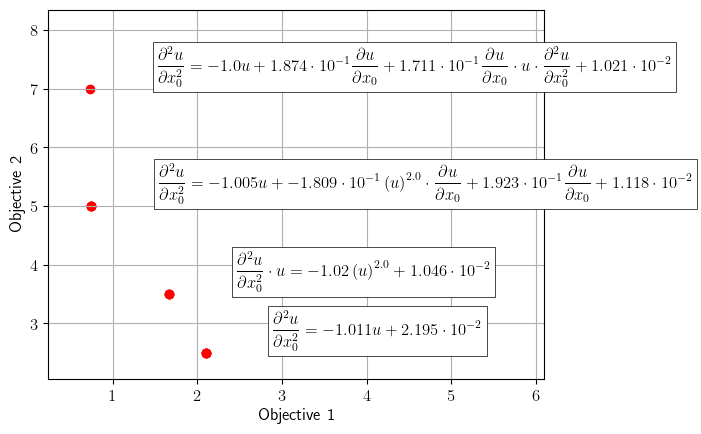

In [131]:
epde_search_obj.visualize_solutions()

Let's extract equations, that can be useful for system description: 

*Note*: during other example launches, the discovered equations may be different. To proceed, adopt getting equations by complexities, according to the Pareto frontier.

In [141]:
eq_compl_5 = epde_search_obj.get_equations_by_complexity(5)[0]
eq_compl_3_5 = epde_search_obj.get_equations_by_complexity(3.5)[0]
eq_compl_7 = epde_search_obj.get_equations_by_complexity(7)[0]

The Pareto frontier is concave, having the relatively simple yet very descriptive equation, matching the equation $u'' = -u + 0.2 u' - 0.2 u^2 u' + \delta$, $\delta << 1$ which we will consider as a useful equation-based model of the process.

Even though we already know, that it is very similar to the equation, from which we generated the data, we should still examine its predictive properties. Let's solve the equation with solver:

In [147]:
bop_u = get_ode_bop('u', grid_loc = t_test[0], value = x_test[0], term = [None], var = 0)
bop_dudt = get_ode_bop('dudt', grid_loc = t_test[0], value = y_test[0], term = [0], var = 0)

#get solution for equation with complexity 5
pred_u_compl_5 = epde_search_obj.predict(system=eq_compl_5, boundary_conditions=[bop_u(), bop_dudt()], 
                                   grid = [t_test,], strategy='autograd')
pred_u_compl_5 = pred_u_compl_5.reshape(pred_u_compl_5.size)

#get solution for equation with complexity 3.5
pred_u_compl_3_5 = epde_search_obj.predict(system=eq_compl_3_5, boundary_conditions=[bop_u(), bop_dudt()], 
                                   grid = [t_test,], strategy='autograd')
pred_u_compl_3_5 = pred_u_compl_3_5.reshape(pred_u_compl_3_5.size)

#get solution for equation with complexity 7
pred_u_compl_7 = epde_search_obj.predict(system=eq_compl_7, boundary_conditions=[bop_u(), bop_dudt()], 
                                   grid = [t_test,], strategy='autograd')
pred_u_compl_7 = pred_u_compl_7.reshape(pred_u_compl_7.size)

Using explicitly sent system of equations.
dimensionality is 1
grid.shape is (320,)
Shape of the grid for solver torch.Size([320, 1])
Grid is  <class 'torch.Tensor'> torch.Size([320, 1])
torch.Size([1])
[2023-10-27 18:55:25.204678] initial (min) loss is 114.25733184814453
[2023-10-27 18:55:25.338582] Print every 1000 step
Step = 0 loss = 114.257332 normalized loss line= -0.000000x+1.000000. There was 1 stop dings already.
[2023-10-27 18:57:06.004703] Print every 1000 step
Step = 1000 loss = 0.000560 normalized loss line= -0.002775x+1.563721. There was 1 stop dings already.
[2023-10-27 18:57:40.499169] No improvement in 100 steps
Step = 1356 loss = 0.000065 normalized loss line= 0.060959x+4.262471. There was 1 stop dings already.
[2023-10-27 18:57:50.585647] No improvement in 100 steps
Step = 1456 loss = 0.000622 normalized loss line= 0.017430x+-0.053238. There was 2 stop dings already.
[2023-10-27 18:58:00.498611] No improvement in 100 steps
Step = 1556 loss = 0.174487 normalized loss 

MAPE on the test dataset for eq with $C = 3.5$ is 1.0291776644268698
MAPE on the test dataset for eq with $C = 5$ is 0.1408898496016532
MAPE on the test dataset for eq with $C = 7$ is 0.45236988834056024


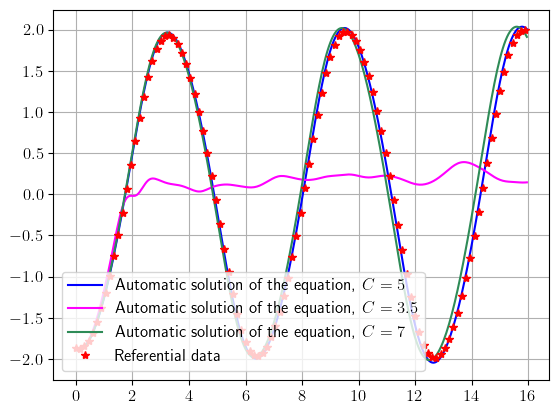

In [154]:
mae_compl_3_5 = np.mean(np.abs((pred_u_compl_3_5 - x_test)/x_test))
mae_compl_5 = np.mean(np.abs((pred_u_compl_5 - x_test)/x_test))
mae_compl_7 = np.mean(np.abs((pred_u_compl_7 - x_test)/x_test))

print(f'MAPE on the test dataset for eq with $C = 3.5$ is {mae_compl_3_5}')
print(f'MAPE on the test dataset for eq with $C = 5$ is {mae_compl_5}')
print(f'MAPE on the test dataset for eq with $C = 7$ is {mae_compl_7}')

plt.plot(t_test, pred_u_compl_5, color = 'b', label = 'Automatic solution of the equation, $C = 5$')
plt.plot(t_test, pred_u_compl_3_5, color = 'magenta', label = 'Automatic solution of the equation, $C = 3.5$')
plt.plot(t_test, pred_u_compl_7, color = 'seagreen', label = 'Automatic solution of the equation, $C = 7$')

plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.grid()
plt.legend(loc = 'lower left')
plt.show()

Here, we can notice, that the "correct" governing equation, which closely matches the Van der Pol equation, has the lowest MAPE metric on the test dataset, even outperforming the equations with higher complexities. The equation with lower complexity can represent only the averaged values of the system. Thus, we can select the equation like $u'' = -u + 0.2 u' - 0.2 u^2 u' + \delta$ for system representation.

## Lotka-Volterra system